In [1]:
# Set up code for the outsourcer's problem with on-the-job search
# Builds on Outsourcers file
# This block of code separates v_grid of hiring from v_hat_grid of outsourcing
# Try to use secant method to update guess

import numpy as np
import matplotlib.pyplot as plt
# import quantecon as qe
from numba import njit, int64, float64
from interpolation import interp
from IPython.core.debugger import set_trace
from scipy.optimize import minimize
import copy
import pandas as pd
import os

class OutsourcingOnJob:
    """
    B is discount rate beta
    r is interest rate defined by beta
    b is home production
    delta is job loss rate at firm
    delta_o is job loss rate at outsourcer
    delta_hat is firm destruction rate of outsourcing firm <= delta
    xi is probability of searching on-the-job
    eta is workers bargaining power with firm
    eta_o is workers bargaining power with outsourcer
    phi is effectiveness of matching function
    alpha is elasticity of matching function
    y_min, y_max, y_grid_size determine firm productivity grid
    rm is to Reimann Sum approximate firm integrals
    o_min, o_max, o_grid_size determine outsourcer productivity grid
    rm_o is to Reimann Sum approximate outsourcer integrals
    gamma is steepness of marginal cost, 
    c_grid is level of entry cost
    gamma_o is steepness of marginal cost for outsourcers, 
    c_o_grid is level of cost
    """
    def __init__(
        self, B, b, delta, delta_o, delta_hat, xi, eta, eta_o, phi, alpha,
        y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
        gamma, gamma_o, c_grid, c_o_grid
    ):
        
        self.B, self.b, self.delta, self.eta, self.gamma, self.c_grid = B, b, delta, eta, gamma, c_grid
        self.delta_hat, self.eta_o, self.gamma_o, self.c_o_grid = delta_hat, eta_o, gamma_o, c_o_grid 
        self.xi, self.delta_o = xi, delta_o
        self.r = 1 / B - 1
        
        self.y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
        self.y_grid_size, self.y_min, self.y_max = y_grid_size, y_min, y_max    
        self.rm = (y_max - y_min) / y_grid_size
        
        self.o_grid = np.linspace(o_min, o_max, o_grid_size, endpoint = False)
        self.o_grid_size, self.o_min, self.o_max = o_grid_size, o_min, o_max    
        self.rm_o = (o_max - o_min) / o_grid_size
        
        self.phi, self.alpha = phi, alpha
        
# Useful to have njit-ed functions to find max absolute error and percent difference
@njit()
def max_absolute_error(x, y):
    return np.max(np.abs(x - y))

@njit()
def percent_diff(x, y):
    return (x - y) / y * 100

# Set up neccesary functions
def operator_factory(ooj):
    
    r, b, delta, eta, gamma, c_grid = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma, ooj.c_grid
    delta_hat, eta_o, gamma_o, c_o_grid = ooj.delta_hat, ooj.eta_o, ooj.gamma_o, ooj.c_o_grid
    xi, delta_o = ooj.xi, ooj.delta_o
    phi, alpha = ooj.phi, ooj.alpha
    xi_bar, xi_bar_o = xi * (1 - delta), xi * (1 - delta_o)
    
    y_grid, y_grid_size, rm = ooj.y_grid, ooj.y_grid_size, ooj.rm
    o_grid, o_grid_size, rm_o = ooj.o_grid, ooj.o_grid_size, ooj.rm_o
    
    @njit()
    def q(theta):
        return min(phi * theta**(-alpha), 1)
    
    @njit()
    def ell(theta):
        return min(phi * theta**(1 - alpha), 1)
    
    # Want cost of vacancy, marginal cost of vacancy, and inverse marginal cost of vacancy
    @njit()
    def C(v_grid):
        return c_grid * v_grid**gamma
    
    @njit()
    def c(v_grid):
        return c_grid * gamma * v_grid**(gamma - 1)

    @njit()
    def c_inv(cost_grid):
        return (np.maximum(cost_grid, 0) / (gamma * c_grid))**(1 / (gamma - 1))
        
    # Do the same for outsourcers
    @njit()
    def C_o(v_o_grid):
        return c_o_grid * v_o_grid**gamma_o

    @njit()
    def c_o(v_o_grid):
        return c_o_grid * gamma_o * v_o_grid**(gamma_o - 1)

    @njit()
    def c_o_inv(cost_grid):
        return (np.maximum(cost_grid, 0) / (gamma_o * c_o_grid))**(1 / (gamma_o - 1))
    
    # Given a continuous y_hat, find the nearest y_i
    @njit()
    def find_y_i(y_hat):
        return np.argmin(np.abs(y_hat - y_grid))
    
    # Given v_grid, v_o_grid, n_grid,
    # n_o_grid, y_hat, R_grid, R_o_grid, and p, find
    # Firms who directly hire hire vs those that outsource out
    # Market tightness theta
    # Distribution of vacanices F and F_o
    # Distribution of job seekers G and G_o
    # Probability of worker leaving D and D_o
    # Wages w and w_o
    @njit()
    def make_grids(v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p):    
        
        y_i = find_y_i(y_hat)
        
        # Useful to have cumulative sums for hiring firms (below y_hat) and outsourcers
        v_temp = np.copy(v_grid)
        v_temp[y_i:] = 0
        n_temp = np.copy(n_grid)
        n_temp[y_i:] = 0
        
        cum_v = np.cumsum(v_temp * rm)
        cum_v_o = np.cumsum(v_o_grid * rm_o)
        cum_n = np.cumsum(n_temp * rm)
        cum_n_o = np.cumsum(n_o_grid * rm_o)
        
        # Define aggregate populations (make sure all exist)
        n_sum = cum_n[-1] + cum_n_o[-1]
        u = max(1 - n_sum, 1e-9)
        v = max(cum_v[-1], 1e-9)
        v_o = max(cum_v_o[-1], 1e-9) 
        v_sum = v + v_o
        pi = v_o / v_sum
        s = u + xi_bar * cum_n[-1] + xi_bar_o * cum_n_o[-1]
        theta = v_sum / s
        
        # Calculate distributions 
        # F is distribution of vacancies (include firms above y_hat in cdf as 1)
        F_grid = cum_v / v
        f_grid = v_temp / v
        
        F_o_grid = cum_v_o / v_o
        f_o_grid = v_o_grid / v_o
        
        # G is distribution of job seekers (include firms above y_hat as bigger than all y firms)        
        G_grid = (u + (xi_bar * cum_n + xi_bar_o * cum_n_o[R_grid])) / s
        G_o_grid = (u + (xi_bar * cum_n[R_o_grid] + xi_bar_o * cum_n_o)) / s
        
        # D is probability a worker finds a better job
        D_grid = 1 - (1 - pi) * F_grid - pi * F_o_grid[R_grid]
        D_o_grid = 1 - (1 - pi) * F_grid[R_o_grid] - pi * F_o_grid 
        
        # What is the value of search?
        f_tot = c(v_grid) / G_grid * f_grid * rm
        o_tot = c_o(v_o_grid) / G_o_grid * f_o_grid * rm_o
        i_cum_f = np.cumsum(f_tot[::-1])[::-1]
        i_cum_o = np.cumsum(o_tot[::-1])[::-1]
        
        # For unemployed
        firm = eta / (1 - eta) * (1 - pi) * i_cum_f[0]
        out = eta_o / (1 - eta_o) * pi * i_cum_o[0]
        Gamma_U = ell(theta) / q(theta) * (firm + out)
        
        # For employed at a firm
        firm = eta / (1 - eta) * (1 - pi) * i_cum_f
        out = eta_o / (1 - eta_o) * pi * i_cum_o[R_grid]
        Gamma_grid = ell(theta) / q(theta) * (firm + out)
        
        # For employed at an outsourcer
        firm = eta / (1 - eta) * (1 - pi) * i_cum_f[R_o_grid]
        out = eta_o / (1 - eta_o) * pi * i_cum_o
        Gamma_o_grid = ell(theta) / q(theta) * (firm + out)
        
        # Find wages
        w_grid = eta * y_grid + (1 - eta) * (b + Gamma_U - xi_bar * Gamma_grid) 
        w_o_grid = eta_o * p * o_grid + (1 - eta_o) * (b + Gamma_U - xi_bar_o * Gamma_o_grid) 
        
        return (
            theta, G_grid, G_o_grid, D_grid, D_o_grid, 
            Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid
        )
    
    # Given v_grid, v_o_grid, n_grid, J_out, y_zero,
    # n_o_grid, y_hat, R_grid, R_o_grid, and p, find new values
    @njit()
    def iterate(v_grid, v_o_grid, n_grid, n_o_grid, J_out, y_zero, y_hat, R_grid, R_o_grid, p):
        
        (theta, G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)
        
        # Value of hiring firms (outsourcing firm value does not depend on changing parameters)
        J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + xi_bar * ell(theta) * D_grid)
        
        # Update y_hat by finding firm closest to indifferent between hiring/outsourcing
        y_diff = np.argmin(np.abs(J_out - J_hire))
        y_hat_new = y_grid[max(y_diff, y_zero)]
        
        # Update vacancies
        # Hiring firms (below y_hat)
        v_grid_new = c_inv(J_hire)
        
        # Outsourcers
        v_o_grid_new = c_o_inv(
            q(theta) * G_o_grid * (o_grid * p - w_o_grid) 
            / (r + delta_o + xi_bar_o * ell(theta) * D_o_grid)
        )
        
        # Update positions
        # Hiring firms
        n_grid_new = (1 - delta) * (1 - xi * ell(theta) * D_grid) * n_grid + q(theta) * G_grid * v_grid_new
        
        # Outsourcers
        n_o_grid_new = ((1 - delta_o) * (1 - xi * ell(theta) * D_o_grid) * n_o_grid
                        + q(theta) * G_o_grid * v_o_grid_new)
               
        # Update R_grid and R_o_grid by comparing W - U to W_o - U.
        # Note that R_grid is defined for all firms, even those above 
        # y_hat, and R_o_grid might be indifferent to a firm above y_hat that doesn't hire
        # Value of employment at a firm (minus value of unemployment)        
        W_min_U = (
            (1 + r) * (w_grid - b - Gamma_U + xi_bar * Gamma_grid)
            / (r + delta + xi_bar * ell(theta) * D_grid)
        )
        
        # Value of employment at an outsourcer (minus value of unemployment)
        W_o_min_U = (
            (1 + r) * (w_o_grid - b - Gamma_U + xi_bar_o * Gamma_o_grid)
            / (r + delta_o + xi_bar_o * ell(theta) * D_o_grid)
        )

        # Use these and search sorted to find new indecision rules (make sure not above all)
        R_grid_new = np.minimum(np.searchsorted(W_o_min_U, W_min_U), o_grid_size - 1)
    
        R_o_grid_new = np.minimum(np.searchsorted(W_min_U, W_o_min_U), y_grid_size - 1)
        
        return v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new
    
    # Given n_hat_grid, n_o_grid, and y_hat find excess demand for outsourcing 
    @njit()
    def QD_QS_ED(n_hat_grid, n_o_grid, y_hat):
        y_i = find_y_i(y_hat)
        QD = np.sum(n_hat_grid[y_i:] * rm) 
        QS = np.sum(n_o_grid * o_grid * rm_o)
        ED = QD - QS
        return QD, QS, ED

    @njit()
    def solve_given_p(
        p, v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
        n_o_grid, y_hat, R_grid, R_o_grid, tol, max_iter, slow
    ):

        # Set up initial loop parameters
        i = 0
        err = tol + 1    
        
        # Given p, we can already solve for optimal outsourcing        
        J_out = (y_grid - p) / (r + delta_hat)
        # Make sure J_out is non_negative at y_hat
        y_zero = np.argmin(np.abs(J_out))
        v_hat_grid_new = c_inv(J_out)
        n_hat_grid_new = v_hat_grid_new / delta_hat

        # Update v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, y_hat, R_grid, and R_o_grid
        while i < max_iter and err > tol:
            (v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new,
             y_hat_new, R_grid_new, R_o_grid_new) = iterate(
                v_grid, v_o_grid, n_grid, n_o_grid, J_out, y_zero, y_hat, R_grid, R_o_grid, p
            )
            err_v_t = max_absolute_error(v_grid_new, v_grid)
            err_v_o = max_absolute_error(v_o_grid_new, v_o_grid)
            err_n_t = max_absolute_error(n_grid_new, n_grid)
            err_n_o = max_absolute_error(n_o_grid_new, n_o_grid)
            err = max(err_v_t, err_v_o, err_n_t, err_n_o)
            i += 1

            v_grid = slow * v_grid_new + (1 - slow) * v_grid
            v_o_grid = slow * v_o_grid_new + (1 - slow) * v_o_grid
            n_grid = slow * n_grid_new + (1 - slow) * n_grid
            n_o_grid = slow * n_o_grid_new + (1 - slow) * n_o_grid
            y_hat = slow * y_hat_new + (1 - slow) * y_hat 

            # To slowly adjust R_grid, and R_o_grid (which are indexes), instead 
            # add/subtract by 1 if greater/less 
            R_grid = R_grid + 1 * (R_grid_new > R_grid) - 1 * (R_grid_new < R_grid)
            R_o_grid = R_o_grid + 1 * (R_o_grid_new > R_o_grid) - 1 * (R_o_grid_new < R_o_grid) 

        return (
            v_grid_new, v_hat_grid_new, v_o_grid_new, n_grid_new,
            n_hat_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new
        )        
    
    return solve_given_p, iterate, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell 

# Find p
def find_p(
    ooj, guess, p_1, p_2, tol, max_iter, tol_i, max_iter_i, slow_i, verbose=True, print_skip=5
):
    
    solve_given_p, _, QD_QS_ED, _, _, _, _, _, _, _, _, _, _ = operator_factory(ooj)
    
    # Solve ED_1 and ED_2 given p_1 and p_2
    
    # Initial guess
    v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid = guess
    
    # Set up loop parameters    
    err = tol + 1
    j = 0
    
    # Find excess_demand for p_1 and p_2
    for p in [p_2, p_1]:
        
#         qe.tic()

        (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid) = solve_given_p(
            p, v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
            n_o_grid, y_hat, R_grid, R_o_grid, tol=tol_i, max_iter=max_iter_i, slow=slow_i
        )
        
        QD, QS, ED = QD_QS_ED(n_hat_grid, n_o_grid, y_hat)
        
#         qe.toc()
        
        if p == p_2:
            ED_2 = ED
        else:
            ED_1 = ED
        
        if verbose:
            print(f'Excess Demand for price {p} is {ED:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
            
#         set_trace()
        
    while err > tol and j < max_iter:
        
#         qe.tic()
        
        # Update p 
        p = (p_2 * ED_1 - p_1 * ED_2) / (ED_1 - ED_2)
                
        (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid) = solve_given_p(
            p, v_grid, v_hat_grid, v_o_grid, n_grid,
            n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, tol_i, max_iter_i, slow_i
        )
        
        QD, QS, ED = QD_QS_ED(n_hat_grid, n_o_grid, y_hat)
        err = np.abs(ED)
        
#         qe.toc()
        
        # Go to next iteration
        p_2, ED_2 = np.copy(p_1), np.copy(ED_1)
        p_1, ED_1 = np.copy(p), np.copy(ED)
            
        if verbose and j % print_skip == 0:
            print(
                f'Excess Demand at iter {j} is {ED:.4f}; price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}',
                f"y_hat is {y_hat:.4f}"
            )
            
        j += 1
        
    
    if j < max_iter:
        print(f'Converged in {j} iterations, Excess Demand is {ED:.4f};',
              f'price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
    if j == max_iter:
        print(f'Failed to Converge. Excess Demand is {ED:.4f}; price is {p:.4f};',
              f'QS is {QS:.4f}; QD is {QD:.4f}')
        
    return v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p

# From LS, take the model without outsourcers
# Set up neccesary functions
def ls_operator_factory(ooj):
    
    r, b, delta, eta, gamma, c_grid = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma, ooj.c_grid
    phi, alpha, xi = ooj.phi, ooj.alpha, ooj.xi
    xi_bar = xi * (1 - delta)
    
    y_grid, y_grid_size, rm, y_max = ooj.y_grid, ooj.y_grid_size, ooj.rm, ooj.y_max   
    
    # Take cost and matching from operator_factory
    _, _, _, _, _, C, c, c_inv, _, _, _, q, ell = operator_factory(ooj)
    
    # Given v_grid, and n_grid find the distribution of workers
    # Including market tightness theta and distribution of vacancies f_grid
    @njit()
    def ls_worker_dist(v_grid, n_grid):
        
        # Define aggregate populations (make sure all exist)
        n = max(np.sum(n_grid * rm), 1e-9)
        u = max(1 - n, 1e-9)
        v = max(np.sum(v_grid * rm), 1e-9)
        s = u + xi_bar * n
        
        # Calculate theta 
        theta = v / s
        
        # f is pdf of vacancies 
        F_grid = np.cumsum(v_grid * rm) / v
        f_grid = v_grid / v
        
        # G_grid is share of jobseekers at less productive firms
        G_grid = (u + xi_bar * np.cumsum(n_grid * rm)) / s
        
        # D_grid is probability the worker leaves for a better job
        D_grid = 1 - F_grid
        
        return theta, f_grid, G_grid, D_grid
    
    # Solve decentralized problem
    # Given v_grid, and n_grid find
    # Market tightness theta and Wages w
    @njit()
    def ls_make_grids(v_grid, n_grid):    
        
        # Get distribution of workers
        theta, f_grid, G_grid, D_grid = ls_worker_dist(v_grid, n_grid)
        
        # What is the value of search?        
        f_tot = c(v_grid) / G_grid * f_grid * rm
        i_cum_f = np.cumsum(f_tot[::-1])[::-1]
        Gamma_grid = ell(theta) / q(theta) * eta / (1 - eta) * i_cum_f
        Gamma_U = Gamma_grid[0]
        
        # Find wage
        w_grid = eta * y_grid + (1 - eta) * (b + Gamma_U - xi_bar * Gamma_grid)
        
        return theta, w_grid, Gamma_U, Gamma_grid, G_grid, D_grid
    
    # Given v_grid and n_grid find new values
    @njit()
    def ls_iterate(v_grid, n_grid):
        
        theta, w_grid, Gamma_U, Gamma_grid, G_grid, D_grid = ls_make_grids(v_grid, n_grid)
        
        # Value of firm
        J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + xi_bar * ell(theta) * D_grid)
        
        # Update vacancies
        v_grid_new = c_inv(J_hire)
        
        # Update positions
        n_grid_new = (1 - delta) * (1 - xi * ell(theta) * D_grid) * n_grid + q(theta) * G_grid * v_grid_new
                       
        return v_grid_new, n_grid_new
    
    return ls_iterate, ls_make_grids

# Solve model
def ls_solve_model(ooj, guess, tol, max_iter, slow, verbose=False, print_skip=1e4):
    
    ls_iterate, _ = ls_operator_factory(ooj)
    
    v_grid, n_grid = guess

    # Set up initial loop parameters
    i = 0
    err = tol + 1    

    # Update v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, and y_hat
    while i < max_iter and err > tol:
        v_grid_new, n_grid_new = ls_iterate(v_grid, n_grid)
        err_v = max_absolute_error(v_grid_new, v_grid)
        err_n = max_absolute_error(n_grid_new, n_grid)
        err = max(err_v, err_n)

        v_grid = slow * v_grid_new + (1 - slow) * v_grid
        n_grid = slow * n_grid_new + (1 - slow) * n_grid
        
        if verbose and i % print_skip == 0:
            print(f"Error at iter {i} is {err:.4f}") 
        
        i += 1
    
    if i < max_iter:
        print(f'Converged in {i} iterations')
    if i == max_iter:
        print(f'Failed to Converge.')

    return v_grid_new, n_grid_new

# Create a factory to solve the Planner's problem with and without outsourcing
def operator_factory_p(ooj):
    
    r, b, delta, eta, gamma, c_grid = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma, ooj.c_grid
    delta_hat, eta_o, gamma_o, c_o_grid = ooj.delta_hat, ooj.eta_o, ooj.gamma_o, ooj.c_o_grid
    xi, delta_o = ooj.xi, ooj.delta_o
    phi, alpha = ooj.phi, ooj.alpha
    xi_bar, xi_bar_o = xi * (1 - delta), xi * (1 - delta_o)
    
    y_grid, y_grid_size, rm, y_max = ooj.y_grid, ooj.y_grid_size, ooj.rm, ooj.y_max
    o_grid, o_grid_size, rm_o = ooj.o_grid, ooj.o_grid_size, ooj.rm_o
    
    # import functions from main factory
    (solve_given_p, iterate, QD_QS_ED, make_grids, find_y_i,
     C, c, c_inv, C_o, c_o, c_o_inv, q, ell) = operator_factory(ooj)
    
    # Use estimates of q_p and ell_p to insure smoothness around q/l == 1
    A = 10 # This is how close estimate is (increases in A as long as exp not too big)
    
    # Planner's problem also uses derivatives
    @njit()
    def q_p(theta):
        exp = np.exp(A * (phi * theta**(-alpha) - 1))
        return -alpha * phi * theta**(-alpha - 1) / (1 + exp)
    
    @njit()
    def ell_p(theta):
        exp = np.exp(A * (phi * theta**(1 - alpha) - 1))             
        return (1 - alpha) * phi * theta**(-alpha) / (1 - exp)
    
    # Given v_grid, n_grid, and lam_grid find
    # market tightness theta
    # position distribution G and vacancy distribution D
    # vacancy and position externalities
    @njit()
    def ls_make_grids_p(v_grid, n_grid, lam_grid):
    
        # Define aggregate populations (make sure all exist)
        n = max(np.sum(n_grid * rm), 1e-9)
        u = max(1 - n, 1e-9)
        v = max(np.sum(v_grid * rm), 1e-9)
        s = u + xi_bar * n
        
        # Calculate theta 
        theta = v / s
        
        # f is pdf of vacancies 
        F_grid = np.cumsum(v_grid * rm) / v
        # D_grid is probability the worker leaves for a better job
        D_grid = 1 - F_grid
        
        # G_grid is share of jobseekers at less productive firms
        G_grid = (u + xi_bar * np.cumsum(n_grid * rm)) / s     
        
        # Use lamda to find vacancy externality
        # Three temp functions needed
        temp_1 = lam_grid * (1 - D_grid) * n_grid * rm
        temp_1_sum = np.cumsum(temp_1)
        temp_2 = lam_grid * D_grid * n_grid * rm
        temp_2_sum = np.cumsum(temp_2[::-1])[::-1]
        temp = xi_bar * ell(theta) * (temp_1_sum - temp_2_sum) / theta
        
        vac_sum = np.sum(lam_grid * G_grid * v_grid * rm)
        pos_sum = xi_bar * np.sum(lam_grid * D_grid * n_grid * rm)
        
        common_temp = q_p(theta) * vac_sum - ell_p(theta) * pos_sum
        
        vac_ext = B / s * (common_temp - temp)
        
        # Find position externality
        # Need three temp functions for one of integrals
        temp_3 = lam_grid * (1 - (1 - xi_bar) * G_grid) * v_grid * rm
        temp_3_sum = np.cumsum(temp_3)
        temp_4 = lam_grid * (1 - xi_bar) * (1 - G_grid) * v_grid * rm
        temp_4_sum = np.cumsum(temp_4[::-1])[::-1]
        temp_b = q(theta) * (temp_3_sum + temp_4_sum)
        
        pos_ext = ((1 - xi_bar) * theta * common_temp - temp_b) / s
        
#         print(theta, vac_ext, pos_ext)
        
        return theta, G_grid, D_grid, vac_ext, pos_ext


    @njit()
    def ls_iterate_p(v_grid, n_grid, lam_grid):
            
        theta, G_grid, D_grid, vac_ext, pos_ext = ls_make_grids_p(v_grid, n_grid, lam_grid)
            
        # Value of firms
        J_hire = B * lam_grid * G_grid * q(theta) + vac_ext
        
        # Update vacancies
        v_grid_new = c_inv(J_hire)
        
        # Update positions
        n_grid_new = (1 - delta) * (1 - xi * ell(theta) * D_grid) * n_grid + q(theta) * G_grid * v_grid_new
                         
        # Update lambda
        lam_grid_new = ((1 + r) * (y_grid - b) + pos_ext) / (r + delta + xi_bar * ell(theta) * D_grid)
                       
        return v_grid_new, n_grid_new, lam_grid_new
    
    # Given v_grid, v_o_grid, n_grid,
    # n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid and rho, find
    # Firms who directly hire hire vs those that outsource out
    # Market tightness theta
    # Distribution of vacanices F and F_o
    # Distribution of job seekers G and G_o
    # Probability of worker leaving D and D_o
    # Externalities from vacancies and positions of hiring firms and outsourcers
    @njit()
    def make_grids_p(v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, 
                     lam_grid, iota_grid, rho):    
        
        y_i = find_y_i(y_hat)
        
        # Useful to have cumulative sums for hiring firms (below y_hat) and outsourcers
        v_temp = np.copy(v_grid)
        v_temp[y_i:] = 0
        n_temp = np.copy(n_grid)
        n_temp[y_i:] = 0
        
        cum_v = np.cumsum(v_temp * rm)
        cum_v_o = np.cumsum(v_o_grid * rm_o)
        cum_n = np.cumsum(n_temp * rm)
        cum_n_o = np.cumsum(n_o_grid * rm_o)
        
        # Define aggregate populations (make sure all exist)
        n_sum = cum_n[-1] + cum_n_o[-1]
        u = max(1 - n_sum, 1e-9)
        v = max(cum_v[-1], 1e-9)
        v_o = max(cum_v_o[-1], 1e-9) 
        v_sum = v + v_o
        pi = v_o / v_sum
        s = u + xi_bar * cum_n[-1] + xi_bar_o * cum_n_o[-1]
        theta = v_sum / s
        
        # Calculate distributions 
        # F is distribution of vacancies (include firms above y_hat in cdf as 1)
        F_grid = cum_v / v
        f_grid = v_temp / v
        
        F_o_grid = cum_v_o / v_o
        f_o_grid = v_o_grid / v_o
        
        # G is distribution of job seekers (include firms above y_hat as bigger than all y firms)        
        G_grid = (u + (xi_bar * cum_n + xi_bar_o * cum_n_o[R_grid])) / s
        G_o_grid = (u + (xi_bar * cum_n[R_o_grid] + xi_bar_o * cum_n_o)) / s
        
        # D is probability a worker finds a better job
        D_grid = 1 - (1 - pi) * F_grid - pi * F_o_grid[R_grid]
        D_o_grid = 1 - (1 - pi) * F_grid[R_o_grid] - pi * F_o_grid 
        
        # There are two externalities the Planner accounts for (for firms and outsourcers), 
        # one is for sending a vacancy to the matching function 
        # Second is for having a worker that cannot be used elsewhere
        # Calculate both (slightly different for firms vs outsourcers)
        
        # First, vacancy externality
        temp_1_a = (1 - D_grid) * lam_grid * n_temp * rm
        temp_1_a_sum = np.cumsum(temp_1_a)
        temp_1_b = D_grid * lam_grid * n_temp * rm
        temp_1_b_sum = np.cumsum(temp_1_b[::-1])[::-1]
        temp_1 = ell(theta) * xi_bar * (temp_1_a_sum - temp_1_b_sum)
        temp_1_o = ell(theta) * xi_bar * (temp_1_a_sum[R_o_grid] - temp_1_b_sum[R_o_grid])
        
        temp_2_a = (1 - D_o_grid) * iota_grid * n_o_grid * rm_o
        temp_2_a_sum = np.cumsum(temp_2_a)
        temp_2_b = D_o_grid * iota_grid * n_o_grid * rm_o
        temp_2_b_sum = np.cumsum(temp_2_b[::-1])[::-1]
        temp_2 = ell(theta) * xi_bar_o * (temp_2_a_sum[R_grid] - temp_2_b_sum[R_grid])
        temp_2_o = ell(theta) * xi_bar_o * (temp_2_a_sum - temp_2_b_sum)
        
        vac_sum = np.sum(lam_grid * G_grid * v_temp * rm) + np.sum(iota_grid * G_o_grid * v_o_grid * rm_o)
        pos_sum = (xi_bar * np.sum(lam_grid * D_grid * n_temp * rm) 
                   + xi_bar_o * np.sum(iota_grid * D_o_grid * n_o_grid * rm_o))
        
        common_temp = theta * (q_p(theta) * vac_sum - ell_p(theta) * pos_sum)
        
        vac_ext = B / v_sum * (common_temp - temp_1 - temp_2)
        vac_ext_o = B / v_sum * (common_temp - temp_1_o - temp_2_o)
        
        # Next position externality
        temp_3_a = (1 - (1 - xi_bar) * G_grid) * lam_grid * v_temp * rm
        temp_3_a_sum = np.cumsum(temp_3_a)
        temp_3_b = (1 - xi_bar) * (1 - G_grid) * lam_grid * v_temp * rm
        temp_3_b_sum = np.cumsum(temp_3_b[::-1])[::-1]
        temp_3 = temp_3_a_sum + temp_3_b_sum
        
        temp_3_o_a = (1 - (1 - xi_bar_o) * G_grid) * lam_grid * v_temp * rm
        temp_3_o_a_sum = np.cumsum(temp_3_o_a)
        temp_3_o_b = (1 - xi_bar_o) * (1 - G_grid) * lam_grid * v_temp * rm
        temp_3_o_b_sum = np.cumsum(temp_3_o_b[::-1])[::-1]
        temp_3_o = temp_3_o_a_sum[R_o_grid] + temp_3_o_b_sum[R_o_grid] 
        
        temp_4_a = (1 - (1 - xi_bar) * G_o_grid) * iota_grid * v_o_grid * rm_o
        temp_4_a_sum = np.cumsum(temp_4_a)
        temp_4_b = (1 - xi_bar) * (1 - G_o_grid) * iota_grid * v_o_grid * rm_o
        temp_4_b_sum = np.cumsum(temp_4_b[::-1])[::-1]
        temp_4 = temp_4_a_sum[R_grid] + temp_4_b_sum[R_grid]   
        
        temp_4_o_a = (1 - (1 - xi_bar_o) * G_o_grid) * iota_grid * v_o_grid * rm_o
        temp_4_o_a_sum = np.cumsum(temp_4_o_a)
        temp_4_o_b = (1 - xi_bar_o) * (1 - G_o_grid) * iota_grid * v_o_grid * rm_o
        temp_4_o_b_sum = np.cumsum(temp_4_o_b[::-1])[::-1]
        temp_4_o = temp_4_o_a_sum + temp_4_o_b_sum
        
        pos_ext = ((1 - xi_bar) * common_temp - q(theta) * (temp_3 + temp_4)) / s
        pos_ext_o = ((1 - xi_bar_o) * common_temp - q(theta) * (temp_3_o + temp_4_o)) / s
        
        return theta, G_grid, G_o_grid, D_grid, D_o_grid, vac_ext, vac_ext_o, pos_ext, pos_ext_o
    
    # Given v_grid, v_o_grid, n_grid, J_out, y_zero,
    # n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid, and rho, find new values
    @njit()
    def iterate_p(v_grid, v_o_grid, n_grid, n_o_grid, J_out, y_zero, y_hat, R_grid, R_o_grid,
                lam_grid, iota_grid, rho):
        
        # Find theta and determine if q/ell theta = 1
        y_i = find_y_i(y_hat)
        
        theta, G_grid, G_o_grid, D_grid, D_o_grid, vac_ext, vac_ext_o, pos_ext, pos_ext_o = make_grids_p(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid, rho)
        
        # Value of hiring firms (outsourcing firm value does not depend on changing parameters)
        J_hire = B * q(theta) * G_grid * lam_grid + vac_ext
        
        # Update y_hat by finding firm closest to indifferent between hiring/outsourcing
        y_diff = np.argmin(np.abs(J_out - J_hire))
        y_hat_new = y_grid[max(y_diff, y_zero)]
        
        # Update vacancies
        # Hiring firms (below y_hat)
        v_grid_new = c_inv(J_hire)
        
        # Outsourcers
        v_o_grid_new = c_o_inv(B * q(theta) * G_o_grid * iota_grid + vac_ext_o)      

        # Update positions
        # Hiring firms
        n_grid_new = (1 - delta) * (1 - xi * ell(theta) * D_grid) * n_grid + q(theta) * G_grid * v_grid_new
        
        # Outsourcers
        n_o_grid_new = ((1 - delta_o) * (1 - xi * ell(theta) * D_o_grid) * n_o_grid
                        + q(theta) * G_o_grid * v_o_grid_new)
        
        # Update lam_grid and iota_grid
        lam_grid_new = ((1 + r) * (y_grid - b) + pos_ext) / (r + delta + xi_bar * ell(theta) * D_grid)
        iota_grid_new = (((1 + r) * (rho * o_grid - b) + pos_ext_o)
                         / (r + delta_o + xi_bar_o * ell(theta) * D_o_grid))
               
        # Update R_grid and R_o_grid by comparing lambda and iota
        # Note that R_grid is defined for all firms, even those above 
        # y_hat, and R_o_grid might be indifferent to a firm above y_hat that doesn't hire        
        # Use these and search sorted to find new indecision rules (make sure not above all)        
        R_grid_new = np.minimum(np.searchsorted(iota_grid, lam_grid), o_grid_size - 1)
    
        R_o_grid_new = np.minimum(np.searchsorted(lam_grid, iota_grid), y_grid_size - 1)
        
        return (v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new,
               lam_grid_new, iota_grid_new)    
    
    # Solve model give a price rho
    @njit()
    def solve_given_rho(
        rho, v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
        n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid, tol, max_iter, slow
    ):
        
        # Given rho, we can already solve for optimal outsourcing  
        J_out = (y_grid - rho) / (r + delta_hat)
        # Make sure J_out is non_negative at y_hat
        y_zero = np.argmin(np.abs(J_out))
        v_hat_grid_new = c_inv(J_out)
        n_hat_grid_new = v_hat_grid_new / delta_hat

        # Reset loop
        i = 0
        err = tol + 1 

        # Update v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, y_hat, R_grid, and R_o_grid
        while i < max_iter and err > tol:            
            (v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new,
             y_hat_new, R_grid_new, R_o_grid_new, lam_grid_new, iota_grid_new) = iterate_p(
                v_grid, v_o_grid, n_grid, n_o_grid, J_out, y_zero, y_hat, R_grid, R_o_grid,
                lam_grid, iota_grid, rho
            )
            err_v_t = max_absolute_error(v_grid_new, v_grid)
            err_v_o = max_absolute_error(v_o_grid_new, v_o_grid)
            err_n_t = max_absolute_error(n_grid_new, n_grid)
            err_n_o = max_absolute_error(n_o_grid_new, n_o_grid)
            err = max(err_v_t, err_v_o, err_n_t, err_n_o)
            i += 1

            slow_n = min(slow * 2, 1)

            v_grid = slow * v_grid_new + (1 - slow) * v_grid
            v_o_grid = slow * v_o_grid_new + (1 - slow) * v_o_grid
            n_grid = slow_n * n_grid_new + (1 - slow_n) * n_grid
            n_o_grid = slow_n * n_o_grid_new + (1 - slow_n) * n_o_grid
            y_hat = slow * y_hat_new + (1 - slow) * y_hat 
            lam_grid = slow * lam_grid_new + (1 - slow) * lam_grid
            iota_grid = slow * iota_grid_new + (1 - slow) * iota_grid

            # To slowly adjust R_grid, and R_o_grid (which are indexes), instead 
            # add/subtract by 1 if greater/less 
            R_grid = R_grid + 1 * (R_grid_new > R_grid) - 1 * (R_grid_new < R_grid)
            R_o_grid = R_o_grid + 1 * (R_o_grid_new > R_o_grid) - 1 * (R_o_grid_new < R_o_grid) 

        return (
            v_grid_new, v_hat_grid_new, v_o_grid_new, n_grid_new, n_hat_grid_new, n_o_grid_new,
            y_hat_new, R_grid_new, R_o_grid_new, lam_grid, iota_grid
        )        
    
    return solve_given_rho, iterate_p, make_grids_p, ls_iterate_p, ls_make_grids_p  

# Solve Planner's Problem
def find_rho(
    ooj, guess, rho_1, rho_2, tol, max_iter, tol_i, max_iter_i, slow_i, verbose=True, print_skip=5
):
    
    _, _, QD_QS_ED, _, _, _, _, _, _, _, _, _, _ = operator_factory(ooj)
    solve_given_rho, _, _, _, _ = operator_factory_p(ooj)
    
    # Solve ED_1 and ED_2 given rho_1 and rho_2
    
    # Initial guess
    (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat,
     R_grid, R_o_grid, lam_grid, iota_grid) = guess
    
    # Set up loop parameters    
    err = tol + 1
    j = 0
    
    # Find excess_demand for rho_1 and rho_2
    for rho in [rho_2, rho_1]:

        (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid) = solve_given_rho(
            rho, v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
            n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid,
            tol=tol_i, max_iter=max_iter_i, slow=slow_i
        )
        
        QD, QS, ED = QD_QS_ED(n_hat_grid, n_o_grid, y_hat)
        
        if rho == rho_2:
            ED_2 = ED
        else:
            ED_1 = ED
        
        if verbose:
            print(f'Excess Demand for rho {rho} is {ED:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
            
            
    while err > tol and j < max_iter:
        
        # Update rho (if ED_1/2 are 0, set very low)
        if ED_1 == 0 and ED_2 == 0:
            rho = b
        else:
            rho = (rho_2 * ED_1 - rho_1 * ED_2) / (ED_1 - ED_2)
                
        (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid) = solve_given_rho(
            rho, v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
            n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid,
            tol=tol_i, max_iter=max_iter_i, slow=slow_i
        )
        
        QD, QS, ED = QD_QS_ED(n_hat_grid, n_o_grid, y_hat)
        err = np.abs(ED)
        
        # Go to next iteration
        rho_2, ED_2 = np.copy(rho_1), np.copy(ED_1)
        rho_1, ED_1 = np.copy(rho), np.copy(ED)
            
        if verbose and j % print_skip == 0:
            print(
                f'Excess Demand at iter {j} is {ED:.4f}; rho is {rho:.4f}; QS is {QS:.4f}; QD is {QD:.4f}',
                f"y_hat is {y_hat:.4f}"
            )
            
        j += 1
    
    if j < max_iter:
        print(f'Converged in {j} iterations, Excess Demand is {ED:.4f};',
              f'price is {rho:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
    if j == max_iter:
        print(f'Failed to Converge. Excess Demand is {ED:.4f}; price is {rho:.4f};',
              f'QS is {QS:.4f}; QD is {QD:.4f}')
        
    return (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid,
            y_hat, R_grid, R_o_grid, lam_grid, iota_grid, rho)


# Solve LS Planner's
def ls_solve_model_p(ooj, guess, tol, max_iter, slow, verbose=False, print_skip=1e4):
    
    _, _, _, ls_iterate_p, ls_make_grids_p = operator_factory_p(ooj)
    
    v_grid, n_grid, lam_grid = guess

    # Set up initial loop parameters
    i = 0
    err = tol + 1   

    # Update v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, and y_hat
    while i < max_iter and err > tol:
        v_grid_new, n_grid_new, lam_grid_new = ls_iterate_p(v_grid, n_grid, lam_grid)
        err_v = max_absolute_error(v_grid_new, v_grid)
        err_n = max_absolute_error(n_grid_new, n_grid)
        err = max(err_v, err_n)

        v_grid = slow * v_grid_new + (1 - slow) * v_grid
        n_grid = slow * n_grid_new + (1 - slow) * n_grid
        lam_grid = slow * lam_grid_new + (1 - slow) * lam_grid
        
        if verbose and i % print_skip == 0:
            print(f"Error at iter {i} is {err:.4f}") 
        
        i += 1
    
    if i < max_iter:
        print(f'Converged in {i} iterations')
    if i == max_iter:
        print(f'Failed to Converge.')

    return v_grid_new, n_grid_new, lam_grid_new

# Create a function to graph results
def graph_results(ooj, solution, save=False, height=7, folder=None, file=None):

    # Make sure dimensions are 1:1.77 (or 1:1.62)
    width = height * 1.77    
#     width = height * 1.62
    
    # Unpack solution
    (v_grid, v_hat_grid, v_o_grid, n_grid,
     n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p) = solution
    
    # Get data needed from ooj
    _, _, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj)
    
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    
    r, delta, xi = ooj.r, ooj.delta, ooj.xi
    delta_o, delta_hat = ooj.delta_o, ooj.delta_hat
    c_grid, c_o_grid = ooj.c_grid, ooj.c_o_grid
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    y_grid_size, o_grid_size = ooj.y_grid_size, ooj.o_grid_size
    xi_bar, xi_bar_o = xi * (1 - delta), xi * (1 - delta_o)
    
    y_i = find_y_i(y_hat)
        
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, w_grid, lw=2, alpha=0.75)
    ax.plot(y_grid, y_grid, lw=2, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Wage $w$")
    
    if save:
        fig.savefig(folder + file + 'Firm Wages v Productivity.pdf')
    else:
        plt.show()  
        
    plt.close()
        
    # Graph outsourcer wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, w_o_grid, lw=2, alpha=0.75)
    ax.plot(o_grid, o_grid * p, lw=2, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $o$", ylabel="Wage $w_o$")
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Wages v Productivity.pdf')
    else:
        plt.show() 
        
    plt.close()
        
    # Graph vacacies by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], v_grid[:y_i] * rm, lw=2, alpha=0.75, label="Firms")
    ax.plot(w_o_grid, v_o_grid * rm_o, lw=2, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Vacancies $v$")
    ax.legend(loc="upper right")
    
    if save:
        fig.savefig(folder + file + 'Vacancies v Wages.pdf')
    else:
        plt.show()   
        
    plt.close()      
    
    # Graph filled posititions by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], n_grid[:y_i] * rm, lw=2, alpha=0.75, label="Firms")
    ax.plot(w_o_grid, n_o_grid * rm_o, lw=2, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Positions $n$")
    ax.legend(loc="upper right")
    
    if save:
        fig.savefig(folder + file + 'Positions v Wages.pdf')
    else:
        plt.show() 
        
    plt.close()
        
    # Graph firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid * rm, lw=2, alpha=0.75, label=r"Hiring Vacancies ${v}$")
    ax.plot(y_grid, v_hat_grid * rm, lw=2, alpha=0.75, label=r"Outsourcing Vacancies $\hat{v}$")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firm Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph firm postions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid * rm, lw=2, alpha=0.75, label=r"Hiring Positions ${n}$")
    ax.plot(y_grid, n_hat_grid * rm, lw=2, alpha=0.75, label=r"Outsourcing Positions $\hat{n}$")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Positions")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firm Positions.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph outsourcer vacancies and filled positions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, v_o_grid * rm_o, lw=2, alpha=0.75, label=r"Vacanicies $\tilde{v}$")
    ax.set(xlabel="Productivity $o$", ylabel="Vacancies")
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
        
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, n_o_grid * rm_o, lw=2, alpha=0.75, label=r"Positions $\tilde{n}$")
    ax.set(xlabel="Productivity $o$", ylabel="Positions")
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Positions.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph median tenure by wage
    p_stay = (1 - delta) * (1 - xi * ell(theta) * D_grid)
    median_tenure = np.log(.5) / np.log(p_stay)
    p_o_stay = (1 - delta_o) * (1 - xi * ell(theta) * D_o_grid)
    median_tenure_o = np.log(.5) / np.log(p_o_stay)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], median_tenure[:y_i], lw=2, alpha=0.75, label="Firms")
    ax.plot(w_o_grid, median_tenure_o, lw=2, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage", ylabel="Median Tenure")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Median Tenure.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph firings (lose jobs) vs quits (find better job) by wage
    firings = delta * n_grid * rm
    quits = xi_bar * ell(theta) * D_grid * n_grid * rm
    firings_o = delta_o * n_o_grid * rm_o
    quits_o = xi_bar_o * ell(theta) * D_o_grid * n_o_grid * rm_o
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], firings[:y_i], lw=2, alpha=0.75, label="Firm Firings")
    ax.plot(w_grid[:y_i], quits[:y_i], lw=2, alpha=0.75, label="Firm Quits")
    ax.plot(w_o_grid, firings_o, lw=2, alpha=0.75, label="Outsourcer Firings")
    ax.plot(w_o_grid, quits_o, lw=2, alpha=0.75, label="Outsourcer Quits")
    ax.set(xlabel="Wage", ylabel="Number")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firings and Quits.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    # Do the same for outsourcers hiring
    J_hire = (q(theta) * G_grid * (y_grid - w_grid) 
              / (r + delta + xi_bar * ell(theta) * D_grid))
    mc = c(v_grid)   
    
    J_out = (y_grid - p) / (r + delta_hat) 
    mc_hat = c(v_hat_grid) 
    
    O = (q(theta) * G_o_grid * (p * o_grid - w_o_grid) 
         / (r + delta_o + xi_bar_o * ell(theta) * D_o_grid))
    mc_o = c_o(v_o_grid) 
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_hire, lw=2, alpha=0.75, label="Hiring Firm Marginal Value")
    ax.plot(y_grid[y_i:], J_out[y_i:], lw=2, alpha=0.75, label="Outsourcing Firm Marginal Value")
    ax.plot(y_grid, mc, lw=2, alpha=0.75, label="Hiring Firm Marginal Cost")
    ax.plot(y_grid, mc_hat, lw=2, alpha=0.75, label="Outsourcing Firm Marginal Cost")
    ax.plot(o_grid, O, lw=2, alpha=0.75, label="Outsourcer Marginal Value")
    ax.plot(o_grid, mc_o, lw=2, alpha=0.75, label="Outsourcer Marginal Cost")
    ax.set(xlabel="Productivity", ylabel="Value")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'M Value and Cost.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot the differences from the above curves
    J_hire_diff = J_hire - mc
    J_out_diff = J_out - mc_hat
    O_diff = O - mc_o
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i][v_grid[:y_i] > 0],
            J_hire_diff[:y_i][v_grid[:y_i] > 0], lw=2, alpha=0.75, label="Hiring Firm Diff")
    ax.plot(y_grid[y_i:], J_out_diff[y_i:], lw=2, alpha=0.75, label="Outsourcing Firm Diff")
    ax.plot(o_grid[v_o_grid > 0], O_diff[v_o_grid > 0], lw=2, alpha=0.75, label="Outsourcer Diff")
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'M Value Minus Cost.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot the workers' indifference curve for hired vs outsourced
    o_R_grid = o_grid[R_grid]
    y_R_o_grid = y_grid[R_o_grid]
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, o_R_grid, alpha=0.75, label="Firm Indifference")
    ax.plot(y_R_o_grid, o_grid, alpha=0.75, label="Outsourcer Indifference")    
    ax.set(xlabel="Productivity $y$", ylabel="Productivity $o$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "Worker's Indifference Curve.pdf")
    else:
        plt.show()
        
    plt.close()
        
    # Plot various distribributions for the firm
    v = np.sum(v_grid[:y_i] * rm)
    F_grid = np.minimum(np.cumsum(v_grid * rm) / v, 1)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, F_grid, lw=2, alpha=0.75, label=r"$F$")  
    ax.plot(y_grid, G_grid, lw=2, alpha=0.75, label=r"$G$") 
    ax.plot(y_grid, D_grid, lw=2, alpha=0.75, label=r"$D$")  
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "Firm Distributions.pdf")
    else:
        plt.show()
        
    plt.close()
        
    # Plot various distribributions for the outsourcer
    v_o = np.sum(v_o_grid * rm_o)
    F_o_grid = np.cumsum(v_o_grid * rm_o) / v_o
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, F_o_grid, lw=2, alpha=0.75, label=r"$\tilde{F}$")  
    ax.plot(o_grid, G_o_grid, lw=2, alpha=0.75, label=r"$\tilde{G}$") 
    ax.plot(o_grid, D_o_grid, lw=2, alpha=0.75, label=r"$\tilde{D}$")  
    ax.set(xlabel="Productivity $o$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "Outsourcer Distributions.pdf")
    else:
        plt.show()
        
    plt.close()
        
    # Graph value of search by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid, Gamma_grid, lw=2, alpha=0.75, label="Firms")
    ax.plot(w_o_grid, Gamma_o_grid, lw=2, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Value of Serach")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Value of Search.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph cdf of positions by wage
    cdf = np.cumsum(n_grid[:y_i] * rm) / np.sum(n_grid[:y_i] * rm) 
    cdf_o = np.cumsum(n_o_grid * rm_o) / np.sum(n_o_grid * rm_o) 
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], cdf, lw=2, alpha=0.75, label="Firms")
    ax.plot(w_o_grid, cdf_o, lw=2, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Density")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'CDF of Wages.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph log of cost
    fig, axes = plt.subplots(1, 2, figsize=(width, height))
    axes[1].plot(y_grid, np.log(c_grid), lw=2, alpha=0.75, label="Firms")
    axes[0].plot(o_grid, np.log(c_o_grid), lw=2, alpha=0.75, label="Outsourcers")
    axes[1].set(xlabel="Productivity $y$", ylabel="Log Cost of Entry")
    axes[0].set(xlabel="Productivity $o$", ylabel="Log Cost of Entry")
#     ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Log Cost of Entry.pdf')
    else:
        plt.show()
        
    plt.close()
        
# Create a function to print some facts that are useful
def list_facts(ooj, solution, f=None, compare=False):
    
    # Unpack solution
    (v_grid, v_hat_grid, v_o_grid, n_grid,
     n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p) = solution
    
    _, _, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj)
    
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    
    delta, xi = ooj.delta, ooj.xi
    delta_o, delta_hat = ooj.delta_o, ooj.delta_hat
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    xi_bar, xi_bar_o = xi * (1 - delta), xi * (1 - delta_o)
    
    y_i = find_y_i(y_hat)
    
    print(f"The indifferent firm is y_hat = {y_hat:.2f}$. Price of outsourcing is {p:.2f}.")
    
    u = 1 - np.sum(n_grid[:y_i] * rm) - np.sum(n_o_grid * rm_o) 
    pi = np.sum(v_o_grid * rm_o) / (np.sum(v_grid[:y_i] * rm) + np.sum(v_o_grid * rm_o))
    zeta = np.sum(n_o_grid * rm_o) / (np.sum(n_grid[:y_i] * rm) + np.sum(n_o_grid * rm_o))
    e_delta = (1 - zeta) * delta + zeta * delta_o 
    u_lom = e_delta / (e_delta + ell(theta))
    tot_v = np.sum(v_grid[:y_i] * rm) + np.sum(v_o_grid * rm_o)
    
    print(f"Unemployment is {u * 100:.2f}. According to LoM, should be {u_lom * 100:.2f}")
    print(f"Workers match with probability {ell(theta) * 100:.2f}.",
          f"Firms/Outsourcers match with probability {q(theta) * 100:.2f}")
    print(f"Total vacancies searching for workers are {tot_v:.4f}. Theta is {theta:.4f}")
    print(f"{pi * 100:.0f} percent of vacancies searching for workers are from outsourcers,",
          f"{zeta * 100:.0f} percent of postions outsourced")
    
    # Document ue rate, ee rate, and percent of jobs from unemployment
    ue = ell(theta)
    ee_h = np.sum(n_grid[:y_i] * xi_bar * ell(theta) * D_grid[:y_i] * rm) / np.sum(n_grid[:y_i] * rm)
    ee_o = np.sum(n_o_grid * xi_bar_o * ell(theta) * D_o_grid * rm_o) / np.sum(n_o_grid * rm_o)
    ee = ((1 - zeta) * ee_h + zeta * ee_o)
    per_from_u = 100 * ue * u / (ue * u + ee * (1 - u))
    print(f"The ue rate is {ue:.4f}, the ee rate is {ee:.4f},",
          f" and {per_from_u:0f} of new jobs are from unemployment")  
                       
    # Do firm/outsourcer vacancies and positions line up in steady state?
    n_ss = v_grid * q(theta) * G_grid / (delta + xi_bar * ell(theta) * D_grid)
    err = max_absolute_error(n_ss, n_grid)
    err_at = np.argmax(np.abs(n_ss - n_grid))
    
    n_ss_hat = v_hat_grid / delta_hat
    err_hat = max_absolute_error(n_ss_hat, n_hat_grid)
    err_hat_at = np.argmax(np.abs(n_ss_hat - n_hat_grid))
    
    n_o_ss = v_o_grid * q(theta) * G_o_grid / (delta_o + xi_bar_o * ell(theta) * D_o_grid)
    err_o = max_absolute_error(n_o_ss, n_o_grid)
    err_o_at = np.argmax(np.abs(n_o_ss - n_o_grid))
    
    print(
        "Checking if vacancies + LoM imply right positions:\n",
         f"Hiring firms largest error = {err:.6f} at position {err_at} \n",
         f"Outsourcing firms largest error = {err_hat:.6f} at position {err_hat_at}\n",
         f"Outsourcer largest error = {err_o:.6f} at position {err_o_at}"
    )  
    
    if compare:
        
        parameters = pd.read_csv("../data_moments.csv")

        values = parameters[["value"]].to_numpy().T[0]

        [r, B, zeta_data, pi_data, UE_data, EU_h_data, EU_o_data, EE_h_data, EE_o_data,
         w_mean_data, w_o_mean_data, w_sd_data, w_o_sd_data] = values

        EE_data = (1 - zeta_data) * EE_h_data + zeta_data * EE_o_data 
        
        n = np.sum(n_grid[:y_i] * rm)
        n_o = np.sum(n_o_grid * rm_o)
        w_mean = np.sum(w_grid[:y_i] * n_grid[:y_i] * rm) / n
        w_o_mean = np.sum(w_o_grid * n_o_grid * rm_o) / n_o
        
        err_w = percent_diff(w_mean, w_mean_data) 
        err_w_o = percent_diff(w_o_mean, w_o_mean_data)
        
        w_sd = np.sqrt(np.sum((w_grid[:y_i] - w_mean)**2 * n_grid[:y_i] * rm) / n)
        w_o_sd = np.sqrt(np.sum((w_o_grid - w_o_mean)**2 * n_o_grid * rm_o) / n_o)
        
        err_sd = percent_diff(w_sd, w_sd_data)
        err_sd_o = percent_diff(w_o_sd, w_o_sd_data)
        
        err_ee = percent_diff(ee, EE_data)
        err_zeta = percent_diff(zeta, zeta_data)
        err_UE = percent_diff(ue, UE_data)
        
        speil = f""" 
        How well did calibration do?
        Targeted Moments
        w_mean: Model {w_mean:.4f}; Data {w_mean_data:.4f}; Error {err_w:.5f}
        w_o_mean: Model {w_o_mean:.4f}; Data {w_o_mean_data:.4f}; Error {err_w_o:.5f}
        w_sd: Model {w_sd:.4f}; Data {w_sd_data:.4f}; Error {err_sd:.5f}
        w_o_sd: Model {w_o_sd:.4f}; Data {w_o_sd_data:.4f}; Error {err_sd_o:.5f}
        EE: Model {ee:.4f}; Data {EE_data:.4f}; Error {err_ee:.5f}
        zeta: Model {zeta:.4f}; Data {zeta_data:.4f}; Error {err_zeta:.5f}
        UE: Model {ue:.4f}; Data {UE_data:.4f}; Error {err_UE:.5f}
        Untargeted Moments
        pi: Model {pi:.4f}; Data {pi_data:.4f}; Error {percent_diff(pi, pi_data):.5f}
        EE_h: Model {ee_h:.4f}; Data {EE_h_data:.4f}; Error {percent_diff(ee_h, EE_h_data):.5f}
        EE_o: Model {ee_o:.4f}; Data {EE_o_data:.4f}; Error {percent_diff(ee_o, EE_o_data):.5f}
        """
        
        print(speil)
        
        # Write performance measures in a LaTeX table. 

        # list of variable names
        names = [
            "Targeted", "Mean Hired Wage Residual (Plus Mean Wage)", "SD of Hired Wage Residuals",
            "Mean Outsourced Wage Residual (Plus Mean Wage)", "SD of Outsourced Wage Residuals",
            "Weekly EE Rate", "Weekly UE Rate", "Fraction of Employed who are Outsourced",
            "Untargeted", "Fraction of Newly Employed who are Outsourced", "Weekly EE Rate, Hired",
            "Weekly EE Rate, Outsourced"
        ]

        # List of variable values from model and data
        model_vals = [
            "", '{:.2f}'.format(w_mean), '{:.2f}'.format(w_o_mean), '{:.2f}'.format(w_sd), '{:.2f}'.format(w_o_sd),
            '{:.4f}'.format(ee), '{:.4f}'.format(ue), '{:.3f}'.format(zeta), "",
            '{:.3f}'.format(pi), '{:.4f}'.format(ee_h), '{:.4f}'.format(ee_o)
        ]

        data_vals = [
            "", '{:.2f}'.format(w_mean_data), '{:.2f}'.format(w_o_mean_data), '{:.2f}'.format(w_sd_data),
            '{:.2f}'.format(w_o_sd_data), '{:.4f}'.format(EE_data), '{:.4f}'.format(UE_data),
            '{:.3f}'.format(zeta_data), "",
            '{:.3f}'.format(pi_data), '{:.4f}'.format(EE_h_data), '{:.4f}'.format(EE_o_data)
        ]

        column_names = ["Moment", "{Model}", "{Data}"]

        df = pd.DataFrame(zip(names, model_vals, data_vals), columns=column_names)

        table = df.to_latex(buf=None, column_format="lSS", position="t!", escape=False, index=False)

        # Put \\midrules where they belong
        first_loc = "Targeted &         &        \\\\"
        second_loc = "Untargeted &         &        \\\\"
        table = table.replace(first_loc, first_loc + "\\midrule")
        table = table.replace(second_loc, "\\midrule \n" + second_loc + "\\midrule")

        # Put caption and label at the end
        caption = "\n \\caption{Calibration results.}"
        label = "\n \\label{calibration_results}"
        end_tab = "\\end{tabular}"
        table = table.replace(end_tab, end_tab + caption + label)

        # Save Table
        save = folder + file + "cal_results.tex"

        with open(save, "w") as f2:
            f2.write(table)
            f2.close()
    
    # If want to save everything in an output file
    if f is not None:
        f.write(f"""
        Some facts about the model: 
        The indifferent firm is y_hat = {y_hat:.2f}$. Price of outsourcing is {p:.2f}. 
        Unemployment is {u * 100:.2f}. According to LoM, should be {u_lom * 100:.2f} 
        Workers match with probability {ell(theta) * 100:.2f}. 
        Firms/Outsourcers match with probability {q(theta) * 100:.2f} 
        Total vacancies searching for workers are {tot_v:.4f}. Theta is {theta:.4f}
        {pi * 100:.0f} percent of vacancies searching for workers are from outsourcers,
        {zeta * 100:.0f} percent of postions outsourced
        The ue rate is {ue:.4f}, the ee rate is {ee:.4f}
        and {per_from_u:0f} of new jobs are from unemployment
        Checking if vacancies + LoM imply right positions:
        Hiring firms largest error = {err:.6f} at position {err_at}
        Outsourcing firms largest error = {err_hat:.6f} at position {err_hat_at}
        Outsourcer largest error = {err_o:.6f} at position {err_o_at}
        """)
        
        if compare:
            f.write(speil)
        
def save_parameters(ooj, f, p_1, p_2, tol, max_iter, tol_i, max_iter_i, slow_i, result=None, method=None,
                    bounds=None, weights=None, csv_path=None):
    
    r, b, delta, eta, gamma = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma
    delta_hat, eta_o, gamma_o = ooj.delta_hat, ooj.eta_o, ooj.gamma_o
    xi, delta_o = ooj.xi, ooj.delta_o
    phi, alpha, gamma, gamma_o = ooj.phi, ooj.alpha, ooj.gamma, ooj.gamma_o
    
    y_grid, y_grid_size, rm = ooj.y_grid, ooj.y_grid_size, ooj.rm
    o_grid, o_grid_size, rm_o = ooj.o_grid, ooj.o_grid_size, ooj.rm_o
    y_min, y_max, o_min, o_max = ooj.y_min, ooj.y_max, ooj.o_min, ooj.o_max
    
    f.write(f"""
    These are the parameters used for this simulation:
    B = {B} 
    r = {r} 
    delta = {delta} 
    delta_o = {delta_o} 
    delta_hat = {delta_hat}  
    eta = {eta} 
    eta_o = {eta_o} 
    phi = {phi} 
    alpha = {alpha} 
    xi = {xi} 
    y_min = {y_min}
    y_max = {y_max}
    y_grid_size = {y_grid_size}
    o_min = {o_min} 
    o_max = {o_max}
    o_grid_size = {o_grid_size}
    b = {b} 
    gamma = {gamma}
    gamma_o = {gamma_o} 
    """)
    
    if compare:
        f.write(f"Method used in minimazation was {method}; weights are {weights}")
        if bounds is not None:
            f.write(f"Bounds are {bounds}")
    
    if result is not None:
        
        c_0, c_1, c_o_0, c_o_1, xi, phi, eta_o_ratio = result.x
        
        f.write(f"""
        These are the calibrated results:
        c_0 = {c_0} 
        c_1 = {c_1} 
        c_o_0 = {c_o_0} 
        c_o_1 = {c_o_1} 
        xi = {xi} 
        phi = {phi}
        eta_o_ratio = {eta_o_ratio}
        """)
    
    f.write(f"""
    The code runs using these parameters:
    p_1 = {p_1}
    p_2 = {p_2}
    tol = {tol}
    max_iter = {max_iter}
    tol_i = {tol_i}
    max_iter_i = {max_iter_i}
    slow_i = {slow_i}    
    """)    
    
    # If csv_path exists, save csv of inputs here
    if csv_path is not None:
        
        var_names = [
            "B", "r", "delta", "delta_o", "delta_hat", "eta", "eta_o", "phi", "alpha", "xi",
            "y_min", "y_max", "y_grid_size", "o_min", "o_max", "o_grid_size", "b", "gamma", "gamma_o",
            "c_0", "c_1", "c_o_0", "c_o_1", "xi", "alpha", "eta_o_ratio",
            "p_1", "p_2", "tol", "max_iter", "tol_i", "max_iter_i", "slow_i"
        ]
        
        var_vals = [
            B, r, delta, delta_o, delta_hat, eta, eta_o, phi, alpha, xi,
            y_min, y_max, y_grid_size, o_min, o_max, o_grid_size, b, gamma, gamma_o,
            c_0, c_1, c_o_0, c_o_1, xi, alpha, eta_o_ratio,
            p_1, p_2, tol, max_iter, tol_i, max_iter_i, slow_i
        ]
        
        df = pd.DataFrame(data={"variables": var_names, "value": var_vals})
        df.to_csv(path_or_buf=csv_path, index=False)
        
    # Write parameters used in a table. Make a full table and separate ones for 
    # those matched inside/outside the model for slides
    if result is not None:
        
        # list of variable names
        outside_names = [
            "Outside Model", "$r$", "$b$", "$\\delta$", "$\\tilde{\\delta}$", "$\\alpha$", "$\\eta$", "$\\gamma$",
            "$\\munderbar{y}$", "$\\bar{y}$", "$\\munderbar{o}$", "$\\bar{o}$"
        ]
        inside_names = [
            "Inside Model", "$c_0$", "$c_1$", "$\\tilde{c}_0$", "$\\tilde{c}_1$", "$\\tilde{\\eta}$", "$\\phi$", "$\\xi$"
        ]

        # List of variable values
        outside_vals = [
            "", '{:.4f}'.format(r), '{:.2f}'.format(b), '{:.4f}'.format(delta), '{:.4f}'.format(delta_o),
            '{:.1f}'.format(alpha), '{:.1f}'.format(eta), '{:.1f}'.format(gamma), 
            '{:.1f}'.format(y_min), '{:.1f}'.format(y_max), '{:.1f}'.format(o_min), '{:.1f}'.format(o_max)
        ]
        inside_vals = [
            "", '{:.2f}'.format(c_0), '{:.2f}'.format(c_1), '{:.2f}'.format(c_o_0), '{:.2f}'.format(c_o_1),
            '{:.2f}'.format(eta * eta_o_ratio), '{:.2f}'.format(phi), '{:.2f}'.format(xi)
        ]

        # list of descriptions
        outside_descs = [
            "", "5\\% yearly interest rate", "71\\% average wage Hall and Milgrom (2008)", 
            "Traditional Job Loss (NLSY)", "Outsourced Job Loss (NLSY)",
            "Petrongolo and Pissarides (2001)", "Hosios Rule", "", "", "", "", ""
        ] 
        inside_descs = [
            "", "Traditional worker's residual wages mean", "Traditional worker's residual wages sd",
            "Outsourced worker's residual wages mean", "Outsourced worker's residual wages sd",
            "Percent of Workers Outsourced", "Average UE Rate", "Average EE Rate"
        ]

        # Combine these all for main table
        names = outside_names + inside_names
        vals = outside_vals + inside_vals
        descs = outside_descs + inside_descs

        column_names = ["Variable", "{Value}", "Description"]

        df = pd.DataFrame(zip(names, vals, descs), columns=column_names)

        table = df.to_latex(buf=None, column_format="lSr", position="h!", escape=False, index=False)

        # Put \\midrules where they belong
        first_loc = "Outside Model &         &                                           \\\\"
        second_loc = "Inside Model &         &                                           \\\\"
        table = table.replace(first_loc, first_loc + "\\midrule")
        table = table.replace(second_loc, "\\midrule \n" + second_loc + "\\midrule")

        # Put caption and label at the end
        caption = "\n \\caption{Calibration parameters.}"
        label = "\n \\label{calibration_params}"
        end_tab = "\\end{tabular}"
        table = table.replace(end_tab, end_tab + caption + label)

        # Save Table
        save = folder + file + "params.tex"

        with open(save, "w") as f2:
            f2.write(table)
            f2.close()

        # Save tables separatley for slides
        outside_df = pd.DataFrame(zip(outside_names, outside_vals, outside_descs), columns=column_names)
        inside_df = pd.DataFrame(zip(inside_names, inside_vals, inside_descs), columns=column_names)

        outside_table = outside_df.to_latex(buf=None, column_format="lSr", escape=False, index=False)
        inside_table = inside_df.to_latex(buf=None, column_format="lSr", escape=False, index=False)

        # Put \\midrules where they belong
        first_loc = "Outside Model &         &                                           \\\\"
        second_loc = "Inside Model &         &                                          \\\\"
        outside_table = outside_table.replace(first_loc, first_loc + "\\midrule")
        inside_table = inside_table.replace(second_loc, second_loc + "\\midrule")

        # Save Tables
        outside_save = folder + file + "outside_params.tex"

        with open(outside_save, "w") as f2:
            f2.write(outside_table)
            f2.close()

        inside_save = folder + file + "inside_params.tex"

        with open(inside_save, "w") as f2:
            f2.write(inside_table)
            f2.close()
        
# To retrieve these parameters again
def get_parameters(csv_path):
    
    parameters = pd.read_csv(csv_path)

    values = parameters[["value"]].to_numpy().T[0]
    
    [B, r, delta, delta_o, delta_hat, eta, eta_o, phi, alpha, xi,
     y_min, y_max, y_grid_size, o_min, o_max, o_grid_size, b, gamma, gamma_o,
     c_0, c_1, c_o_0, c_o_1, xi, alpha, eta_o_ratio,
     p_1, p_2, tol, max_iter, tol_i, max_iter_i, slow_i] = values
    
    # Change y_grid_size and o_grid_size to integers
    y_grid_size, o_grid_size = np.int64(y_grid_size), np.int64(o_grid_size)
    
    # Put back in values
    values = [B, r, delta, delta_o, delta_hat, eta, eta_o, phi, alpha, xi,
     y_min, y_max, y_grid_size, o_min, o_max, o_grid_size, b, gamma, gamma_o,
     c_0, c_1, c_o_0, c_o_1, xi, alpha, eta_o_ratio,
     p_1, p_2, tol, max_iter, tol_i, max_iter_i, slow_i]

    return values
    
# Create a function to compare the cdf of wage in simulation to data from data_ecdf
def cdf_comp(ooj, solution, save=False, height=7, folder=None, file=None):
    
    # Unpack solution
    (v_grid, v_hat_grid, v_o_grid, n_grid,
     n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p) = solution
    
    # Get data
    data_ecdf = pd.read_csv("../data_ecdf.csv")
    
    firms = data_ecdf[data_ecdf["outsourced"] == 0]
    outsourcer = data_ecdf[data_ecdf["outsourced"] == 1]
    
    w_data = firms[["wage"]].to_numpy().T[0]
    cdf_data = firms[["density"]].to_numpy().T[0]
    w_o_data = outsourcer[["wage"]].to_numpy().T[0]
    cdf_o_data = outsourcer[["density"]].to_numpy().T[0]
    
    # Make sure dimensions are 1:1.77 (or 1:1.62)
    width = height * 1.77    
#     width = height * 1.62
    
    # Get data needed from ooj
    _, _, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj)
    
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid_size = ooj.y_grid_size
    
    y_i = find_y_i(y_hat)
    
    # Graph cdf of positions by wage
    cdf = np.cumsum(n_grid[:y_i] * rm) / np.sum(n_grid[:y_i] * rm) 
    cdf_o = np.cumsum(n_o_grid * rm_o) / np.sum(n_o_grid * rm_o) 
    
    # Firms
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_data, cdf_data, alpha=0.75, c="b", label="Data")
    ax.plot(w_grid[:y_i], cdf, alpha=0.75, c="tab:orange", label="Model")
    ax.set(xlabel="Wage $w$", ylabel="CDF")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Model v Data CDF of Firm Wages.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Outsourcer
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_o_data, cdf_o_data, alpha=0.75, c="b", label="Data")
    ax.plot(w_o_grid, cdf_o, alpha=0.75, c="tab:orange", label="Model")
    ax.set(xlabel=r"Wage $\tilde{w}$", ylabel="CDF")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Model v Data CDF of Outsourcer Wages.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Firms
    # Use interp to smooth cdf_data, then create pdf_data
    w_grid_data = np.linspace(min(w_data), max(w_data), y_grid_size)
    cdf_data_smooth = interp(w_data, cdf_data, w_grid_data)
    
    pdf_data = np.zeros(y_grid_size)
    pdf_data[1:] = cdf_data_smooth[1:] - cdf_data_smooth[:-1]  
    
    pdf = n_grid[:y_i] * rm / np.sum(n_grid[:y_i] * rm)
    
    fig, ax = plt.subplots(figsize=(width, height)) 
    ax.plot(w_grid[:y_i], pdf, alpha=0.75, label="Model", color="blue")  
#     ax.bar(w_grid[:y_i], pdf, alpha=0.05, label="Model", color="blue")  
#     ax.hist(w_data, alpha=0.45, density=True, bins=25, label="Data", color="green")  
    ax.plot(w_grid_data, pdf_data, alpha=0.75, label="Data", color="green") 
    ax.set(xlabel="Wage $w$", ylabel="Density")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Model v Data PDF of Firm Wages.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Outsourcer
    w_o_grid_data = np.linspace(min(w_o_data), max(w_o_data), y_grid_size)
    cdf_o_data_smooth = interp(w_o_data, cdf_o_data, w_o_grid_data)
    
    pdf_o_data = np.zeros(y_grid_size)
    pdf_o_data[1:] = cdf_o_data_smooth[1:] - cdf_o_data_smooth[:-1]    
    
    pdf_o_grid = n_o_grid * rm_o / np.sum(n_o_grid * rm_o)    
    
    fig, ax = plt.subplots(figsize=(width, height))
#     ax.bar(w_o_grid, pdf_o_grid, alpha=0.05, label="Model", color="red")   
    ax.plot(w_o_grid, pdf_o_grid, alpha=0.75, label="Model", color="red")   
#     ax.hist(w_o_data, alpha=0.45, density=True, bins=25, label="Data", color="tab:orange")    
    ax.plot(w_o_grid_data, pdf_o_data, alpha=0.75, label="Data", color="tab:orange")  
    ax.set(xlabel=r"Wage $\tilde{w}$", ylabel="Density")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Model v Data PDF of Outsourcer Wages.pdf')
    else:
        plt.show()
        
    plt.close()
      
# Compare model with and without outsourcers, both decentralized and Planer problem
def comp_no_outsourcers(ooj, solution, solution_p, solution_ls, solution_ls_p,
                        save=False, height=7, f=None, folder=None, file=None):
    
    # Unpack solutions
    (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
     n_o_grid, y_hat, R_grid, R_o_grid, p) = solution
    
    (v_grid_p, v_hat_grid_p, v_o_grid_p, n_grid_p, n_hat_grid_p,
     n_o_grid_p, y_hat_p, R_grid_p, R_o_grid_p, lam_grid, iota_grid, rho) = solution_p
    
    v_grid_ls, n_grid_ls = solution_ls
    
    v_grid_ls_p, n_grid_ls_p, lam_grid_ls_p = solution_ls_p

    # Make sure dimensions are 1:1.77 (or 1:1.62)
    width = height * 1.77    
#     width = height * 1.62
    
    # Get functions needed from ooj
    _, _, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj)
    
    # Also ls_operator factory
    _, ls_make_grids = ls_operator_factory(ooj)
    
    # Also Planner's operator factory
    solve_given_rho, iterate_p, make_grids_p, ls_iterate_p, ls_make_grids_p = operator_factory_p(ooj)
        
    r, delta, xi = ooj.r, ooj.delta, ooj.xi
    delta_o, delta_hat = ooj.delta_o, ooj.delta_hat
    c_grid, c_o_grid = ooj.c_grid, ooj.c_o_grid
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    y_grid_size, o_grid_size = ooj.y_grid_size, ooj.o_grid_size
    xi_bar, xi_bar_o = xi * (1 - delta), xi * (1 - delta_o)
    
    y_i = find_y_i(y_hat)
    y_i_p = find_y_i(y_hat_p)
    
    # Make all grids
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    
    # If no outsourcing by PLanner, use LS
    if np.any(v_o_grid_p > 0):
        (theta_p, G_grid_p, G_o_grid_p, D_grid_p, D_o_grid_p,
         vac_ext, vac_ext_o, pos_ext, pos_ext_o) = make_grids_p(
            v_grid_p, v_o_grid_p, n_grid_p, n_o_grid_p, y_hat_p, R_grid_p, R_o_grid_p, lam_grid, iota_grid, rho
        )
    else:
        theta_p, G_grid_p, D_grid_p, vac_ext, pos_ext = ls_make_grids_p(v_grid_p, n_grid_p, lam_grid)
        G_o_grid_p, D_o_grid_p = np.zeros(o_grid_size), np.ones(o_grid_size) 
        vac_ext_o, pos_ext_o = np.zeros(o_grid_size), 1e5 * np.ones(o_grid_size) 
    
    theta_ls, w_grid_ls, Gamma_U_ls, Gamma_grid_ls, G_grid_ls, D_grid_ls = ls_make_grids(v_grid_ls, n_grid_ls)
    
    theta_ls_p, G_grid_ls_p, D_grid_ls_p, vac_ext_ls, pos_ext_ls = ls_make_grids_p(
        v_grid_ls_p, n_grid_ls_p, lam_grid_ls)
    
    # Need to create combine firm and outsourcer wages into one distribution
    # Do this by interpolating over range of wages then adding together
    w_min, w_max = min(w_grid[:y_i]), max(w_grid[:y_i])
    w_o_min, w_o_max = min(w_o_grid), max(w_o_grid)
    w_combined_min = min(w_min, w_o_min)
    w_combined_max = max(w_max, w_o_max)
    w_combined = np.linspace(w_combined_min, w_combined_max, y_grid_size)
    
    v_interp = interp(w_grid[:y_i], v_grid[:y_i], w_combined)
    n_interp = interp(w_grid[:y_i], n_grid[:y_i], w_combined)
    v_o_interp = interp(w_o_grid, v_o_grid, w_combined)
    n_o_interp = interp(w_o_grid, n_o_grid, w_combined)
    
    # Make sure v_iterp and n_interp are zero outside ranges
    v_interp[np.logical_or(w_combined < w_min, w_combined > w_max)] = 0
    n_interp[np.logical_or(w_combined < w_min, w_combined > w_max)] = 0
    v_o_interp[np.logical_or(w_combined < w_o_min, w_combined > w_o_max)] = 0
    n_o_interp[np.logical_or(w_combined < w_o_min, w_combined > w_o_max)] = 0
    
    v_combined = v_interp * rm + v_o_interp * rm_o
    n_combined = n_interp * rm + n_o_interp * rm_o
    
    # Calculate Worker, Firm, Outsourcer, and Total Welfare
    # Also calculate total production, worker's share of production, and total costs
    u = 1 - np.sum(n_grid[:y_i] * rm) - np.sum(n_o_grid * rm_o) 
    zeta = np.sum(n_o_grid * rm_o) / (np.sum(n_o_grid * rm_o) + np.sum(n_grid[:y_i] * rm))
    pi = np.sum(v_o_grid * rm_o) / (np.sum(v_grid[:y_i] * rm) + np.sum(v_o_grid * rm_o))

    U = (1 + r) * (b + Gamma_U) / r
    W = (
        ((1 + r) * w_grid + delta * U + xi_bar * Gamma_grid)
        / (r + delta + xi_bar * ell(theta) * D_grid)
    )
    W_o = (
        ((1 + r) * w_o_grid + delta_o * U + xi_bar_o * Gamma_o_grid) 
        / (r + delta_o + xi_bar_o * ell(theta) * D_o_grid)
    )
    J = (1 + r) * (y_grid - w_grid) / (r + delta + xi_bar * ell(theta) * D_grid)
    J_h = (1 + r) * (y_grid - p) / (r + delta_hat)
    O = (1 + r) * (p * o_grid - w_o_grid) / (r + delta_o + xi_bar_o * ell(theta) * D_o_grid)

    W_mean = np.sum(n_grid[:y_i] * W[:y_i] * rm) / np.sum(n_grid[:y_i] * rm)
    W_o_mean = np.sum(n_o_grid * W_o * rm_o) / np.sum(n_o_grid * rm_o)

    w_welfare = np.sum(n_grid[:y_i] * W[:y_i] * rm) + np.sum(n_o_grid * W_o * rm_o) + u * U
    f_welfare = (
        np.sum(n_grid[:y_i] * J[:y_i] * rm) + np.sum(n_hat_grid[y_i:] * J_h[y_i:] * rm)
        - np.sum(C(v_grid)[:y_i] * rm) - np.sum(C(v_hat_grid)[y_i:] * rm)
    )
    o_welfare = np.sum(n_o_grid * O * rm_o) - np.sum(C_o(v_o_grid) * rm_o)
    tot_welfare = w_welfare + f_welfare + o_welfare

    w_hired_mean = np.sum(n_grid[:y_i] * w_grid[:y_i] * rm) / np.sum(n_grid[:y_i] * rm)
    w_out_mean = np.sum(n_o_grid * w_o_grid * rm_o) / np.sum(n_o_grid * rm_o)

    w_mean = w_hired_mean * (1 - zeta) + w_out_mean * zeta
    flow_mean = (1 - u) * w_mean + u * b

    firm_production = (
        np.sum(n_grid[:y_i] * y_grid[:y_i] * rm) + np.sum(n_hat_grid[y_i:] * y_grid[y_i:] * rm)
    )

    vacancy_costs = (
        np.sum(C(v_grid)[:y_i] * rm) + np.sum(C(v_hat_grid)[y_i:] * rm) + np.sum(C_o(v_o_grid) * rm_o)
    )

    workers_share_production = (
        (np.sum(n_grid[:y_i] * w_grid[:y_i] * rm) + np.sum(n_o_grid * w_o_grid * rm_o)) / firm_production * 100
    )

    # Planner
    u_p = 1 - np.sum(n_grid_p[:y_i_p] * rm) - np.sum(n_o_grid_p * rm_o) 
    zeta_p = np.sum(n_o_grid_p * rm_o) / (np.sum(n_grid_p[:y_i_p] * rm) + np.sum(n_o_grid_p * rm_o))    
    pi_p = np.sum(v_o_grid_p * rm_o) / (np.sum(v_grid_p[:y_i_p] * rm) + np.sum(v_o_grid_p * rm_o))

    period_tot_welfare_p = (
        np.sum(n_grid_p[:y_i_p] * y_grid[:y_i_p] * rm) 
        + np.sum(n_hat_grid_p[y_i_p:] * y_grid[y_i_p:] * rm)
        + np.sum(n_o_grid_p * o_grid * rm_o) + u_p * b
        - np.sum(C(v_grid_p)[:y_i] * rm) - np.sum(C(v_hat_grid_p)[y_i:] * rm)
        - np.sum(C_o(v_o_grid_p) * rm_o)
    )
    tot_welfare_p = period_tot_welfare_p / (1 - B)

    firm_production_p = (
        np.sum(n_grid_p[:y_i_p] * y_grid[:y_i_p] * rm) + np.sum(n_hat_grid_p[y_i_p:] * y_grid[y_i_p:] * rm)
    )

    vacancy_costs_p = (
        np.sum(C(v_grid_p)[:y_i_p] * rm) + np.sum(C(v_hat_grid_p)[y_i_p:] * rm) + np.sum(C_o(v_o_grid_p) * rm_o)
    )

    frac_welfare = tot_welfare / tot_welfare_p * 100

    # No Outsourcing
    u_ls = 1 - np.sum(n_grid_ls * rm)

    U_ls = (1 + r) * (b + Gamma_U_ls) / r
    W_ls = (
        ((1 + r) * w_grid_ls + delta * U_ls + xi_bar * Gamma_grid_ls) 
        / (r + delta + xi_bar * ell(theta_ls) * D_grid_ls)
    )
    J_ls = (1 + r) * (y_grid - w_grid_ls) / (r + delta + xi_bar * ell(theta_ls) * D_grid_ls)

    W_ls_mean = np.sum(n_grid_ls * W_ls * rm) / np.sum(n_grid_ls * rm)

    w_welfare_ls = np.sum(n_grid_ls * W_ls * rm) + u_ls * U_ls
    f_welfare_ls = np.sum(n_grid_ls * J_ls * rm) - np.sum(C(v_grid_ls) * rm) 
    tot_welfare_ls = w_welfare_ls + f_welfare_ls

    w_mean_ls = np.sum(n_grid_ls * w_grid_ls * rm) / np.sum(n_grid_ls * rm)
    flow_mean_ls = (1 - u_ls) * w_mean_ls + u_ls * b

    firm_production_ls = np.sum(n_grid_ls * y_grid * rm)

    vacancy_costs_ls = np.sum(C(v_grid_ls) * rm) 

    workers_share_production_ls = np.sum(n_grid_ls * w_grid_ls * rm) / firm_production_ls * 100

    # No Outsourcing Planner
    u_ls_p = 1 - np.sum(n_grid_ls_p * rm)

    period_tot_welfare_ls_p = (
        np.sum(n_grid_ls_p * y_grid * rm) + u_ls_p * b - np.sum(C(v_grid_ls_p) * rm)
    )
    tot_welfare_ls_p = period_tot_welfare_ls_p / (1 - B)

    firm_production_ls_p = np.sum(n_grid_ls_p * y_grid * rm)

    frac_welfare_ls = tot_welfare_ls / tot_welfare_ls_p * 100

    vacancy_costs_ls_p = np.sum(C(v_grid_ls_p) * rm) 

    frac_welfare_ls_out = tot_welfare_ls / tot_welfare_p * 100
    frac_welfare_ls_p_out = tot_welfare_ls_p / tot_welfare_p * 100
    
    # Comparing outsourcing to no outsourcing
    words = f"""
        Comparing to the Scenario without Outsourcers
        Unemployment: with {u:.4f}; without {u_ls:.4f}; dif {percent_diff(u_ls, u):.4f}
        Workers Job Finding Probability: with {ell(theta):.4f}; without {ell(theta_ls):.4f}; 
        dif {percent_diff(ell(theta_ls), ell(theta)):.4f}
        Firms Worker Finding Probability: with {q(theta):.4f}; without {q(theta_ls):.4f}; 
        dif {percent_diff(q(theta_ls), q(theta)):.4f}
        Unemployed Value of Search: with {Gamma_U:.4f}; 
        without {Gamma_U_ls:.4f}; dif {percent_diff(Gamma_U_ls, Gamma_U):.4f}
        Mean Value of Working: with hired {W_mean:.2f}; with outsourced {W_o_mean:.2f}; 
        without hired {W_ls_mean:.2f}; diff {percent_diff(W_ls_mean, W_mean):.4f} 
        Mean Wages: with {w_mean:.2f}; without {w_mean_ls:.2f}; dif {percent_diff(w_mean_ls, w_mean):.4f}
        Mean Flow: with {flow_mean:.2f}; without {flow_mean_ls:.2f};
        dif {percent_diff(flow_mean_ls, flow_mean):.4f}
        Mean Hired Wages: with {w_hired_mean:.2f}; without {w_mean_ls:.2f}; 
        dif {percent_diff(w_mean_ls, w_hired_mean):.4f}
        Worker Welfare: with {w_welfare:.0f}; without {w_welfare_ls:.0f}; 
        dif {percent_diff(w_welfare_ls, w_welfare):.4f}
        Hired Worker Welfare: with {W_mean:.0f}; without {W_ls_mean:.0f}; 
        dif {percent_diff(W_ls_mean, W_mean):.4f}
        Firm Welfare: with {f_welfare:.0f}; without {f_welfare_ls:.0f}; 
        dif {percent_diff(f_welfare_ls, f_welfare):.4f}
        Total Welfare: with {tot_welfare:.0f}; without {tot_welfare_ls:.0f}; 
        dif {percent_diff(tot_welfare_ls, tot_welfare):.4f}
        Efficient Welfare: with {tot_welfare_p:.4f}; without {tot_welfare_ls_p:.4f};
        dif {percent_diff(tot_welfare_ls_p, tot_welfare_p):.4f}
        Fraction of Efficient Welfare: with {frac_welfare:.4f}; without {frac_welfare_ls:.4f};
        dif {percent_diff(frac_welfare_ls, frac_welfare):.4f}
        Firm Production: with {firm_production:.4f}; without {firm_production_ls:.4f}; 
        dif {percent_diff(firm_production_ls, firm_production):.4f}
        Worker's Share of Rents: with {workers_share_production:.0f}; without {workers_share_production_ls:.0f}; 
        dif {percent_diff(workers_share_production_ls, workers_share_production):.4f}
        """
    if f is not None:
        f.write(words)
        
    else:
        print(words)
        
    # Comparing outsourcing decentralized to Planer
    words = f"""
        Comparing to Planner's Problem with Outsourcers
        Unemployment: decentralized {u:.4f}; Planner's {u_p:.4f}; dif {percent_diff(u_p, u):.4f}
        Workers Job Finding Probability: with {ell(theta):.4f}; without {ell(theta_p):.4f}; 
        dif {percent_diff(ell(theta_p), ell(theta)):.4f}
        Firms Worker Finding Probability: with {q(theta):.4f}; without {q(theta_p):.4f}; 
        dif {percent_diff(q(theta_p), q(theta)):.4f}
        Firms Worker Finding Probability: decentralized {q(theta):.4f}; Planner's {q(theta_p):.4f}; 
        dif {percent_diff(q(theta_p), q(theta)):.4f}
        Indifferent firm y_hat: decentralized {y_hat:.4f}; Planner's {y_hat_p:.4f};
        dif {percent_diff(y_hat_p, y_hat):.4f}
        Price of Outsourcing: decentralized {p:.4f}; Planner's {rho:.4f}; dif {percent_diff(rho, p):.4f}
        Percent of Vacancies Outsourced: decentralized {pi:.4f}; Planner's {pi_p:.4f};
        dif {percent_diff(pi_p, pi):.4f}
        Percent of Jobs Outsourced: decentralized {zeta:.4f}; Planner's {zeta_p:.4f};
        dif {percent_diff(zeta_p, zeta):.4f}
        Market Tightness: decentralized {theta:.4f}; Planner's {theta_p:.4f};
        dif {percent_diff(theta_p, theta):.4f}
        Total Welfare: decentralized {tot_welfare:.0f}; Planner's {tot_welfare_p:.0f}; 
        dif {percent_diff(tot_welfare_p, tot_welfare):.4f}
        """
    
    if f is not None:
        f.write(words)
        
    else:
        print(words)
        
    
    # Figure section
    
    # Start with outsourcing vs not decentralized
    
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, w_grid, lw=2, alpha=0.75, c="b", label="Outsourcers")
    ax.plot(y_grid, w_grid_ls, lw=2, alpha=0.75, c="darkviolet", label="No Outsourcers")
    ax.plot(y_grid, y_grid, lw=2, alpha=0.5, c="k", ls="--")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Wage $w$")
    ax.legend(loc="upper left")

    if save:
        fig.savefig(folder + file + 'Comp No Outsourcing Wages.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm wages vs productivity difference
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, w_grid_ls - w_grid, lw=2, alpha=0.75, label="Without - With")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Wage $w$")
#     ax.legend(loc="upper left")

    if save:
        fig.savefig(folder + file + 'Comp No Outsourcing Wages Dif.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph firm vacancies vs wages
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_combined, v_combined, lw=2, alpha=0.75, c="b", label="Outsourcers")
    ax.plot(w_grid_ls, v_grid_ls * rm, lw=2, alpha=0.75, c="darkviolet", label="No Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Vacancies $v$")
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'Comp No Outsourcing Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_combined, n_combined, lw=2, alpha=0.75, c="b", label="Outsourcers")
    ax.plot(w_grid_ls, n_grid_ls * rm, lw=2, alpha=0.75, c="darkviolet", label="No Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Positions $n$")
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'Comp No Outsourcing Positions.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot Worker welfare by firm productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i], W[:y_i], lw=2, alpha=0.75, c="b", label="Outsourcers")
    ax.plot(y_grid, W_ls, lw=2, c="darkviolet", alpha=0.75, label="No Outsourcers")
    ax.set(xlabel="Productivity $y$", ylabel="Worker Utility")
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'Comp No Outsourcing Worker Welfare.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot Differences in Worker welfare by firm productivity
    W_dif = W_ls[:y_i] - W[:y_i]
    pos = np.maximum(n_grid[:y_i], n_grid_ls[:y_i]) > 1e-12
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i][pos], W_dif[pos], lw=2, alpha=0.75, label="Without - With")
    ax.set(xlabel="Productivity $y$", ylabel="Worker Utility")
#     ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'Comp No Outsourcing Worker Welfare Dif.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Compare distribution of firm vacancies
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid, lw=2, alpha=0.75, c="b", label="Outsourcers $v$")
    ax.plot(y_grid, v_hat_grid, lw=2, alpha=0.75, c="tab:orange", label=r"Outsourcers $\hat{v}$")
    ax.plot(y_grid, v_grid_ls, lw=2, alpha=0.75, c="darkviolet", label="No Outsourcers $v$")
    ax.axvline(x=y_hat_p, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies $v$")
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'Comp No Outsourcing Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Compare distribution of firm positions
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid, lw=2, alpha=0.75, c="b", label="Outsourcers $n$")
    ax.plot(y_grid, n_hat_grid, lw=2, alpha=0.75, c="tab:orange", label=r"Outsourcers $\hat{n}$")
    ax.plot(y_grid, n_grid_ls, lw=2, alpha=0.75, c="darkviolet", label="No Outsourcers $n$")
    ax.set(xlabel="Productivity $y$", ylabel="Postitions $n$")
    ax.axvline(x=y_hat_p, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'Comp No Outsourcing Positions Raw.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Compare distribution of firm positions (for presentation)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i], n_grid[:y_i], lw=2, alpha=0.75, c="b", label="Outsourcers $n$")
    ax.plot(y_grid[y_i:], n_hat_grid[y_i:], lw=2, alpha=0.75, c="tab:orange", label=r"Outsourcers $\hat{n}$")
    ax.plot(y_grid, n_grid_ls, lw=2, alpha=0.75, c="darkviolet", label="No Outsourcers $n$")
    ax.set(xlabel="Productivity $y$", ylabel="Postitions $n$")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'Comp No Outsourcing Positions.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Outsourcing vs Not for Planner

    # Compare distribution of firm vacancies by Planner
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid_p, lw=2, alpha=0.75, c="tab:green", label="Outsourcers $v^P$")
    ax.plot(y_grid, v_hat_grid_p, lw=2, alpha=0.75, c="r", label=r"Outsourcers $\hat{v}^P$")
    ax.plot(y_grid, v_grid_ls_p, lw=2, alpha=0.75, c="darkslategray", label="No Outsourcers $v^P$")
    ax.axvline(x=y_hat_p, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies $v$")
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'Comp No Outsourcing Planner Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Compare distribution of firm positions by Planner
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid_p, lw=2, alpha=0.75, c="tab:green", label="Outsourcers $n^P$")
    ax.plot(y_grid, n_hat_grid_p, lw=2, alpha=0.75, c="r", label=r"Outsourcers $\hat{n}^P$")
    ax.plot(y_grid, n_grid_ls_p, lw=2, alpha=0.75, c="darkslategray", label="No Outsourcers $n^P$")
    ax.set(xlabel="Productivity $y$", ylabel="Postitions $n$")
    ax.axvline(x=y_hat_p, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'Comp No Outsourcing Planner Positions Raw.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Compare distribution of firm positions by Planner (for presenting)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i_p], n_grid_p[:y_i_p], lw=2, alpha=0.75, c="tab:green", label="Outsourcers $n^P$")
    ax.plot(y_grid[y_i_p:], n_hat_grid_p[y_i_p:], lw=2, alpha=0.75, c="r", label=r"Outsourcers $\hat{n}^P$")
    ax.plot(y_grid, n_grid_ls_p, lw=2, alpha=0.75, c="darkslategray", label="No Outsourcers $n^P$")
    ax.set(xlabel="Productivity $y$", ylabel="Postitions $n$")
    ax.axvline(x=y_hat_p, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'Comp No Outsourcing Planner Positions.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Compare outsourcing decentralized to Planner
    
    # Graph firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid * rm, lw=2, alpha=0.75, c="b", label=r"Hiring Vacancies ${v}$")
    ax.plot(y_grid, v_hat_grid * rm, lw=2, alpha=0.75, c="tab:orange", label=r"Outsourcing Vacancies $\hat{v}$")
    ax.plot(y_grid, v_grid_p * rm, lw=2, alpha=0.75, c="tab:green", label=r"P Hiring Vacancies ${v}^P$")
    ax.plot(y_grid, v_hat_grid_p * rm, lw=2, alpha=0.75, c="r", label=r"P Outsourcing Vacancies $\hat{v}^P$")
    ax.axvline(x=y_hat, lw=1, linestyle=':', alpha=0.6, color="black")
    ax.axvline(x=y_hat_p, lw=1, linestyle=':', alpha=0.6, color="grey")
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'DvP Firm Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph firm postions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid * rm, lw=2, alpha=0.75, c="b", label=r"Hiring Positions ${n}$")
    ax.plot(y_grid, n_hat_grid * rm, lw=2, alpha=0.75, c="tab:orange", label=r"Outsourcing Positions $\hat{n}$")
    ax.plot(y_grid, n_grid_p * rm, lw=2, alpha=0.75, c="tab:green", label=r"P Hiring Positions ${n}^P$")
    ax.plot(y_grid, n_hat_grid_p * rm, lw=2, alpha=0.75, c="r", label=r"P Outsourcing Positions $\hat{n}^P$")
    ax.axvline(x=y_hat, lw=1, linestyle=':', alpha=0.6, color="black")
    ax.axvline(x=y_hat_p, lw=1, linestyle=':', alpha=0.6, color="grey")
    ax.set(xlabel="Productivity $y$", ylabel="Positions")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'DvP Firm Positions Raw.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm postions by productivity (for presentations)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i], n_grid[:y_i] * rm, lw=2, alpha=0.75, c="b",
            label=r"Hiring Positions ${n}$")
    ax.plot(y_grid[y_i:], n_hat_grid[y_i:] * rm, lw=2, alpha=0.75, c="tab:orange",
            label=r"Outsourcing Positions $\hat{n}$")
    ax.plot(y_grid[:y_i_p], n_grid_p[:y_i_p] * rm, lw=2, alpha=0.75, c="tab:green",
            label=r"P Hiring Positions ${n}^P$")
    ax.plot(y_grid[y_i_p:], n_hat_grid_p[y_i_p:] * rm, lw=2, alpha=0.75, c="r",
            label=r"P Outsourcing Positions $\hat{n}^P$")
    ax.axvline(x=y_hat, lw=1, linestyle=':', alpha=0.6, color="black")
    ax.axvline(x=y_hat_p, lw=1, linestyle=':', alpha=0.6, color="grey")
    ax.set(xlabel="Productivity $y$", ylabel="Positions")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'DvP Firm Positions.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph outsourcer vacancies and filled positions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, v_o_grid * rm_o, lw=2, alpha=0.75, c="b", label=r"Vacanicies $\tilde{v}$")
    ax.plot(o_grid, v_o_grid_p * rm_o, lw=2, alpha=0.75, c="tab:green", label=r"P Vacanicies $\tilde{v}^P$")
    ax.set(xlabel="Productivity $o$", ylabel="Vacancies")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'DvP Outsourcer Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Outsourcer positions
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, n_o_grid * rm_o, lw=2, alpha=0.75, c="b", label=r"Positions $\tilde{n}$")
    ax.plot(o_grid, n_o_grid_p * rm_o, lw=2, alpha=0.75, c="tab:green", label=r"P Positions $\tilde{n}^P$")
    ax.set(xlabel="Productivity $o$", ylabel="Positions")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'DvP Outsourcer Positions.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    # Do the same for outsourcers hiring
    J_hire = (q(theta) * G_grid * (y_grid - w_grid) 
              / (r + delta + xi_bar * ell(theta) * D_grid))
    mc = c(v_grid)   
    
    O = (q(theta) * G_o_grid * (p * o_grid - w_o_grid) 
         / (r + delta_o + xi_bar_o * ell(theta) * D_o_grid))
    mc_o = c_o(v_o_grid) 
    
    J_hire_p = B * q(theta_p) * G_grid_p * lam_grid + vac_ext
    mc_p = c(v_grid_p)
    
    O_p = B * q(theta_p) * G_o_grid_p * iota_grid + vac_ext_o
    mc_o_p = c_o(v_o_grid_p)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_hire, lw=2, alpha=0.75, c="b", label="Hiring Firm Marginal Value")
    ax.plot(y_grid, mc, lw=2, alpha=0.75, c="navy", label="Hiring Firm Marginal Cost")
    ax.plot(o_grid, O, lw=2, alpha=0.75, c="tab:orange", label="Outsourcer Marginal Value")
    ax.plot(o_grid, mc_o, lw=2, alpha=0.75, c="gold", label="Outsourcer Marginal Cost")
    ax.plot(y_grid, J_hire_p, lw=2, alpha=0.75, c="tab:green", label="P Hiring Firm Marginal Value")
    ax.plot(y_grid, mc_p, lw=2, alpha=0.75, c="darkslategray", label="P Hiring Firm Marginal Cost")
    ax.plot(o_grid, O_p, lw=2, alpha=0.75, c="r", label="P Outsourcer Marginal Value")
    ax.plot(o_grid, mc_o_p, lw=2, alpha=0.75, c="darkred", label="P Outsourcer Marginal Cost")
    ax.set(xlabel="Productivity", ylabel="Value")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'DvP M Value and Cost.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot the differences from the above curves
    J_hire_diff = J_hire - mc
    O_diff = O - mc_o
    J_hire_diff_p = J_hire_p - mc_p
    O_diff_p = O_p - mc_o_p    
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i][v_grid[:y_i] > 0],
            J_hire_diff[:y_i][v_grid[:y_i] > 0], lw=2, alpha=0.75, label="Hiring Firm Diff")
    ax.plot(o_grid[v_o_grid > 0], O_diff[v_o_grid > 0], lw=2, alpha=0.75, label="Outsourcer Diff")
    ax.plot(y_grid[:y_i_p][v_grid_p[:y_i_p] > 0],
            J_hire_diff_p[:y_i_p][v_grid_p[:y_i_p] > 0], lw=2, alpha=0.75, label="P Hiring Firm Diff")
    ax.plot(o_grid[v_o_grid_p > 0], O_diff_p[v_o_grid_p > 0], lw=2, alpha=0.75, label="P Outsourcer Diff")
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'DvP M Value Minus Cost.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot the workers' indifference curve for hired vs outsourced
    o_R_grid = o_grid[R_grid]
    y_R_o_grid = y_grid[R_o_grid]
    o_R_grid_p = o_grid[R_grid_p]
    y_R_o_grid_p = y_grid[R_o_grid_p]
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, o_R_grid, alpha=0.75, c="b", label="Firm Indifference")
    ax.plot(y_R_o_grid, o_grid, alpha=0.75, c="tab:orange", label="Outsourcer Indifference")  
    ax.plot(y_grid, o_R_grid_p, alpha=0.75, c="tab:green", label="P Firm Indifference")
    ax.plot(y_R_o_grid_p, o_grid, alpha=0.75, c="r", label="P Outsourcer Indifference")   
    ax.set(xlabel="Productivity $y$", ylabel="Productivity $o$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "DvP Worker's Indifference Curve Raw.pdf")
    else:
        plt.show()
        
    plt.close()
    
    # Plot the workers' indifference curve for hired vs outsourced (for presentation)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, o_R_grid, alpha=0.75, c="b", label="Baseline Indifference") 
    ax.plot(y_grid, o_R_grid_p, alpha=0.75, c="tab:green", label="Planner Indifference")  
    ax.set(xlabel="Productivity $y$", ylabel="Productivity $o$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "DvP Worker's Indifference Curve Raw.pdf")
    else:
        plt.show()
        
    plt.close()
        
    # Plot various distribributions for the firm    
    fig, ax = plt.subplots(figsize=(width, height)) 
    ax.plot(y_grid, G_grid, lw=2, alpha=0.75, c="b", label=r"$G$") 
    ax.plot(y_grid, D_grid, lw=2, alpha=0.75, c="tab:orange", label=r"$D$")  
    ax.plot(y_grid, G_grid_p, lw=2, alpha=0.75, c="tab:green", label=r"$G^P$") 
    ax.plot(y_grid, D_grid_p, lw=2, alpha=0.75, c="r", label=r"$D^P$") 
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "DvP Firm Distributions.pdf")
    else:
        plt.show()
        
    plt.close()
        
    # Plot various distribributions for the outsourcer    
    fig, ax = plt.subplots(figsize=(width, height)) 
    ax.plot(o_grid, G_o_grid, lw=2, alpha=0.75, c="b", label=r"$\tilde{G}$") 
    ax.plot(o_grid, D_o_grid, lw=2, alpha=0.75, c="tab:orange", label=r"$\tilde{D}$") 
    ax.plot(o_grid, G_o_grid_p, lw=2, alpha=0.75, c="tab:green", label=r"$\tilde{G}^P$") 
    ax.plot(o_grid, D_o_grid_p, lw=2, alpha=0.75, c="r", label=r"$\tilde{D}^P$")  
    ax.set(xlabel="Productivity $o$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "Outsourcer Distributions.pdf")
    else:
        plt.show()
        
    plt.close()
    
    # LS Decentralized vs Planner
    
    # Graph firm vacancies vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid_ls * rm, lw=2, alpha=0.75, c="darkviolet", label="Dencentralized")
    ax.plot(y_grid, v_grid_ls_p * rm, lw=2, alpha=0.75, c="darkslategray", label="Planner")
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies $v$")
    ax.legend()

    if save:
        fig.savefig(folder + file + 'LS OJS DvP Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid_ls * rm, lw=2, alpha=0.75, c="darkviolet", label="Dencentralized")
    ax.plot(y_grid, n_grid_ls_p * rm, lw=2, alpha=0.75, c="darkslategray", label="Planner")
    ax.set(xlabel="Productivity $y$", ylabel="Positions $n$")
    ax.legend()

    if save:
        fig.savefig(folder + file + 'LS OJS DvP Positions.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    J_ls_hire = (q(theta_ls) * G_grid_ls * (y_grid - w_grid_ls) 
              / (r + delta + xi_bar * ell(theta_ls) * D_grid_ls))
    mc_ls = c(v_grid_ls)
    
    J_ls_p = B * lam_grid_ls * G_grid_ls_p * q(theta_ls_p) + vac_ext_ls
    mc_ls_p = c(v_grid_ls_p)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_ls_hire, lw=2, alpha=0.75, c="darkviolet", label="D Firm Marginal Value")
    ax.plot(y_grid, mc_ls, lw=2, alpha=0.75, c="purple", label="D Firm Marginal Cost")
    ax.plot(y_grid, J_ls_p, lw=2, alpha=0.75, c="darkslategray", label="P Firm Marginal Value")
    ax.plot(y_grid, mc_ls_p, lw=2, alpha=0.75, c="lime", label="P Firm Marginal Cost")
    ax.set(xlabel="Productivity", ylabel="Value")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'LS OJS DvP M Value and Cost.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot the differences from the above curves
    J_ls_hire_diff = J_ls_hire - mc_ls
    J_ls_p_diff = J_ls_p - mc_ls_p
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[v_grid_ls > 0], J_ls_hire_diff[v_grid_ls > 0], lw=2, alpha=0.75, label="Decentralized")
    ax.plot(y_grid[v_grid_ls_p > 0], J_ls_p_diff[v_grid_ls_p > 0], lw=2, alpha=0.75, label="Planner")
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'LS OJS DvP M Value Minus Cost.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot various distribributions for the firm
#     v_ls = np.sum(v_grid_ls * rm)
#     v_ls_p = np.sum(v_grid_ls_p * rm)
#     F_grid_ls = np.minimum(np.cumsum(v_grid_ls * rm) / v_ls, 1)
#     F_grid_ls_p = np.minimum(np.cumsum(v_grid_ls_p * rm) / v_ls_p, 1)
    
    fig, ax = plt.subplots(figsize=(width, height)) 
    ax.plot(y_grid, G_grid_ls, lw=2, alpha=0.75, c="darkviolet", label=r"$G$") 
    ax.plot(y_grid, D_grid_ls, lw=2, alpha=0.75, c="purple", label=r"$D$")   
    ax.plot(y_grid, G_grid_ls_p, lw=2, alpha=0.75, c="darkslategray", label=r"$G^P$") 
    ax.plot(y_grid, D_grid_ls_p, lw=2, alpha=0.75, c="lime", label=r"$D^P$")  
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "LS OJS DvP Firm Distributions.pdf")
    else:
        plt.show()
        
    plt.close()
    
    # Make tables using pandas that are converted into Latex
    if save:
        
        dec, plan = "{Decentralized}", "{Planner}"
        ll, p_cno, p_cdec = "{Level}", "{\\phantom{$\\Delta\\%$ No Out}}", "{\\phantom{$\\Delta\\%$ Decent.}}"
        cno, cdec = "{$\\Delta\\%$ No Out}", "{$\\Delta\\%$ Decent.}"

        column_tuples = [(dec, ll), (dec, p_cno), (plan, ll), (plan, cdec), (plan, p_cno)]
        column_index = pd.MultiIndex.from_tuples(column_tuples, names=["\\phantom{problem}", "\\phantom{measure}"])

        noout, out = "No Out", "Out"
        unemp = "Unemployment Rate $u$"
        wjobf = "Worker Match Prob $\\ell$"
        fworkf = "Firm Match Prob $q$"
        avwagea = "Average Wage"
        avwagew = "Average Wage $|$ Working"
        totprod = "Total Firm Production"
        workshare = "Worker's Share Production"
        costvacancy = "Total Vacancy Costs"
        totwelf = "Total Welfare"
        pereffwelf = "\\% Efficient Welfare"
        pereffwelfo = "\\% Maximum Welfare"
        price = "Price of Outsourcing $p$ ($\\rho$)"
        indiff = "Indifferent Firm $\\hat{y}$"
        perout = "Percent of Jobs Outsourced"

        noout_vars = [unemp, wjobf, fworkf, avwagea, avwagew,
                      totprod, workshare, costvacancy, totwelf, pereffwelf, pereffwelfo]
        out_vars = [unemp, wjobf, fworkf, avwagea, avwagew,
                    price, indiff, perout, totprod, workshare, costvacancy, totwelf, pereffwelf]
        noout_t = [noout] * len(noout_vars)
        out_t = [out] * len(out_vars)

        # Also create a phantom middle category for lables
        middle_list = [("\\phantom{Mid}", "\\phantom{Mid}")]

        noout_row_list = list(zip(noout_t, noout_vars))
        out_row_list = list(zip(out_t, out_vars))
        row_tuples = noout_row_list + middle_list + out_row_list
        row_index = pd.MultiIndex.from_tuples(row_tuples, names=["\\phantom{out}", "\\phantom{variable}"])

        # Now that we have indexing, we can input values. Need level for all squares,
        # Delta No Out for bottom two, and Delta Decent for right two
        level_nd = [
            '{:.2f}'.format(u_ls * 100), '{:.2f}'.format(ell(theta_ls) * 100), '{:.2f}'.format(q(theta_ls) * 100),
            '{:.2f}'.format(flow_mean_ls), '{:.2f}'.format(w_mean_ls), '{:.2f}'.format(firm_production_ls),
            '{:.2f}'.format(workers_share_production_ls), '{:.2f}'.format(vacancy_costs_ls),
            '{:.2f}'.format(tot_welfare_ls),
            '{:.2f}'.format(frac_welfare_ls), '{:.2f}'.format(frac_welfare_ls_out)
        ]

        blank = "{}"
        D_no_nd = [blank] * len(level_nd)

        level_np = [
            '{:.2f}'.format(u_ls_p * 100), '{:.2f}'.format(ell(theta_ls_p) * 100), '{:.2f}'.format(q(theta_ls_p) * 100),
            '{--}', '{--}', '{:.2f}'.format(firm_production_ls_p),
            '{--}', '{:.2f}'.format(vacancy_costs_ls_p), '{:.2f}'.format(tot_welfare_ls_p),
            '{:.0f}'.format(100), '{:.2f}'.format(frac_welfare_ls_p_out)
        ]

        D_d_np = [
            '{:.2f}'.format(percent_diff(u_ls_p, u_ls)), '{:.2f}'.format(percent_diff(ell(theta_ls_p), ell(theta_ls))),
            '{:.2f}'.format(percent_diff(q(theta_ls_p), q(theta_ls))),
            '{--}', '{--}', '{:.2f}'.format(percent_diff(firm_production_ls_p, firm_production_ls)),
            '{--}', '{:.2f}'.format(percent_diff(vacancy_costs_ls_p, vacancy_costs_ls)),
            '{:.2f}'.format(percent_diff(tot_welfare_ls_p, tot_welfare_ls)),
            '{:.2f}'.format(percent_diff(100, frac_welfare_ls)),
            '{:.2f}'.format(percent_diff(frac_welfare_ls_p_out, frac_welfare_ls_out))
        ]

        D_no_np = [blank] * len(level_nd)

        level_od = [
            '{:.2f}'.format(u * 100), '{:.2f}'.format(ell(theta) * 100), '{:.2f}'.format(q(theta) * 100),
            '{:.2f}'.format(flow_mean), '{:.2f}'.format(w_mean), '{:.2f}'.format(p), '{:.2f}'.format(y_hat),
            '{:.2f}'.format(zeta * 100), '{:.2f}'.format(firm_production),
            '{:.2f}'.format(workers_share_production), '{:.2f}'.format(vacancy_costs), '{:.2f}'.format(tot_welfare),
            '{:.2f}'.format(frac_welfare)
        ]

        D_no_od = [
            '{:.2f}'.format(percent_diff(u, u_ls)), '{:.2f}'.format(percent_diff(ell(theta), ell(theta_ls))),
            '{:.2f}'.format(percent_diff(q(theta), q(theta_ls))),
            '{:.2f}'.format(percent_diff(flow_mean, flow_mean_ls)), '{:.2f}'.format(percent_diff(w_mean, w_mean_ls)),
            '{--}', '{--}', '{--}', '{:.2f}'.format(percent_diff(firm_production, firm_production_ls)),
            '{:.2f}'.format(percent_diff(workers_share_production, workers_share_production_ls)),
            '{:.2f}'.format(percent_diff(vacancy_costs, vacancy_costs_ls)),
            '{:.2f}'.format(percent_diff(tot_welfare, tot_welfare_ls)),
            '{:.2f}'.format(percent_diff(frac_welfare, frac_welfare_ls))
        ]

        level_op = [
            '{:.2f}'.format(u_p * 100), '{:.2f}'.format(ell(theta_p) * 100), '{:.2f}'.format(q(theta_p) * 100),
            '{--}', '{--}', '{:.2f}'.format(rho), '{:.2f}'.format(y_hat_p),
            '{:.2f}'.format(zeta_p * 100), '{:.2f}'.format(firm_production_p),
            '{--}', '{:.2f}'.format(vacancy_costs_p), '{:.2f}'.format(tot_welfare_p),
            '{:.0f}'.format(100)
        ]

        D_d_op = [
            '{:.2f}'.format(percent_diff(u_p, u)), '{:.2f}'.format(percent_diff(ell(theta_p), ell(theta))),
            '{:.2f}'.format(percent_diff(q(theta_p), q(theta))),
            '{--}', '{--}', '{:.2f}'.format(percent_diff(rho, p)), '{:.2f}'.format(percent_diff(y_hat_p, y_hat)),
            '{:.2f}'.format(percent_diff(zeta_p, zeta)), '{:.2f}'.format(percent_diff(firm_production_p, firm_production)),
            '{--}', '{:.2f}'.format(percent_diff(vacancy_costs_p, vacancy_costs)),
            '{:.2f}'.format(percent_diff(tot_welfare_p, tot_welfare)),
            '{:.2f}'.format(percent_diff(tot_welfare_p, tot_welfare)),
        ]

        D_no_op = [
            '{:.2f}'.format(percent_diff(u_p, u_ls_p)), '{:.2f}'.format(percent_diff(ell(theta_p), ell(theta_ls_p))),
            '{:.2f}'.format(percent_diff(q(theta_p), q(theta_ls_p))),
            '{--}', '{--}', '{--}', '{--}', '{--}',
            '{:.2f}'.format(percent_diff(firm_production_p, firm_production_ls_p)),
            '{--}', '{:.2f}'.format(percent_diff(vacancy_costs_p, vacancy_costs_ls_p)),
            '{:.2f}'.format(percent_diff(tot_welfare_p, tot_welfare_ls_p)),
            '{:.2f}'.format(percent_diff(100, frac_welfare_ls_p_out))
        ]

        col_1 = level_nd + [ll] + level_od 
        col_2 = D_no_nd + [cno] + D_no_od
        col_3 = level_np + [ll] + level_op 
        col_4 = D_d_np + [cdec] + D_d_op 
        col_5 = D_no_np + [cno] + D_no_op 
        table_inner = zip(col_1, col_2, col_3, col_4, col_5)

        df = pd.DataFrame(table_inner, index=row_index, columns=column_index)

        # Create table
        table = df.to_latex(buf=None, column_format="llSSSSS", multicolumn_format="c",
                    na_rep="{--}", position="t!", escape=False,
                    index_names=True, multicolumn=True, multirow=True)

        # Get rid of row that labels the row names (can't figure out how to stop this automatically)
        replace_part = "\n\\phantom{out} & \\phantom{variable} &                 &                               &           &                       &                               \\\\"
        table = table.replace(replace_part, "") 
        table

        # Add in size modifier
        centering = "\\centering"
        table = table.replace(centering, centering + "\n \\resizebox{\\textwidth}{!}{ ") 

        # Replace \cline{1-7} with \midrule and put \midrule where it belongs
        table = table.replace("\\cline{1-7}", "\\midrule") 
        mid_midrule = "\\phantom{Mid} & \\phantom{Mid} &         {Level} &           {$\Delta\\%$ No Out} &   {Level} &  {$\Delta\\%$ Decent.} &           {$\\Delta\\%$ No Out} \\\\"
        table = table.replace(mid_midrule, mid_midrule + "\\midrule")

        # Manually add label + caption (to keep at bottom)
        tab = "\\end{tabular}"
        caption = """\n \\caption{Outcomes of four different variations of the model. The bottom left model is the 
        baseline specification. The top left model uses the same parameters but does not allow outsourcing.
        The right two models are the Planer's versions. For each model, I report levels for 
        outcomes of interest. The bottom row shows the percent differences between the model with outsourcing
        versus the model without outsourcing. The right column shows the percent differences between the
        Planer's choices and the decentralized outcomes.
        }"""
        label = "\n \\label{mod_comp}"
        table = table.replace(tab, tab + "\n }" + caption + label) 

        name = folder + file + "planer_comparison.tex"
        # Save Table
        with open(name, "w") as f2:
            f2.write(table)
            f2.close()

        # Also save various versions of the four quadrants for slides
        # 1. decentralized outsourcers vs no outsourcers
        table_inner_1 = zip(level_nd[:10], level_od[:5] + level_od[8:], D_no_od[:5] + D_no_od[8:])
        column_names_1 = ["{No Outsourcers}", "{Outsourcers}", cno]
        df_1 = pd.DataFrame(table_inner_1, index=noout_vars[:10], columns=column_names_1)

        # Create table (can save this directly)
        save_1 = folder + file + "planer_comparison_decentralized.tex"
        df_1.to_latex(buf=save_1, column_format="lSSS", escape=False, position="h")

        # 2. decentralized outsourcers vs decentralized planner
        table_inner_2 = zip(level_od[:3] + level_od[5:9] + level_od[10:12], 
                            level_op[:3] + level_op[5:9] + level_op[10:12], 
                            D_d_op[:3] + D_d_op[5:9] + D_d_op[10:12])
        column_names_2 = ["{Decentralized}", "{Planer}", cdec]
        df_2 = pd.DataFrame(table_inner_2, index=out_vars[:3] + out_vars[5:9] + out_vars[10:12], columns=column_names_2)

        # Create table (can save this directly)
        save_2 = folder + file + "planer_comparison_outsourcers.tex"
        df_2.to_latex(buf=save_2, column_format="lSSS", escape=False, position="h")

        # 3. planners outsourcers vs no outsourcers
        table_inner_3 = zip(level_np[:3] + [level_np[5]] + level_np[7:9],
                            level_op[:3] + [level_op[8]] + level_op[10:12],
                            D_no_op[:3] + [D_no_op[8]] + D_no_op[10:12])
        column_names_3 = ["{No Outsourcers}", "{Outsourcers}", cno]
        df_3 = pd.DataFrame(table_inner_3, index=noout_vars[:3] + [noout_vars[5]] + noout_vars[7:9], columns=column_names_3)

        # Create table (can save this directly)
        save_3 = folder + file + "planer_comparison_planer.tex"
        df_3.to_latex(buf=save_3, column_format="lSSS", escape=False, position="h")
    
# Compare model where eta_o = eta (full bargaining)
def comp_full_bargain(ooj, solution, solution_fb,
                      save=False, height=7, f=None, folder=None, file=None): 
    
    # Make sure dimensions are 1:1.77 (or 1:1.62)
    width = height * 1.77    
#     width = height * 1.62
    
    # Unpack solutions
    (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
     n_o_grid, y_hat, R_grid, R_o_grid, p) = solution
    
    (v_grid_fb, v_hat_grid_fb, v_o_grid_fb, n_grid_fb, n_hat_grid_fb,
     n_o_grid_fb, y_hat_fb, R_grid_fb, R_o_grid_fb, p_fb) = solution_fb
    
    # Get data needed from ooj (will work for both)
    _, _, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj)
    
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    
    (theta_fb, G_grid_fb, G_o_grid_fb, D_grid_fb, D_o_grid_fb, Gamma_U_fb,
     Gamma_grid_fb, Gamma_o_grid_fb, w_grid_fb, w_o_grid_fb) = make_grids(
        v_grid_fb, v_o_grid_fb, n_grid_fb, n_o_grid_fb, y_hat_fb, R_grid_fb, R_o_grid_fb, p_fb
    )
    
    r, delta, xi = ooj.r, ooj.delta, ooj.xi
    delta_o, delta_hat = ooj.delta_o, ooj.delta_hat
    c_grid, c_o_grid = ooj.c_grid, ooj.c_o_grid
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    y_grid_size, o_grid_size = ooj.y_grid_size, ooj.o_grid_size
    eta_o, eta_o_fb = np.round(ooj.eta_o, 2), np.round(ooj.eta, 2)
    xi_bar, xi_bar_o = xi * (1 - delta), xi * (1 - delta_o)
    
    y_i = find_y_i(y_hat)
    y_i_fb = find_y_i(y_hat_fb)
    
    # Calculate stats for calibration
    u = 1 - np.sum(n_grid[:y_i] * rm) - np.sum(n_o_grid * rm_o) 
    pi = np.sum(v_o_grid * rm_o) / (np.sum(v_grid[:y_i] * rm) + np.sum(v_o_grid * rm_o))
    zeta = np.sum(n_o_grid * rm_o) / (np.sum(n_grid[:y_i] * rm) + np.sum(n_o_grid * rm_o))
    e_delta = (1 - zeta) * delta + zeta * delta_o 
    tot_v = np.sum(v_grid[:y_i] * rm) + np.sum(v_o_grid * rm_o)
    ue = ell(theta)
    ee_h = np.sum(n_grid[:y_i] * xi_bar * ell(theta) * D_grid[:y_i] * rm) / np.sum(n_grid[:y_i] * rm)
    ee_o = np.sum(n_o_grid * xi_bar_o * ell(theta) * D_o_grid * rm_o) / np.sum(n_o_grid * rm_o)
    ee = ((1 - zeta) * ee_h + zeta * ee_o)
    per_from_u = 100 * ue * u / (ue * u + ee * (1 - u))
    
    U = (1 + r) * (b + Gamma_U) / r
    W = (
        ((1 + r) * w_grid + delta * U + xi_bar * Gamma_grid)
        / (r + delta + xi_bar * ell(theta) * D_grid)
    )
    W_o = (
        ((1 + r) * w_o_grid + delta_o * U + xi_bar_o * Gamma_o_grid) 
        / (r + delta_o + xi_bar_o * ell(theta) * D_o_grid)
    )
    J = (1 + r) * (y_grid - w_grid) / (r + delta + xi_bar * ell(theta) * D_grid)
    J_h = (1 + r) * (y_grid - p) / (r + delta_hat)
    O = (1 + r) * (p * o_grid - w_o_grid) / (r + delta_o + xi_bar_o * ell(theta) * D_o_grid)
    
    W_mean = np.sum(n_grid[:y_i] * W[:y_i] * rm) / np.sum(n_grid[:y_i] * rm)
    W_o_mean = np.sum(n_o_grid * W_o * rm_o) / np.sum(n_o_grid * rm_o)
    
    w_welfare = np.sum(n_grid[:y_i] * W[:y_i] * rm) + np.sum(n_o_grid * W_o * rm_o) + u * U
    f_welfare = (
        np.sum(n_grid[:y_i] * J[:y_i] * rm) + np.sum(n_hat_grid[y_i:] * J_h[y_i:] * rm)
        - np.sum(C(v_grid)[:y_i] * rm) - np.sum(C(v_hat_grid)[y_i:] * rm)
    )
    o_welfare = np.sum(n_o_grid * O * rm_o) - np.sum(C_o(v_o_grid) * rm_o)
    tot_welfare = w_welfare + f_welfare + o_welfare
    
    w_hired_mean = np.sum(n_grid[:y_i] * w_grid[:y_i] * rm) / np.sum(n_grid[:y_i] * rm)
    w_out_mean = np.sum(n_o_grid * w_o_grid * rm_o) / np.sum(n_o_grid * rm_o)
    
    w_mean = w_hired_mean * (1 - zeta) + w_out_mean * zeta
    
    firm_production = (
        np.sum(n_grid[:y_i] * y_grid[:y_i] * rm) + np.sum(n_hat_grid[y_i:] * y_grid[y_i:] * rm)
    )
    
    workers_share_production = (
        (np.sum(n_grid[:y_i] * w_grid[:y_i] * rm) + np.sum(n_o_grid * w_o_grid * rm_o)) / firm_production * 100
    )
    
    # Do the same for full bargaining    
    u_fb = 1 - np.sum(n_grid_fb[:y_i_fb] * rm) - np.sum(n_o_grid_fb * rm_o) 
    pi_fb = np.sum(v_o_grid_fb * rm_o) / (np.sum(v_grid_fb[:y_i_fb] * rm) + np.sum(v_o_grid_fb * rm_o))
    zeta_fb = np.sum(n_o_grid_fb * rm_o) / (np.sum(n_grid_fb[:y_i_fb] * rm) + np.sum(n_o_grid_fb * rm_o))
    e_delta_fb = (1 - zeta_fb) * delta + zeta_fb * delta_o 
    tot_v_fb = np.sum(v_grid_fb[:y_i_fb] * rm) + np.sum(v_o_grid_fb * rm_o)
    ue_fb = ell(theta_fb)
    ee_h_fb = (np.sum(n_grid_fb[:y_i_fb] * xi_bar * ell(theta_fb) * D_grid_fb[:y_i_fb] * rm) 
              / np.sum(n_grid_fb[:y_i_fb] * rm))
    ee_o_fb = np.sum(n_o_grid_fb * xi_bar_o * ell(theta_fb) * D_o_grid_fb * rm_o) / np.sum(n_o_grid_fb * rm_o)
    ee_fb = ((1 - zeta_fb) * ee_h_fb + zeta_fb * ee_o_fb)
    per_from_u_fb = 100 * ue_fb * u_fb / (ue_fb * u_fb + ee_fb * (1 - u_fb))
    
    U_fb = (1 + r) * (b + Gamma_U_fb) / r
    W_fb = (
        ((1 + r) * w_grid_fb + delta * U_fb + xi_bar * Gamma_grid_fb)
        / (r + delta + xi_bar * ell(theta_fb) * D_grid_fb)
    )
    W_o_fb = (
        ((1 + r) * w_o_grid_fb + delta_o * U_fb + xi_bar_o * Gamma_o_grid_fb) 
        / (r + delta_o + xi_bar_o * ell(theta_fb) * D_o_grid_fb)
    )
    J_fb = (1 + r) * (y_grid - w_grid_fb) / (r + delta + xi_bar * ell(theta_fb) * D_grid_fb)
    J_h_fb = (1 + r) * (y_grid - p_fb) / (r + delta_hat)
    O_fb = (1 + r) * (p_fb * o_grid - w_o_grid_fb) / (r + delta_o + xi_bar_o * ell(theta_fb) * D_o_grid_fb)
    
    W_mean_fb = np.sum(n_grid_fb[:y_i_fb] * W_fb[:y_i_fb] * rm) / np.sum(n_grid_fb[:y_i_fb] * rm)
    W_o_mean_fb = np.sum(n_o_grid_fb * W_o_fb * rm_o) / np.sum(n_o_grid_fb * rm_o)
    
    w_welfare_fb = np.sum(n_grid_fb[:y_i_fb] * W_fb[:y_i_fb] * rm) + np.sum(n_o_grid_fb * W_o_fb * rm_o) + u_fb * U_fb
    f_welfare_fb = (
        np.sum(n_grid_fb[:y_i_fb] * J_fb[:y_i_fb] * rm) + np.sum(n_hat_grid_fb[y_i_fb:] * J_h_fb[y_i_fb:] * rm)
        - np.sum(C(v_grid_fb)[:y_i_fb] * rm) - np.sum(C(v_hat_grid_fb)[y_i_fb:] * rm)
    )
    o_welfare_fb = np.sum(n_o_grid_fb * O_fb * rm_o) - np.sum(C_o(v_o_grid_fb) * rm_o)
    tot_welfare_fb = w_welfare_fb + f_welfare_fb + o_welfare_fb
    
    w_hired_mean_fb = np.sum(n_grid_fb[:y_i_fb] * w_grid_fb[:y_i_fb] * rm) / np.sum(n_grid_fb[:y_i_fb] * rm)
    w_out_mean_fb = np.sum(n_o_grid_fb * w_o_grid_fb * rm_o) / np.sum(n_o_grid_fb * rm_o)
    
    w_mean_fb = w_hired_mean_fb * (1 - zeta_fb) + w_out_mean_fb * zeta_fb
    
    firm_production_fb = (
        np.sum(n_grid_fb[:y_i_fb] * y_grid[:y_i_fb] * rm) + np.sum(n_hat_grid_fb[y_i_fb:] * y_grid[y_i_fb:] * rm)
    )
    
    workers_share_production_fb = (
        (np.sum(n_grid_fb[:y_i_fb] * w_grid_fb[:y_i_fb] * rm) + np.sum(n_o_grid_fb * w_o_grid_fb * rm_o))
        / firm_production_fb * 100
    )
    
    words = f"""
        Comparing to the Scenario with Full Bargaining with Outsourcers
        Unemployment: calibration {u:.4f}; full {u_fb:.4f}; dif {percent_diff(u_fb, u):.4f}
        UE Rate: calibration {ue:.4f}; full {ue_fb:.4f}; dif {percent_diff(ue_fb, ue):.4f}
        EE Rate: calibration {ee:.4f}; full {ee_fb:.4f}; dif {percent_diff(ee_fb, ee):.4f}
        Per New Jobs from Unemployment: calibration {per_from_u:.4f}; full {per_from_u_fb:.4f};
        dif {percent_diff(per_from_u_fb, per_from_u):.4f}
        Firms Worker Finding Probability: calibration {q(theta):.4f}; full {q(theta_fb):.4f}; 
        dif {percent_diff(q(theta_fb), q(theta)):.4f}
        Indifferent firm y_hat: calibration {y_hat:.4f}; full {y_hat_fb:.4f};
        dif {percent_diff(y_hat_fb, y_hat):.4f}
        Price of Outsourcing: calibration {p:.4f}; full {p_fb:.4f}; dif {percent_diff(p_fb, p):.4f}
        Percent of Vacancies Outsourced: calibration {pi:.4f}; full {pi_fb:.4f};
        dif {percent_diff(pi_fb, pi):.4f}
        Percent of Jobs Outsourced: calibration {zeta:.4f}; full {zeta_fb:.4f};
        dif {percent_diff(zeta_fb, zeta):.4f}
        Total Vacancies: calibration {tot_v:.4f}; full {tot_v_fb:.4f};
        dif {percent_diff(tot_v_fb, tot_v):.4f}
        Market Tightness: calibration {theta:.4f}; full {theta_fb:.4f};
        dif {percent_diff(theta_fb, theta):.4f}
        Unemployed Value of Search: calibration {Gamma_U:.4f}; 
        full {Gamma_U_fb:.4f}; dif {percent_diff(Gamma_U_fb, Gamma_U):.4f}
        Mean Wages: calibration {w_mean:.2f}; full {w_mean_fb:.2f}; dif {percent_diff(w_mean_fb, w_mean):.4f}
        Mean Hired Wages: calibration {w_hired_mean:.2f}; full {w_hired_mean_fb:.2f}; 
        dif {percent_diff(w_hired_mean_fb, w_hired_mean):.4f}
        Mean Outsourced Wages: calibration {w_out_mean:.2f}; full {w_out_mean_fb:.2f}; 
        dif {percent_diff(w_out_mean_fb, w_out_mean):.4f}
        Worker Welfare: calibration {w_welfare:.0f}; full {w_welfare_fb:.0f}; 
        dif {percent_diff(w_welfare_fb, w_welfare):.4f}
        Hired Worker Welfare: calibration {W_mean:.0f}; full {W_mean_fb:.0f}; 
        dif {percent_diff(W_mean_fb, W_mean):.4f}
        Outsourced Worker Welfare: calibration {W_o_mean:.0f}; full {W_o_mean_fb:.0f}; 
        dif {percent_diff(W_o_mean_fb, W_o_mean):.4f}
        Firm Welfare: calibration {f_welfare:.0f}; full {f_welfare_fb:.0f}; 
        dif {percent_diff(f_welfare_fb, f_welfare):.4f}
        Outsourcer Welfare: calibration {o_welfare:.0f}; full {o_welfare_fb:.0f}; 
        dif {percent_diff(o_welfare_fb, o_welfare):.4f}
        Total Welfare: calibration {tot_welfare:.0f}; full {tot_welfare_fb:.0f}; 
        dif {percent_diff(tot_welfare_fb, tot_welfare):.4f}
        Firm Production: calibration {firm_production:.4f}; full {firm_production_fb:.4f}; 
        dif {percent_diff(firm_production_fb, firm_production):.4f}
        Worker's Share of Production: calibration {workers_share_production:.0f}; full {workers_share_production_fb:.0f}; 
        dif {percent_diff(workers_share_production_fb, workers_share_production):.4f}
        """
    
    if f is not None:
        f.write(words)
        
    else:
        print(words)
    
    # Need to create combine firm and outsourcer wages into one distribution
    # Do this by interpolating over range of wages then adding together
    w_min, w_max = min(w_grid[:y_i]), max(w_grid[:y_i])
    w_o_min, w_o_max = min(w_o_grid), max(w_o_grid)
    w_combined_min = min(w_min, w_o_min)
    w_combined_max = max(w_max, w_o_max)
    w_combined = np.linspace(w_combined_min, w_combined_max, y_grid_size)
    
    v_interp = interp(w_grid[:y_i], v_grid[:y_i], w_combined)
    n_interp = interp(w_grid[:y_i], n_grid[:y_i], w_combined)
    v_o_interp = interp(w_o_grid, v_o_grid, w_combined)
    n_o_interp = interp(w_o_grid, n_o_grid, w_combined)
    
    # Make sure v_iterp and n_interp are zero outside ranges
    v_interp[np.logical_or(w_combined < w_min, w_combined > w_max)] = 0
    n_interp[np.logical_or(w_combined < w_min, w_combined > w_max)] = 0
    v_o_interp[np.logical_or(w_combined < w_o_min, w_combined > w_o_max)] = 0
    n_o_interp[np.logical_or(w_combined < w_o_min, w_combined > w_o_max)] = 0
    
    v_combined = v_interp * rm + v_o_interp * rm_o
    n_combined = n_interp * rm + n_o_interp * rm_o
    
    # Do the same for full bargaining
    w_min_fb, w_max_fb = min(w_grid_fb[:y_i_fb]), max(w_grid_fb[:y_i_fb])
    w_o_min_fb, w_o_max_fb = min(w_o_grid_fb), max(w_o_grid_fb)
    w_combined_min_fb = min(w_min_fb, w_o_min_fb)
    w_combined_max_fb = max(w_max_fb, w_o_max_fb)
    w_combined_fb = np.linspace(w_combined_min_fb, w_combined_max_fb, y_grid_size)
    
    v_interp_fb = interp(w_grid_fb[:y_i_fb], v_grid[:y_i_fb], w_combined_fb)
    n_interp_fb = interp(w_grid_fb[:y_i_fb], n_grid[:y_i_fb], w_combined_fb)
    v_o_interp_fb = interp(w_o_grid_fb, v_o_grid_fb, w_combined_fb)
    n_o_interp_fb = interp(w_o_grid_fb, n_o_grid_fb, w_combined_fb)
    
    # Make sure v_iterp and n_interp are zero outside ranges
    v_interp_fb[np.logical_or(w_combined_fb < w_min_fb, w_combined_fb > w_max_fb)] = 0
    n_interp_fb[np.logical_or(w_combined_fb < w_min_fb, w_combined_fb > w_max_fb)] = 0
    v_o_interp_fb[np.logical_or(w_combined_fb < w_o_min_fb, w_combined_fb > w_o_max_fb)] = 0
    n_o_interp_fb[np.logical_or(w_combined_fb < w_o_min_fb, w_combined_fb > w_o_max_fb)] = 0
    
    v_combined_fb = v_interp_fb * rm + v_o_interp_fb * rm_o
    n_combined_fb = n_interp_fb * rm + n_o_interp_fb * rm_o
    
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, w_grid, lw=2, alpha=0.75, label=fr"$\tilde\eta = {eta_o}$")
    ax.plot(y_grid, w_grid_fb, lw=2, alpha=0.75, label=fr"$\tilde\eta = {eta_o_fb}$")
    ax.plot(y_grid, y_grid, lw=2, alpha=0.5, c="k", ls="--")
#     ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Wage $w$")
    ax.legend(loc="upper left")

    if save:
        fig.savefig(folder + file + 'Comp Full Bargain Firm Wages.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm wages vs productivity difference
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, w_grid_fb - w_grid, lw=2, alpha=0.75, label=f"Full Bargain - Calibration")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.axvline(x=y_hat_fb, c='grey', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Wage $w$")
#     ax.legend(loc="upper left")

    if save:
        fig.savefig(folder + file + 'Comp Full Bargain Hired Wages Dif.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph outsourcer wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, w_o_grid, lw=2, alpha=0.75, label=fr"$\tilde\eta = {eta_o}$")
    ax.plot(o_grid, w_o_grid_fb, lw=2, alpha=0.75, label=fr"$\tilde\eta = {eta_o_fb}$")
    ax.plot(o_grid, o_grid * p, lw=2, alpha=0.5, c="k", ls="--")
    ax.plot(o_grid, o_grid * p_fb, lw=2, alpha=0.5, c="gray", ls="--")
    ax.set(xlabel="Productivity $o$", ylabel="Wage $w$")
    ax.legend(loc="upper left")

    if save:
        fig.savefig(folder + file + 'Comp Full Bargain Outsourcer Wages.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph outsourcer wages vs productivity difference
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, w_o_grid_fb - w_o_grid, lw=2, alpha=0.75, label=f"Full Bargain - Calibration")
    ax.set(xlabel="Productivity $o$", ylabel="Wage $w$")
#     ax.legend(loc="upper left")

    if save:
        fig.savefig(folder + file + 'Comp Full Bargain Outsourcer Wages Dif.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph firm vacancies vs wages
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_combined, v_combined, lw=2, alpha=0.75, label=fr"$\tilde\eta = {eta_o}$")
    ax.plot(w_combined_fb, v_combined_fb, lw=2, alpha=0.75, label=fr"$\tilde\eta = {eta_o_fb}$")
    ax.set(xlabel="Wage $w$", ylabel="Vacancies $v$")
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'Comp Full Bargain Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_combined, n_combined, lw=2, alpha=0.75, label=fr"$\tilde\eta = {eta_o}$")
    ax.plot(w_combined_fb, n_combined_fb, lw=2, alpha=0.75, label=fr"$\tilde\eta = {eta_o_fb}$")
    ax.set(xlabel="Wage $w$", ylabel="Positions $n$")
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'Comp Full Bargain Positions.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid * rm, lw=2, alpha=0.75, label=fr"$v: \, \tilde\eta = {eta_o}$")
    ax.plot(y_grid, v_hat_grid * rm, lw=2, alpha=0.75, label=fr"$\hat v:  \tilde\eta = {eta_o}$")
    ax.plot(y_grid, v_grid_fb * rm, lw=2, alpha=0.75, label=fr"$v: \, \tilde\eta = {eta_o_fb}$")
    ax.plot(y_grid, v_hat_grid_fb * rm, lw=2, alpha=0.75, label=fr"$\hat v: \, \tilde\eta = {eta_o_fb}$")
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies $v$")
    ax.legend(loc="upper right")
    
    if save:
        fig.savefig(folder + file + 'Comp Full Bargain Firm Vacancies vs Productivity.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm positions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid * rm, lw=2, alpha=0.75, label=fr"$n: \, \tilde\eta = {eta_o}$")
    ax.plot(y_grid, n_hat_grid * rm, lw=2, alpha=0.75, label=fr"$\hat n: \, \tilde\eta = {eta_o}$")
    ax.plot(y_grid, n_grid_fb * rm, lw=2, alpha=0.75, label=fr"$n: \, \tilde\eta = {eta_o_fb}$")
    ax.plot(y_grid, n_hat_grid_fb * rm, lw=2, alpha=0.75, label=fr"$\hat n: \, \tilde\eta = {eta_o_fb}$")
    ax.set(xlabel="Productivity $y$", ylabel="Positions $n$")
    ax.legend(loc="upper right")
    
    if save:
        fig.savefig(folder + file + 'Comp Full Bargain Firm Positions vs Productivity.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph outsourcer vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, v_o_grid * rm_o, lw=2, alpha=0.75, label=fr"$\tilde v: \, \tilde\eta = {eta_o}$")
    ax.plot(o_grid, v_o_grid_fb * rm_o, lw=2, alpha=0.75, label=fr"$\tilde v: \, \tilde\eta = {eta_o_fb}$")
    ax.set(xlabel="Productivity $o$", ylabel="Vacancies $v$")
    ax.legend(loc="upper right")
    
    if save:
        fig.savefig(folder + file + 'Comp Full Bargain Outsourcer Vacancies vs Productivity.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph outsourcer vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, n_o_grid * rm_o, lw=2, alpha=0.75, label=fr"$\tilde n: \, \tilde\eta = {eta_o}$")
    ax.plot(o_grid, n_o_grid_fb * rm_o, lw=2, alpha=0.75, label=fr"$\tilde n: \, \tilde\eta = {eta_o_fb}$")
    ax.set(xlabel="Productivity $o$", ylabel="Positions $n$")
    ax.legend(loc="upper right")
    
    if save:
        fig.savefig(folder + file + 'Comp Full Bargain Outsourcer Positions vs Productivity.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot Worker welfare by firm productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i], W[:y_i], lw=2, alpha=0.75, label=fr"$\tilde\eta = {eta_o}$")
    ax.plot(y_grid[:y_i_fb], W_fb[:y_i_fb], lw=2, alpha=0.75, label=fr"$\tilde\eta = {eta_o_fb}$")
    ax.set(xlabel="Productivity $y$", ylabel="Worker Utility")
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'Comp Full Bargain Hired Worker Welfare.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Plot Worker welfare by outsourcer productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, W_o, lw=2, alpha=0.75, label=fr"$\tilde\eta = {eta_o}$")
    ax.plot(o_grid, W_o_fb, lw=2, alpha=0.75, label=fr"$\tilde\eta = {eta_o_fb}$")
    ax.set(xlabel="Productivity $o$", ylabel="Worker Utility")
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'Comp Full Bargain Outsourced Worker Welfare.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot Differences in Worker welfare by firm productivity
    W_dif = W_fb - W
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, W_dif, lw=2, alpha=0.75, label="Full Bargain - Calibration")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.axvline(x=y_hat_fb, c='grey', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Worker Utility")
#     ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'Comp Full Bargain Hired Worker Welfare Dif.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Plot Differences in Worker welfare by outsourcer productivity
    W_o_dif = W_o_fb - W_o
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, W_o_dif, lw=2, alpha=0.75, label="Full Bargain - Calibration")
    ax.set(xlabel="Productivity $o$", ylabel="Worker Utility")
#     ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'Comp Full Bargain Outsourced Worker Welfare Dif.pdf')
    else:
        plt.show()
        
    plt.close()

# Compare model where workers are more productive (y_grid * mult)
def comp_more_productive(ooj, ooj_mp, solution, solution_mp, mult,
                      save=False, height=7, f=None, folder=None, file=None): 
    
    # Make sure dimensions are 1:1.77 (or 1:1.62)
    width = height * 1.77    
#     width = height * 1.62
    
    # Unpack solutions
    (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
     n_o_grid, y_hat, R_grid, R_o_grid, p) = solution
    
    (v_grid_mp, v_hat_grid_mp, v_o_grid_mp, n_grid_mp, n_hat_grid_mp,
     n_o_grid_mp, y_hat_mp, R_grid_mp, R_o_grid_mp, p_mp) = solution_mp
    
    # Get data needed from ooj and ooj_mp
    _, _, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj)
    _, _, _, make_grids_mp, find_y_i_mp, _, _, _, _, _, _, _, _ = operator_factory(ooj_mp)
    
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    
    (theta_mp, G_grid_mp, G_o_grid_mp, D_grid_mp, D_o_grid_mp, Gamma_U_mp,
     Gamma_grid_mp, Gamma_o_grid_mp, w_grid_mp, w_o_grid_mp) = make_grids_mp(
        v_grid_mp, v_o_grid_mp, n_grid_mp, n_o_grid_mp, y_hat_mp, R_grid_mp, R_o_grid_mp, p_mp
    )
    
    r, delta, xi = ooj.r, ooj.delta, ooj.xi
    delta_o, delta_hat = ooj.delta_o, ooj.delta_hat
    c_grid, c_o_grid = ooj.c_grid, ooj.c_o_grid
    rm, rm_o = ooj.rm, ooj.rm_o
    rm_mp, rm_o_mp = ooj_mp.rm, ooj_mp.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    y_grid_mp, o_grid_mp = ooj_mp.y_grid, ooj_mp.o_grid
    y_grid_size, o_grid_size = ooj.y_grid_size, ooj.o_grid_size
    eta_o = ooj.eta_o
    xi_bar, xi_bar_o = xi * (1 - delta), xi * (1 - delta_o)
    
    y_i = find_y_i(y_hat)
    y_i_mp = find_y_i_mp(y_hat_mp)
    
    # Calculate stats for calibration
    u = 1 - np.sum(n_grid[:y_i] * rm) - np.sum(n_o_grid * rm_o) 
    pi = np.sum(v_o_grid * rm_o) / (np.sum(v_grid[:y_i] * rm) + np.sum(v_o_grid * rm_o))
    zeta = np.sum(n_o_grid * rm_o) / (np.sum(n_grid[:y_i] * rm) + np.sum(n_o_grid * rm_o))
    e_delta = (1 - zeta) * delta + zeta * delta_o 
    tot_v = np.sum(v_grid[:y_i] * rm) + np.sum(v_o_grid * rm_o)
    ue = ell(theta)
    ee_h = np.sum(n_grid[:y_i] * xi_bar * ell(theta) * D_grid[:y_i] * rm) / np.sum(n_grid[:y_i] * rm)
    ee_o = np.sum(n_o_grid * xi_bar_o * ell(theta) * D_o_grid * rm_o) / np.sum(n_o_grid * rm_o)
    ee = ((1 - zeta) * ee_h + zeta * ee_o)
    per_from_u = 100 * ue * u / (ue * u + ee * (1 - u))
    
    U = (1 + r) * (b + Gamma_U) / r
    W = (
        ((1 + r) * w_grid + delta * U + xi_bar * Gamma_grid)
        / (r + delta + xi_bar * ell(theta) * D_grid)
    )
    W_o = (
        ((1 + r) * w_o_grid + delta_o * U + xi_bar_o * Gamma_o_grid) 
        / (r + delta_o + xi_bar_o * ell(theta) * D_o_grid)
    )
    J = (1 + r) * (y_grid - w_grid) / (r + delta + xi_bar * ell(theta) * D_grid)
    J_h = (1 + r) * (y_grid - p) / (r + delta_hat)
    O = (1 + r) * (p * o_grid - w_o_grid) / (r + delta_o + xi_bar_o * ell(theta) * D_o_grid)
    
    W_mean = np.sum(n_grid[:y_i] * W[:y_i] * rm) / np.sum(n_grid[:y_i] * rm)
    W_o_mean = np.sum(n_o_grid * W_o * rm_o) / np.sum(n_o_grid * rm_o)
    
    w_welfare = np.sum(n_grid[:y_i] * W[:y_i] * rm) + np.sum(n_o_grid * W_o * rm_o) + u * U
    f_welfare = (
        np.sum(n_grid[:y_i] * J[:y_i] * rm) + np.sum(n_hat_grid[y_i:] * J_h[y_i:] * rm)
        - np.sum(C(v_grid)[:y_i] * rm) - np.sum(C(v_hat_grid)[y_i:] * rm)
    )
    o_welfare = np.sum(n_o_grid * O * rm_o) - np.sum(C_o(v_o_grid) * rm_o)
    tot_welfare = w_welfare + f_welfare + o_welfare
    
    w_hired_mean = np.sum(n_grid[:y_i] * w_grid[:y_i] * rm) / np.sum(n_grid[:y_i] * rm)
    w_out_mean = np.sum(n_o_grid * w_o_grid * rm_o) / np.sum(n_o_grid * rm_o)
    
    w_mean = w_hired_mean * (1 - zeta) + w_out_mean * zeta
    
    firm_production = (
        np.sum(n_grid[:y_i] * y_grid[:y_i] * rm) + np.sum(n_hat_grid[y_i:] * y_grid[y_i:] * rm)
    )
    
    workers_share_production = (
        (np.sum(n_grid[:y_i] * w_grid[:y_i] * rm) + np.sum(n_o_grid * w_o_grid * rm_o)) / firm_production * 100
    )
    
    # Do the same for more productive  
    u_mp = 1 - np.sum(n_grid_mp[:y_i_mp] * rm_mp) - np.sum(n_o_grid_mp * rm_o_mp) 
    pi_mp = np.sum(v_o_grid_mp * rm_o_mp) / (np.sum(v_grid_mp[:y_i_mp] * rm_mp) + np.sum(v_o_grid_mp * rm_o_mp))
    zeta_mp = np.sum(n_o_grid_mp * rm_o_mp) / (np.sum(n_grid_mp[:y_i_mp] * rm_mp) + np.sum(n_o_grid_mp * rm_o_mp))
    e_delta_mp = (1 - zeta_mp) * delta + zeta_mp * delta_o 
    tot_v_mp = np.sum(v_grid_mp[:y_i_mp] * rm) + np.sum(v_o_grid_mp * rm_o_mp)
    ue_mp = ell(theta_mp)
    ee_h_mp = (np.sum(n_grid_mp[:y_i_mp] * xi_bar * ell(theta_mp) * D_grid_mp[:y_i_mp] * rm_mp) 
              / np.sum(n_grid_mp[:y_i_mp] * rm_mp))
    ee_o_mp = np.sum(n_o_grid_mp * xi_bar_o * ell(theta_mp) * D_o_grid_mp * rm_o) / np.sum(n_o_grid_mp * rm_o_mp)
    ee_mp = ((1 - zeta_mp) * ee_h_mp + zeta_mp * ee_o_mp)
    per_from_u_mp = 100 * ue_mp * u_mp / (ue_mp * u_mp + ee_mp * (1 - u_mp))
    
    U_mp = (1 + r) * (b + Gamma_U_mp) / r
    W_mp = (
        ((1 + r) * w_grid_mp + delta * U_mp + xi_bar * Gamma_grid_mp)
        / (r + delta + xi_bar * ell(theta_mp) * D_grid_mp)
    )
    W_o_mp = (
        ((1 + r) * w_o_grid_mp + delta_o * U_mp + xi_bar_o * Gamma_o_grid_mp) 
        / (r + delta_o + xi_bar_o * ell(theta_mp) * D_o_grid_mp)
    )
    J_mp = (1 + r) * (y_grid_mp - w_grid_mp) / (r + delta + xi_bar * ell(theta_mp) * D_grid_mp)
    J_h_mp = (1 + r) * (y_grid_mp - p_mp) / (r + delta_hat)
    O_mp = (1 + r) * (p_mp * o_grid - w_o_grid_mp) / (r + delta_o + xi_bar_o * ell(theta_mp) * D_o_grid_mp)
    
    W_mean_mp = np.sum(n_grid_mp[:y_i_mp] * W_mp[:y_i_mp] * rm_mp) / np.sum(n_grid_mp[:y_i_mp] * rm_mp)
    W_o_mean_mp = np.sum(n_o_grid_mp * W_o_mp * rm_o_mp) / np.sum(n_o_grid_mp * rm_o_mp)
    
    w_welfare_mp = np.sum(n_grid_mp[:y_i_mp] * W_mp[:y_i_mp] * rm_mp) + np.sum(n_o_grid_mp * W_o_mp * rm_o_mp) + u_mp * U_mp
    f_welfare_mp = (
        np.sum(n_grid_mp[:y_i_mp] * J_mp[:y_i_mp] * rm_mp) + np.sum(n_hat_grid_mp[y_i_mp:] * J_h_mp[y_i_mp:] * rm_mp)
        - np.sum(C(v_grid_mp)[:y_i_mp] * rm_mp) - np.sum(C(v_hat_grid_mp)[y_i_mp:] * rm_mp)
    )

    o_welfare_mp = np.sum(n_o_grid_mp * O_mp * rm_o_mp) - np.sum(C_o(v_o_grid_mp) * rm_o_mp)
    tot_welfare_mp = w_welfare_mp + f_welfare_mp + o_welfare_mp
    
    w_hired_mean_mp = np.sum(n_grid_mp[:y_i_mp] * w_grid_mp[:y_i_mp] * rm_mp) / np.sum(n_grid_mp[:y_i_mp] * rm_mp)
    w_out_mean_mp = np.sum(n_o_grid_mp * w_o_grid_mp * rm_o_mp) / np.sum(n_o_grid_mp * rm_o_mp)
    
    w_mean_mp = w_hired_mean_mp * (1 - zeta_mp) + w_out_mean_mp * zeta_mp
    
    firm_production_mp = (
        np.sum(n_grid_mp[:y_i_mp] * y_grid_mp[:y_i_mp] * rm_mp) + np.sum(n_hat_grid_mp[y_i_mp:] * y_grid_mp[y_i_mp:] * rm_mp)
    )
    
    workers_share_production_mp = (
        (np.sum(n_grid_mp[:y_i_mp] * w_grid_mp[:y_i_mp] * rm_mp) + np.sum(n_o_grid_mp * w_o_grid_mp * rm_o_mp))
        / firm_production_mp * 100
    )
    
    words = f"""
        Comparing to the Scenario with workers {mult} more productive
        Unemployment: calibration {u:.4f}; mult {u_mp:.4f}; dif {percent_diff(u_mp, u):.4f}
        UE Rate: calibration {ue:.4f}; mult {ue_mp:.4f}; dif {percent_diff(ue_mp, ue):.4f}
        EE Rate: calibration {ee:.4f}; mult {ee_mp:.4f}; dif {percent_diff(ee_mp, ee):.4f}
        Per New Jobs from Unemployment: calibration {per_from_u:.4f}; mult {per_from_u_mp:.4f};
        dif {percent_diff(per_from_u_mp, per_from_u):.4f}
        Firms Worker Finding Probability: calibration {q(theta):.4f}; mult {q(theta_mp):.4f}; 
        dif {percent_diff(q(theta_mp), q(theta)):.4f}
        Indifferent firm y_hat: calibration {y_hat:.4f}; mult {y_hat_mp:.4f};
        dif {percent_diff(y_hat_mp, y_hat):.4f}
        Price of Outsourcing: calibration {p:.4f}; mult {p_mp:.4f}; dif {percent_diff(p_mp, p):.4f}
        Percent of Vacancies Outsourced: calibration {pi:.4f}; mult {pi_mp:.4f};
        dif {percent_diff(pi_mp, pi):.4f}
        Percent of Jobs Outsourced: calibration {zeta:.4f}; mult {zeta_mp:.4f};
        dif {percent_diff(zeta_mp, zeta):.4f}
        Total Vacancies: calibration {tot_v:.4f}; mult {tot_v_mp:.4f};
        dif {percent_diff(tot_v_mp, tot_v):.4f}
        Market Tightness: calibration {theta:.4f}; mult {theta_mp:.4f};
        dif {percent_diff(theta_mp, theta):.4f}
        Unemployed Value of Search: calibration {Gamma_U:.4f}; 
        full {Gamma_U_mp:.4f}; dif {percent_diff(Gamma_U_mp, Gamma_U):.4f}
        Mean Wages: calibration {w_mean:.2f}; mult {w_mean_mp:.2f}; dif {percent_diff(w_mean_mp, w_mean):.4f}
        Mean Hired Wages: calibration {w_hired_mean:.2f}; mult {w_hired_mean_mp:.2f}; 
        dif {percent_diff(w_hired_mean_mp, w_hired_mean):.4f}
        Mean Outsourced Wages: calibration {w_out_mean:.2f}; mult {w_out_mean_mp:.2f}; 
        dif {percent_diff(w_out_mean_mp, w_out_mean):.4f}
        Worker Welfare: calibration {w_welfare:.0f}; mult {w_welfare_mp:.0f}; 
        dif {percent_diff(w_welfare_mp, w_welfare):.4f}
        Hired Worker Welfare: calibration {W_mean:.0f}; mult {W_mean_mp:.0f}; 
        dif {percent_diff(W_mean_mp, W_mean):.4f}
        Outsourced Worker Welfare: calibration {W_o_mean:.0f}; mult {W_o_mean_mp:.0f}; 
        dif {percent_diff(W_o_mean_mp, W_o_mean):.4f}
        Firm Welfare: calibration {f_welfare:.0f}; mult {f_welfare_mp:.0f}; 
        dif {percent_diff(f_welfare_mp, f_welfare):.4f}
        Outsourcer Welfare: calibration {o_welfare:.0f}; mult {o_welfare_mp:.0f}; 
        dif {percent_diff(o_welfare_mp, o_welfare):.4f}
        Total Welfare: calibration {tot_welfare:.0f}; mult {tot_welfare_mp:.0f}; 
        dif {percent_diff(tot_welfare_mp, tot_welfare):.4f}
        Firm Production: calibration {firm_production:.4f}; mult {firm_production_mp:.4f}; 
        dif {percent_diff(firm_production_mp, firm_production):.4f}
        Worker's Share of Production: calibration {workers_share_production:.0f}; mult {workers_share_production_mp:.0f}; 
        dif {percent_diff(workers_share_production_mp, workers_share_production):.4f}
        """
    
    if f is not None:
        f.write(words)
        
    else:
        print(words)
    
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, w_grid, lw=2, alpha=0.75, label="Baseline Model")
    ax.plot(y_grid, w_grid_mp, lw=2, alpha=0.75, color="maroon", label=fr"Workers $\times{mult}$ Productive")
    ax.plot(y_grid, y_grid, lw=2, alpha=0.5, c="k", ls="--")
    ax.plot(y_grid, mult * y_grid, lw=2, alpha=0.5, c="gray", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Wage $w$")
    ax.legend(loc="upper left")

    if save:
        fig.savefig(folder + file + 'Comp ' + str(mult) + ' Times Productive Firm Wages.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph outsourcer wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, w_o_grid, lw=2, alpha=0.75, label="Baseline Model")
    ax.plot(o_grid, w_o_grid_mp, lw=2, alpha=0.75, color="maroon", label=fr"Workers $\times{mult}$ Productive")
    ax.plot(o_grid, o_grid * p, lw=2, alpha=0.5, c="k", ls="--")
    ax.plot(o_grid, o_grid * p_mp, lw=2, alpha=0.5, c="gray", ls="--")
    ax.set(xlabel="Productivity $o$", ylabel="Wage $w$")
    ax.legend(loc="upper left")

    if save:
        fig.savefig(folder + file + 'Comp ' + str(mult) + ' Times Productive Outsourcer Wages.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i], v_grid[:y_i] * rm, lw=2, alpha=0.75, label=r"$v$")
    ax.plot(y_grid[y_i:], v_hat_grid[y_i:] * rm, lw=2, alpha=0.75, label=r"$\hat v$")
    ax.plot(y_grid[:y_i_mp], v_grid_mp[:y_i_mp] * rm_mp, lw=2, alpha=0.75, color="maroon", label=fr"$v_{{{mult}}}$")
    ax.plot(y_grid[y_i_mp:], v_hat_grid_mp[y_i_mp:] * rm_mp, lw=2, alpha=0.75, color="orangered", label=fr"$\hat v_{{{mult}}}$")
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies $v$")
    ax.legend(loc="upper right")
    
    if save:
        fig.savefig(folder + file + 'Comp ' + str(mult) + ' Times Productive Firm Vacancies vs Productivity.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm positions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i], n_grid[:y_i] * rm, lw=2, alpha=0.75, label=r"$n$")
    ax.plot(y_grid[y_i:], n_hat_grid[y_i:] * rm, lw=2, alpha=0.75, label=r"$\hat n$")
    ax.plot(y_grid[:y_i_mp], n_grid_mp[:y_i_mp] * rm_mp, lw=2, alpha=0.75, color="maroon",
            label=fr"$n_{{{mult}}}$")
    ax.plot(y_grid[y_i_mp:], n_hat_grid_mp[y_i_mp:] * rm_mp, lw=2, alpha=0.75, color="orangered",
            label=fr"$\hat n_{{{mult}}}$")
    ax.set(xlabel="Productivity $y$", ylabel="Positions $n$")
    ax.legend(loc="upper right")
    
    if save:
        fig.savefig(folder + file + 'Comp ' + str(mult) + ' Times Productive Firm Positions vs Productivity.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph outsourcer vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, v_o_grid * rm_o, lw=2, alpha=0.75, label="Baseline Model")
    ax.plot(o_grid, v_o_grid_mp * rm_o_mp, lw=2, alpha=0.75, color="maroon", label=fr"Workers $\times{mult}$ Productive")
    ax.set(xlabel="Productivity $o$", ylabel="Vacancies $v$")
    ax.legend(loc="upper right")
    
    if save:
        fig.savefig(folder + file + 'Comp ' + str(mult) + ' Times Productive Outsourcer Vacancies vs Productivity.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph outsourcer vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, n_o_grid * rm_o, lw=2, alpha=0.75, label="Baseline Model")
    ax.plot(o_grid, n_o_grid_mp * rm_o_mp, lw=2, alpha=0.75, color="maroon", label=fr"Workers $\times{mult}$ Productive")
    ax.set(xlabel="Productivity $o$", ylabel="Positions $n$")
    ax.legend(loc="upper right")
    
    if save:
        fig.savefig(folder + file + 'Comp ' + str(mult) + ' Times Productive Outsourcer Positions vs Productivity.pdf')
    else:
        plt.show()
        
    plt.close()

Excess Demand for price 7.928023580078618 is 0.0000; QS is 0.0565; QD is 0.0565
Excess Demand for price 7.938023580078617 is -0.0034; QS is 0.0579; QD is 0.0545
Excess Demand at iter 0 is -0.0000; price is 7.9280; QS is 0.0566; QD is 0.0565 y_hat is 8.6840
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0566; QD is 0.0565
Excess Demand for rho 7.4280313203126695 is 0.1161; QS is 0.0108; QD is 0.1268
Excess Demand for rho 7.6780313203126695 is -0.0202; QS is 0.0205; QD is 0.0003
Excess Demand at iter 0 is -0.0160; rho is 7.6410; QS is 0.0183; QD is 0.0023 y_hat is 10.1210
Excess Demand at iter 5 is -0.0051; rho is 7.5965; QS is 0.0162; QD is 0.0110 y_hat is 9.5180
Converged in 9 iterations, Excess Demand is 0.0001; price is 7.5829; QS is 0.0156; QD is 0.0157
Error at iter 0 is 0.0105
Error at iter 10000 is 0.0000
Converged in 16195 iterations
Error at iter 0 is 0.0089
Error at iter 10000 is 0.0000
Error at iter 20000 is 0.0000
Converged in 24472 iterations


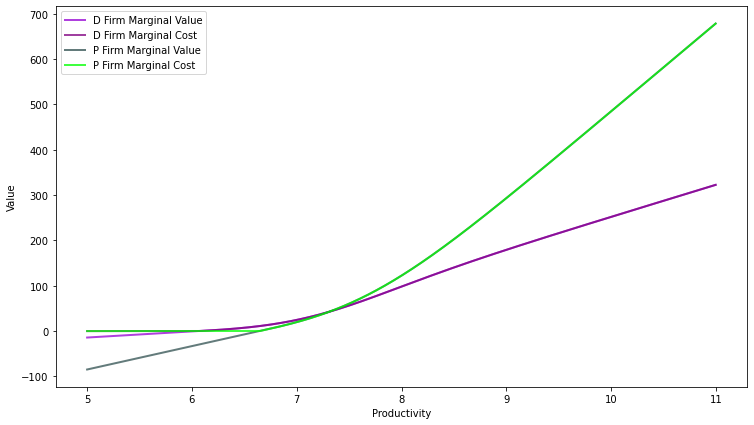

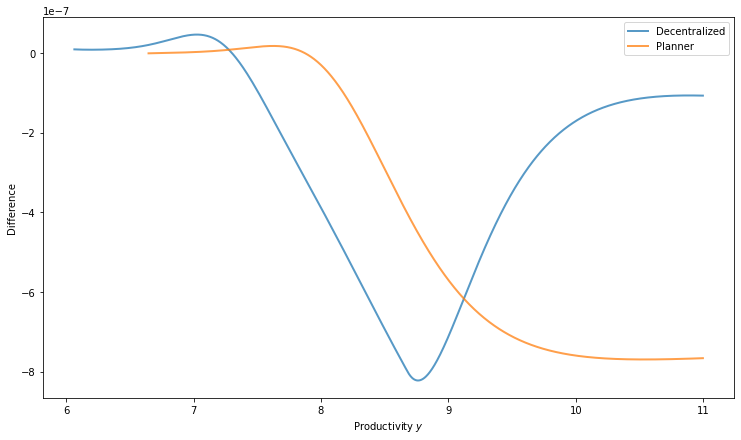

In [2]:
# Running previous code if I want to change things
save = True
folder=r'../../Figures/Python Simulations/Test Calibration 6'
file=r'/'

values = get_parameters(folder + file + "Parameter Values.csv")

[B, r, delta, delta_o, delta_hat, eta, eta_o, phi, alpha, xi,
 y_min, y_max, y_grid_size, o_min, o_max, o_grid_size, b, gamma, gamma_o,
 c_0, c_1, c_o_0, c_o_1, xi, alpha, eta_o_ratio,
 p_1, p_2, tol, max_iter, tol_i, max_iter_i, slow_i] = values

# Make some things integers
y_grid_size, o_grid_size

y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
c_grid = np.exp(c_0  + c_1 * y_grid)
o_grid = np.linspace(o_min, o_max, o_grid_size, endpoint = False)
c_o_grid = np.exp(c_o_0 + c_o_1 * o_grid)

print_skip = 5
ps = 1e4
verbose = True

ooj = OutsourcingOnJob(
    B, b, delta, delta_o, delta_hat, xi, eta, eta_o, phi, alpha,
    y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
    gamma, gamma_o, c_grid, c_o_grid
)

# Record initial guesses
v_grid = np.ones(y_grid_size) / y_grid_size
n_grid = np.ones(y_grid_size) / y_grid_size
v_hat_grid = np.ones(y_grid_size) / y_grid_size
n_hat_grid = np.ones(y_grid_size) / y_grid_size
v_o_grid = np.ones(o_grid_size) / o_grid_size
n_o_grid = np.ones(o_grid_size) / o_grid_size
y_hat = (y_max + y_min) / 2
R_grid = np.minimum(np.arange(y_grid_size), o_grid_size - 1, dtype=np.int64)
R_o_grid = np.minimum(np.arange(o_grid_size), y_grid_size - 1, dtype=np.int64)
lam_grid = np.zeros(y_grid_size)
iota_grid = np.zeros(o_grid_size)

# Run decentralized first
guess = (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid,
           y_hat, R_grid, R_o_grid)

(v_grid, v_hat_grid, v_o_grid, n_grid,
 n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p) = find_p(
    ooj, guess, p_1, p_2, tol, max_iter, tol_i, max_iter_i, slow_i, verbose, print_skip
)
                  
solution = (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)

# Solve Planner's problem
guess_p = solution[:-1] + (np.zeros(y_grid_size), np.zeros(o_grid_size),)

rho_1, rho_2 = p - .25, p - 0.5

(v_grid_p, v_hat_grid_p, v_o_grid_p, n_grid_p, n_hat_grid_p, n_o_grid_p,
 y_hat_p, R_grid_p, R_o_grid_p, lam_grid, iota_grid, rho) = find_rho(
    ooj, guess_p, rho_1, rho_2, tol, max_iter, tol_i, max_iter_i, slow_i, verbose, print_skip
)

solution_p = (v_grid_p, v_hat_grid_p, v_o_grid_p, n_grid_p, n_hat_grid_p, n_o_grid_p,
 y_hat_p, R_grid_p, R_o_grid_p, lam_grid, iota_grid, rho)

# Solve the problem without outsourcers (use current model as guess)
guess_ls = v_grid, n_grid

v_grid_ls, n_grid_ls = ls_solve_model(ooj, guess_ls, tol_i, max_iter_i, slow_i, verbose, ps)

solution_ls = v_grid_ls, n_grid_ls

# Solve Planner's problem without outsourcers

guess_ls_p = solution_ls + (np.zeros(y_grid_size),)

v_grid_ls_p, n_grid_ls_p, lam_grid_ls = ls_solve_model_p(
    ooj, guess_ls_p, tol_i, max_iter_i, slow_i, verbose, ps)

solution_ls_p = v_grid_ls_p, n_grid_ls_p, lam_grid_ls

# What if outsourcers had same bargaining power as firms?
ooj_fb = copy.copy(ooj)
ooj_fb.eta_o = ooj_fb.eta

guess_fb = solution[:-1]
p_1_fb, p_2_fb = p, p + .5

(v_grid_fb, v_hat_grid_fb, v_o_grid_fb, n_grid_fb,
 n_hat_grid_fb, n_o_grid_fb, y_hat_fb, R_grid_fb, R_o_grid_fb, p_fb) = find_p(
    ooj_fb, guess_fb, p_1_fb, p_2_fb, tol, max_iter, tol_i, max_iter_i, slow_i, verbose, print_skip
)

solution_fb = (v_grid_fb, v_hat_grid_fb, v_o_grid_fb, n_grid_fb,
 n_hat_grid_fb, n_o_grid_fb, y_hat_fb, R_grid_fb, R_o_grid_fb, p_fb)

# What if workers were more productive (but vacancy costs stayed the same)
mult = 1.5
ooj_mp = OutsourcingOnJob(
    B, b * mult, delta, delta_o, delta_hat, xi, eta, eta_o, phi, alpha,
    y_min * mult, y_max * mult, y_grid_size, o_min, o_max, o_grid_size,
    gamma, gamma_o, c_grid, c_o_grid
)

guess_mp = solution[:-1]
p_1_mp, p_2_mp = p * mult, (p + .5) * mult

(v_grid_mp, v_hat_grid_mp, v_o_grid_mp, n_grid_mp,
 n_hat_grid_mp, n_o_grid_mp, y_hat_mp, R_grid_mp, R_o_grid_mp, p_mp) = find_p(
    ooj_mp, guess_mp, p_1_mp, p_2_mp, tol, max_iter, tol_i, max_iter_i, slow_i, verbose, print_skip
)

solution_mp = (v_grid_mp, v_hat_grid_mp, v_o_grid_mp, n_grid_mp,
 n_hat_grid_mp, n_o_grid_mp, y_hat_mp, R_grid_mp, R_o_grid_mp, p_mp)

comp_no_outsourcers(ooj, solution, solution_p, solution_ls, solution_ls_p, save=save, file=file, folder=folder)

comp_full_bargain(ooj, solution, solution_fb, save=save, file=file, folder=folder)

comp_more_productive(ooj, ooj_mp, solution, solution_mp, mult, save=save, file=file, folder=folder)

Excess Demand for rho 7.499797409459245 is 0.0000; QS is 0.0000; QD is 0.0000
Excess Demand for rho 7.999797409459245 is 0.0000; QS is 0.0000; QD is 0.0000
Excess Demand at iter 0 is 0.0000; rho is 4.6659; QS is 0.0000; QD is 0.0000 y_hat is 11.0000
Converged in 1 iterations, Excess Demand is 0.0000; price is 4.6659; QS is 0.0000; QD is 0.0000


C:\Users\spspi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2647: RuntimeWarning: invalid value encountered in double_scalars



        Comparing to Planner's Problem with Outsourcers
        Unemployment: decentralized 0.1253; Planner's 0.1629; dif 29.9719
        UE Rate: decentralized 0.0275; Planner's 0.0201; dif -26.9712
        EE Rate: decentralized 0.0021; Planner's nan; dif nan
        Per New Jobs from Unemployment: decentralized 65.6792; Planner's nan;
        dif nan
        Firms Worker Finding Probability: decentralized 0.4225; Planner's 0.9480; 
        dif 124.3960
        Indifferent firm y_hat: decentralized 8.2190; Planner's 11.0000;
        dif 33.8362
        Price of Outsourcing: decentralized 7.9998; Planner's 4.6659; dif -41.6745
        Percent of Vacancies Outsourced: decentralized 0.0843; Planner's 0.0000;
        dif -100.0000
        Percent of Jobs Outsourced: decentralized 0.0733; Planner's 0.0000;
        dif -100.0000
        Total Vacancies: decentralized 0.0202; Planner's 0.0072;
        dif -64.3615
        Market Tightness: decentralized 0.0651; Planner's 0.0212;
        di

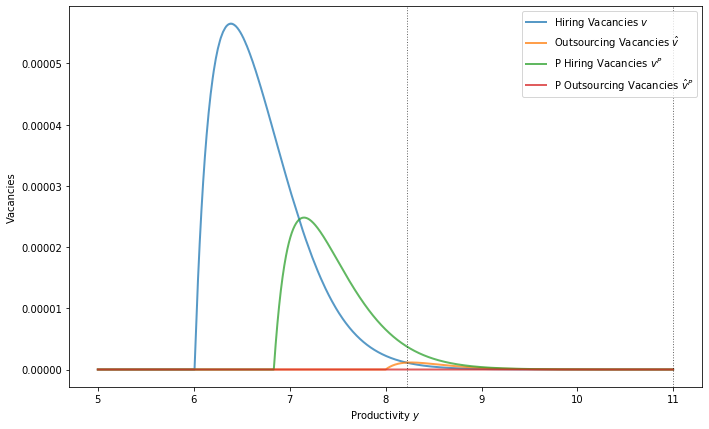

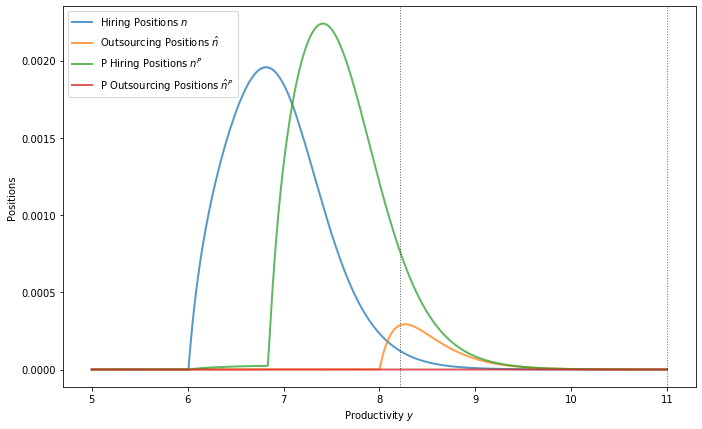

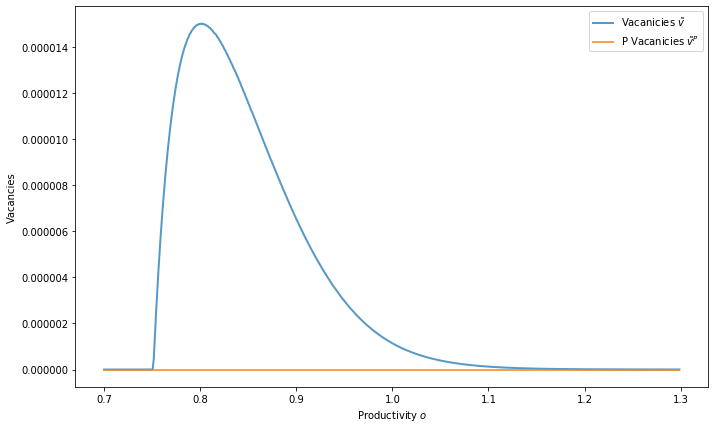

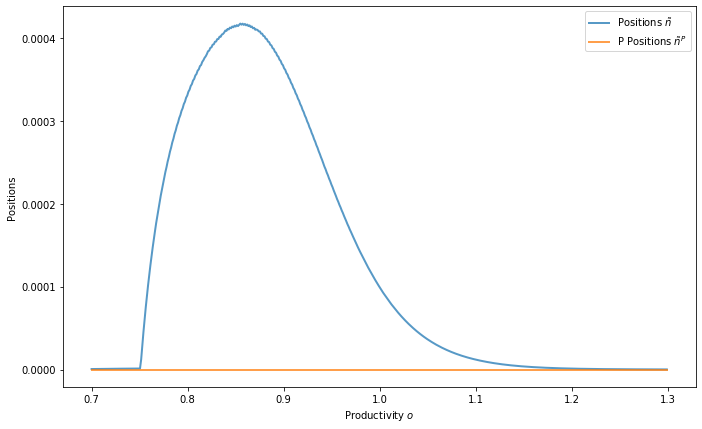

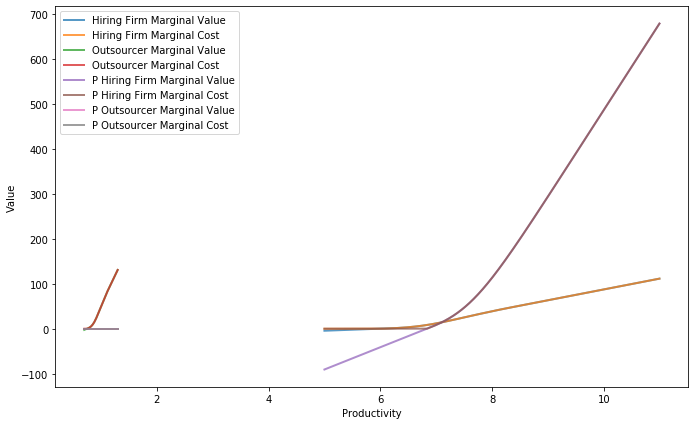

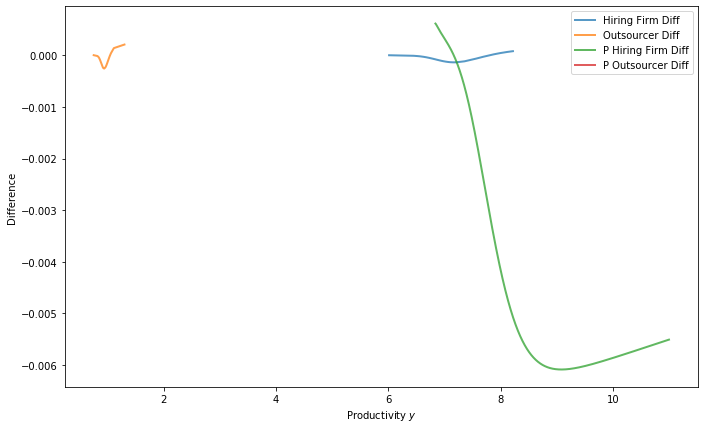

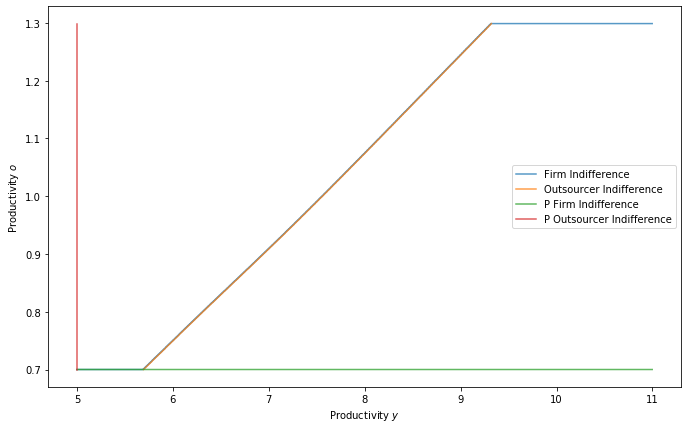

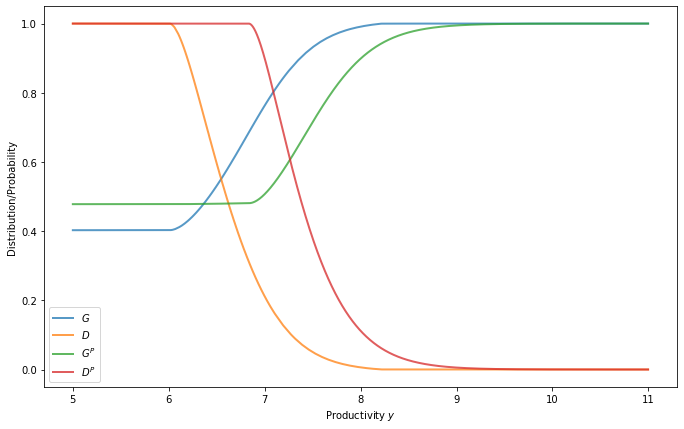

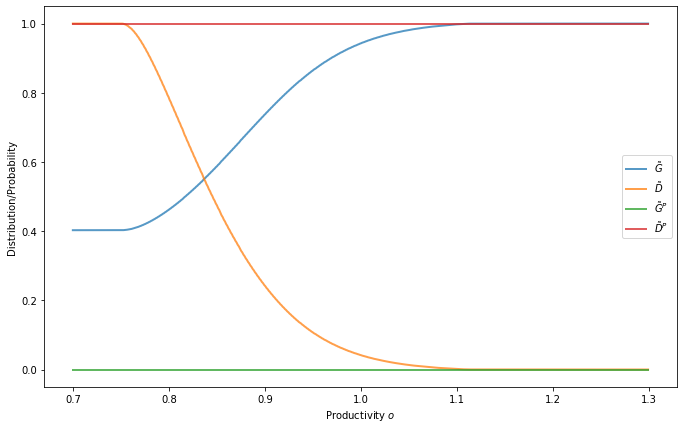

In [12]:
# Solve Planner's problem
max_iter = 5
print_skip = 2

guess_p = solution[:-1] + (np.zeros(y_grid_size), np.zeros(o_grid_size),)

rho_1, rho_2 = p, p - 0.5

(v_grid_p, v_hat_grid_p, v_o_grid_p, n_grid_p, n_hat_grid_p, n_o_grid_p,
 y_hat_p, R_grid_p, R_o_grid_p, lam_grid, iota_grid, rho) = find_rho(
    ooj, guess_p, rho_1, rho_2, tol, max_iter, tol_i, max_iter_i, slow_i, verbose, print_skip
)

solution_p = (v_grid_p, v_hat_grid_p, v_o_grid_p, n_grid_p, n_hat_grid_p, n_o_grid_p,
 y_hat_p, R_grid_p, R_o_grid_p, lam_grid, iota_grid, rho)

In [2]:
# Use pandas to get data for model parameters
parameters = pd.read_csv("../data_moments.csv")

values = parameters[["value"]].to_numpy().T[0]

[r, B, zeta, pi, UE, EU_h, EU_o, EE_h, EE_o, w_mean, w_o_mean, w_sd, w_o_sd] = values

# Job loss probabilities
delta_ = EU_h
delta_o = EU_o
# (This one arbitrary)
delta_hat = EU_h

# Job finding probability
# phi = UE
# phi = 0.2

# Unemployment benefit
w_mean_overall = (1 - zeta) * w_mean + zeta * w_o_mean
# b = 0.4 * w_mean_overall # Shimer (2005) and Hall (2005)
b = 0.71 * w_mean_overall # Hall and Milgrom (2008) and Pissarides (2009)

# Arbitrary
# alpha = 0.72 # Shimer (2005)
alpha = 0.5 # Petrongolo and Pissarides (2001)
eta = alpha # Hosios Rule

gamma = 2
gamma_o = 2

# Arbitrary (but try to cover w_grid)
y_grid_size = 1000
o_grid_size = 500

# # Initial guesses (alpha = .72, b = 0.71)
# y_min = 5.0
# y_max = 11.0
# o_min = 0.7
# o_max = 1.3
# c_0_guess = -20.03
# c_1_guess = 3.77
# c_o_0_guess = -16.63
# c_o_1_guess = 26.80
# xi_guess = 0.212
# phi_guess = 0.0590
# eta_o_ratio_guess = 0.784

# # Give resonable bounds for parameters
# bounds = [(-20, -5), (2.5, 4), (-12, -0), (8, 20), (0.10, 0.30), (0.025, 0.20), (0.8, 1.2)]

# Initial guesses (alpha = .5, b = 0.71)
y_min = 5.0
y_max = 11.0
o_min = 0.7
o_max = 1.3
# c_0_guess = -13.37
# c_1_guess = 2.87
# c_o_0_guess = -17.38
# c_o_1_guess = 28.63
# xi_guess = 0.21
# phi_guess = 0.11
# eta_o_ratio_guess = 1.19

# c_0_guess = -16.01811921832851
# c_1_guess = 3.012321187997318
# c_o_0_guess = -16.074475793631287
# c_o_1_guess = 26.976020671837386
# xi_guess = 0.21
# phi_guess = 0.16
# eta_o_ratio_guess = 1

c_0_guess = -12.0681311388261
c_1_guess = 2.787275519440465
c_o_0_guess = -15.570373514293447
c_o_1_guess = 26.258082959144954
xi_guess = 0.21507527305390278
phi_guess = 0.13459885546828323
eta_o_ratio_guess = 1.0994580358809687

# Give resonable bounds for parameters
bounds = [(-20, -10), (2.5, 3.5), (-20, -10), (20, 30), (0.15, 0.25), (0.05, 0.2), (0.8, 1.2)]

x_0 = np.empty(7)
x_0[0], x_0[1] = c_0_guess, c_1_guess
x_0[2], x_0[3] = c_o_0_guess, c_o_1_guess
x_0[4] = xi_guess
x_0[5] = phi_guess
x_0[6] = eta_o_ratio_guess

# Try to match
match = np.empty(7)
match[0] = w_mean
match[1] = w_sd
match[2] = w_o_mean
match[3] = w_o_sd
match[4] = zeta * EE_h + (1 - zeta) * EE_o
match[5] = zeta
match[6] = UE

In [5]:
x_0, match, bounds

(array([-11.  ,   2.6 , -14.  ,  25.  ,   0.21,   0.13,   0.81]),
 array([6.67180073e+00, 3.77297803e-01, 6.58585908e+00, 3.94337061e-01,
        2.03909195e-03, 7.23291445e-02, 2.77639108e-02]),
 [(-20, -5),
  (2, 3.5),
  (-25, -15),
  (20, 30),
  (0.15, 0.25),
  (0.03, 0.15),
  (0.7, 1.3)])

In [3]:
# Set up minimization problem
p_1_0 = y_max - 3
p_2_0 = y_max - 3.5
tol = 1e-3
max_iter = 15
tol_i = 1e-6
max_iter_i = 1e5
slow_i = 1.5e-1
print_skip = 5
verbose = False

# Record initial guesses
v_grid_0 = np.ones(y_grid_size) / y_grid_size
n_grid_0 = np.ones(y_grid_size) / y_grid_size * 0.1
v_hat_grid_0 = np.ones(y_grid_size) / y_grid_size
n_hat_grid_0 = np.ones(y_grid_size) / y_grid_size * 0.1
v_o_grid_0 = np.ones(o_grid_size) / o_grid_size
n_o_grid_0 = np.ones(o_grid_size) / o_grid_size * 0.1
y_hat_0 = y_max
R_grid_0 = np.minimum(np.arange(y_grid_size), o_grid_size - 1, dtype=np.int64)
R_o_grid_0 = np.minimum(np.arange(o_grid_size), y_grid_size - 1, dtype=np.int64)

guess_0 = (v_grid_0, v_hat_grid_0, v_o_grid_0, n_grid_0, n_hat_grid_0, n_o_grid_0, y_hat_0, R_grid_0, R_o_grid_0)
guess = copy.copy(guess_0)
p_1 = np.copy(p_1_0)
p_2 = np.copy(p_2_0)


# Put weights here so I can show them later
weights = np.ones_like(x_0) / len(x_0)
# If I want to up weight wage mean moments and downweight wage variance
weights[0] = 15 / (8 * len(x_0))
weights[1] = 15 / (8 * len(x_0))
weights[2] = 1 / (8 * len(x_0))
weights[3] = 1 / (8 * len(x_0))

def match_operator_factory(match, weights):  
     
    w_mean_data = match[0] 
    w_sd_data = match[1]
    w_o_mean_data = match[2]
    w_o_sd_data = match[3]
    EE_data = match[4] 
    zeta_data = match[5] 
    UE_data = match[6]
    
    y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint=False)
    o_grid = np.linspace(o_min, o_max, o_grid_size, endpoint=False)
    
    def func(x):

        global guess, p_1, p_2

        c_grid = np.exp(x[0] + x[1] * y_grid)
        c_o_grid = np.exp(x[2] + x[3] * o_grid)
        xi = x[4]
        phi = x[5]
        eta_o = eta * x[6]
        xi_bar, xi_bar_o = xi * (1 - delta_), xi * (1 - delta_o)

        ooj = OutsourcingOnJob(
            B, b, delta_, delta_o, delta_hat, xi, eta, eta_o, phi, alpha,
            y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
            gamma, gamma_o, c_grid, c_o_grid
        )

        (v_grid, v_hat_grid, v_o_grid, n_grid,
         n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p) = find_p(
            ooj, guess, p_1, p_2, tol, max_iter, tol_i, max_iter_i, slow_i, False, print_skip
        )

        guess = (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid)
        p_2, p_1 = p, p + 0.01

        _, _, QD_QS_ED, make_grids, find_y_i, _, _, _, _, _, _, _, ell  = operator_factory(ooj)
        
        QD, QS, ED = QD_QS_ED(n_hat_grid, n_o_grid, y_hat)
        
        # If the model does not converge, do not use, reset guess
        if np.abs(ED) > tol:
            print(f"c_0 {x[0]:.2f}; c_1 {x[1]:.2f}; c_o_0 {x[2]:.2f};",
                  f" c_o_1 {x[3]:.2f}; xi {x[4]:.2f}; phi {x[5]:.2f}; eta_o {x[6]:.2f}")
            p_2, p_1 = np.copy(p_2_0), np.copy(p_1_0)
            
            guess = copy.copy(guess_0)
            return np.abs(ED) * 1e10

        (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
         Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
        )

        rm, rm_o = ooj.rm, ooj.rm_o

        y_i = find_y_i(y_hat)
        
        # Find the average wage: compare to mean in data
        n = np.sum(n_grid[:y_i] * rm)
        n_o = np.sum(n_o_grid * rm_o)
        w_mean = np.sum(w_grid[:y_i] * n_grid[:y_i] * rm) / n
        w_o_mean = np.sum(w_o_grid * n_o_grid * rm_o) / n_o
        
        err_w = percent_diff(w_mean, w_mean_data)
        err_w_o = percent_diff(w_o_mean, w_o_mean_data)
        
        # Find standard deviation of wages, compare to data
        w_sd = np.sqrt(np.sum((w_grid[:y_i] - w_mean)**2 * n_grid[:y_i] * rm) / n)
        w_o_sd = np.sqrt(np.sum((w_o_grid - w_o_mean)**2 * n_o_grid * rm_o) / n_o)
        
        err_sd = percent_diff(w_sd, w_sd_data)
        err_sd_o = percent_diff(w_o_sd, w_o_sd_data)
        
        # Find share of vacancies outsourcing, compare to data
        zeta = n_o / (n_o + n)
        ee_h = np.sum(n_grid[:y_i] * xi_bar * ell(theta) * D_grid[:y_i] * rm) / n
        ee_o = np.sum(n_o_grid * xi_bar_o * ell(theta) * D_o_grid * rm_o) / n_o
        ee = ((1 - zeta) * ee_h + zeta * ee_o)
        UE = ell(theta)
        
        err_ee = percent_diff(ee, EE_data)
        err_zeta = percent_diff(zeta, zeta_data)
        err_UE = percent_diff(UE, UE_data)
        
        errs = np.array([err_w, err_w_o, err_sd, err_sd_o, err_ee, err_zeta, err_UE])
        
        err = np.sum(weights * errs**2)
        
        # If eqbm u > .14, (cost of entry too high, not enough firms) then add 1e5 to err
        # Also have high error if w_o_mean > w_mean
        u = 1 - n - n_o
#         err = err + (u > .14) * 1e5 + (w_o_mean > w_mean) * 1e5
        err = err + (u > .14) * 1e3

        print(f"""
        Error: w_mean {err_w:.5f}; w_o_mean {err_w_o:.5f}; w_sd {err_sd:.5f}; w_o_sd {err_sd_o:.5f};
        EE {err_ee:.5f}; zeta {err_zeta:.5f}; UE {err_UE:.5f}; u {u:.3f};
        Overall {err:.5f}  
        Parameters: c_0 {x[0]:.2f}; c_1 {x[1]:.2f}; c_o_0 {x[2]:.2f}; 
        c_o_1 {x[3]:.2f}; xi {x[4]:.2f}; phi {x[5]:.2f}; eta_o {x[6]:.2f}
        """)
        
        return err
    
    return func

In [4]:
# Minimize
func = match_operator_factory(match, weights)

method = "Nelder-Mead"
# method = "Powell"

if method == "Powell":
#     result = minimize(func, x0=x_0, method=method, bounds=bounds, options={"maxiter":3, "disp":True})
    result = minimize(func, x0=x_0, method=method, bounds=bounds, options={"maxiter":10, "disp":True})
if method == "Nelder-Mead":
#     result = minimize(func, x0=x_0, method=method, options={"maxiter":50, "disp":True})
#     result = minimize(func, x0=x_0, method=method, options={"maxiter":100, "disp":True})
    result = minimize(func, x0=x_0, method=method, options={"maxiter":400, "disp":True})
    
result

Converged in 2 iterations, Excess Demand is 0.0008; price is 7.9227; QS is 0.0565; QD is 0.0573

        Error: w_mean 0.88105; w_o_mean 1.31009; w_sd -7.28137; w_o_sd -5.60099;
        EE 0.38230; zeta -0.18229; UE -1.65154; u 0.125;
        Overall 2.58988  
        Parameters: c_0 -12.07; c_1 2.79; c_o_0 -15.57; 
        c_o_1 26.26; xi 0.22; phi 0.13; eta_o 1.10
        
Converged in 3 iterations, Excess Demand is -0.0001; price is 8.1662; QS is 0.0571; QD is 0.0570

        Error: w_mean 2.89789; w_o_mean 3.57897; w_sd -3.94727; w_o_sd -1.17449;
        EE 6.77395; zeta 0.60661; UE 6.96691; u 0.116;
        Overall 19.52499  
        Parameters: c_0 -12.67; c_1 2.79; c_o_0 -15.57; 
        c_o_1 26.26; xi 0.22; phi 0.13; eta_o 1.10
        
Converged in 3 iterations, Excess Demand is -0.0001; price is 7.5040; QS is 0.0506; QD is 0.0505

        Error: w_mean -2.83752; w_o_mean -2.37254; w_sd -14.86244; w_o_sd -13.34599;
        EE -7.98197; zeta -10.57294; UE -12.43161; u 0.138;
 

Converged in 3 iterations, Excess Demand is 0.0003; price is 8.2023; QS is 0.0608; QD is 0.0611

        Error: w_mean 3.60905; w_o_mean 4.19602; w_sd -1.76636; w_o_sd 1.13142;
        EE 8.11157; zeta 7.02702; UE 7.31277; u 0.116;
        Overall 32.37686  
        Parameters: c_0 -12.24; c_1 2.72; c_o_0 -15.64; 
        c_o_1 26.27; xi 0.22; phi 0.14; eta_o 1.11
        
Converged in 2 iterations, Excess Demand is -0.0004; price is 7.8432; QS is 0.0545; QD is 0.0541

        Error: w_mean 0.18499; w_o_mean 0.69902; w_sd -8.53827; w_o_sd -6.48860;
        EE -0.21451; zeta -3.82414; UE -3.11083; u 0.127;
        Overall 5.67188  
        Parameters: c_0 -12.15; c_1 2.82; c_o_0 -15.58; 
        c_o_1 26.29; xi 0.22; phi 0.14; eta_o 1.11
        
Converged in 2 iterations, Excess Demand is 0.0000; price is 7.9569; QS is 0.0482; QD is 0.0482

        Error: w_mean 1.00508; w_o_mean 1.54157; w_sd -6.11889; w_o_sd -4.54013;
        EE 1.67163; zeta -14.60218; UE -0.99530; u 0.124;
        

Converged in 2 iterations, Excess Demand is 0.0003; price is 7.9562; QS is 0.0566; QD is 0.0569

        Error: w_mean 0.99754; w_o_mean 1.42677; w_sd -5.60020; w_o_sd -3.76877;
        EE 4.28034; zeta 0.15206; UE -0.60612; u 0.124;
        Overall 4.29861  
        Parameters: c_0 -12.14; c_1 2.79; c_o_0 -15.57; 
        c_o_1 26.26; xi 0.22; phi 0.13; eta_o 1.10
        
Converged in 2 iterations, Excess Demand is 0.0002; price is 7.9043; QS is 0.0568; QD is 0.0570

        Error: w_mean 0.93188; w_o_mean 1.60562; w_sd -7.92192; w_o_sd -4.77877;
        EE -0.45049; zeta 0.06769; UE -1.33415; u 0.125;
        Overall 2.73553  
        Parameters: c_0 -12.10; c_1 2.80; c_o_0 -15.59; 
        c_o_1 26.25; xi 0.21; phi 0.14; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9142; QS is 0.0554; QD is 0.0553

        Error: w_mean 0.88039; w_o_mean 1.56120; w_sd -7.58641; w_o_sd -4.55351;
        EE -0.33503; zeta -2.21534; UE -1.69894; u 0.125;
        

Converged in 2 iterations, Excess Demand is 0.0001; price is 7.9323; QS is 0.0569; QD is 0.0570

        Error: w_mean 0.92821; w_o_mean 1.55046; w_sd -7.18657; w_o_sd -4.43695;
        EE 0.56561; zeta 0.65701; UE -1.44913; u 0.125;
        Overall 2.55586  
        Parameters: c_0 -12.11; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.22; phi 0.13; eta_o 1.12
        
Converged in 1 iterations, Excess Demand is 0.0003; price is 7.9191; QS is 0.0567; QD is 0.0570

        Error: w_mean 0.95580; w_o_mean 1.57313; w_sd -7.53166; w_o_sd -4.79815;
        EE 0.06603; zeta 0.12487; UE -1.29859; u 0.125;
        Overall 2.57541  
        Parameters: c_0 -12.11; c_1 2.79; c_o_0 -15.59; 
        c_o_1 26.25; xi 0.21; phi 0.14; eta_o 1.12
        
Converged in 1 iterations, Excess Demand is -0.0002; price is 7.9234; QS is 0.0568; QD is 0.0567

        Error: w_mean 1.02874; w_o_mean 1.85505; w_sd -7.22143; w_o_sd -3.28301;
        EE 1.05151; zeta 0.16636; UE -0.78951; u 0.124;
        Ove

Converged in 1 iterations, Excess Demand is -0.0003; price is 7.9263; QS is 0.0567; QD is 0.0564

        Error: w_mean 0.93984; w_o_mean 1.60106; w_sd -7.23285; w_o_sd -4.29339;
        EE 0.58693; zeta 0.20828; UE -1.33060; u 0.125;
        Overall 2.49490  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.12
        
Converged in 1 iterations, Excess Demand is 0.0001; price is 7.9271; QS is 0.0567; QD is 0.0568

        Error: w_mean 0.96101; w_o_mean 1.62643; w_sd -7.23011; w_o_sd -4.24387;
        EE 0.61962; zeta 0.13165; UE -1.25602; u 0.125;
        Overall 2.49371  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.25; xi 0.21; phi 0.14; eta_o 1.12
        
Converged in 1 iterations, Excess Demand is 0.0003; price is 7.9294; QS is 0.0566; QD is 0.0569

        Error: w_mean 0.84464; w_o_mean 1.55165; w_sd -7.31899; w_o_sd -4.13644;
        EE 0.69742; zeta 0.01147; UE -1.65249; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9277; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95337; w_o_mean 1.63523; w_sd -7.24936; w_o_sd -4.17582;
        EE 0.51542; zeta 0.18727; UE -1.32524; u 0.125;
        Overall 2.50340  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9278; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95642; w_o_mean 1.64481; w_sd -7.25440; w_o_sd -4.14963;
        EE 0.51198; zeta 0.14078; UE -1.31169; u 0.125;
        Overall 2.50299  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0001; price is 7.9283; QS is 0.0567; QD is 0.0568

        Error: w_mean 0.96381; w_o_mean 1.65762; w_sd -7.25773; w_o_sd -4.10746;
        EE 0.53556; zeta 0.12529; UE -1.27124; u 0.125;
        Ov

Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9283; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95709; w_o_mean 1.64021; w_sd -7.25240; w_o_sd -4.16814;
        EE 0.51750; zeta 0.19686; UE -1.31037; u 0.125;
        Overall 2.50454  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9283; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95829; w_o_mean 1.64265; w_sd -7.25374; w_o_sd -4.16429;
        EE 0.51768; zeta 0.18184; UE -1.30479; u 0.125;
        Overall 2.50421  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9282; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95575; w_o_mean 1.63664; w_sd -7.25213; w_o_sd -4.17866;
        EE 0.51250; zeta 0.19229; UE -1.31794; u 0.125;
        Ov

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9283; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95587; w_o_mean 1.63731; w_sd -7.25347; w_o_sd -4.17944;
        EE 0.50989; zeta 0.17374; UE -1.31619; u 0.125;
        Overall 2.50318  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9282; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95687; w_o_mean 1.63819; w_sd -7.25375; w_o_sd -4.17730;
        EE 0.51770; zeta 0.19225; UE -1.30849; u 0.125;
        Overall 2.50345  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9282; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95629; w_o_mean 1.63860; w_sd -7.25365; w_o_sd -4.17311;
        EE 0.51477; zeta 0.17562; UE -1.31240; u 0.125;
        Ov

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9281; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95604; w_o_mean 1.63805; w_sd -7.25186; w_o_sd -4.17929;
        EE 0.51539; zeta 0.16064; UE -1.31380; u 0.125;
        Overall 2.50276  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9281; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95597; w_o_mean 1.63778; w_sd -7.25180; w_o_sd -4.18056;
        EE 0.51392; zeta 0.15876; UE -1.31512; u 0.125;
        Overall 2.50285  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9281; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95594; w_o_mean 1.63788; w_sd -7.25182; w_o_sd -4.17933;
        EE 0.51449; zeta 0.16465; UE -1.31482; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95572; w_o_mean 1.63781; w_sd -7.25152; w_o_sd -4.17853;
        EE 0.51449; zeta 0.15731; UE -1.31591; u 0.125;
        Overall 2.50269  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95578; w_o_mean 1.63794; w_sd -7.25164; w_o_sd -4.17795;
        EE 0.51472; zeta 0.15897; UE -1.31540; u 0.125;
        Overall 2.50270  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95573; w_o_mean 1.63795; w_sd -7.25177; w_o_sd -4.17748;
        EE 0.51412; zeta 0.15828; UE -1.31583; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95567; w_o_mean 1.63795; w_sd -7.25153; w_o_sd -4.17667;
        EE 0.51464; zeta 0.15777; UE -1.31602; u 0.125;
        Overall 2.50260  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63797; w_sd -7.25159; w_o_sd -4.17675;
        EE 0.51472; zeta 0.15821; UE -1.31583; u 0.125;
        Overall 2.50261  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63796; w_sd -7.25156; w_o_sd -4.17674;
        EE 0.51451; zeta 0.15720; UE -1.31603; u 0.125;
        Ov

Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25157; w_o_sd -4.17709;
        EE 0.51455; zeta 0.15799; UE -1.31596; u 0.125;
        Overall 2.50264  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25158; w_o_sd -4.17717;
        EE 0.51453; zeta 0.15783; UE -1.31594; u 0.125;
        Overall 2.50264  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17714;
        EE 0.51448; zeta 0.15769; UE -1.31598; u 0.125;
        O

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25155; w_o_sd -4.17776;
        EE 0.51449; zeta 0.15752; UE -1.31595; u 0.125;
        Overall 2.50266  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17718;
        EE 0.51449; zeta 0.15800; UE -1.31596; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51450; zeta 0.15798; UE -1.31594; u 0.125;
        Ov

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63789; w_sd -7.25155; w_o_sd -4.17776;
        EE 0.51448; zeta 0.15757; UE -1.31596; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17718;
        EE 0.51449; zeta 0.15806; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17776;
        EE 0.51448; zeta 0.15755; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25155; w_o_sd -4.17776;
        EE 0.51449; zeta 0.15756; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17718;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25155; w_o_sd -4.17776;
        EE 0.51449; zeta 0.15756; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25155; w_o_sd -4.17776;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15806; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25155; w_o_sd -4.17776;
        EE 0.51449; zeta 0.15757; UE -1.31596; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17776;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Overall 2.50267  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95569; w_o_mean 1.63794; w_sd -7.25159; w_o_sd -4.17719;
        EE 0.51449; zeta 0.15807; UE -1.31595; u 0.125;
        Overall 2.50265  
        Parameters: c_0 -12.12; c_1 2.79; c_o_0 -15.58; 
        c_o_1 26.26; xi 0.21; phi 0.13; eta_o 1.13
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9280; QS is 0.0567; QD is 0.0567

        Error: w_mean 0.95570; w_o_mean 1.63789; w_sd -7.25156; w_o_sd -4.17777;
        EE 0.51448; zeta 0.15757; UE -1.31595; u 0.125;
        Ove

 final_simplex: (array([[-12.11902118,   2.79216397, -15.57690097,  26.25536701,
          0.21467898,   0.13492344,   1.1268192 ],
       [-12.11902118,   2.79216397, -15.57690097,  26.25536701,
          0.21467898,   0.13492344,   1.1268192 ],
       [-12.11902118,   2.79216397, -15.57690097,  26.25536701,
          0.21467898,   0.13492344,   1.1268192 ],
       [-12.11902118,   2.79216397, -15.57690097,  26.25536701,
          0.21467898,   0.13492344,   1.1268192 ],
       [-12.11902118,   2.79216397, -15.57690097,  26.25536701,
          0.21467898,   0.13492344,   1.1268192 ],
       [-12.11902118,   2.79216397, -15.57690097,  26.25536701,
          0.21467898,   0.13492344,   1.1268192 ],
       [-12.11902118,   2.79216397, -15.57690097,  26.25536701,
          0.21467898,   0.13492344,   1.1268192 ],
       [-12.11902118,   2.79216397, -15.57690097,  26.25536701,
          0.21467898,   0.13492344,   1.1268192 ]]), array([2.47262817, 2.50265351, 2.50265351, 2.50265351, 2.5026

In [ ]:
# Run model with final results
y_grid_size = 2000
o_grid_size = 1000

y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint=False)
o_grid = np.linspace(o_min, o_max, o_grid_size, endpoint=False)

c_grid = np.exp(result.x[0] + y_grid * result.x[1])
c_o_grid = np.exp(result.x[2] + o_grid * result.x[3])
xi = result.x[4]
phi = result.x[5]
eta_o = eta * result.x[6]

# Record initial guesses
v_grid_0 = np.ones(y_grid_size) / y_grid_size
n_grid_0 = np.ones(y_grid_size) / y_grid_size
v_hat_grid_0 = np.ones(y_grid_size) / y_grid_size
n_hat_grid_0 = np.ones(y_grid_size) / y_grid_size
v_o_grid_0 = np.ones(o_grid_size) / o_grid_size
n_o_grid_0 = np.ones(o_grid_size) / o_grid_size
y_hat_0 = y_max
R_grid_0 = np.minimum(np.arange(y_grid_size), o_grid_size - 1, dtype=np.int64)
R_o_grid_0 = np.minimum(np.arange(o_grid_size), y_grid_size - 1, dtype=np.int64)

guess_0 = (v_grid_0, v_hat_grid_0, v_o_grid_0, n_grid_0, n_hat_grid_0, n_o_grid_0, y_hat_0, R_grid_0, R_o_grid_0)

tol = 1e-4
max_iter = 25
tol_i = 1e-8
max_iter_i = 1e5
slow_i = 1e-1
print_skip = 5
ps = 1e4
verbose = True
compare = True

save = True
# save = False

ooj = OutsourcingOnJob(
    B, b, delta_, delta_o, delta_hat, xi, eta, eta_o, phi, alpha,
    y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
    gamma, gamma_o, c_grid, c_o_grid
)

(v_grid, v_hat_grid, v_o_grid, n_grid,
 n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p) = find_p(
    ooj, guess_0, p_1_0, p_2_0, tol, max_iter, tol_i, max_iter_i, slow_i, verbose, print_skip
)

folder=r'../Python Simulations/Test Calibration 6'
file=r'/'
f = None
csv_path = folder + file + "Parameter Values.csv"

if save:
    os.mkdir(folder)
    f = open(folder + file + "Details.txt", "w")
    if method != "Powell":
        bounds = None
        
    save_parameters(ooj, f, p_1, p_2, tol, max_iter, tol_i, max_iter_i, slow_i, result=result, method=method,
                    bounds=bounds, weights=weights, csv_path=csv_path)

solution = (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)

# Solve Planner's problem
guess_p = solution[:-1] + (np.zeros(y_grid_size), np.zeros(o_grid_size),)

rho_1, rho_2 = p - .25, p - 0.5

(v_grid_p, v_hat_grid_p, v_o_grid_p, n_grid_p, n_hat_grid_p, n_o_grid_p,
 y_hat_p, R_grid_p, R_o_grid_p, lam_grid, iota_grid, rho) = find_rho(
    ooj, guess_p, rho_1, rho_2, tol, max_iter, tol_i, max_iter_i, slow_i, verbose, print_skip
)

solution_p = (v_grid_p, v_hat_grid_p, v_o_grid_p, n_grid_p, n_hat_grid_p, n_o_grid_p,
 y_hat_p, R_grid_p, R_o_grid_p, lam_grid, iota_grid, rho)

# Solve the problem without outsourcers (use current model as guess)
guess_ls = v_grid, n_grid

v_grid_ls, n_grid_ls = ls_solve_model(ooj, guess_ls, tol_i, max_iter_i, slow_i, verbose, ps)

solution_ls = v_grid_ls, n_grid_ls

# Solve Planner's problem without outsourcers
guess_ls_p = solution_ls + (np.zeros(y_grid_size),)

v_grid_ls_p, n_grid_ls_p, lam_grid_ls = ls_solve_model_p(
    ooj, guess_ls_p, tol_i, max_iter_i, slow_i, verbose, ps)

solution_ls_p = v_grid_ls_p, n_grid_ls_p, lam_grid_ls

# Solve problem when workers have full bargaining power with outsourcer
ooj_fb = copy.copy(ooj)
ooj_fb.eta_o = ooj_fb.eta

guess_fb = solution[:-1]
p_1_fb, p_2_fb = p, p + .5

(v_grid_fb, v_hat_grid_fb, v_o_grid_fb, n_grid_fb,
 n_hat_grid_fb, n_o_grid_fb, y_hat_fb, R_grid_fb, R_o_grid_fb, p_fb) = find_p(
    ooj_fb, guess_fb, p_1_fb, p_2_fb, tol, max_iter, tol_i, max_iter_i, slow_i, verbose, print_skip
)

solution_fb = (v_grid_fb, v_hat_grid_fb, v_o_grid_fb, n_grid_fb,
 n_hat_grid_fb, n_o_grid_fb, y_hat_fb, R_grid_fb, R_o_grid_fb, p_fb)

# What if workers were more productive (but vacancy costs stayed the same)
mult = 1.5
ooj_mp = OutsourcingOnJob(
    B, b * mult, delta, delta_o, delta_hat, xi, eta, eta_o, phi, alpha,
    y_min * mult, y_max * mult, y_grid_size, o_min, o_max, o_grid_size,
    gamma, gamma_o, c_grid, c_o_grid
)

guess_mp = solution[:-1]
p_1_mp, p_2_mp = p * mult, (p + .5) * mult

(v_grid_mp, v_hat_grid_mp, v_o_grid_mp, n_grid_mp,
 n_hat_grid_mp, n_o_grid_mp, y_hat_mp, R_grid_mp, R_o_grid_mp, p_mp) = find_p(
    ooj_mp, guess_mp, p_1_mp, p_2_mp, tol, max_iter, tol_i, max_iter_i, slow_i, verbose, print_skip
)

solution_mp = (v_grid_mp, v_hat_grid_mp, v_o_grid_mp, n_grid_mp,
 n_hat_grid_mp, n_o_grid_mp, y_hat_mp, R_grid_mp, R_o_grid_mp, p_mp)

list_facts(ooj, solution, f=f, compare=compare)

cdf_comp(ooj, solution, save=save, folder=folder, file=file)

graph_results(ooj, solution, save=save, folder=folder, file=file)

comp_no_outsourcers(ooj, solution, solution_p, solution_ls, solution_ls_p,
                   save=save, f=f, folder=folder, file=file)

comp_full_bargain(ooj, solution, solution_fb, save=save, f=f, folder=folder, file=file)

comp_more_productive(ooj, ooj_mp, solution, solution_mp, mult, save=save, f=f, folder=folder, file=file)

if save:
    f.close()

Excess Demand for price 7.5 is 0.2489; QS is 0.0195; QD is 0.2684
Excess Demand for price 8.0 is -0.0237; QS is 0.0671; QD is 0.0434
Excess Demand at iter 0 is -0.0097; price is 7.9565; QS is 0.0605; QD is 0.0509 y_hat is 8.7260
Converged in 3 iterations, Excess Demand is -0.0000; price is 7.9282; QS is 0.0566; QD is 0.0565
Excess Demand for rho 7.428242908270604 is 0.1267; QS is 0.0108; QD is 0.1375
Excess Demand for rho 7.678242908270604 is -0.0202; QS is 0.0205; QD is 0.0002
Excess Demand at iter 0 is -0.0164; rho is 7.6438; QS is 0.0185; QD is 0.0021 y_hat is 10.1660
Excess Demand at iter 5 is -0.0009; rho is 7.5853; QS is 0.0157; QD is 0.0148 y_hat is 9.3980
Converged in 10 iterations, Excess Demand is 0.0001; price is 7.5834; QS is 0.0156; QD is 0.0157
Error at iter 0 is 0.0105
Error at iter 10000 is 0.0000
Converged in 16194 iterations
Error at iter 0 is 0.0089
Error at iter 10000 is 0.0000
Error at iter 20000 is 0.0000
Converged in 24472 iterations
Excess Demand for price 8.428

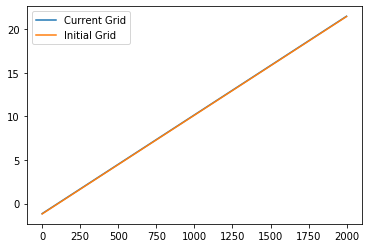

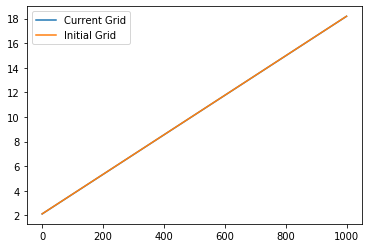

In [6]:
# Plot log c/c_o _grid vs start grids
c_grid_0 = np.exp(x_0[0] + y_grid * x_0[1])
c_o_grid_0 = np.exp(x_0[2] + o_grid * x_0[3])

plt.plot(np.log(c_grid), label = "Current Grid")
plt.plot(np.log(c_grid_0), label= "Initial Grid")
plt.legend()

plt.show()

plt.plot(np.log(c_o_grid), label = "Current Grid")
plt.plot(np.log(c_o_grid_0), label= "Initial Grid")
plt.legend()

plt.show()

In [5]:
# Test function
func = match_operator_factory(match)
func(x_0)

Converged in 5 iterations, Excess Demand is -0.0005; price is 9.7711; QS is 0.1300; QD is 0.1295

        Error: w_mean -0.00208; w_o_mean 0.04324; w_sd 0.58561; w_o_sd 0.72440;
        EE -0.15128; zeta 1.74122; UE 0.10921
        Overall 0.46955  
        Parameters: c_0 -12.00; c_1 2.28; c_o_0 -10.00; 
        c_o_1 18.00; xi 0.15; phi 0.04; eta_o 1.00
        


0.46955428448328096

In [17]:
%debug

> <ipython-input-14-571c4425a3ae>(1281)comp_no_outsourcers()
   1277         Mean Wages: with {w_grid:.2f}; {w_grid_ls:.2f}
   1278         Worker Welfare: with {w_welfare:.0f}; without {w_welfare_ls:.0f}
   1279         Firm Welfare: with {f_welfare:.0f}; without {f_welfare_ls:.0f}
   1280         Total Welfare: with {tot_welfare:.0f}; without {tot_welfare_ls:.0f}
-> 1281         """)

ipdb> tot_welfare
5204.406436460049
ipdb> tot_welfare_ls
5198.535439359514
ipdb> f_welfare
191.91811750583452
ipdb> f_welfare_ls
202.8648715488852
ipdb> w_welfare
5001.29363097702
ipdb> w_welfare_ls
4995.670567810629
ipdb> c


Excess Demand for price 7.5 is 3.2498; QS is 0.0022; QD is 3.2519
Excess Demand for price 8.0 is 0.6446; QS is 0.0066; QD is 0.6512
Excess Demand at iter 0 is 0.4173; price is 8.1237; QS is 0.0091; QD is 0.4263 y_hat is 8.4980
Excess Demand at iter 5 is 0.0004; price is 8.7694; QS is 0.0437; QD is 0.0441 y_hat is 9.3200
Converged in 6 iterations, Excess Demand is 0.0004; price is 8.7694; QS is 0.0437; QD is 0.0441
The indifferent firm is y_hat = 9.32$. Price of outsourcing is 8.77.
Unemployment is 9.26. According to LoM, should be 9.31
Workers match with probability 3.82. Firms/Outsourcers match with probability 44.27
Total vacancies searching for workers are 0.0243. Theta is 0.0862
6 percent of vacancies searching for workers are from outsourcers, 6 percent of postions outsourced
The ue rate is 0.0382, the ee rate is 0.0026,  and 60.360628 of new jobs are from unemployment
Checking if vacancies + LoM imply right positions:
 Hiring firms largest error = 0.000037 at position 572 
 Outso

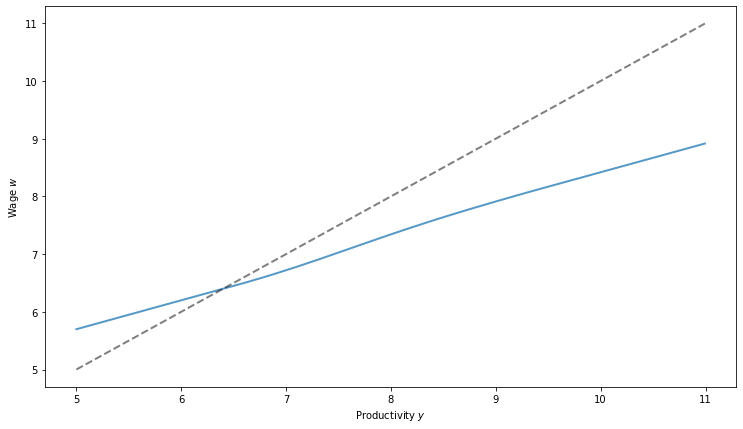

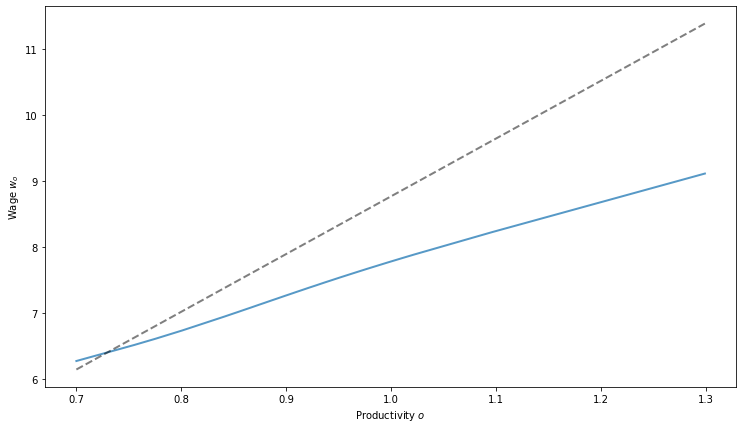

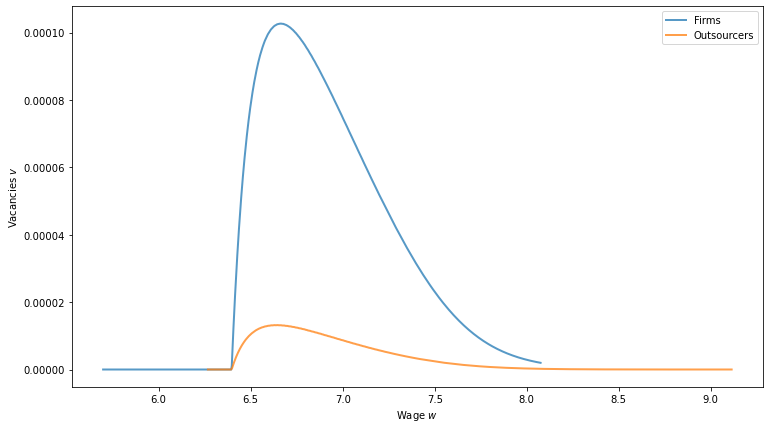

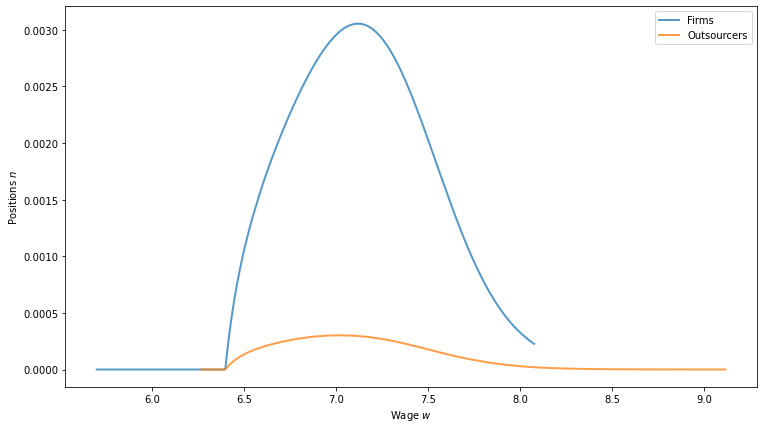

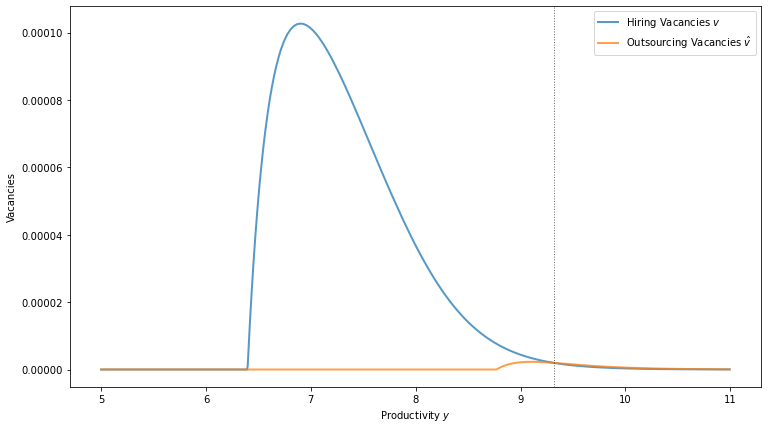

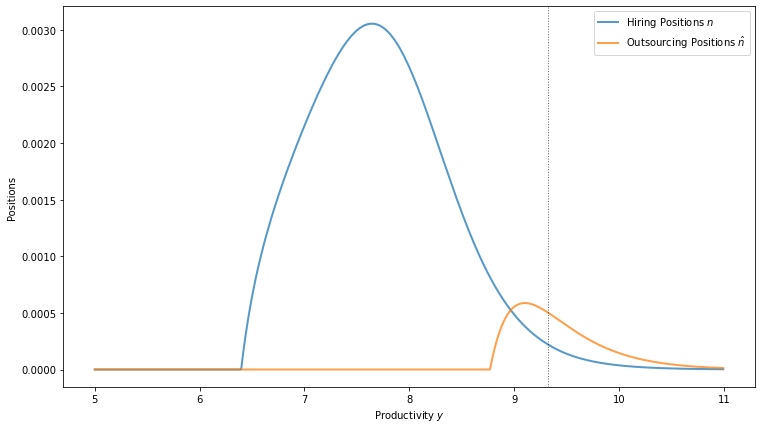

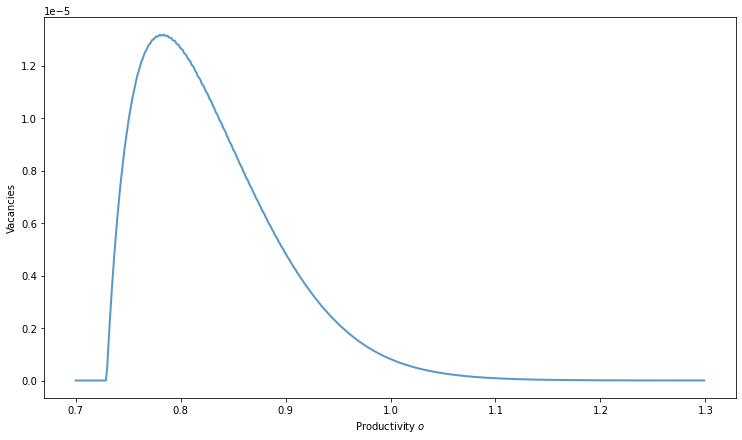

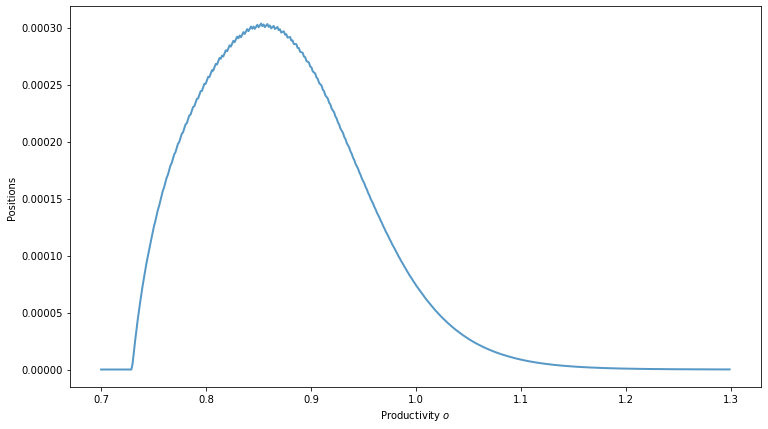

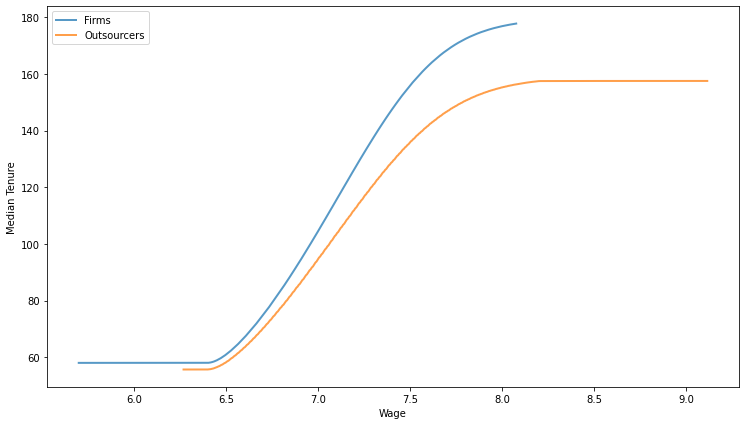

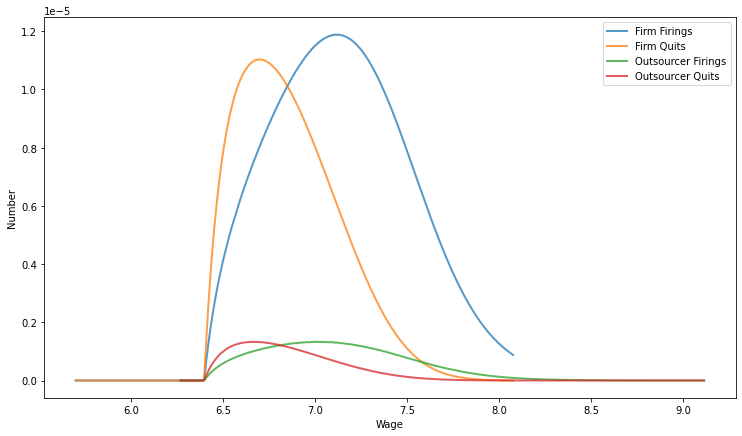

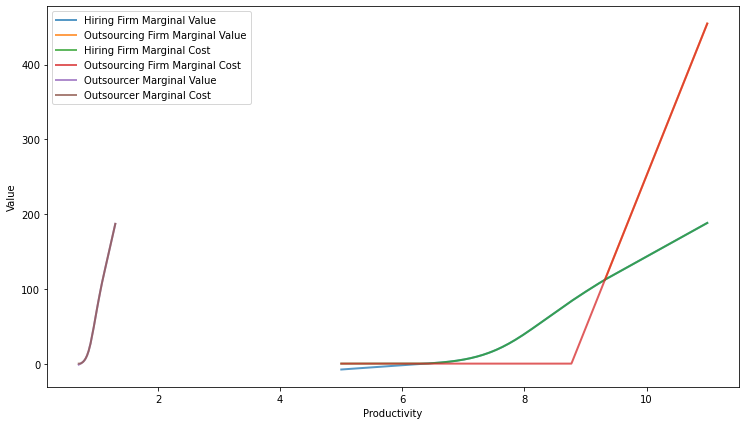

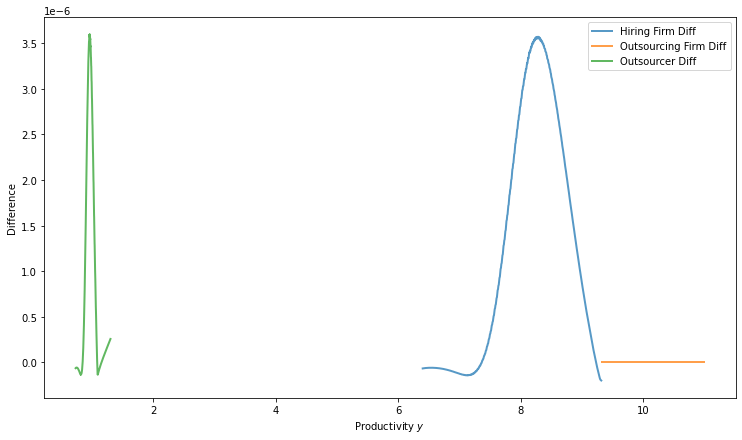

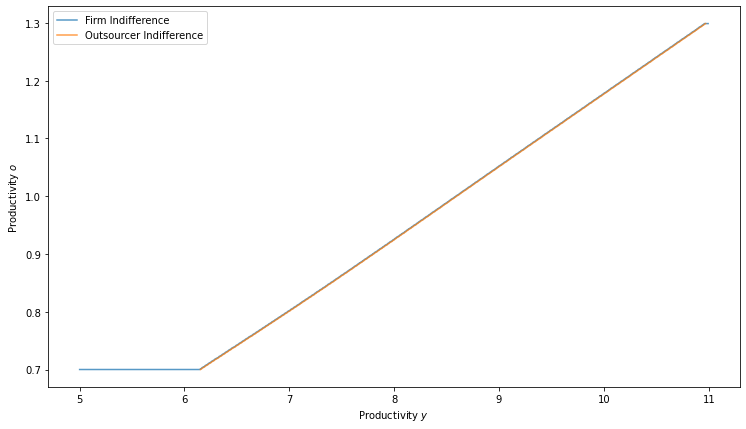

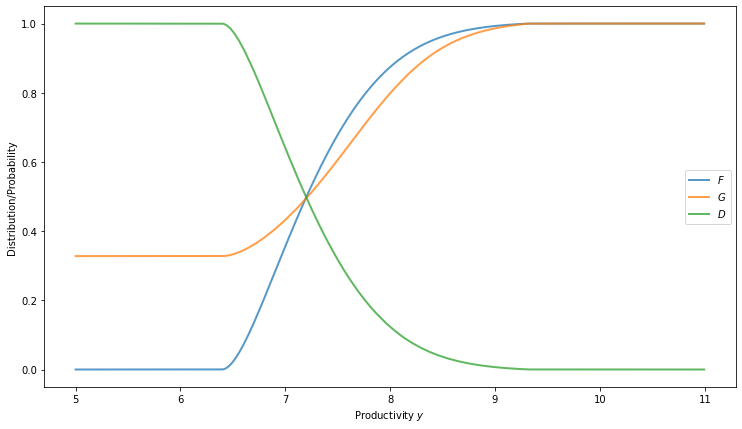

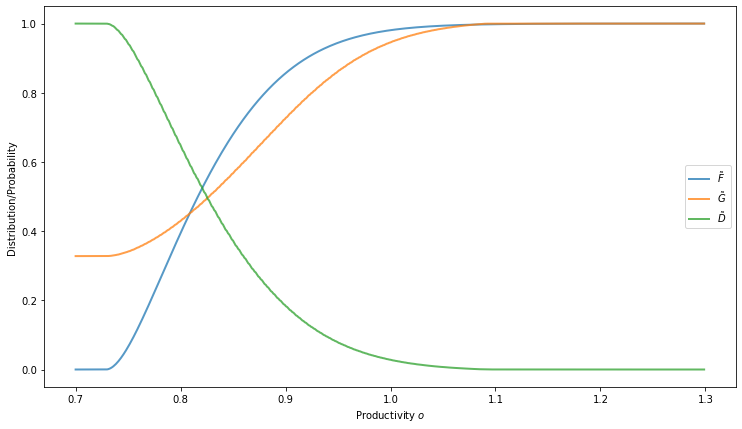

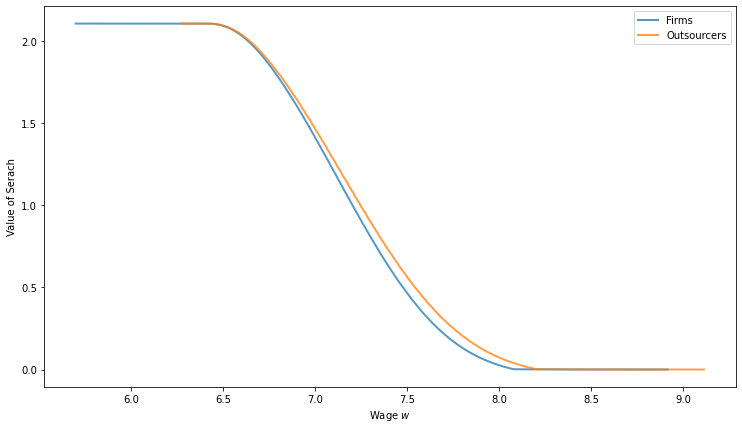

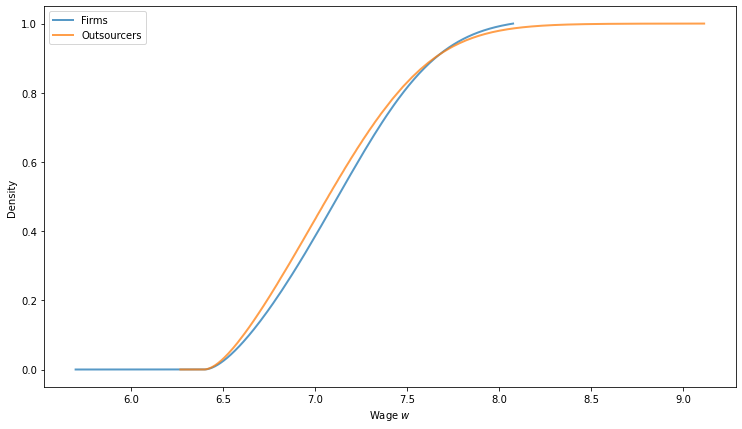

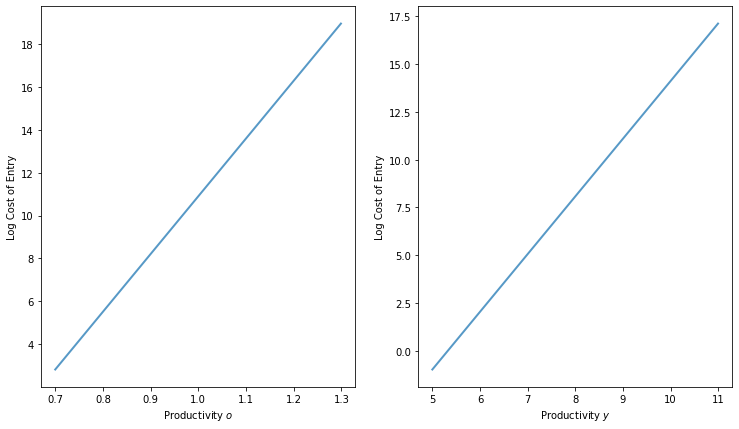

In [5]:
# Try out initial guess

y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint=False)
o_grid = np.linspace(o_min, o_max, o_grid_size, endpoint=False)

c_grid = np.exp(x_0[0] + x_0[1] * y_grid)
c_o_grid = np.exp(x_0[2] + x_0[3] * o_grid)
xi = x_0[4]
phi = x_0[5]
eta_o = eta * x_0[6]

ooj = OutsourcingOnJob(
    B, b, delta_, delta_o, delta_hat, xi, eta, eta_o, phi, alpha,
    y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
    gamma, gamma_o, c_grid, c_o_grid
)

(v_grid, v_hat_grid, v_o_grid, n_grid,
 n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p) = find_p(
    ooj, guess_0, p_1_0, p_2_0, tol, max_iter, tol_i, max_iter_i, slow_i, verbose=True, print_skip=5
) 
    
solution = (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)

list_facts(ooj, solution)

graph_results(ooj, solution)

solve_given_p, iterate, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj)

# (theta, G_grid, G_o_grid, D_grid, D_o_grid,
#          Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
#             v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)

# rm, rm_o = ooj.rm, ooj.rm_o
# y_i = find_y_i(y_hat)

# zeta = np.sum(n_o_grid * rm_o) / (np.sum(n_o_grid * rm_o) + np.sum(n_grid[:y_i] * rm))
# ee_h = np.sum(n_grid[:y_i] * D_grid[:y_i] * rm) / np.sum(n_grid[:y_i] * rm)
# ee_o = np.sum(n_o_grid * D_o_grid * rm_o) / np.sum(n_o_grid * rm_o)
# ee = ((1 - zeta) * ee_h + zeta * ee_o)

# ee - match[4]

> <ipython-input-18-967988ebef8d>(1629)comp_no_outsourcers()
   1627     set_trace()
   1628 
-> 1629     r, delta, xi = ooj.r, ooj.delta, ooj.xi
   1630     delta_o, delta_hat = ooj.delta_o, ooj.delta_hat
   1631     c_grid, c_o_grid = ooj.c_grid, ooj.c_o_grid

ipdb> theta_ls_p
nan
ipdb> theta_ls
nan
ipdb> n_grid_ls
array([nan, nan, nan, ..., nan, nan, nan])
ipdb> solution_ls
(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       2.85807549e-08, 2.82777508e-08, 2.79779472e-08]), array([5.92595698e-120, 5.92597037e-120, 5.92598415e-120, ...,
       3.26313091e-006, 3.22853627e-006, 3.19430703e-006]))
ipdb> solution_ls_p
(array([nan, nan, nan, ..., nan, nan, nan]), array([nan, nan, nan, ..., nan, nan, nan]), array([nan, nan, nan, ..., nan, nan, nan]))
ipdb> c


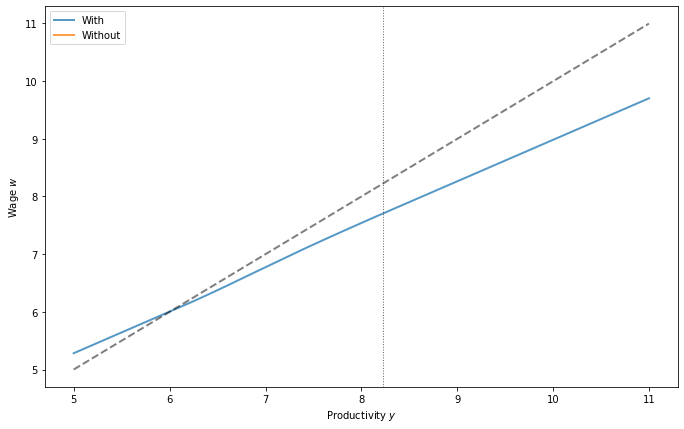

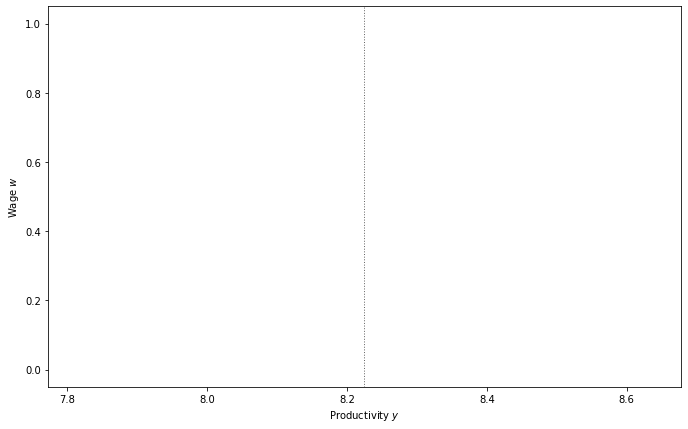

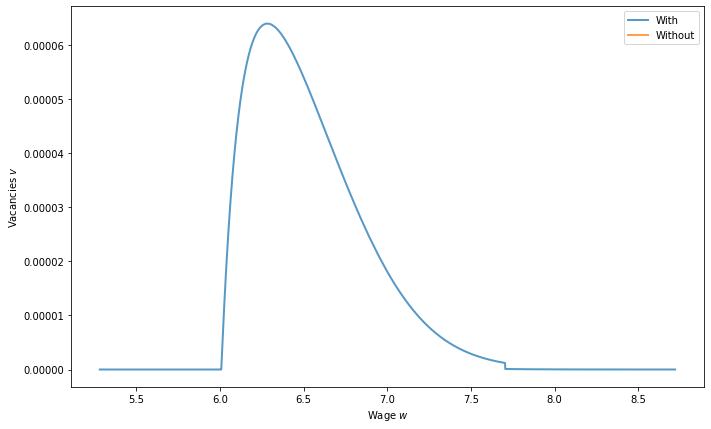

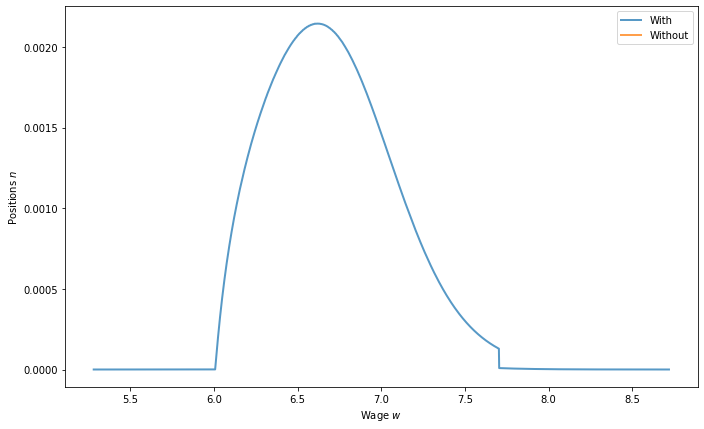


        Comparing to the Scenario without Outsourcers
        Unemployment: with 0.1253; without nan; dif nan
        Workers Job Finding Probability: with 0.0275; without nan; 
        dif nan
        Firms Worker Finding Probability: with 0.4224; without nan; 
        dif nan
        Unemployed Value of Search: with 1.7046; 
        without nan; dif nan
        Mean Value of working: with hired 4823.59; with outsourced 4696.80; 
        without hired nan; diff nan 
        Mean Wages: with 6.70; without nan; dif nan
        Mean Hired Wages: with 6.71; without nan; 
        dif nan
        Worker Welfare: with 5010; without nan; 
        dif nan
        Hired Worker Welfare: with 4824; without nan; 
        dif nan
        Firm Welfare: with 35; without nan; 
        dif nan
        Total Welfare: with 5048; without nan; 
        dif nan
        Efficient Welfare: with 6854.2712; without nan;
        dif nan
        Fraction of Efficient Welfare: with 73.6516; without nan;
        d

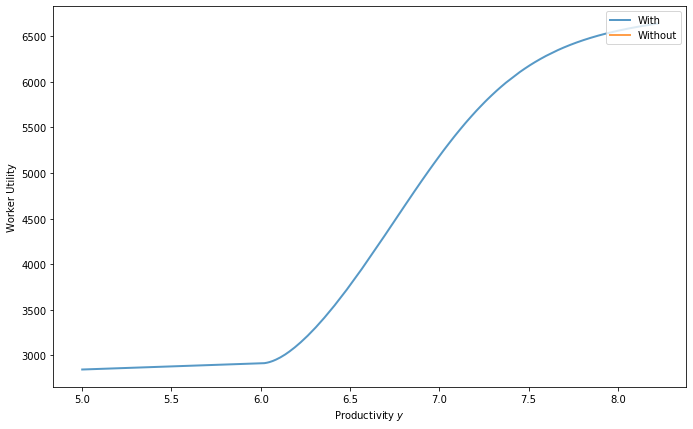

C:\Users\spspi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1629: RuntimeWarning: invalid value encountered in greater


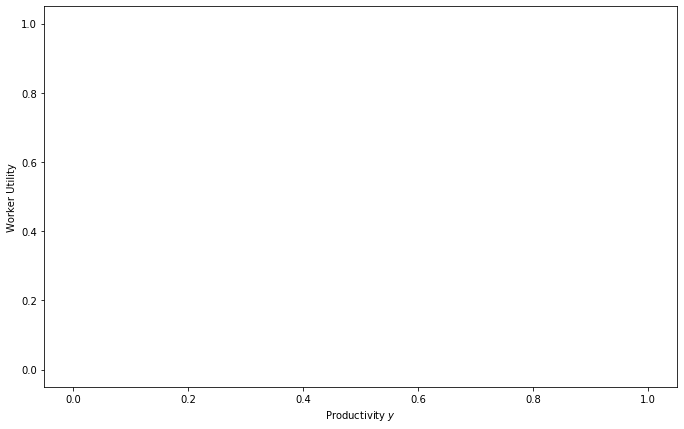

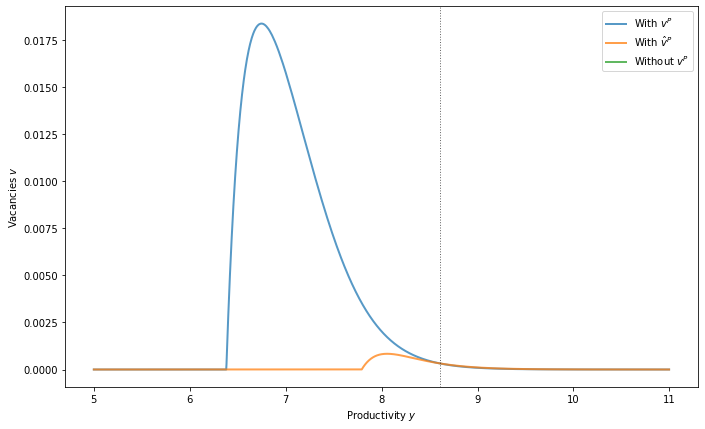

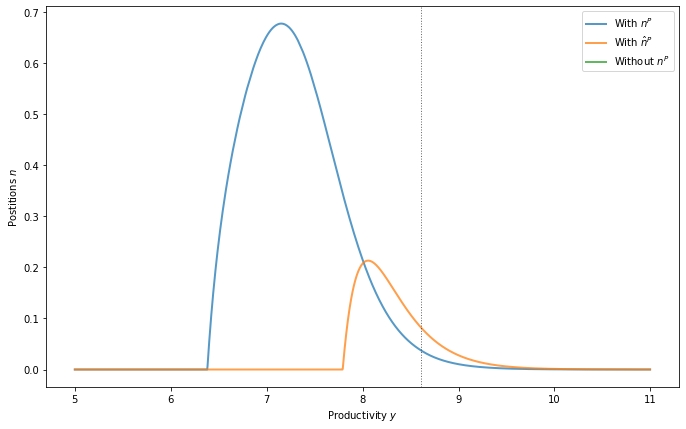

In [20]:
comp_no_outsourcers(ooj, solution, solution_p, solution_ls, solution_ls_p)

In [10]:
f.close()

In [39]:
v_o_grid

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.40629739e-04, 1.07104896e-03,
       1.94407305e-03, 2.76305469e-03, 3.53111367e-03, 4.25729041e-03,
       4.93387096e-03, 5.56780305e-03, 6.16142835e-03, 6.71694082e-03,
       7.25329271e-03, 7.74086015e-03, 8.19613026e-03, 8.62079702e-03,
      

In [34]:
# Find c_o_more, such that, given a callbriation of the model, if the cost of outsourcing was
# c_o_grid + c_o_more, zeta would equal .01 (as it did in 2001)
# Compare worker outcomes
call_params = pd.read_csv("../../Figures/Python Simulations/Test Calibration 8/Parameter Values.csv")

vals = call_params[["values"]].to_numpy().T[0]
(B, r, delta, delta_o, delta_hat, eta, eta_o, phi, alpha, xi, y_min, y_max, y_grid_size,
 o_min, o_max, o_grid_size, b, gamma, gamma_o, c_0, c_1, c_o_0, c_o_1, xi, alpha,
 _, _, _, _, _, _, _, _) = vals

y_grid_size, o_grid_size = int(y_grid_size), int(o_grid_size)

zeta_target = .03

y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
o_grid = np.linspace(o_min, o_max, o_grid_size, endpoint = False)

c_grid = np.exp(c_0 + c_1 * y_grid)
c_o_grid_orig = np.exp(c_o_0 + c_o_1 * o_grid)

p_1_0 = y_max - 4
p_2_0 = y_max
tol = 1e-4
max_iter = 25
tol_i = 1e-8
max_iter_i = 1e5
slow_i = 1.5e-1

# Record initial guesses
v_grid_0 = np.ones(y_grid_size) / y_grid_size
n_grid_0 = np.ones(y_grid_size) / y_grid_size
v_hat_grid_0 = np.ones(y_grid_size) / y_grid_size
n_hat_grid_0 = np.ones(y_grid_size) / y_grid_size
v_o_grid_0 = np.ones(o_grid_size) / o_grid_size
n_o_grid_0 = np.ones(o_grid_size) / o_grid_size
y_hat_0 = y_max
R_grid_0 = np.minimum(np.arange(y_grid_size), o_grid_size - 1, dtype=np.int64)
R_o_grid_0 = np.minimum(np.arange(o_grid_size), y_grid_size - 1, dtype=np.int64)

guess_0 = (v_grid_0, v_hat_grid_0, v_o_grid_0, n_grid_0, n_hat_grid_0, n_o_grid_0, y_hat_0, R_grid_0, R_o_grid_0)

guess, p_1, p_2 = np.copy(guess_0), np.copy(p_1_0), np.copy(p_2_0)

def higher_cost(x):

    global guess, p_1, p_2
    
    c_o_more = x[0]

    c_o_grid = c_o_grid_orig + c_o_more

    ooj = OutsourcingOnJob(
        B, b, delta_, delta_o, delta_hat, xi, eta, eta_o, phi, alpha,
        y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
        gamma, gamma_o, c_grid, c_o_grid
    )

    (v_grid, v_hat_grid, v_o_grid, n_grid,
     n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p) = find_p(
        ooj, guess, p_1, p_2, tol, max_iter, tol_i, max_iter_i, slow_i, False
    )

    guess = (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid)
    p_2, p_1 = p, p + 0.01

    _, _, QD_QS_ED, make_grids, find_y_i, _, _, _, _, _, _, _, ell  = operator_factory(ooj)

    QD, QS, ED = QD_QS_ED(n_hat_grid, n_o_grid, y_hat)

    # If the model does not converge, do not use, reset guess
    if np.abs(ED) > tol:
        print(f"c_o_more {c_o_more:.4f}")
        p_2, p_1 = np.copy(p_2_0), np.copy(p_1_0)

        guess = np.copy(guess_0)
        return np.abs(ED) * 1e10

    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )

    rm, rm_o = ooj.rm, ooj.rm_o

    y_i = find_y_i(y_hat)

    # Find zeta, compare to data
    n = np.sum(n_grid[:y_i] * rm)
    n_o = np.sum(n_o_grid * rm_o)
    zeta = n_o / (n_o + n)
    err = np.abs(zeta - zeta_target)

    print(f"zeta {zeta:.3f}; c_o_more {c_o_more:.4f}")

    return err

In [ ]:
# Find minimum
# method = "Nelder-Mead"
method = "Powell"

if method == "Powell":
    result_more = minimize(higher_cost, x0=50, method=method, options={"maxiter":10, "disp":True})
if method == "Nelder-Mead":
    result_more = minimize(higher_cost, x0=50, method=method, options={"maxiter":10, "disp":True})
#     result = minimize(higher_cost, x0=0, method=method, options={"maxiter":200, "disp":True})
    
result_more

Converged in 10 iterations, Excess Demand is 0.0000; price is 7.9342; QS is 0.0296; QD is 0.0297
zeta 0.054; c_o_more 50.0000
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9346; QS is 0.0296; QD is 0.0297
zeta 0.054; c_o_more 50.0000
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9353; QS is 0.0296; QD is 0.0296
zeta 0.053; c_o_more 51.0000
Converged in 1 iterations, Excess Demand is 0.0000; price is 7.9365; QS is 0.0295; QD is 0.0295
zeta 0.053; c_o_more 52.6180
Converged in 2 iterations, Excess Demand is 0.0000; price is 7.9665; QS is 0.0268; QD is 0.0269
zeta 0.048; c_o_more 103.6458
Converged in 2 iterations, Excess Demand is -0.0000; price is 8.0040; QS is 0.0239; QD is 0.0239
zeta 0.043; c_o_more 186.2106
Converged in 1 iterations, Excess Demand is -0.0000; price is 8.0392; QS is 0.0214; QD is 0.0214
zeta 0.038; c_o_more 287.7805
Converged in 2 iterations, Excess Demand is -0.0000; price is 8.0821; QS is 0.0188; QD is 0.0187
zeta 0.033; c_o_more 4

zeta 0.030; c_o_more 593.1401


In [24]:
# Run this
higher_cost(0)

Converged in 10 iterations, Excess Demand is -0.0001; price is 7.8943; QS is 0.0336; QD is 0.0336
zeta 0.061; c_o_more 0.0000


0.05124890372698395

In [29]:
%debug

> <ipython-input-25-373678f050de>(91)higher_cost()
     89     err = zeta - zeta_target
     90 
---> 91     print(f"zeta {zeta:.3f}; c_o_more {x:.4f}")
     92 
     93     return err

ipdb> x
array([0.])
ipdb> print(f"zeta {zeta:.3f}; c_o_more {x:.4f}")
*** TypeError: unsupported format string passed to numpy.ndarray.__format__
ipdb> print(f"zeta {zeta:.3f}; c_o_more {x[0]:.4f}")
zeta 0.061; c_o_more 0.0000
ipdb> c


In [41]:
# Set up code for the outsourcer's problem with on-the-job search
# Builds on Outsourcers file
# This block of code separates v_grid of hiring from v_hat_grid of outsourcing
# This block uses the false position method to update p

import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit, jitclass, int64, float64
from interpolation import interp
from IPython.core.debugger import set_trace
from scipy.optimize import minimize

# Set up parameter space
ooj_parameters = [
    ("B", float64),
    ("r", float64),
    ("b", float64),
    ("delta", float64),
    ("delta_o", float64),
    ("delta_hat", float64),
    ("xi", float64),
    ("eta", float64),
    ("eta_o", float64),
    ("phi", float64),
    ("y_grid", float64[:]),
    ("y_grid_size", int64),
    ("y_min", float64),
    ("y_max", float64),
    ("rm", float64),
    ("o_grid", float64[:]),
    ("o_grid_size", int64),
    ("o_min", float64),
    ("o_max", float64),
    ("rm_o", float64),
    ("phi", float64),
    ("gamma", float64),
    ("k_grid", float64[:]),
    ("gamma_o", float64),
    ("k_o_grid", float64[:])    
]

@jitclass(ooj_parameters)
class OutsourcingOnJob:
    """
    B is discount rate beta
    r is interest rate defined by beta
    b is home production
    delta is job loss rate at firm
    delta_o is job loss rate at outsourcer
    delta_hat is firm destruction rate of outsourcing firm <= delta
    xi is probability of searching on-the-job
    eta is workers bargaining power with firm
    eta_o is workers bargaining power with outsourcer
    phi is effectiveness of matching function
    y_min, y_max, y_grid_size determine firm productivity grid
    rm is to Reimann Sum approximate firm integrals
    o_min, o_max, o_grid_size determine outsourcer productivity grid
    rm_o is to Reimann Sum approximate outsourcer integrals
    gamma is steepness of marginal cost, 
    k_grid is level of entry cost
    gamma_h is steepness of marginal cost for outsourcers, 
    k_o_grid is level of cost
    """
    def __init__(
        self, B, b, delta, delta_o, delta_hat, xi, eta, eta_o, phi,
        y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
        gamma, gamma_o, k_grid, k_o_grid
    ):
        
        self.B, self.b, self.delta, self.eta, self.gamma, self.k_grid = B, b, delta, eta, gamma, k_grid
        self.delta_hat, self.eta_o, self.gamma_o, self.k_o_grid = delta_hat, eta_o, gamma_o, k_o_grid 
        self.xi, self.delta_o = xi, delta_o
        self.r = 1 / B - 1
        
#         self.y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
        self.y_grid = np.linspace(y_min, y_max, y_grid_size)
        self.y_grid_size, self.y_min, self.y_max = y_grid_size, y_min, y_max    
        self.rm = (y_max - y_min) / y_grid_size
        
#         self.o_grid = np.linspace(o_min, o_max, o_grid_size, endpoint = False)
        self.o_grid = np.linspace(o_min, o_max, o_grid_size)
        self.o_grid_size, self.o_min, self.o_max = o_grid_size, o_min, o_max    
        self.rm_o = (o_max - o_min) / o_grid_size
        
        self.phi = phi
#         self.q = njit(lambda x: min(phi * x**(-1 / 2), 1))
#         self.ell = njit(lambda x: min(phi * x**(1 / 2), 1))
#         # Remember, q_p and p_p = 0 if q or p = 1
#         self.q_p = njit(lambda x: -phi / 2 * x**(-3 / 2) * (phi * x**(-1 / 2) < 1)) 
#         self.ell_p = njit(lambda x: phi / 2 * x**(1 / 2) * (phi * x**(1 / 2) < 1))


# Set up neccesary functions
def operator_factory(ooj):
    
    r, b, delta, eta, gamma, k_grid = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma, ooj.k_grid
    delta_hat, eta_o, gamma_o, k_o_grid = ooj.delta_hat, ooj.eta_o, ooj.gamma_o, ooj.k_o_grid
    xi, delta_o = ooj.xi, ooj.delta_o
    phi = ooj.phi
    
    y_grid, y_grid_size, rm = ooj.y_grid, ooj.y_grid_size, ooj.rm
    o_grid, o_grid_size, rm_o = ooj.o_grid, ooj.o_grid_size, ooj.rm_o
    
    
    @njit()
    def q(theta):
        return min(phi * theta**(-1 / 2), 1)
    
    @njit()
    def ell(theta):
        return min(phi * theta**(1 / 2), 1)
    
    # Want cost of vacancy, marginal cost of vacancy, and inverse marginal cost of vacancy
    @njit()
    def C(v_grid):
        return k_grid * v_grid**gamma
    
    @njit()
    def c(v_grid):
        return k_grid * gamma * v_grid**(gamma - 1)

    @njit()
    def c_inv(c_grid):
        return (np.maximum(c_grid, 0) / (gamma * k_grid))**(1 / (gamma - 1))
        
    # Do the same for outsourcers
    @njit()
    def C_o(v_o_grid):
        return k_o_grid * v_o_grid**gamma_o

    @njit()
    def c_o(v_o_grid):
        return k_o_grid * gamma_o * v_o_grid**(gamma_o - 1)

    @njit()
    def c_o_inv(c_o_grid):
        return (np.maximum(c_o_grid, 0) / (gamma_o * k_o_grid))**(1 / (gamma_o - 1))
    
    # Given a continuous y_hat, find the nearest y_i
    @njit()
    def find_y_i(y_hat):
        return np.argmin(np.abs(y_hat - y_grid))
    
    # Given v_grid, v_o_grid, n_grid,
    # n_o_grid, y_hat, R_grid, R_o_grid, and p, find
    # Firms who directly hire hire vs those that outsource out
    # Market tightness theta
    # Distribution of vacanices F and F_o
    # Distribution of job seekers G and G_o
    # Probability of worker leaving D and D_o
    # Wages w and w_o
    @njit()
    def make_grids(v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p):    
        
        y_i = find_y_i(y_hat)
        
        # Make this here, but useful for F and G below
        n_temp = np.copy(n_grid)
        n_temp[y_i:] = 0
        
        cum_v = np.cumsum(v_grid * rm)
        cum_v_o = np.cumsum(v_o_grid * rm_o)
        cum_n = np.cumsum(n_temp * rm)
        cum_n_o = np.cumsum(n_o_grid * rm_o)
        
        # Define aggregate populations (make sure all exist)
        u = max(1 - cum_n[-1] - cum_n_o[-1], 1e-9)
        v = max(cum_v[-1], 1e-9)
        v_o = max(cum_v_o[-1], 1e-9)
        s = u + xi * (cum_n[-1] + cum_n_o[-1])
        
        # Calculate theta and pi 
        v_sum = v + v_o
        theta = v_sum / s
        pi = v_o / v_sum
        
        # Calculate distributions 
        # F is distribution of vacancies (include firms above y_hat in cdf as 1)
        F_grid = np.minimum(cum_v / v, 1)
        f_grid = v_grid / v
        f_grid[y_i:] = 0
        
        F_o_grid = cum_v_o / v_o
        f_o_grid = v_o_grid / v_o
        
        # G is distribution of job seekers (include firms above y_hat as bigger than all y firms)        
        G_grid = (u + xi * (cum_n + cum_n_o[R_grid])) / s
        G_o_grid = (u + xi * (cum_n[R_o_grid] + cum_n_o)) / s
        
        # D is probability a worker finds a better job
        D_grid = xi * ell(theta) * (1 - (1 - pi) * F_grid - pi * F_o_grid[R_grid]) 
        D_o_grid = xi * ell(theta) * (1 - (1 - pi) * F_grid[R_o_grid] - pi * F_o_grid) 
        
        # What is the value of search?
        # Store these vectors of values which will be used many times
        f_tot = c(v_grid) / G_grid * f_grid * rm
        o_tot = c_o(v_o_grid) / G_o_grid * f_o_grid * rm_o
        i_cum_f = np.cumsum(f_tot[::-1])[::-1]
        i_cum_o = np.cumsum(o_tot[::-1])[::-1]
        
        # For unemployed
        firm = eta / (1 - eta) * (1 - pi) * i_cum_f[0]
        out = eta_o / (1 - eta_o) * pi * i_cum_o[0]
        Gamma_U = ell(theta) / q(theta) * (firm + out)
        
        # For employed at a firm
        firm = eta / (1 - eta) * (1 - pi) * i_cum_f
        out = eta_o / (1 - eta_o) * pi * i_cum_o[R_grid]
        Gamma_grid = ell(theta) / q(theta) * (firm + out)
        
        # For employed at an outsourcer
        firm = eta / (1 - eta) * (1 - pi) * i_cum_f[R_o_grid]
        out = eta_o / (1 - eta_o) * pi * i_cum_o
        Gamma_o_grid = ell(theta) / q(theta) * (firm + out)
        
        # Find wages
        w_grid = eta * y_grid + (1 - eta) * (b + Gamma_U - (1 - delta) * xi * Gamma_grid) 
        w_o_grid = eta_o * p * o_grid + (1 - eta_o) * (b + Gamma_U - (1 - delta_o) * xi * Gamma_o_grid) 
        
        return (
            theta, G_grid, G_o_grid, D_grid, D_o_grid, 
            Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid
        )
    
    # Given v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
    # n_o_grid, y_hat, R_grid, R_o_grid, and p, find new values
    @njit()
    def iterate(v_grid, v_hat_grid, v_o_grid, n_grid,
                n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p):
        
        (theta, G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)
        
        # Value of firms
        J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + (1 - delta) * D_grid)
        J_out = (y_grid - p) / (r + delta_hat)
        
        # Update y_hat by finding firm closest to indifferent between hiring/outsourcing
        # Make sure J_out is non_negative at y_hat
        y_diff = np.argmin(np.abs(J_out - J_hire))
        y_zero = np.argmin(np.abs(J_out))
        y_hat_new = y_grid[max(y_diff, y_zero)]
        
        # Update vacancies
        # Hiring firms (below y_hat)
        v_grid_new = c_inv(J_hire)
        
        # Outsourcing firms (above y_hat)
        v_hat_grid_new = c_inv(J_out)
        
        # Outsourcers
        v_o_grid_new = c_o_inv(
            (o_grid * p - w_o_grid) * q(theta) * G_o_grid / (r + delta_o + (1 - delta_o) * D_o_grid)
        )
        
        # Update positions
        # Hiring firms
        n_grid_new = (1 - delta) * (1 - D_grid) * n_grid + q(theta) * G_grid * v_grid_new
        
        # Outsourcing firms
        n_hat_grid_new = (1 - delta_hat) * n_hat_grid + v_hat_grid_new
        
        # Outsourcers
        n_o_grid_new = (1 - delta_o) * (1 - D_o_grid) * n_o_grid + q(theta) * G_o_grid * v_o_grid_new
               
        # Update R_grid and R_o_grid by comparing W - U to W_o - U.
        # Note that R_grid is defined for all firms, even those above 
        # y_hat, and R_o_grid might be indiffeferent to a firm above y_hat that doesn't hire
        # Value of employment at a firm (minus value of unemployment)        
        W_min_U = (
            (1 + r) * (w_grid - b - Gamma_U + (1 - delta) * xi * Gamma_grid)
            / (r + delta + (1 - delta) * D_grid)
        )
        
        # Value of employment at an outsourcer (minus value of unemployment)
        W_o_min_U = (
            (1 + r) * (w_o_grid - b - Gamma_U + (1 - delta_o) * xi * Gamma_o_grid)
            / (r + delta_o + (1 - delta_o) * D_o_grid)
        )

        # Use these and search sorted to find new indecision rules (make sure not above all)
        R_grid_new = np.minimum(np.searchsorted(W_o_min_U, W_min_U), o_grid_size - 1)
    
        R_o_grid_new = np.minimum(np.searchsorted(W_min_U, W_o_min_U), y_grid_size - 1)
        
        return (v_grid_new, v_hat_grid_new, v_o_grid_new, n_grid_new,
                n_hat_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new)
    
    # Given n_grid, n_o_grid, and y_hat find excess demand for outsourcing 
    @njit()
    def QD_QS_ED(n_hat_grid, n_o_grid, y_hat):
        y_i = find_y_i(y_hat)
        QD = np.sum(n_hat_grid[y_i:] * rm) 
        QS = np.sum(n_o_grid * o_grid * rm_o)
        ED = QD - QS
        return QD, QS, ED

    @njit()
    def solve_given_p(
        p, v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
        n_o_grid, y_hat, R_grid, R_o_grid, tol, max_iter, slow
    ):

        # Set up initial loop parameters
        i = 0
        err = tol + 1    

        # Update v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, and R_o_grid
        while i < max_iter and err > tol:
            (v_grid_new, v_hat_grid_new, v_o_grid_new, n_grid_new,
                    n_hat_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new) = iterate(
                v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
            )
            err_v_t = np.max(np.abs(v_grid_new - v_grid))
            err_v_h = np.max(np.abs(v_hat_grid_new - v_hat_grid))
            err_v_o = np.max(np.abs(v_o_grid_new - v_o_grid))
            err_n_t = np.max(np.abs(n_grid_new - n_grid))
            err_n_h = np.max(np.abs(n_hat_grid_new - n_hat_grid))
            err_n_o = np.max(np.abs(n_o_grid_new - n_o_grid))
            err = max(err_v_t, err_v_h, err_v_o, err_n_t, err_n_h, err_n_o)
            i += 1

            v_grid = slow * v_grid_new + (1 - slow) * v_grid
            v_hat_grid = slow * v_hat_grid_new + (1 - slow) * v_hat_grid
            v_o_grid = slow * v_o_grid_new + (1 - slow) * v_o_grid
            n_grid = slow * n_grid_new + (1 - slow) * n_grid
            n_hat_grid = slow * n_hat_grid_new + (1 - slow) * n_hat_grid
            n_o_grid = slow * n_o_grid_new + (1 - slow) * n_o_grid
            y_hat = slow * y_hat_new + (1 - slow) * y_hat 

            # To slowly adjust y_hat, R_grid, and R_o_grid (which are indexes), instead 
            # add/subtract by 1 if greater/less 
            R_grid = R_grid + 1 * (R_grid_new > R_grid) - 1 * (R_grid_new < R_grid)
            R_o_grid = R_o_grid + 1 * (R_o_grid_new > R_o_grid) - 1 * (R_o_grid_new < R_o_grid)     

        return (
            v_grid_new, v_hat_grid_new, v_o_grid_new, n_grid_new,
            n_hat_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new
        )        
    
    return solve_given_p, iterate, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell 

# Find p
def find_p(
    ooj, guess, p_low, p_high, tol, max_iter, tol_i, max_iter_i, slow_i, verbose=False, print_skip=5
):
    
    solve_given_p, _, QD_QS_ED, _, _, _, _, _, _, _, _, _, _ = operator_factory(ooj)
    
    # Find excess_demand for p_low and p_high, make sure they have opposite signs
    for p in [p_high, p_low]:
        
#         qe.tic()
        
        # Initial guesses
        (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid) = guess
        
#         set_trace()
        
        (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid) = solve_given_p(
            p, v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
            n_o_grid, y_hat, R_grid, R_o_grid, tol=tol_i, max_iter=max_iter_i, slow=slow_i
        )
        
        QD, QS, ED = QD_QS_ED(n_hat_grid, n_o_grid, y_hat)
        
        if p == p_low:
            ED_low = ED
        else:
            ED_high = ED
            
#         qe.toc()
        
        if verbose:
            print(f'Excess Demand for price {p} is {ED:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
            
            
    if ED_low < 0:
        print('Test failed, low price has negative excess demand')
    if ED_high > 0:
        print('Test failed, high price has positive excess demand')
        
        return
    
    # Reset initial guess
    (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid) = guess
    
#     set_trace()
    
    # Set up loop parameters    
    err = tol + 1
    j = 0
        
    while err > tol and j < max_iter:
        
#         qe.tic()
        
        # Update p using false position method (line between points intersects 0) 
        p = (p_low * ED_high - p_high * ED_low) / (ED_high - ED_low) 
              
        (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid) = solve_given_p(
            p, v_grid, v_hat_grid, v_o_grid, n_grid,
            n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, tol_i, max_iter_i, slow_i
        )
        
        QD, QS, ED = QD_QS_ED(n_hat_grid, n_o_grid, y_hat)
        err = np.abs(ED)
        
#         qe.toc()
        
        # If excess demand QD - QS > 0, set p_low = p and ED_low = ED, otherwise p_high = p and ED_jogh = ED
        if ED > 0:
            p_low = p
            ED_low = ED
        else:
            p_high = p
            ED_high = ED
            
        if verbose and j % print_skip == 0:
            print(
                f'Excess Demand at iter {j} is {ED:.4f}; price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}',
                f"y_hat is {y_hat:.4f}"
            )
            
        j += 1
    
    if j < max_iter:
        print(f'Converged in {j} iterations, Excess Demand is {ED:.4f};',
              f' price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
    if j == max_iter:
        print(f'Failed to Converge. Excess Demand is {ED:.4f}; price is {p:.4f};',
              f' QS is {QS:.4f}; QD is {QD:.4f}')
        
    return v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p

# Create a function to graph results
def graph_results(ooj, v_grid, v_hat_grid, v_o_grid, n_grid,
                  n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p,
                  save=False, height=7, 
                  folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures\Python Simulations\Test',
                  file=r'\Outsourcers OJS '):
    
    # Make sure dimensions are 1:1.77 (or 1:1.62)
    width = height * 1.77    
#     width = height * 1.62
    
    # Get data needed from ooj
    _, _, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj)
    
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    r, delta, xi = ooj.r, ooj.delta, ooj.xi
    delta_o, delta_hat = ooj.delta_o, ooj.delta_hat
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    y_grid_size, o_grid_size = ooj.y_grid_size, ooj.o_grid_size
    
    y_i = find_y_i(y_hat)
        
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, w_grid, alpha=0.75)
    ax.plot(y_grid, y_grid, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Wage $w$")
    
    if save:
        fig.savefig(folder + file + 'Firm Wages v Productivity.pdf')
    else:
        plt.show()  
        
    # Graph outsourcer wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, w_o_grid, alpha=0.75)
    ax.plot(o_grid, o_grid * p, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $o$", ylabel="Wage $w_o$")
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Wages v Productivity.pdf')
    else:
        plt.show() 
        
    # Graph vacacies by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], v_grid[:y_i], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, v_o_grid, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Vacancies $v$")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Vacancies v Wages.pdf')
    else:
        plt.show()         
    
    # Graph filled posititions by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], n_grid[:y_i], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, n_o_grid, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Positions $n$")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Positions v Wages.pdf')
    else:
        plt.show() 
        
    # Graph firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid, alpha=0.75, label=r"Hiring Vacancies ${v}$")
    ax.plot(y_grid, v_hat_grid, alpha=0.75, label=r"Outsourcing Vacancies $\hat{v}$")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firm Vacancies.pdf')
    else:
        plt.show()
        
    # Graph firm postions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid, alpha=0.75, label=r"Hiring Positions ${n}$")
    ax.plot(y_grid, n_hat_grid, alpha=0.75, label=r"Outsourcing Positions $\hat{n}$")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Positions")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firm Positions.pdf')
    else:
        plt.show()
        
    # Graph outsourcer vacancies and filled positions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, v_o_grid, alpha=0.75, label=r"Vacanicies $\tilde{v}$")
    ax.set(xlabel="Productivity $o$", ylabel="Vacancies")
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Vacancies.pdf')
    else:
        plt.show()
        
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, n_o_grid, alpha=0.75, label=r"Positions $\tilde{n}$")
    ax.set(xlabel="Productivity $o$", ylabel="Positions")
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Positions.pdf')
    else:
        plt.show()
        
    # Graph median tenure by wage
    p_stay = (1 - delta) * (1 - D_grid)
    median_tenure = np.log(.5) / np.log(p_stay)
    p_o_stay = (1 - delta_o) * (1 - D_o_grid)
    median_tenure_o = np.log(.5) / np.log(p_o_stay)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], median_tenure[:y_i], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, median_tenure_o, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage", ylabel="Median Tenure")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Median Tenure.pdf')
    else:
        plt.show()
        
    # Graph firings (lose jobs) vs quits (find better job) by wage
    firings = delta * n_grid
    quits = (1 - delta) * D_grid * n_grid
    firings_o = delta_o * n_o_grid_p
    quits_o = (1 - delta_o) * D_o_grid * n_o_grid_p
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], firings[:y_i], alpha=0.75, label="Firm Firings")
    ax.plot(w_grid[:y_i], quits[:y_i], alpha=0.75, label="Firm Quits")
    ax.plot(w_o_grid, firings_o, alpha=0.75, label="Outsourcer Firings")
    ax.plot(w_o_grid, quits_o, alpha=0.75, label="Outsourcer Quits")
    ax.set(xlabel="Wage", ylabel="Number")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firings and Quits.pdf')
    else:
        plt.show()
        
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    # Do the same for outsourcers hiring
    J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + (1 - delta) * D_grid)
    mc = c(v_grid)   
    
    J_out = (y_grid - p) / (r + delta_hat) 
    mc_hat = c(v_hat_grid) 
    
    O = q(theta) * G_o_grid * (p * o_grid - w_o_grid) / (r + delta_o + (1 - delta_o) * D_o_grid)
    mc_o = c_o(v_o_grid) 
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_hire, alpha=0.75, label="Hiring Firm Marginal Value")
    ax.plot(y_grid[y_i:], J_out[y_i:], alpha=0.75, label="Outsourcing Firm Marginal Value")
    ax.plot(y_grid, mc, alpha=0.75, label="Hiring Firm Marginal Cost")
    ax.plot(y_grid, mc_hat, alpha=0.75, label="Outsourcing Firm Marginal Cost")
    ax.plot(o_grid, O, alpha=0.75, label="Outsourcer Marginal Value")
    ax.plot(o_grid, mc_o, alpha=0.75, label="Outsourcer Marginal Cost")
    ax.set(xlabel="Productivity", ylabel="Value")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'M Value and Cost.pdf')
    else:
        plt.show()
        
    # Plot the differences from the above curves
    J_hire_diff = J_hire - mc
    J_out_diff = J_out - mc_hat
    O_diff = O - mc_o
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i][v_grid[:y_i] > 0],
            J_hire_diff[:y_i][v_grid[:y_i] > 0], alpha=0.75, label="Hiring Firm Diff")
    ax.plot(y_grid[y_i:], J_out_diff[y_i:], alpha=0.75, label="Outsourcing Firm Diff")
    ax.plot(o_grid[v_o_grid > 0], O_diff[v_o_grid > 0], alpha=0.75, label="Outsourcer Diff")
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'M Value Minus Cost.pdf')
    else:
        plt.show()
        
    # Plot the workers' indifference curve for hired vs outsourced
    o_R_grid = o_grid[R_grid]
    y_R_o_grid = y_grid[R_o_grid]
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, o_R_grid, alpha=0.75, label="Firm Indifference")
    ax.plot(y_R_o_grid, o_grid, alpha=0.75, label="Outsourcer Indifference")    
    ax.set(xlabel="Productivity $y$", ylabel="Productivity $o$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "Worker's Indifference Curve.pdf")
    else:
        plt.show()
        
    # Plot various distribributions for the firm
    v = np.sum(v_grid[:y_i] * rm)
    F_grid = np.minimum(np.cumsum(v_grid * rm) / v, 1)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, F_grid, alpha=0.75, label=r"$F$")  
    ax.plot(y_grid, G_grid, alpha=0.75, label=r"$G$") 
    ax.plot(y_grid, D_grid / (xi * ell(theta)), alpha=0.75, label=r"$D$")  
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "Firm Distributions.pdf")
    else:
        plt.show()
        
    # Plot various distribributions for the outsourcer
    v_o = np.sum(v_o_grid * rm_o)
    F_o_grid = np.cumsum(v_o_grid * rm_o) / v_o
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, F_o_grid, alpha=0.75, label=r"$\tilde{F}$")  
    ax.plot(o_grid, G_o_grid, alpha=0.75, label=r"$\tilde{G}$") 
    ax.plot(o_grid, D_o_grid / (xi * ell(theta)), alpha=0.75, label=r"$\tilde{D}$")  
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "Outsourcer Distributions.pdf")
    else:
        plt.show()
        
    # Graph value of search by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid, Gamma_grid, alpha=0.75, label="Firms")
    ax.plot(w_o_grid, Gamma_o_grid, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Value of Serach")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Value of Search.pdf')
    else:
        plt.show()
        
# Create a function to print some facts that are useful
def list_facts(ooj, v_grid, v_hat_grid, v_o_grid, n_grid,
               n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p, f=None):
    
    _, _, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj)
    
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    
    delta, xi = ooj.delta, ooj.xi
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    
    y_i = find_y_i(y_hat)
    
    print(f"The indifferent firm is y_hat = {y_hat:.2f}$. Price of outsourcing is {p:.2f}.")
    
    u = 1 - np.sum(n_grid[:y_i] * rm) - np.sum(n_o_grid * rm_o) 
    pi = np.sum(v_o_grid * rm_o) / (np.sum(v_grid[:y_i] * rm) + np.sum(v_o_grid * rm_o))
    zeta = np.sum(n_o_grid * rm_o) / (np.sum(n_grid[:y_i] * rm) + np.sum(n_o_grid * rm_o))
    e_delta = (1 - zeta) * delta + zeta * delta_o 
    u_lom = e_delta / (e_delta + ell(theta))
    tot_v = np.sum(v_grid[:y_i] * rm) + np.sum(v_o_grid * rm_o)
    
    print(f"Unemployment is {u * 100:.2f}. According to LoM, should be {u_lom * 100:.2f}")
    print(f"Workers match with probability {ell(theta) * 100:.2f}.",
          f"Firms/Outsourcers match with probability {q(theta) * 100:.2f}")
    print(f"Total vacancies searching for workers are {tot_v:.4f}. Theta is {theta:.4f}")
    print(f"{pi * 100:.0f} percent of vacancies searching for workers are from outsourcers,",
          f"{zeta * 100:.0f} percent of postions outsourced")
    
    # Document ue rate, ee rate, and percent of jobs from unemployment
    ue = ell(theta)
    ee = (
        (np.sum(n_grid[:y_i] * D_grid[:y_i] * rm) / np.sum(n_grid[:y_i] * rm) + 
         np.sum(n_o_grid * D_o_grid * rm_o) / np.sum(n_o_grid * rm_o))
    )
    per_from_u = 100 * ue * u / (ue * u + ee * (1 - u))
    print(f"The ue rate is {ue:.4f}, the ee rate is {ee:.4f},",
          f" and {per_from_u:0f} of new jobs are from unemployment")  
                       
    # Do firm/outsourcer vacancies and positions line up in steady state?
    n_ss = v_grid * q(theta) * G_grid / (delta + D_grid - delta * D_grid)
    err = max(np.abs(n_ss - n_grid))
    err_at = np.argmax(np.abs(n_ss - n_grid))
    
    n_ss_hat = v_hat_grid / delta_hat
    err_hat = max(np.abs(n_ss_hat - n_hat_grid))
    err_hat_at = np.argmax(np.abs(n_ss_hat - n_hat_grid))
    
    n_o_ss = v_o_grid * q(theta) * G_o_grid / (delta_o + D_o_grid - delta_o * D_o_grid)
    err_o = max(np.abs(n_o_ss - n_o_grid))
    err_o_at = np.argmax(np.abs(n_o_ss - n_o_grid))
    
    print(
        "Checking if vacancies + LoM imply right positions:\n",
         f"Hiring firms largest error = {err:.6f} at position {err_at} \n",
         f"Outsourcing firms largest error = {err_hat:.6f} at position {err_hat_at}\n",
         f"Outsourcer largest error = {err_o:.6f} at position {err_o_at}"
    )  
    
    # If want to save everything in an output file
    if f is not None:
        f.write(f"""
        Some facts about the model: \n
        The indifferent firm is y_hat = {y_hat:.2f}$. Price of outsourcing is {p:.2f}. \n
        Unemployment is {u * 100:.2f}. According to LoM, should be {u_lom * 100:.2f} \n
        Workers match with probability {ell(theta) * 100:.2f}. \n
        Firms/Outsourcers match with probability {q(theta) * 100:.2f} \n
        Total vacancies searching for workers are {tot_v:.4f}. Theta is {theta:.4f} \n
        {pi * 100:.0f} percent of vacancies searching for workers are from outsourcers, \n
        {zeta * 100:.0f} percent of postions outsourced \n
        The ue rate is {ue:.4f}, the ee rate is {ee:.4f} \n
        and {per_from_u:0f} of new jobs are from unemployment \n
        Checking if vacancies + LoM imply right positions:\n
        Hiring firms largest error = {err:.6f} at position {err_at} \n
        Outsourcing firms largest error = {err_hat:.6f} at position {err_hat_at}\n
        Outsourcer largest error = {err_o:.6f} at position {err_o_at}
        """)
        
def save_parameters(ooj, f, p_low, p_high, tol, max_iter, tol_i, max_iter_i, slow_i, k_names):
    
    r, b, delta, eta, gamma, k_grid = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma, ooj.k_grid
    delta_hat, eta_o, gamma_o, k_o_grid = ooj.delta_hat, ooj.eta_o, ooj.gamma_o, ooj.k_o_grid
    xi, delta_o = ooj.xi, ooj.delta_o
    phi, gamma, gamma_o = ooj.phi, ooj.gamma, ooj.gamma_o
    
    y_grid, y_grid_size, rm = ooj.y_grid, ooj.y_grid_size, ooj.rm
    o_grid, o_grid_size, rm_o = ooj.o_grid, ooj.o_grid_size, ooj.rm_o
    y_min, y_max, o_min, o_max = ooj.y_min, ooj.y_max, ooj.o_min, ooj.o_max
    
    f.write(f"""
    These are the parameters used for this simulation\n:
    B = {B} \n
    r = {r} \n
    delta = {delta} \n
    delta_o = {delta_o} \n
    delta_hat = {delta_hat} \n 
    eta = {eta} \n
    eta_o = {eta_o} \n
    phi = {phi} \n 
    xi = {xi} \n
    y_min = {y_min} \n 
    y_max = {y_max} \n
    y_grid_size = {y_grid_size} \n
    o_min = {o_min} \n 
    o_max = {o_max} \n
    o_grid_size = {o_grid_size} \n
    b = {b} \n 
    gamma = {gamma} \n 
    gamma_o = {gamma_o} \n 
    """ + k_names)
    
    f.write(f"""
    The code runs using these parameters: \n
    p_low = {p_low} \n
    p_high = {p_high} \n
    tol = {tol} \n
    max_iter = {max_iter} \n
    tol_i = {tol_i} \n
    max_iter_i = {max_iter_i} \n 
    slow_i = {slow_i}    
    """)    

Excess Demand for price 12 is -0.3208; QS is 0.3208; QD is 0.0000
Excess Demand for price 10 is 2.5505; QS is 0.0190; QD is 2.5695
Excess Demand at iter 0 is -0.2538; price is 11.7766; QS is 0.2541; QD is 0.0003 y_hat is 12.0000
Excess Demand at iter 5 is -0.1037; price is 11.2501; QS is 0.1274; QD is 0.0237 y_hat is 11.8859
Excess Demand at iter 10 is -0.0237; price is 11.1020; QS is 0.1030; QD is 0.0793 y_hat is 11.6937
Excess Demand at iter 15 is -0.0057; price is 11.0724; QS is 0.0986; QD is 0.0929 y_hat is 11.6577
Failed to Converge. Excess Demand is -0.0024; price is 11.0662;  QS is 0.0978; QD is 0.0954
TOC: Elapsed: 0:02:15.11
The indifferent firm is y_hat = 11.65$. Price of outsourcing is 11.07.
Unemployment is 4.98. According to LoM, should be 4.87
Workers match with probability 8.91. Firms/Outsourcers match with probability 44.87
Total vacancies searching for workers are 0.0285. Theta is 0.1986
15 percent of vacancies searching for workers are from outsourcers, 12 percent of 

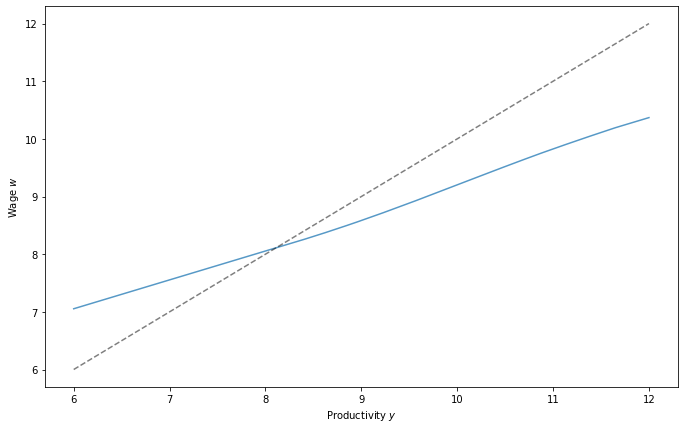

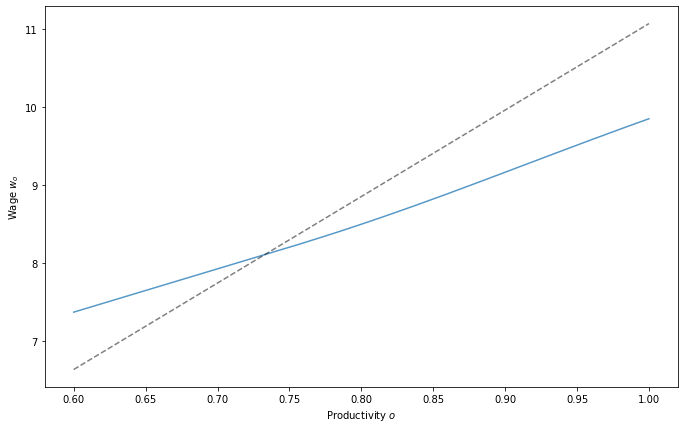

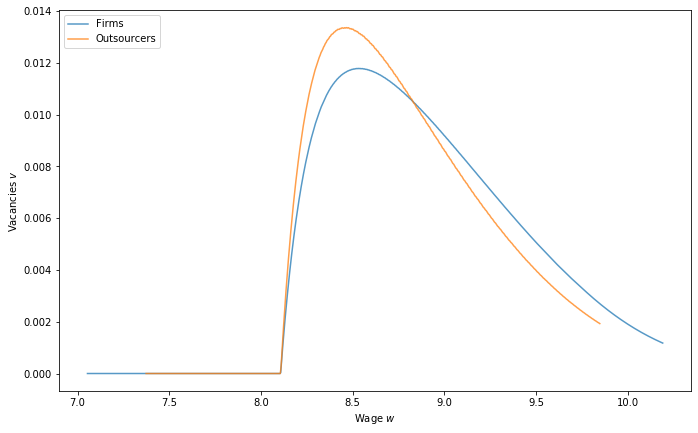

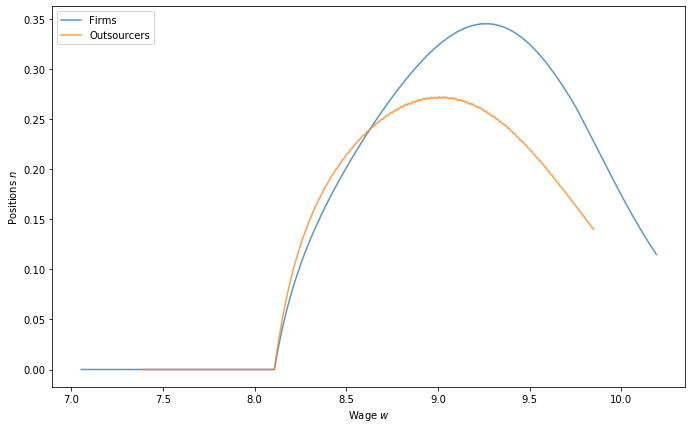

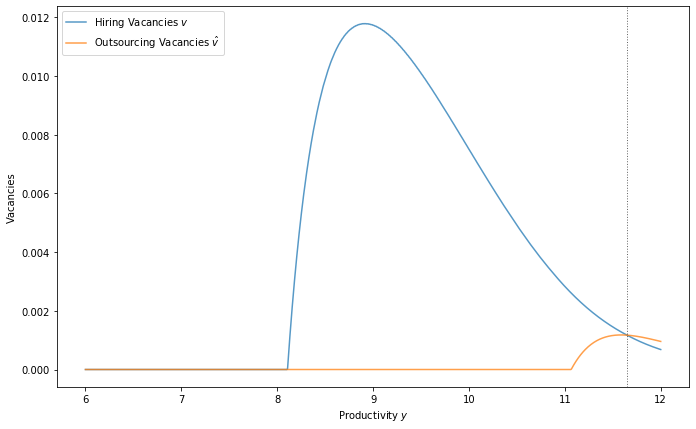

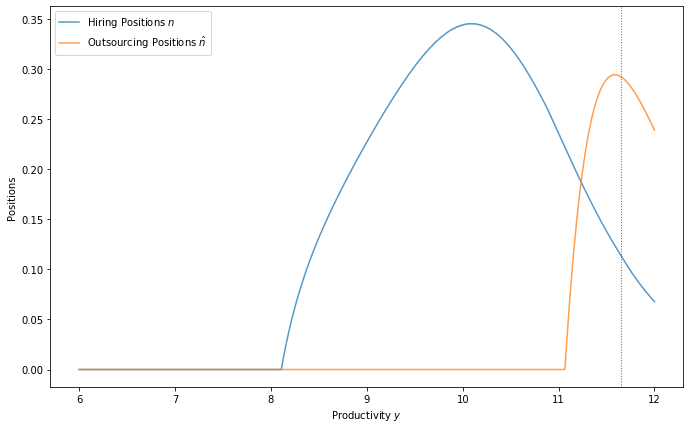

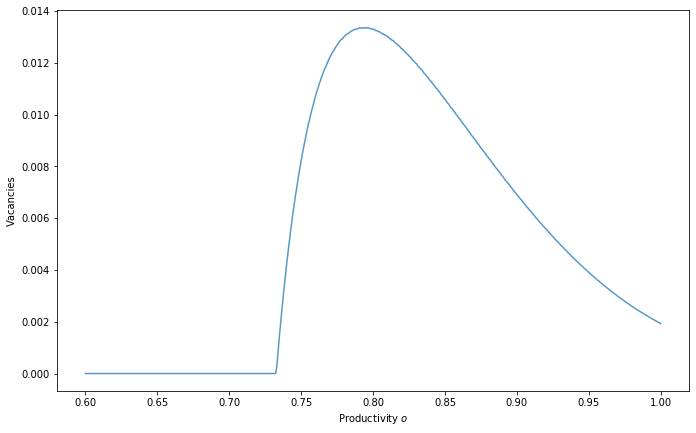

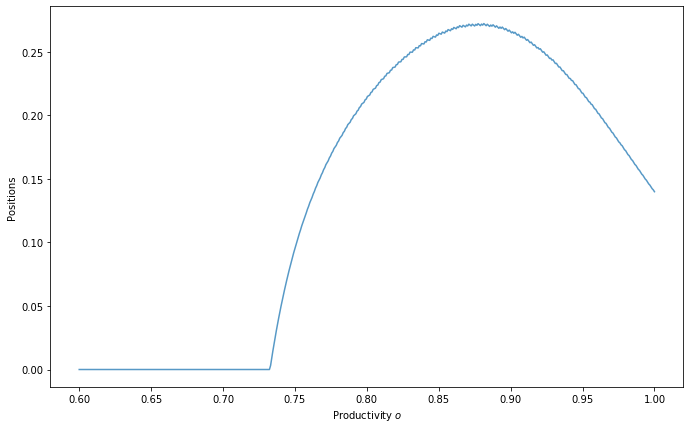

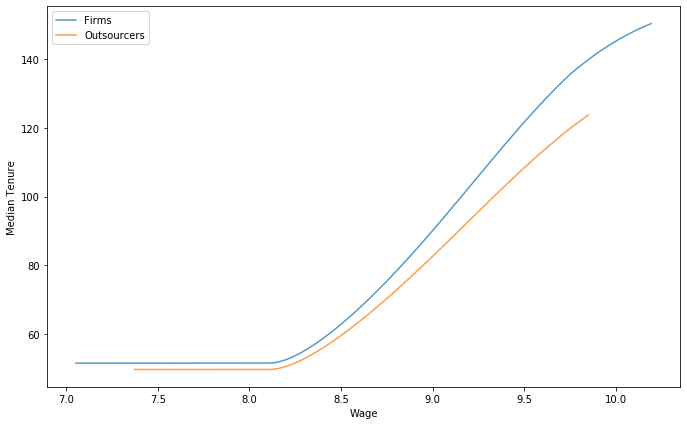

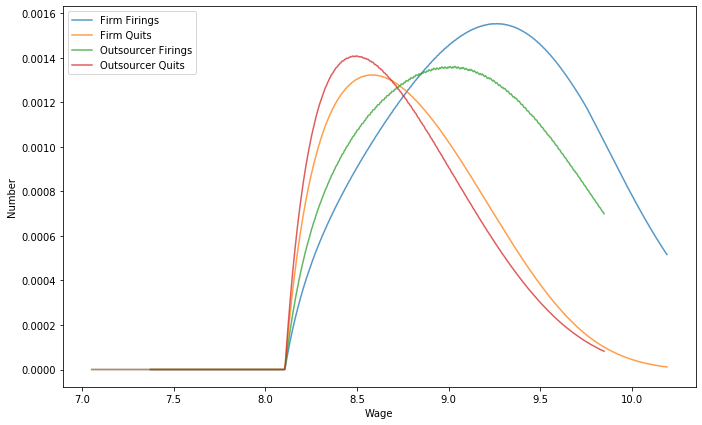

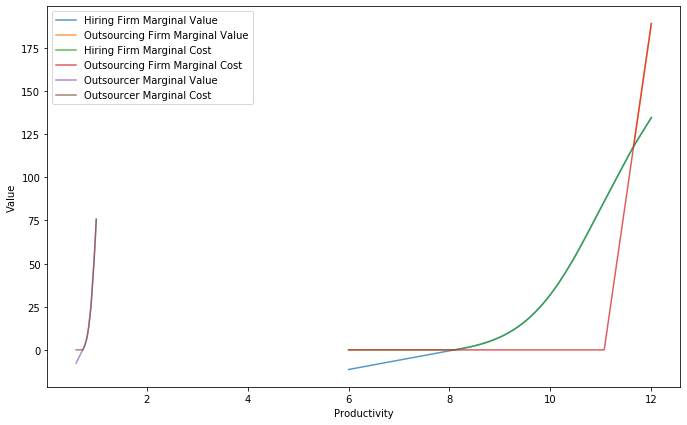

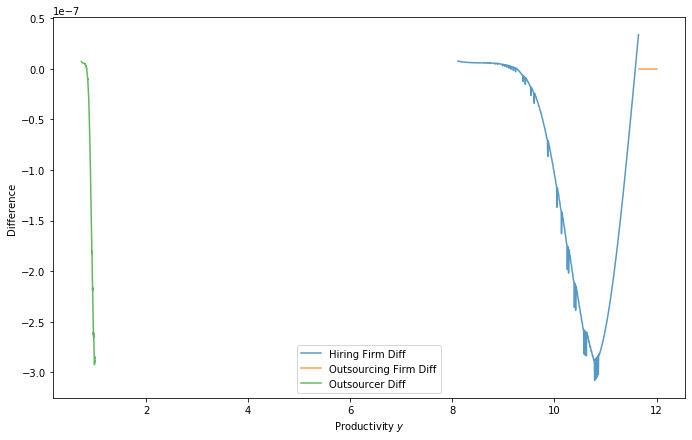

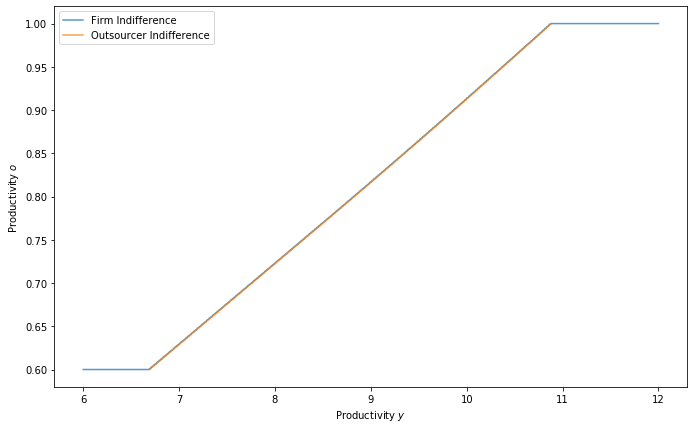

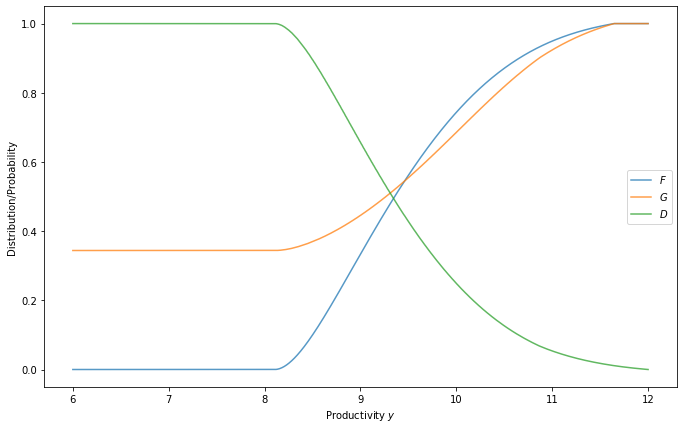

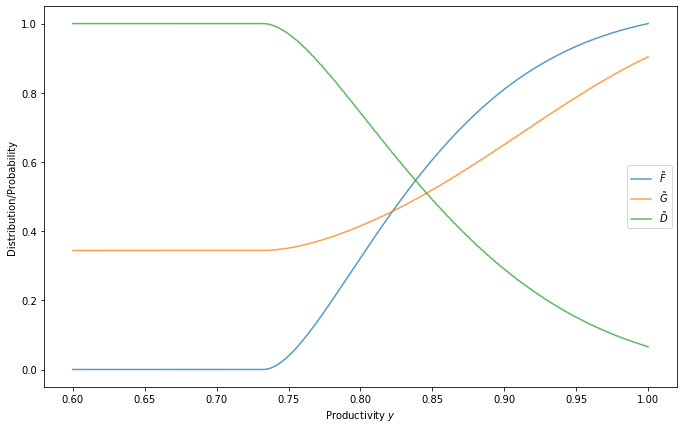

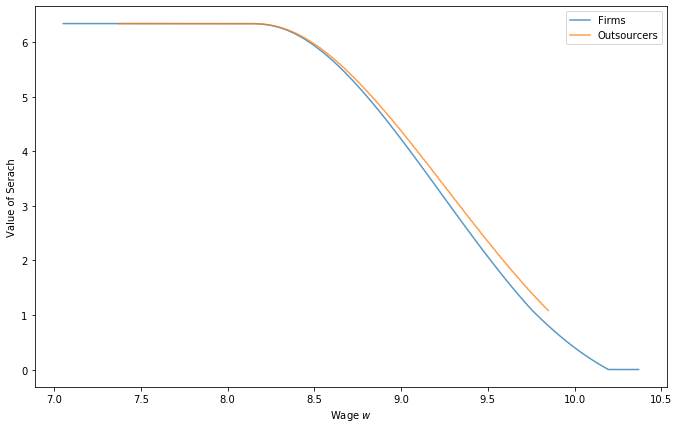

In [44]:
r = 0.000939
B = 1 / (1 + r)
delta = 0.0045
delta_o = 0.0050
delta_hat = 0.0040
xi = .1
# xi = 0
eta = 0.5
eta_o = 0.5
phi = 2e-1 
y_min = 6
y_max = 12
o_min = 0.6
o_max = 1.0
b = y_min * .4 
y_grid_size = int(1000)
# y_grid_size = 8000
o_grid_size = int(500)
gamma = 2
gamma_o = 2
k_grid = np.logspace(0, 5, y_grid_size, endpoint = False)
k_o_grid = np.logspace(0, 4, o_grid_size, endpoint = False)
# k_grid = 1e9
# k_o_grid = 1e9

p_low = 10
p_high = 12
tol = 1e-4
max_iter = 20
tol_i = 1e-6
max_iter_i = 5e4
slow_i = 1e-1
print_skip = 5
verbose = True

save = False

ooj = OutsourcingOnJob(
    B, b, delta, delta_o, delta_hat, xi, eta, eta_o, phi,
    y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
    gamma, gamma_o, k_grid, k_o_grid
)

# Record initial guesses
v_grid = np.ones(y_grid_size) / y_grid_size
n_grid = np.ones(y_grid_size) / y_grid_size
v_hat_grid = np.ones(y_grid_size) / y_grid_size
n_hat_grid = np.ones(y_grid_size) / y_grid_size
v_o_grid = np.ones(o_grid_size) / o_grid_size
n_o_grid = np.ones(o_grid_size) / o_grid_size
y_hat = 12
R_grid = np.minimum(np.arange(y_grid_size), o_grid_size - 1, dtype=np.int64)
R_o_grid = np.minimum(np.arange(o_grid_size), y_grid_size - 1, dtype=np.int64)

guess = v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid

# solve_given_p, _, _, _, _, _, _, _, _, _, _, _, _ = operator_factory(ooj)

# # Base guess on p = 12 (this almost always converges, and is in a nicer shape)
# guess = solve_given_p(
#         12, v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
#         n_o_grid, y_hat, R_grid, R_o_grid, 1e-4, 2e4, 1e-1
#     )

# print(guess[0][0])

qe.tic()
(v_grid, v_hat_grid, v_o_grid, n_grid,
 n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p) = find_p(
    ooj, guess, p_low, p_high, tol, max_iter, tol_i, max_iter_i, slow_i, verbose, print_skip
)
qe.toc()

folder=r'C:/Users/spspi/Dropbox/Documents/Outsourcing/Figures/Python Simulations/Example 2'
file=r'/'
f = None

if save:
    f = open(folder + file + "Details.txt", "w")
    k_names = """
    k_grid = np.logspace(0, 5, y_grid_size, endpoint = False) \n 
    k_o_grid = np.logspace(0, 4, o_grid_size, endpoint = False) \n    
    """
    save_parameters(ooj, f, p_low, p_high, tol, max_iter, tol_i, max_iter_i, slow_i, k_names)
    
    
list_facts(ooj, v_grid, v_hat_grid, v_o_grid, n_grid,
               n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p, f=f)

graph_results(ooj, v_grid, v_hat_grid, v_o_grid, n_grid,
              n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p, 
              save=save, folder=folder, file=file)

if save:
    f.close()

In [3]:
# Set up code for the outsourcer's problem with on-the-job search
# Builds on Outsourcers file
# This block of code separates v_grid of hiring from v_hat_grid of outsourcing
# Older version that utilizes bisection in code

import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit, jitclass, int64, float64
from interpolation import interp
from IPython.core.debugger import set_trace
from scipy.optimize import minimize

# Set up parameter space
ooj_parameters = [
    ("B", float64),
    ("r", float64),
    ("b", float64),
    ("delta", float64),
    ("delta_o", float64),
    ("delta_hat", float64),
    ("xi", float64),
    ("eta", float64),
    ("eta_o", float64),
    ("phi", float64),
    ("y_grid", float64[:]),
    ("y_grid_size", int64),
    ("rm", float64),
    ("o_grid", float64[:]),
    ("o_grid_size", int64),
    ("rm_o", float64),
    ("phi", float64),
    ("gamma", float64),
    ("k_grid", float64[:]),
    ("gamma_o", float64),
    ("k_o_grid", float64[:])    
]

@jitclass(ooj_parameters)
class OutsourcingOnJob:
    """
    B is discount rate beta
    r is interest rate defined by beta
    b is home production
    delta is job loss rate at firm
    delta_o is job loss rate at outsourcer
    delta_hat is firm destruction rate of outsourcing firm <= delta
    xi is probability of searching on-the-job
    eta is workers bargaining power with firm
    eta_o is workers bargaining power with outsourcer
    phi is effectiveness of matching function
    y_min, y_max, y_grid_size determine firm productivity grid
    rm is to Reimann Sum approximate firm integrals
    o_min, o_max, o_grid_size determine outsourcer productivity grid
    rm_o is to Reimann Sum approximate outsourcer integrals
    gamma is steepness of marginal cost, 
    k_grid is level of entry cost
    gamma_h is steepness of marginal cost for outsourcers, 
    k_o_grid is level of cost
    """
    def __init__(
        self, B, b, delta, delta_o, delta_hat, xi, eta, eta_o, phi,
        y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
        gamma, gamma_o, k_grid, k_o_grid
    ):
        
        self.B, self.b, self.delta, self.eta, self.gamma, self.k_grid = B, b, delta, eta, gamma, k_grid
        self.delta_hat, self.eta_o, self.gamma_o, self.k_o_grid = delta_hat, eta_o, gamma_o, k_o_grid 
        self.xi, self.delta_o = xi, delta_o
        self.r = 1 / B - 1
        
#         self.y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
        self.y_grid = np.linspace(y_min, y_max, y_grid_size)
        self.y_grid_size = y_grid_size    
        self.rm = (y_max - y_min) / y_grid_size
        
#         self.o_grid = np.linspace(o_min, o_max, o_grid_size, endpoint = False)
        self.o_grid = np.linspace(o_min, o_max, o_grid_size)
        self.o_grid_size = o_grid_size    
        self.rm_o = (o_max - o_min) / o_grid_size
        
        self.phi = phi
#         self.q = njit(lambda x: min(phi * x**(-1 / 2), 1))
#         self.ell = njit(lambda x: min(phi * x**(1 / 2), 1))
#         # Remember, q_p and p_p = 0 if q or p = 1
#         self.q_p = njit(lambda x: -phi / 2 * x**(-3 / 2) * (phi * x**(-1 / 2) < 1)) 
#         self.ell_p = njit(lambda x: phi / 2 * x**(1 / 2) * (phi * x**(1 / 2) < 1))


# Set up neccesary functions
def operator_factory(ooj):
    
    r, b, delta, eta, gamma, k_grid = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma, ooj.k_grid
    delta_hat, eta_o, gamma_o, k_o_grid = ooj.delta_hat, ooj.eta_o, ooj.gamma_o, ooj.k_o_grid
    xi, delta_o = ooj.xi, ooj.delta_o
    phi = ooj.phi
    
    y_grid, y_grid_size, rm = ooj.y_grid, ooj.y_grid_size, ooj.rm
    o_grid, o_grid_size, rm_o = ooj.o_grid, ooj.o_grid_size, ooj.rm_o
    
    
    @njit()
    def q(theta):
        return min(phi * theta**(-1 / 2), 1)
    
    @njit()
    def ell(theta):
        return min(phi * theta**(1 / 2), 1)
    
    # Want cost of vacancy, marginal cost of vacancy, and inverse marginal cost of vacancy
    @njit()
    def C(v_grid):
        return k_grid * v_grid**gamma
    
    @njit()
    def c(v_grid):
        return k_grid * gamma * v_grid**(gamma - 1)

    @njit()
    def c_inv(c_grid):
        return (np.maximum(c_grid, 0) / (gamma * k_grid))**(1 / (gamma - 1))
        
    # Do the same for outsourcers
    @njit()
    def C_o(v_o_grid):
        return k_o_grid * v_o_grid**gamma_o

    @njit()
    def c_o(v_o_grid):
        return k_o_grid * gamma_o * v_o_grid**(gamma_o - 1)

    @njit()
    def c_o_inv(c_o_grid):
        return (np.maximum(c_o_grid, 0) / (gamma_o * k_o_grid))**(1 / (gamma_o - 1))
    
    # Given a continuous y_hat, find the nearest y_i
    @njit()
    def find_y_i(y_hat):
        return np.argmin(np.abs(y_hat - y_grid))
    
    # Given v_grid, v_o_grid, n_grid,
    # n_o_grid, y_hat, R_grid, R_o_grid, and p, find
    # Firms who directly hire hire vs those that outsource out
    # Market tightness theta
    # Distribution of vacanices F and F_o
    # Distribution of job seekers G and G_o
    # Probability of worker leaving D and D_o
    # Wages w and w_o
    @njit()
    def make_grids(v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p):    
        
        y_i = find_y_i(y_hat)
        
        # Make this here, but useful for F and G below
        n_temp = np.copy(n_grid)
        n_temp[y_i:] = 0
        
        cum_v = np.cumsum(v_grid * rm)
        cum_v_o = np.cumsum(v_o_grid * rm_o)
        cum_n = np.cumsum(n_temp * rm)
        cum_n_o = np.cumsum(n_o_grid * rm_o)
        
        # Define aggregate populations (make sure all exist)
        u = max(1 - cum_n[-1] - cum_n_o[-1], 1e-9)
        v = max(cum_v[-1], 1e-9)
        v_o = max(cum_v_o[-1], 1e-9)
        s = u + xi * (cum_n[-1] + cum_n_o[-1])
        
        # Calculate theta and pi 
        v_sum = v + v_o
        theta = v_sum / s
        pi = v_o / v_sum
        
        # Calculate distributions 
        # F is distribution of vacancies (include firms above y_hat in cdf as 1)
        F_grid = np.minimum(cum_v / v, 1)
        f_grid = v_grid / v
        f_grid[y_i:] = 0
        
        F_o_grid = cum_v_o / v_o
        f_o_grid = v_o_grid / v_o
        
        # G is distribution of job seekers (include firms above y_hat as bigger than all y firms)        
        G_grid = (u + xi * (cum_n + cum_n_o[R_grid])) / s
        G_o_grid = (u + xi * (cum_n[R_o_grid] + cum_n_o)) / s
        
        # D is probability a worker finds a better job
        D_grid = xi * ell(theta) * (1 - (1 - pi) * F_grid - pi * F_o_grid[R_grid]) 
        D_o_grid = xi * ell(theta) * (1 - (1 - pi) * F_grid[R_o_grid] - pi * F_o_grid) 
        
        # What is the value of search?
        # Store these vectors of values which will be used many times
        f_tot = c(v_grid) / G_grid * f_grid * rm
        o_tot = c_o(v_o_grid) / G_o_grid * f_o_grid * rm_o
        i_cum_f = np.cumsum(f_tot[::-1])[::-1]
        i_cum_o = np.cumsum(o_tot[::-1])[::-1]
        
        # For unemployed
        firm = eta / (1 - eta) * (1 - pi) * i_cum_f[0]
        out = eta_o / (1 - eta_o) * pi * i_cum_o[0]
        Gamma_U = ell(theta) / q(theta) * (firm + out)
        
        # For employed at a firm
        firm = eta / (1 - eta) * (1 - pi) * i_cum_f
        out = eta_o / (1 - eta_o) * pi * i_cum_o[R_grid]
        Gamma_grid = ell(theta) / q(theta) * (firm + out)
        
        # For employed at an outsourcer
        firm = eta / (1 - eta) * (1 - pi) * i_cum_f[R_o_grid]
        out = eta_o / (1 - eta_o) * pi * i_cum_o
        Gamma_o_grid = ell(theta) / q(theta) * (firm + out)
        
        # Find wages
        w_grid = eta * y_grid + (1 - eta) * (b + Gamma_U - (1 - delta) * xi * Gamma_grid) 
        w_o_grid = eta_o * p * o_grid + (1 - eta_o) * (b + Gamma_U - (1 - delta_o) * xi * Gamma_o_grid) 
        
        return (
            theta, G_grid, G_o_grid, D_grid, D_o_grid, 
            Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid
        )
    
    # Given v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
    # n_o_grid, y_hat, R_grid, R_o_grid, and p, find new values
    @njit()
    def iterate(v_grid, v_hat_grid, v_o_grid, n_grid,
                n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p):
        
        (theta, G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)
        
        # Value of firms
        J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + (1 - delta) * D_grid)
        J_out = (y_grid - p) / (r + delta_hat)
        
        # Update y_hat by finding firm closest to indifferent between hiring/outsourcing
        # Make sure J_out is non_negative at y_hat
        y_diff = np.argmin(np.abs(J_out - J_hire))
        y_zero = np.argmin(np.abs(J_out))
        y_hat_new = y_grid[max(y_diff, y_zero)]
        
        # Update vacancies
        # Hiring firms (below y_hat)
        v_grid_new = c_inv(J_hire)
        
        # Outsourcing firms (above y_hat)
        v_hat_grid_new = c_inv(J_out)
        
        # Outsourcers
        v_o_grid_new = c_o_inv(
            (o_grid * p - w_o_grid) * q(theta) * G_o_grid / (r + delta_o + (1 - delta_o) * D_o_grid)
        )
        
        # Update positions
        # Hiring firms
        n_grid_new = (1 - delta) * (1 - D_grid) * n_grid + q(theta) * G_grid * v_grid_new
        
        # Outsourcing firms
        n_hat_grid_new = (1 - delta_hat) * n_hat_grid + v_hat_grid_new
        
        # Outsourcers
        n_o_grid_new = (1 - delta_o) * (1 - D_o_grid) * n_o_grid + q(theta) * G_o_grid * v_o_grid_new
               
        # Update R_grid and R_o_grid by comparing W - U to W_o - U.
        # Note that R_grid is defined for all firms, even those above 
        # y_hat, and R_o_grid might be indiffeferent to a firm above y_hat that doesn't hire
        # Value of employment at a firm (minus value of unemployment)        
        W_min_U = (
            (1 + r) * (w_grid - b - Gamma_U + (1 - delta) * xi * Gamma_grid)
            / (r + delta + (1 - delta) * D_grid)
        )
        
        # Value of employment at an outsourcer (minus value of unemployment)
        W_o_min_U = (
            (1 + r) * (w_o_grid - b - Gamma_U + (1 - delta_o) * xi * Gamma_o_grid)
            / (r + delta_o + (1 - delta_o) * D_o_grid)
        )

        # Use these and search sorted to find new indecision rules (make sure not above all)
        R_grid_new = np.minimum(np.searchsorted(W_o_min_U, W_min_U), o_grid_size - 1)
    
        R_o_grid_new = np.minimum(np.searchsorted(W_min_U, W_o_min_U), y_grid_size - 1)
        
        return (v_grid_new, v_hat_grid_new, v_o_grid_new, n_grid_new,
                n_hat_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new)
    
    # Given n_grid, n_o_grid, and y_hat find excess demand for outsourcing 
    @njit()
    def QD_QS_ED(n_hat_grid, n_o_grid, y_hat):
        y_i = find_y_i(y_hat)
        QD = np.sum(n_hat_grid[y_i:] * rm) 
        QS = np.sum(n_o_grid * o_grid * rm_o)
        ED = QD - QS
        return QD, QS, ED

    @njit()
    def solve_given_p(
        p, v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
        n_o_grid, y_hat, R_grid, R_o_grid, tol, max_iter, slow
    ):

        # Set up initial loop parameters
        i = 0
        err = tol + 1    

        # Update v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, and R_o_grid
        while i < max_iter and err > tol:
            (v_grid_new, v_hat_grid_new, v_o_grid_new, n_grid_new,
                    n_hat_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new) = iterate(
                v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
            )
            err_v_t = np.max(np.abs(v_grid_new - v_grid))
            err_v_h = np.max(np.abs(v_hat_grid_new - v_hat_grid))
            err_v_o = np.max(np.abs(v_o_grid_new - v_o_grid))
            err_n_t = np.max(np.abs(n_grid_new - n_grid))
            err_n_h = np.max(np.abs(n_hat_grid_new - n_hat_grid))
            err_n_o = np.max(np.abs(n_o_grid_new - n_o_grid))
            err = max(err_v_t, err_v_h, err_v_o, err_n_t, err_n_h, err_n_o)
            i += 1

            v_grid = slow * v_grid_new + (1 - slow) * v_grid
            v_hat_grid = slow * v_hat_grid_new + (1 - slow) * v_hat_grid
            v_o_grid = slow * v_o_grid_new + (1 - slow) * v_o_grid
            n_grid = slow * n_grid_new + (1 - slow) * n_grid
            n_hat_grid = slow * n_hat_grid_new + (1 - slow) * n_hat_grid
            n_o_grid = slow * n_o_grid_new + (1 - slow) * n_o_grid
            y_hat = slow * y_hat_new + (1 - slow) * y_hat 

            # To slowly adjust y_hat, R_grid, and R_o_grid (which are indexes), instead 
            # add/subtract by 1 if greater/less 
            R_grid = R_grid + 1 * (R_grid_new > R_grid) - 1 * (R_grid_new < R_grid)
            R_o_grid = R_o_grid + 1 * (R_o_grid_new > R_o_grid) - 1 * (R_o_grid_new < R_o_grid)     

        return (
            v_grid_new, v_hat_grid_new, v_o_grid_new, n_grid_new,
            n_hat_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new
        )        
    
    return solve_given_p, iterate, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell 

# Find p
def find_p(
    ooj, guess, p_low, p_high, tol, max_iter, tol_i, max_iter_i, slow_i, verbose=True, print_skip=100
):
    
    solve_given_p, _, QD_QS_ED, _, _, _, _, _, _, _, _, _, _ = operator_factory(ooj)
    
    # Set up loop parameters    
    err = tol + 1
    j = 0
    test = []
    
    # Find excess_demand for p_low and p_high, make sure they have opposite signs
    for p in [p_low, p_high]:
#         qe.tic()
        # Initial guesses
        (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid) = guess
        
        (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid) = solve_given_p(
            p, v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
            n_o_grid, y_hat, R_grid, R_o_grid, tol=1e-2, max_iter=1e4, slow=1e-1
        )
        
        QD, QS, ED = QD_QS_ED(n_hat_grid, n_o_grid, y_hat)
        test.append(ED)
#         qe.toc()
        
        if verbose:
            print(f'Excess Demand for price {p} is {ED:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
            
#         set_trace()
            
    if np.cumprod(test)[1] > 0:
        print('Test failed, both prices have positive/negative excess demand')
        return
    
    
    # Initial guesses (reset initially)
    (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
     n_o_grid, y_hat, R_grid, R_o_grid) = guess
        
    while err > tol and j < max_iter:
#         qe.tic()
        p = (p_low + p_high) / 2    
              
        (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid) = solve_given_p(
            p, v_grid, v_hat_grid, v_o_grid, n_grid,
            n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, tol_i, max_iter_i, slow_i
        )
        
        QD, QS, ED = QD_QS_ED(n_hat_grid, n_o_grid, y_hat)
        err = np.abs(ED)
        
        # If excess demand QD - QS > 0, set p_low = p, otherwise p_high = p
        if ED > 0:
            p_low = p
        else:
            p_high = p
            
        if verbose and j % print_skip == 0:
            print(
                f'Excess Demand at iter {j} is {ED:.4f}; price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}',
                f"y_hat is {y_hat:.4f}"
            )
            
        j += 1
        
#         qe.toc()
        
#     # Run through one more loop with lower tolerance and more iterations
#     (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
#          n_o_grid, y_hat, R_grid, R_o_grid) = solve_given_p(
#             p, v_grid, v_hat_grid, v_o_grid, n_grid,
#             n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, 1e-8, 1e5, slow_i
#         )  
    
#     QD, QS, ED = QD_QS_ED(n_hat_grid, n_o_grid, y_hat)
#     err = np.abs(ED)
    
    if j < max_iter:
        print(f'Converged in {j} iterations, Excess Demand is {ED:.4f};',
              f' price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
    if j == max_iter:
        print(f'Failed to Converge. Excess Demand is {ED:.4f}; price is {p:.4f};',
              f' QS is {QS:.4f}; QD is {QD:.4f}')
        
    return v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p

# Create a function to graph results
def graph_results(ooj, v_grid, v_hat_grid, v_o_grid, n_grid,
                  n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p,
                  save=False, height=7, 
                  folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures\Python Simulations\Test',
                  file=r'\Outsourcers OJS '):
    
    # Make sure dimensions are 1:1.62
    width = height * 1.62
    
    # Get data needed from ooj
    _, _, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj)
    
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    r, delta, xi = ooj.r, ooj.delta, ooj.xi
    delta_o, delta_hat = ooj.delta_o, ooj.delta_hat
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    y_grid_size, o_grid_size = ooj.y_grid_size, ooj.o_grid_size
    
    y_i = find_y_i(y_hat)
        
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, w_grid, alpha=0.75)
    ax.plot(y_grid, y_grid, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Wage $w$")
    
    if save:
        fig.savefig(folder + file + 'Firm Wages v Productivity.pdf')
    else:
        plt.show()  
        
    # Graph outsourcer wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, w_o_grid, alpha=0.75)
    ax.plot(o_grid, o_grid * p, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $o$", ylabel="Wage $w_o$")
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Wages v Productivity.pdf')
    else:
        plt.show() 
        
    # Graph vacacies by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], v_grid[:y_i], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, v_o_grid, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Vacancies $v$")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Vacancies v Wages.pdf')
    else:
        plt.show()         
    
    # Graph filled posititions by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], n_grid[:y_i], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, n_o_grid, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Positions $n$")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Positions v Wages.pdf')
    else:
        plt.show() 
        
    # Graph firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid, alpha=0.75, label=r"Hiring Vacancies ${v}$")
    ax.plot(y_grid, v_hat_grid, alpha=0.75, label=r"Outsourcing Vacancies $\hat{v}$")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firm Vacancies.pdf')
    else:
        plt.show()
        
    # Graph firm postions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid, alpha=0.75, label=r"Hiring Positions ${n}$")
    ax.plot(y_grid, n_hat_grid, alpha=0.75, label=r"Outsourcing Positions $\hat{n}$")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Positions")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firm Positions.pdf')
    else:
        plt.show()
        
    # Graph outsourcer vacancies and filled positions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, v_o_grid_p, alpha=0.75, label=r"Vacanicies $\tilde{v}$")
    ax.set(xlabel="Productivity $o$", ylabel="Vacancies")
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Vacancies.pdf')
    else:
        plt.show()
        
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, n_o_grid_p, alpha=0.75, label=r"Positions $\tilde{n}$")
    ax.set(xlabel="Productivity $o$", ylabel="Positions")
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Positions.pdf')
    else:
        plt.show()
        
    # Graph median tenure by wage
    p_stay = (1 - delta) * (1 - D_grid)
    median_tenure = np.log(.5) / np.log(p_stay)
    p_o_stay = (1 - delta_o) * (1 - D_o_grid)
    median_tenure_o = np.log(.5) / np.log(p_o_stay)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], median_tenure[:y_i], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, median_tenure_o, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage", ylabel="Median Tenure")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Median Tenure.pdf')
    else:
        plt.show()
        
    # Graph firings (lose jobs) vs quits (find better job) by wage
    firings = delta * n_grid
    quits = (1 - delta) * D_grid * n_grid
    firings_o = delta_o * n_o_grid_p
    quits_o = (1 - delta_o) * D_o_grid * n_o_grid_p
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], firings[:y_i], alpha=0.75, label="Firm Firings")
    ax.plot(w_grid[:y_i], quits[:y_i], alpha=0.75, label="Firm Quits")
    ax.plot(w_o_grid, firings_o, alpha=0.75, label="Outsourcer Firings")
    ax.plot(w_o_grid, quits_o, alpha=0.75, label="Outsourcer Quits")
    ax.set(xlabel="Wage", ylabel="Number")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firings and Quits.pdf')
    else:
        plt.show()
        
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    # Do the same for outsourcers hiring
    J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + (1 - delta) * D_grid)
    mc = c(v_grid)   
    
    J_out = (y_grid - p) / (r + delta_hat) 
    mc_hat = c(v_hat_grid) 
    
    O = q(theta) * G_o_grid * (p * o_grid - w_o_grid) / (r + delta_o + (1 - delta_o) * D_o_grid)
    mc_o = c_o(v_o_grid) 
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_hire, alpha=0.75, label="Hiring Firm Marginal Value")
    ax.plot(y_grid[y_i:], J_out[y_i:], alpha=0.75, label="Outsourcing Firm Marginal Value")
    ax.plot(y_grid, mc, alpha=0.75, label="Hiring Firm Marginal Cost")
    ax.plot(y_grid, mc_hat, alpha=0.75, label="Outsourcing Firm Marginal Cost")
    ax.plot(o_grid, O, alpha=0.75, label="Outsourcer Marginal Value")
    ax.plot(o_grid, mc_o, alpha=0.75, label="Outsourcer Marginal Cost")
    ax.set(xlabel="Productivity", ylabel="Value")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'M Value and Cost.pdf')
    else:
        plt.show()
        
    # Plot the differences from the above curves
    J_hire_diff = J_hire - mc
    J_out_diff = J_out - mc_hat
    O_diff = O - mc_o
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i][v_grid[:y_i] > 0],
            J_hire_diff[:y_i][v_grid[:y_i] > 0], alpha=0.75, label="Hiring Firm Diff")
    ax.plot(y_grid[y_i:], J_out_diff[y_i:], alpha=0.75, label="Outsourcing Firm Diff")
    ax.plot(o_grid[v_o_grid > 0], O_diff[v_o_grid > 0], alpha=0.75, label="Outsourcer Diff")
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'M Value Minus Cost.pdf')
    else:
        plt.show()
        
    # Plot the workers' indifference curve for hired vs outsourced
    o_R_grid = o_grid[R_grid]
    y_R_o_grid = y_grid[R_o_grid]
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, o_R_grid, alpha=0.75, label="Firm Indifference")
    ax.plot(y_R_o_grid, o_grid, alpha=0.75, label="Outsourcer Indifference")    
    ax.set(xlabel="Productivity $y$", ylabel="Productivity $o$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "Worker's Indifference Curve.pdf")
    else:
        plt.show()
        
    # Plot various distribributions for the firm
    v = np.sum(v_grid[:y_i] * rm)
    F_grid = np.minimum(np.cumsum(v_grid * rm) / v, 1)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, F_grid, alpha=0.75, label=r"$F$")  
    ax.plot(y_grid, G_grid, alpha=0.75, label=r"$G$") 
    ax.plot(y_grid, D_grid / (xi * ell(theta)), alpha=0.75, label=r"$D$")  
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "Firm Distributions.pdf")
    else:
        plt.show()
        
    # Plot various distribributions for the outsourcer
    v_o = np.sum(v_o_grid * rm_o)
    F_o_grid = np.cumsum(v_o_grid * rm_o) / v_o
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, F_o_grid, alpha=0.75, label=r"$\tilde{F}$")  
    ax.plot(o_grid, G_o_grid, alpha=0.75, label=r"$\tilde{G}$") 
    ax.plot(o_grid, D_o_grid / (xi * ell(theta)), alpha=0.75, label=r"$\tilde{D}$")  
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "Outsourcer Distributions.pdf")
    else:
        plt.show()
        
    # Graph value of search by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid, Gamma_grid, alpha=0.75, label="Firms")
    ax.plot(w_o_grid, Gamma_o_grid, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Value of Serach")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Value of Search.pdf')
    else:
        plt.show()
        
# Create a function to print some facts that are useful
def list_facts(ooj, v_grid, v_hat_grid, v_o_grid, n_grid,
               n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p, f=None):
    
    _, _, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj)
    
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    
    delta, xi = ooj.delta, ooj.xi
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    
    y_i = find_y_i(y_hat)
    
    print(f"The indifferent firm is y_hat = {y_hat:.2f}$. Price of outsourcing is {p:.2f}.")
    
    u = 1 - np.sum(n_grid[:y_i] * rm) - np.sum(n_o_grid * rm_o) 
    pi = np.sum(v_o_grid * rm_o) / (np.sum(v_grid[:y_i] * rm) + np.sum(v_o_grid * rm_o))
    zeta = np.sum(n_o_grid * rm_o) / (np.sum(n_grid[:y_i] * rm) + np.sum(n_o_grid * rm_o))
    e_delta = (1 - zeta) * delta + zeta * delta_o 
    u_lom = e_delta / (e_delta + ell(theta))
    tot_v = np.sum(v_grid[:y_i] * rm) + np.sum(v_o_grid * rm_o)
    
    print(f"Unemployment is {u * 100:.2f}. According to LoM, should be {u_lom * 100:.2f}")
    print(f"Workers match with probability {ell(theta) * 100:.2f}.",
          f"Firms/Outsourcers match with probability {q(theta) * 100:.2f}")
    print(f"Total vacancies searching for workers are {tot_v:.4f}. Theta is {theta:.4f}")
    print(f"{pi * 100:.0f} percent of vacancies searching for workers are from outsourcers,",
          f"{zeta * 100:.0f} percent of postions outsourced")
    
    # Document ue rate, ee rate, and percent of jobs from unemployment
    ue = ell(theta)
    ee = (
        (np.sum(n_grid[:y_i] * D_grid[:y_i] * rm) / np.sum(n_grid[:y_i] * rm) + 
         np.sum(n_o_grid * D_o_grid * rm_o) / np.sum(n_o_grid * rm_o))
    )
    per_from_u = 100 * ue * u / (ue * u + ee * (1 - u))
    print(f"The ue rate is {ue:.4f}, the ee rate is {ee:.4f},",
          f" and {per_from_u:0f} of new jobs are from unemployment")  
                       
    # Do firm/outsourcer vacancies and positions line up in steady state?
    n_ss = v_grid * q(theta) * G_grid / (delta + D_grid - delta * D_grid)
    err = max(np.abs(n_ss - n_grid))
    err_at = np.argmax(np.abs(n_ss - n_grid))
    
    n_ss_hat = v_hat_grid / delta_hat
    err_hat = max(np.abs(n_ss_hat - n_hat_grid))
    err_hat_at = np.argmax(np.abs(n_ss_hat - n_hat_grid))
    
    n_o_ss = v_o_grid * q(theta) * G_o_grid / (delta_o + D_o_grid - delta_o * D_o_grid)
    err_o = max(np.abs(n_o_ss - n_o_grid))
    err_o_at = np.argmax(np.abs(n_o_ss - n_o_grid))
    
    print(
        "Checking if vacancies + LoM imply right positions:\n",
         f"Hiring firms largest error = {err:.6f} at position {err_at} \n",
         f"Outsourcing firms largest error = {err_hat:.6f} at position {err_hat_at}\n",
         f"Outsourcer largest error = {err_o:.6f} at position {err_o_at}"
    )  
    
    # If want to save everything in an output file
    if f is not None:
        f.write(f"""
        Some facts about the model: \n
        The indifferent firm is y_hat = {y_hat:.2f}$. Price of outsourcing is {p:.2f}. \n
        Unemployment is {u * 100:.2f}. According to LoM, should be {u_lom * 100:.2f} \n
        Workers match with probability {ell(theta) * 100:.2f}. \n
        Firms/Outsourcers match with probability {q(theta) * 100:.2f} \n
        Total vacancies searching for workers are {tot_v:.4f}. Theta is {theta:.4f} \n
        {pi * 100:.0f} percent of vacancies searching for workers are from outsourcers, \n
        {zeta * 100:.0f} percent of postions outsourced \n
        The ue rate is {ue:.4f}, the ee rate is {ee:.4f} \n
        and {per_from_u:0f} of new jobs are from unemployment \n
        Checking if vacancies + LoM imply right positions:\n
        Hiring firms largest error = {err:.6f} at position {err_at} \n
        Outsourcing firms largest error = {err_hat:.6f} at position {err_hat_at}\n
        Outsourcer largest error = {err_o:.6f} at position {err_o_at}
        """)
        
def save_parameters(ooj, f, p_low, p_high, tol, max_iter, tol_i, max_iter_i, slow_i, k_names):
    
    r, b, delta, eta, gamma, k_grid = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma, ooj.k_grid
    delta_hat, eta_o, gamma_o, k_o_grid = ooj.delta_hat, ooj.eta_o, ooj.gamma_o, ooj.k_o_grid
    xi, delta_o = ooj.xi, ooj.delta_o
    phi, gamma, gamma_o = ooj.phi, ooj.gamma, ooj.gamma_o
    
    y_grid, y_grid_size, rm = ooj.y_grid, ooj.y_grid_size, ooj.rm
    o_grid, o_grid_size, rm_o = ooj.o_grid, ooj.o_grid_size, ooj.rm_o
    y_min, y_max, o_min, o_max = ooj.y_min, ooj.y_max, ooj.o_min, ooj.o_max
    
    f.write(f"""
    These are the parameters used for this simulation\n:
    B = {B} \n
    r = {r} \n
    delta = {delta} \n
    delta_o = {delta_o} \n
    delta_hat = {delta_hat} \n 
    eta = {eta} \n
    eta_o = {eta_o} \n
    phi = {phi} \n 
    xi = {xi} \n
    y_min = {y_min} \n 
    y_max = {y_max} \n
    y_grid_size = {y_grid_size} \n
    o_min = {o_min} \n 
    o_max = {o_max} \n
    o_grid_size = {o_grid_size} \n
    b = {b} \n 
    gamma = {gamma} \n 
    gamma_o = {gamma_o} \n 
    """ + k_names)
    
    f.write(f"""
    The code runs using these parameters: \n
    p_low = {p_low} \n
    p_high = {p_high} \n
    tol = {tol} \n
    max_iter = {max_iter} \n
    tol_i = {tol_i} \n
    max_iter_i = {max_iter_i} \n 
    slow_i = {slow_i}    
    """)    

In [59]:
# Set up code for the outsourcer's problem with on-the-job search
# Builds on Outsourcers file
# This block of code separates v_grid of hiring from v_hat_grid of outsourcing
# This file does not have find_p in operator_factory

import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit, vectorize
from IPython.core.debugger import set_trace

class OutsourcingOnJob:
    """
    B is discount rate beta
    r is interest rate defined by beta
    b is home production
    delta is job loss rate at firm
    delta_o is job loss rate at outsourcer
    delta_hat is firm destruction rate of outsourcing firm <= delta
    xi is probability of searching on-the-job
    eta is workers bargaining power with firm
    eta_o is workers bargaining power with outsourcer
    phi is effectiveness of matching function
    y_min, y_max, y_grid_size determine firm productivity grid
    rm is to Reimann Sum approximate firm integrals
    o_min, o_max, o_grid_size determine outsourcer productivity grid
    rm_o is to Reimann Sum approximate outsourcer integrals
    gamma is steepness of marginal cost, k_grid is level of entry cost
    gamma_h is steepness of marginal cost for outsourcers, k_o_grid is level of cost
    q is matching function of firms
    ell is matching function of workerso
    """
    def __init__(
        self, B, b, delta, delta_o, delta_hat, xi, eta, eta_o, phi,
        y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
        gamma, gamma_o, k_grid, k_o_grid
    ):
        
        self.B, self.b, self.delta, self.eta, self.gamma, self.k_grid = B, b, delta, eta, gamma, k_grid
        self.delta_hat, self.eta_o, self.gamma_o, self.k_o_grid = delta_hat, eta_o, gamma_o, k_o_grid 
        self.xi, self.delta_o = xi, delta_o
        self.r = 1 / B - 1
        
        self.y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
        self.y_grid_size = y_grid_size    
        self.rm = (y_max - y_min) / y_grid_size
        self.y_min, self.y_max = y_min, y_max
        
        self.o_grid = np.linspace(o_min, o_max, o_grid_size, endpoint = False)
        self.o_grid_size = o_grid_size    
        self.rm_o = (o_max - o_min) / o_grid_size
        self.o_min, self.o_max = o_min, o_max
        
        self.phi = phi
        self.q = njit(lambda x: min(phi * x**(-1 / 2), 1))
        self.ell = njit(lambda x: min(phi * x**(1 / 2), 1))
#         # Remember, q_p and p_p = 0 if q or p = 1
#         self.q_p = njit(lambda x: -phi / 2 * x**(-3 / 2) * (phi * x**(-1 / 2) < 1)) 
#         self.ell_p = njit(lambda x: phi / 2 * x**(1 / 2) * (phi * x**(1 / 2) < 1))


# Set up neccesary functions
def operator_factory(ooj):
    
    r, b, delta, eta, gamma, k_grid = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma, ooj.k_grid
    delta_hat, eta_o, gamma_o, k_o_grid = ooj.delta_hat, ooj.eta_o, ooj.gamma_o, ooj.k_o_grid
    xi, delta_o = ooj.xi, ooj.delta_o
    q, ell = ooj.q, ooj.ell
    
    y_grid, y_grid_size, rm = ooj.y_grid, ooj.y_grid_size, ooj.rm
    o_grid, o_grid_size, rm_o = ooj.o_grid, ooj.o_grid_size, ooj.rm_o
    
    # Want cost of vacancy, marginal cost of vacancy, and inverse marginal cost of vacancy
    @njit()
    def C(v_grid):
        return k_grid * v_grid**gamma
    
    @njit()
    def c(v_grid):
        return k_grid * gamma * v_grid**(gamma - 1)

    @njit()
    def c_inv(c_grid):
        return (np.maximum(c_grid, 0) / (gamma * k_grid))**(1 / (gamma - 1))
        
    # Do the same for outsourcers
    @njit()
    def C_o(v_o_grid):
        return k_o_grid * v_o_grid**gamma_o

    @njit()
    def c_o(v_o_grid):
        return k_o_grid * gamma_o * v_o_grid**(gamma_o - 1)

    @njit()
    def c_o_inv(c_o_grid):
        return (np.maximum(c_o_grid, 0) / (gamma_o * k_o_grid))**(1 / (gamma_o - 1))
    
    # Given a continuous y_hat, find the nearest y_i
    @njit()
    def find_y_i(y_hat):
        return np.argmin(np.abs(y_hat - y_grid))
    
    # Given v_grid, v_o_grid, n_grid,
    # n_o_grid, y_hat, R_grid, R_o_grid, and p, find
    # Firms who directly hire hire vs those that outsource out
    # Market tightness theta
    # Distribution of vacanices F and F_o
    # Distribution of job seekers G and G_o
    # Probability of worker leaving D and D_o
    # Wages w and w_o
    @njit()
    def make_grids(v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p):    
        
        y_i = find_y_i(y_hat)
        
        # Define aggregate populations (make sure all exist)
        u = max(1 - np.sum(n_grid[:y_i] * rm) - np.sum(n_o_grid * rm_o), 1e-9)
        v = max(np.sum(v_grid[:y_i] * rm), 1e-9)
        v_o = max(np.sum(v_o_grid * rm_o), 1e-9)
        s = (u + xi * (np.sum(n_grid[:y_i] * rm) + np.sum(n_o_grid * rm_o)))
        
        # Calculate theta and pi 
        v_sum = v + v_o
        theta = v_sum / s
        pi = v_o / v_sum
        
        # Calculate distributions 
        # F is distribution of vacancies (include firms above y_hat in cdf as 1)
        F_grid = np.minimum(np.cumsum(v_grid * rm) / v, 1)
        f_grid = v_grid / v
        f_grid[y_i:] = 0
        
        F_o_grid = np.cumsum(v_o_grid * rm_o) / v_o
        f_o_grid = v_o_grid / v_o
        
        # G is distribution of job seekers (include firms above y_hat as bigger than all y firms)
        n_temp = np.copy(n_grid)
        n_temp[y_i:] = 0
        G_grid = (
            (u + xi * (np.cumsum(n_temp * rm)
                       + np.array([np.sum(n_o_grid[:R] * rm_o) for R in R_grid]))) 
            / s
        )
        G_o_grid = (
            (u + xi * (np.array([np.sum(n_temp[:R_o] * rm) for R_o in R_o_grid]) 
                       + np.cumsum(n_o_grid * rm_o))) 
            / s
        )
        
        # D is probability a worker finds a better job
        D_grid = xi * ell(theta) * (1 - (1 - pi) * F_grid - pi * F_o_grid[R_grid]) 
        D_o_grid = xi * ell(theta) * (1 - (1 - pi) * F_grid[R_o_grid] - pi * F_o_grid) 
        
        # What is the value of search?
        # Store these vectors of values which will be used many times
        f_tot = c(v_grid) / G_grid * f_grid * rm
        o_tot = c_o(v_o_grid) / G_o_grid * f_o_grid * rm_o
        
        # For unemployed
        firm = eta / (1 - eta) * (1 - pi) * np.sum(f_tot)
        out = eta_o / (1 - eta_o) * pi * np.sum(o_tot)
        Gamma_U = ell(theta) / q(theta) * (firm + out)
        
        # For employed at a firm
        firm = eta / (1 - eta) * (1 - pi) * np.cumsum(f_tot[::-1])[::-1]
        out = eta_o / (1 - eta_o) * pi * np.array([np.sum(o_tot[R:]) for R in R_grid])
        Gamma_grid = ell(theta) / q(theta) * (firm + out)
        
        # For employed at an outsourcer
        firm = eta / (1 - eta) * (1 - pi) * np.array([np.sum(f_tot[R_o:]) for R_o in R_o_grid])
        out = eta_o / (1 - eta_o) * pi * np.cumsum(o_tot[::-1])[::-1]
        Gamma_o_grid = ell(theta) / q(theta) * (firm + out)
        
        # Find wages
        w_grid = eta * y_grid + (1 - eta) * (b + Gamma_U - (1 - delta) * xi * Gamma_grid) 
        w_o_grid = eta_o * p * o_grid + (1 - eta_o) * (b + Gamma_U - (1 - delta_o) * xi * Gamma_o_grid) 
        
        return (
            theta, G_grid, G_o_grid, D_grid, D_o_grid, 
            Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid
        )
    
    # Given v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
    # n_o_grid, y_hat, R_grid, R_o_grid, and p, find new values
    @njit()
    def iterate(v_grid, v_hat_grid, v_o_grid, n_grid,
                n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p):
        
        (theta, G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)
        
        # Value of firms
        J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + (1 - delta) * D_grid)
        J_out = (y_grid - p) / (r + delta_hat)
        
        # Update y_hat by finding firm closest to indifferent between hiring/outsourcing
        # Make sure J_out is non_negative at y_hat
        y_diff = np.argmin(np.abs(J_out - J_hire))
        y_zero = np.argmin(np.abs(J_out))
        y_hat_new = y_grid[max(y_diff, y_zero)]
        
        # Update vacancies
        # Hiring firms (below y_hat)
        v_grid_new = c_inv(J_hire)
        
        # Outsourcing firms (above y_hat)
        v_hat_grid_new = c_inv(J_out)
        
        # Outsourcers
        v_o_grid_new = c_o_inv(
            (o_grid * p - w_o_grid) * q(theta) * G_o_grid / (r + delta_o + (1 - delta_o) * D_o_grid)
        )
        
        # Update positions
        # Hiring firms
        n_grid_new = (1 - delta) * (1 - D_grid) * n_grid + q(theta) * G_grid * v_grid_new
        
        # Outsourcing firms
        n_hat_grid_new = (1 - delta_hat) * n_hat_grid + v_hat_grid_new
        
        # Outsourcers
        n_o_grid_new = (1 - delta_o) * (1 - D_o_grid) * n_o_grid + q(theta) * G_o_grid * v_o_grid_new
               
        # Update R_grid and R_o_grid by comparing W - U to W_o - U.
        # Note that R_grid is defined for all firms, even those above 
        # y_hat, and R_o_grid might be indiffeferent to a firm above y_hat that doesn't hire
        # Value of employment at a firm (minus value of unemployment)        
        W_min_U = (
            (1 + r) * (w_grid - b - Gamma_U + (1 - delta) * xi * Gamma_grid)
            / (r + delta + (1 - delta) * D_grid)
        )
        
        # Value of employment at an outsourcer (minus value of unemployment)
        W_o_min_U = (
            (1 + r) * (w_o_grid - b - Gamma_U + (1 - delta_o) * xi * Gamma_o_grid)
            / (r + delta_o + (1 - delta_o) * D_o_grid)
        )

        # Use these and search sorted to find new indecision rules (make sure not above all)
        R_grid_new = np.minimum(np.searchsorted(W_o_min_U, W_min_U), o_grid_size - 1)
    
        R_o_grid_new = np.minimum(np.searchsorted(W_min_U, W_o_min_U), y_grid_size - 1)
        
        return (v_grid_new, v_hat_grid_new, v_o_grid_new, n_grid_new,
                n_hat_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new)
    
    # Given n_grid, n_o_grid, and y_hat find excess demand for outsourcing 
    @njit()
    def QD_QS_ED(n_hat_grid, n_o_grid, y_hat):
        y_i = find_y_i(y_hat)
        QD = np.sum(n_hat_grid[y_i:] * rm) 
        QS = np.sum(n_o_grid * o_grid * rm_o)
        ED = QD - QS
        return QD, QS, ED
    
    return iterate, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv 

# @njit()
def solve_given_p(
    ooj, p, v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
    n_o_grid, y_hat, R_grid, R_o_grid, tol, max_iter, slow, verbose=False
):
    
    iterate, _, make_grids, _, _, _, _, _, _, _ = operator_factory(ooj)
    
    # Set up initial loop parameters
    i = 0
    err = tol + 1    
    
    # Update v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, and R_o_grid
    while i < max_iter and err > tol:
        (v_grid_new, v_hat_grid_new, v_o_grid_new, n_grid_new,
                n_hat_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new) = iterate(
            v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
        )
        err_v_t = np.max(np.abs(v_grid_new - v_grid))
        err_v_h = np.max(np.abs(v_hat_grid_new - v_hat_grid))
        err_v_o = np.max(np.abs(v_o_grid_new - v_o_grid))
        err_n_t = np.max(np.abs(n_grid_new - n_grid))
        err_n_h = np.max(np.abs(n_hat_grid_new - n_hat_grid))
        err_n_o = np.max(np.abs(n_o_grid_new - n_o_grid))
        err = max(err_v_t, err_v_h, err_v_o, err_n_t, err_n_h, err_n_o)
        i += 1
        
        v_grid = slow * v_grid_new + (1 - slow) * v_grid
        v_hat_grid = slow * v_hat_grid_new + (1 - slow) * v_hat_grid
        v_o_grid = slow * v_o_grid_new + (1 - slow) * v_o_grid
        n_grid = slow * n_grid_new + (1 - slow) * n_grid
        n_hat_grid = slow * n_hat_grid_new + (1 - slow) * n_hat_grid
        n_o_grid = slow * n_o_grid_new + (1 - slow) * n_o_grid
        y_hat = slow * y_hat_new + (1 - slow) * y_hat 
        
        # To slowly adjust y_hat, R_grid, and R_o_grid (which are indexes), instead 
        # add/subtract by 1 if greater/less 
        R_grid = R_grid + 1 * (R_grid_new > R_grid) - 1 * (R_grid_new < R_grid)
        R_o_grid = R_o_grid + 1 * (R_o_grid_new > R_o_grid) - 1 * (R_o_grid_new < R_o_grid)
        

    if verbose:
        (theta, G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)
        (theta_new, G_grid_new, G_o_grid_new, D_grid_new, D_o_grid_new,
         Gamma_U_new, Gamma_grid_new, Gamma_o_grid_new, w_grid_new, w_o_grid_new) = make_grids(
            v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, p)
        
        theta_diff = theta - theta_new
        J_hire = (ooj.q(theta) * G_grid * (ooj.y_grid - w_grid)
                  / (ooj.r + ooj.delta + (1 - ooj.delta) * D_grid))
        J_hire_new = (ooj.q(theta_new) * G_grid_new * (ooj.y_grid - w_grid_new)
                      / (ooj.r + ooj.delta + (1 - ooj.delta) * D_grid_new))
#         J_diff = max(np.abs(J_hire_new - J_hire))
        
        print(f"error is {err:.4f}, went through {i} iterations")
        print(f"y_hat is {y_hat:.4f}, y_hat_new is {y_hat_new:.4f}")
        print(f"The difference in theta and theta_new is {theta_diff:.4f}")
        fig, ax = plt.subplots(figsize=(10, 7))
        ax.plot(ooj.y_grid, J_hire, alpha=0.75, label="old J_hire")
        ax.plot(ooj.y_grid, J_hire_new, alpha=0.75, label="new J_hire")
        ax.legend()
        plt.show()       
        
    return (
        v_grid_new, v_hat_grid_new, v_o_grid_new, n_grid_new,
        n_hat_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new
    )

# Find p
def find_p(
    ooj, p_low, p_high, tol, max_iter, tol_i, max_iter_i, slow_i, verbose=True, print_skip=100
):
    
    iterate, QD_QS_ED, _, _, _, _, _, _, _, _ = operator_factory(ooj)
    
    y_grid, y_grid_size = ooj.y_grid, ooj.y_grid_size  
    o_grid, o_grid_size = ooj.o_grid, ooj.o_grid_size 
    
    # Set up loop parameters    
    err = tol + 1
    j = 0
    test = []
    
    # Find excess_demand for p_low and p_high, make sure they have opposite signs
    for p in [p_low, p_high]:
        # Initial guesses
        v_grid = np.ones(y_grid_size) / y_grid_size
        n_grid = np.ones(y_grid_size) / y_grid_size
        v_hat_grid = np.ones(y_grid_size) / y_grid_size
        n_hat_grid = np.ones(y_grid_size) / y_grid_size
        v_o_grid = np.ones(o_grid_size) / o_grid_size
        n_o_grid = np.ones(o_grid_size) / o_grid_size
        y_hat = p
        R_grid = np.minimum(np.arange(y_grid_size), o_grid_size - 1, dtype=np.int64)
        R_o_grid = np.minimum(np.arange(o_grid_size), y_grid_size - 1, dtype=np.int64)
        
        (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid) = solve_given_p(
            ooj, p, v_grid, v_hat_grid, v_o_grid, n_grid,
            n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, tol_i, max_iter_i, slow_i
        )
        
        QD, QS, ED = QD_QS_ED(n_hat_grid, n_o_grid, y_hat)
        test.append(ED)
        
        if verbose:
            print(f'Excess Demand for price {p} is {ED:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
            
#         set_trace()
            
    if np.cumprod(test)[1] > 0:
        print('Test failed, both prices have positive/negative excess demand')
        return
    
    # Initial guesses (reset initially)
#         if j <= 5:
    v_grid = np.ones(y_grid_size) / y_grid_size
    n_grid = np.ones(y_grid_size) / y_grid_size
    v_hat_grid = np.ones(y_grid_size) / y_grid_size
    n_hat_grid = np.ones(y_grid_size) / y_grid_size
    v_o_grid = np.ones(o_grid_size) / o_grid_size
    n_o_grid = np.ones(o_grid_size) / o_grid_size
    y_hat = p
    R_grid = np.minimum(np.arange(y_grid_size), o_grid_size - 1, dtype=np.int64)
    R_o_grid = np.minimum(np.arange(o_grid_size), y_grid_size - 1, dtype=np.int64)
        
    while err > tol and j < max_iter:
        p = (p_low + p_high) / 2    
              
        (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid) = solve_given_p(
            ooj, p, v_grid, v_hat_grid, v_o_grid, n_grid,
            n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, tol_i, max_iter_i, slow_i
        )
        
        QD, QS, ED = QD_QS_ED(n_hat_grid, n_o_grid, y_hat)
        err = np.abs(ED)
        
        # If excess demand QD - QS > 0, set p_low = p, otherwise p_high = p
        if ED > 0:
            p_low = p
        else:
            p_high = p
            
        if verbose and j % print_skip == 0:
            print(
                f'Excess Demand at iter {j} is {ED:.4f}; price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}',
                f"y_hat is {y_hat:.4f}"
            )
            
        j += 1
        
    
    if j < max_iter:
        print(f'Converged in {j} iterations, Excess Demand is {ED:.4f};',
              f' price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
    if j == max_iter:
        print(f'Failed to Converge. Excess Demand is {ED:.4f}; price is {p:.4f};',
              f' QS is {QS:.4f}; QD is {QD:.4f}')
        
    return v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p

# Create a function to graph results
def graph_results(ooj, v_grid, v_hat_grid, v_o_grid, n_grid,
                  n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p,
                  save=False, height=7, 
                  folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures\Python Simulations\Test',
                  file=r'\Outsourcers OJS '):
    
    # Make sure dimensions are 1:1.62
    width = height * 1.62
    
    # Get data needed from ooj
    _, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv = operator_factory(ooj)
    
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    r, delta, xi, q, ell = ooj.r, ooj.delta, ooj.xi, ooj.q, ooj.ell
    delta_o, delta_hat = ooj.delta_o, ooj.delta_hat
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    y_grid_size, o_grid_size = ooj.y_grid_size, ooj.o_grid_size
    
    y_i = find_y_i(y_hat)
    
    # Because firms and outsourcers may have different grid sizes, comparing 
    # plots directly may be misleading. To solve this, scale outsourcing
    # vacancies and positions to match relative grid sizes
    mult = o_grid_size / y_grid_size
    v_o_grid_p = v_o_grid * mult
    n_o_grid_p = n_o_grid * mult
        
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, w_grid, alpha=0.75)
    ax.plot(y_grid, y_grid, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Wage $w$")
    
    if save:
        fig.savefig(folder + file + 'Firm Wages v Productivity.pdf')
    else:
        plt.show()  
        
    # Graph outsourcer wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, w_o_grid, alpha=0.75)
    ax.plot(o_grid, o_grid * p, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $o$", ylabel="Wage $w_o$")
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Wages v Productivity.pdf')
    else:
        plt.show() 
        
    # Graph vacacies by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], v_grid[:y_i], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, v_o_grid_p, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Vacancies $v$")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Vacancies v Wages.pdf')
    else:
        plt.show()         
    
    # Graph filled posititions by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], n_grid[:y_i], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, n_o_grid_p, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Positions $n$")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Positions v Wages.pdf')
    else:
        plt.show() 
        
    # Graph firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid, alpha=0.75, label=r"Hiring Vacancies ${v}$")
    ax.plot(y_grid, v_hat_grid, alpha=0.75, label=r"Outsourcing Vacancies $\hat{v}$")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firm Vacancies.pdf')
    else:
        plt.show()
        
    # Graph firm postions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid, alpha=0.75, label=r"Hiring Positions ${n}$")
    ax.plot(y_grid, n_hat_grid, alpha=0.75, label=r"Outsourcing Positions $\hat{n}$")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Positions")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firm Positions.pdf')
    else:
        plt.show()
        
    # Graph outsourcer vacancies and filled positions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, v_o_grid_p, alpha=0.75, label=r"Vacanicies $\tilde{v}$")
    ax.set(xlabel="Productivity $o$", ylabel="Vacancies")
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Vacancies.pdf')
    else:
        plt.show()
        
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, n_o_grid_p, alpha=0.75, label=r"Positions $\tilde{n}$")
    ax.set(xlabel="Productivity $o$", ylabel="Positions")
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Positions.pdf')
    else:
        plt.show()
        
    # Graph median tenure by wage
    p_stay = (1 - delta) * (1 - D_grid)
    median_tenure = np.log(.5) / np.log(p_stay)
    p_o_stay = (1 - delta_o) * (1 - D_o_grid)
    median_tenure_o = np.log(.5) / np.log(p_o_stay)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], median_tenure[:y_i], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, median_tenure_o, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage", ylabel="Median Tenure")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Median Tenure.pdf')
    else:
        plt.show()
        
    # Graph firings (lose jobs) vs quits (find better job) by wage
    firings = delta * n_grid
    quits = (1 - delta) * D_grid * n_grid
    firings_o = delta_o * n_o_grid_p
    quits_o = (1 - delta_o) * D_o_grid * n_o_grid_p
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], firings[:y_i], alpha=0.75, label="Firm Firings")
    ax.plot(w_grid[:y_i], quits[:y_i], alpha=0.75, label="Firm Quits")
    ax.plot(w_o_grid, firings_o, alpha=0.75, label="Outsourcer Firings")
    ax.plot(w_o_grid, quits_o, alpha=0.75, label="Outsourcer Quits")
    ax.set(xlabel="Wage", ylabel="Number")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firings and Quits.pdf')
    else:
        plt.show()
        
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    # Do the same for outsourcers hiring
    J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + (1 - delta) * D_grid)
    mc = c(v_grid)   
    
    J_out = (y_grid - p) / (r + delta_hat) 
    mc_hat = c(v_hat_grid) 
    
    O = q(theta) * G_o_grid * (p * o_grid - w_o_grid) / (r + delta_o + (1 - delta_o) * D_o_grid)
    mc_o = c_o(v_o_grid) 
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_hire, alpha=0.75, label="Hiring Firm Marginal Value")
    ax.plot(y_grid[y_i:], J_out[y_i:], alpha=0.75, label="Outsourcing Firm Marginal Value")
    ax.plot(y_grid, mc, alpha=0.75, label="Hiring Firm Marginal Cost")
    ax.plot(y_grid, mc_hat, alpha=0.75, label="Outsourcing Firm Marginal Cost")
    ax.plot(o_grid, O, alpha=0.75, label="Outsourcer Marginal Value")
    ax.plot(o_grid, mc_o, alpha=0.75, label="Outsourcer Marginal Cost")
    ax.set(xlabel="Productivity", ylabel="Value")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'M Value and Cost.pdf')
    else:
        plt.show()
        
    # Plot the differences from the above curves
    J_hire_diff = J_hire - mc
    J_out_diff = J_out - mc_hat
    O_diff = O - mc_o
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i][v_grid[:y_i] > 0],
            J_hire_diff[:y_i][v_grid[:y_i] > 0], alpha=0.75, label="Hiring Firm Diff")
    ax.plot(y_grid[y_i:], J_out_diff[y_i:], alpha=0.75, label="Outsourcing Firm Diff")
    ax.plot(o_grid[v_o_grid > 0], O_diff[v_o_grid > 0], alpha=0.75, label="Outsourcer Diff")
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'M Value Minus Cost.pdf')
    else:
        plt.show()
        
    # Plot the workers' indifference curve for hired vs outsourced
    o_R_grid = o_grid[R_grid]
    y_R_o_grid = y_grid[R_o_grid]
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, o_R_grid, alpha=0.75, label="Firm Indifference")
    ax.plot(y_R_o_grid, o_grid, alpha=0.75, label="Outsourcer Indifference")    
    ax.set(xlabel="Productivity $y$", ylabel="Productivity $o$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "Worker's Indifference Curve.pdf")
    else:
        plt.show()
        
    # Plot various distribributions for the firm
    v = np.sum(v_grid[:y_i] * rm)
    F_grid = np.minimum(np.cumsum(v_grid * rm) / v, 1)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, F_grid, alpha=0.75, label=r"$F$")  
    ax.plot(y_grid, G_grid, alpha=0.75, label=r"$G$") 
    ax.plot(y_grid, D_grid / (xi * ell(theta)), alpha=0.75, label=r"$D$")  
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "Firm Distributions.pdf")
    else:
        plt.show()
        
    # Plot various distribributions for the outsourcer
    v_o = np.sum(v_o_grid * rm_o)
    F_o_grid = np.cumsum(v_o_grid * rm_o) / v_o
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, F_o_grid, alpha=0.75, label=r"$\tilde{F}$")  
    ax.plot(o_grid, G_o_grid, alpha=0.75, label=r"$\tilde{G}$") 
    ax.plot(o_grid, D_o_grid / (xi * ell(theta)), alpha=0.75, label=r"$\tilde{D}$")  
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "Outsourcer Distributions.pdf")
    else:
        plt.show()
        
    # Graph value of search by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid, Gamma_grid, alpha=0.75, label="Firms")
    ax.plot(w_o_grid, Gamma_o_grid, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Value of Serach")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Value of Search.pdf')
    else:
        plt.show()
        
# Create a function to print some facts that are useful
def list_facts(ooj, v_grid, v_hat_grid, v_o_grid, n_grid,
               n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p, f=None):
    
    _, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv = operator_factory(ooj)
    
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    
    delta, xi, q, ell = ooj.delta, ooj.xi, ooj.q, ooj.ell
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    
    y_i = find_y_i(y_hat)
    
    print(f"The indifferent firm is y_hat = {y_hat:.2f}$. Price of outsourcing is {p:.2f}.")
    
    u = 1 - np.sum(n_grid[:y_i] * rm) - np.sum(n_o_grid * rm_o) 
    pi = np.sum(v_o_grid * rm_o) / (np.sum(v_grid[:y_i] * rm) + np.sum(v_o_grid * rm_o))
    zeta = np.sum(n_o_grid * rm_o) / (np.sum(n_grid[:y_i] * rm) + np.sum(n_o_grid * rm_o))
    e_delta = (1 - zeta) * delta + zeta * delta_o 
    u_lom = e_delta / (e_delta + ell(theta))
    tot_v = np.sum(v_grid[:y_i] * rm) + np.sum(v_o_grid * rm_o)
    
    print(f"Unemployment is {u * 100:.2f}. According to LoM, should be {u_lom * 100:.2f}")
    print(f"Workers match with probability {ell(theta) * 100:.2f}.",
          f"Firms/Outsourcers match with probability {q(theta) * 100:.2f}")
    print(f"Total vacancies searching for workers are {tot_v:.4f}. Theta is {theta:.4f}")
    print(f"{pi * 100:.0f} percent of vacancies searching for workers are from outsourcers,",
          f"{zeta * 100:.0f} percent of postions outsourced")
    
    # Document ue rate, ee rate, and percent of jobs from unemployment
    ue = ell(theta)
    ee = (
        (np.sum(n_grid[:y_i] * D_grid[:y_i] * rm) / np.sum(n_grid[:y_i] * rm) + 
         np.sum(n_o_grid * D_o_grid * rm_o) / np.sum(n_o_grid * rm_o))
    )
    per_from_u = 100 * ue * u / (ue * u + ee * (1 - u))
    print(f"The ue rate is {ue:.4f}, the ee rate is {ee:.4f},",
          f" and {per_from_u:0f} of new jobs are from unemployment")  
                       
    # Do firm/outsourcer vacancies and positions line up in steady state?
    n_ss = v_grid * q(theta) * G_grid / (delta + D_grid - delta * D_grid)
    err = max(np.abs(n_ss - n_grid))
    err_at = np.argmax(np.abs(n_ss - n_grid))
    
    n_ss_hat = v_hat_grid / delta_hat
    err_hat = max(np.abs(n_ss_hat - n_hat_grid))
    err_hat_at = np.argmax(np.abs(n_ss_hat - n_hat_grid))
    
    n_o_ss = v_o_grid * q(theta) * G_o_grid / (delta_o + D_o_grid - delta_o * D_o_grid)
    err_o = max(np.abs(n_o_ss - n_o_grid))
    err_o_at = np.argmax(np.abs(n_o_ss - n_o_grid))
    
    print(
        "Checking if vacancies + LoM imply right positions:\n",
         f"Hiring firms largest error = {err:.6f} at position {err_at} \n",
         f"Outsourcing firms largest error = {err_hat:.6f} at position {err_hat_at}\n",
         f"Outsourcer largest error = {err_o:.6f} at position {err_o_at}"
    )  
    
    # If want to save everything in an output file
    if f is not None:
        f.write(f"""
        Some facts about the model: \n
        The indifferent firm is y_hat = {y_hat:.2f}$. Price of outsourcing is {p:.2f}. \n
        Unemployment is {u * 100:.2f}. According to LoM, should be {u_lom * 100:.2f} \n
        Workers match with probability {ell(theta) * 100:.2f}. \n
        Firms/Outsourcers match with probability {q(theta) * 100:.2f} \n
        Total vacancies searching for workers are {tot_v:.4f}. Theta is {theta:.4f} \n
        {pi * 100:.0f} percent of vacancies searching for workers are from outsourcers, \n
        {zeta * 100:.0f} percent of postions outsourced \n
        The ue rate is {ue:.4f}, the ee rate is {ee:.4f} \n
        and {per_from_u:0f} of new jobs are from unemployment \n
        Checking if vacancies + LoM imply right positions:\n
        Hiring firms largest error = {err:.6f} at position {err_at} \n
        Outsourcing firms largest error = {err_hat:.6f} at position {err_hat_at}\n
        Outsourcer largest error = {err_o:.6f} at position {err_o_at}
        """)
        
def save_parameters(ooj, f, p_low, p_high, tol, max_iter, tol_i, max_iter_i, slow_i, k_names):
    
    r, b, delta, eta, gamma, k_grid = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma, ooj.k_grid
    delta_hat, eta_o, gamma_o, k_o_grid = ooj.delta_hat, ooj.eta_o, ooj.gamma_o, ooj.k_o_grid
    xi, delta_o = ooj.xi, ooj.delta_o
    phi, gamma, gamma_o = ooj.phi, ooj.gamma, ooj.gamma_o
    
    y_grid, y_grid_size, rm = ooj.y_grid, ooj.y_grid_size, ooj.rm
    o_grid, o_grid_size, rm_o = ooj.o_grid, ooj.o_grid_size, ooj.rm_o
    y_min, y_max, o_min, o_max = ooj.y_min, ooj.y_max, ooj.o_min, ooj.o_max
    
    f.write(f"""
    These are the parameters used for this simulation\n:
    B = {B} \n
    r = {r} \n
    delta = {delta} \n
    delta_o = {delta_o} \n
    delta_hat = {delta_hat} \n 
    eta = {eta} \n
    eta_o = {eta_o} \n
    phi = {phi} \n 
    xi = {xi} \n
    y_min = {y_min} \n 
    y_max = {y_max} \n
    y_grid_size = {y_grid_size} \n
    o_min = {o_min} \n 
    o_max = {o_max} \n
    o_grid_size = {o_grid_size} \n
    b = {b} \n 
    gamma = {gamma} \n 
    gamma_o = {gamma_o} \n 
    """ + k_names)
    
    f.write(f"""
    The code runs using these parameters: \n
    p_low = {p_low} \n
    p_high = {p_high} \n
    tol = {tol} \n
    max_iter = {max_iter} \n
    tol_i = {tol_i} \n
    max_iter_i = {max_iter_i} \n 
    slow_i = {slow_i}    
    """)    

In [285]:
# This is a simple model (without outsourcers) with on the job search.
# Builds on the file in Baseline.

import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit, prange, vectorize
from IPython.core.debugger import set_trace
    
class BaselineOnJob:    
    """
    B is discount rate beta
    r is interest rate defined by beta
    b is home production
    delta is job loss rate
    xi is probability searh on the job
    eta is worker bargaining power    
    phi is effectiveness of matching function
    q is firm's matching function, worker's is p=theta*q(theta)
    y_min, y_max, y_grid_size determine productivity grid
    rm is the Reimann Sum multiplier to estimate integrals
    gamma is steepness of marginal cost, k_grid is distribution of firm entry costs
    q is matching function of firms
    ell is matching function of workers    
    """
    
    def __init__(self, B, b, delta, xi, eta, phi, y_min, y_max, y_grid_size, gamma, k_grid):
        
        self.B, self.b, self.delta, self.xi = B, b, delta, xi 
        self.eta, self.gamma, self.k_grid = eta, gamma, k_grid
        self.r = 1 / B - 1
        
        self.y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
        self.y_grid_size = y_grid_size 
        self.rm = (y_max - y_min) / y_grid_size
        
        self.q = njit(lambda x: min(phi * x**(-1 / 2), 1))
        self.ell = njit(lambda x: min(phi * x**(1 / 2), 1))
        self.q_p = njit(lambda x: -phi / 2 * x**(-3 / 2))
        
# Given a class, set up functions
def operator_factory(boj):
    "The functions to solve a case of BaselineOnJob"
    
    B, r, b, delta, xi = boj.B, boj.r, boj.b, boj.delta, boj.xi
    eta, gamma, k_grid = boj.eta, boj.gamma, boj.k_grid
    y_grid, y_grid_size = boj.y_grid, boj.y_grid_size
    q, ell = boj.q, boj.ell
    rm = boj.rm
    
    # Want cost of vacancy, marginal cost of vacancy, and inverse marginal cost of vacancy
    @njit()
    def C(v_grid):
        return k_grid * v_grid**gamma

    @njit()
    def c(v_grid):
        return k_grid * gamma * v_grid**(gamma - 1)

    @njit()
    def c_inv(c_grid):
        c_grid[c_grid < 0] = 0
        return (c_grid / gamma / k_grid)**(1 / (gamma - 1))
    
    # Given v_grid and n_grid find theta, the firms a worker would leave for F_bar_grid
    # workers a firm can hire G_grid, and wages w_grid
    @njit()
    def make_grids(v_grid, n_grid):
        # Define aggregate populations
        u = 1 - np.sum(n_grid * rm)
        v = np.sum(v_grid * rm)
        s = (u + xi * (1 - u))
        
        # Calculate theta
        theta = v / s
        
        # Calculate distributions 
        F_grid = np.cumsum(v_grid * rm) / v
        F_bar_grid = 1 - F_grid
        f_grid = v_grid / v
        G_grid = (u + xi * np.cumsum(n_grid * rm)) / s
        
        # Calculate value of search
        search = c(v_grid) / G_grid * f_grid * rm
        Gamma_U = eta / (1 - eta) * ell(theta) / q(theta) * np.sum(search)
        # This goes from y to y_bar
        Gamma = eta / (1 - eta) * ell(theta) / q(theta) * np.cumsum(search[::-1])[::-1]
        # Find wages
        w_grid = eta * y_grid + (1 - eta) * (b + Gamma_U - (1 - delta) * xi * Gamma)        
        
        return theta, F_bar_grid, G_grid, w_grid

    # Find next v_grid and n_grid
    @njit()
    def iterate(v_grid, n_grid):
        
        theta, F_bar_grid, G_grid, w_grid = make_grids(v_grid, n_grid)
        
        # Find out how many vacancies each firm wants to create using firms' FOC
        v_grid_new = c_inv(
            (y_grid - w_grid) * q(theta) * G_grid / (r + delta + (1 - delta) * xi * ell(theta) * F_bar_grid)
        )
        
        # Use LOM to guess n_grid_new
        n_grid_new = (1 - delta) * (1 - xi * ell(theta) * F_bar_grid) * n_grid + q(theta) * G_grid * v_grid
        
        return v_grid_new, n_grid_new
    
    return iterate, make_grids, C, c, c_inv

def solve_model(boj, tol=1e-4, max_iter=1000, verbose=True, print_skip=25, slow=1e-3):
    
    iterate, _, _, _, _ = operator_factory(boj)
    
    # Set up initial guesses and loop parameters
    size = boj.y_grid_size
    v_grid = np.ones(size) / size
    n_grid = np.ones(size) / size
    i = 0
    err = tol + 1    
    
    # Update v_grid and u each period
    while i < max_iter and err > tol:
        v_grid_new, n_grid_new = iterate(v_grid, n_grid)
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_n = np.max(np.abs(n_grid_new - n_grid))
        err = max(err_v, err_n)
        i += 1
        
        if verbose and i % print_skip == 0:
            print(f'Error at iter {i} is {err}')
        
        v_grid = slow * v_grid_new + (1 - slow) * v_grid 
        n_grid = slow * n_grid_new + (1 - slow) * n_grid 
        
    if i == max_iter:
        print("Failed to Converge")
        
    if verbose and i < max_iter:
        print(f'Converged in {i} iterations')
    
    return v_grid_new, n_grid_new      
    
# Create a function to graph results
def graph_results(boj, v_grid, n_grid, save=False, height=7, 
                  folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures\Python Simulations\Test',
                  file=r'\Baseline OJS '):
    
    # Make sure dimensions are 1:1.62
    width = height * 1.62
    
    # Get data needed from boj
    _, make_grids, C, c, c_inv = operator_factory(boj)
    theta, F_bar_grid, G_grid, w_grid = make_grids(v_grid, n_grid)
    r, delta, xi, q, ell = boj.r, boj.delta, boj.xi, boj.q, boj.ell
    k_grid = boj.k_grid
    y_grid = boj.y_grid
    
    # Graph wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, w_grid, alpha=0.75)
    ax.set(xlabel="Productivity $y$", ylabel="Wage $w$")
    
    if save:
        fig.savefig(folder + file + 'Wages v Productivity.pdf')
    else:
        plt.show()  
        
    
    # Graph filled posititions by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid, n_grid, alpha=0.75)
    ax.set(xlabel="Wage $w$", ylabel="Positions $n$")
    
    if save:
        fig.savefig(folder + file + 'Positions v Wages.pdf')
    else:
        plt.show() 
        
    # Graph vacancies and filled positions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid, alpha=0.75, label="Vacanicies $v$")
    ax.plot(y_grid, n_grid, alpha=0.75, label="Positions $n$")
    ax.set(xlabel="Productivity $y$", ylabel="Size")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Vacancies and Positions.pdf')
    else:
        plt.show()
        
    # Graph median tenure by productivity
    p_stay = (1 - delta) * (1 - xi * ell(theta) * F_bar_grid)
    median_tenure = np.log(.5) / np.log(p_stay)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, median_tenure, alpha=0.75)
    ax.set(xlabel="Productivity $y$", ylabel="Median Tenure")
    
    if save:
        fig.savefig(folder + file + 'Median Tenure.pdf')
    else:
        plt.show()
        
    # Graph firings (lose jobs) vs quits (find better job) by productivity
    firings = delta * n_grid
    quits = (1 - delta) * xi * ell(theta) * F_bar_grid * n_grid
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, firings, alpha=0.75, label="Firings")
    ax.plot(y_grid, quits, alpha=0.75, label="Quits")
    ax.set(xlabel="Productivity $y$", ylabel="Number")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firings and Quits.pdf')
    else:
        plt.show()
        
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one
    dJ_dn = ((1 + r) * (y_grid - w_grid) 
             / (r + delta + (1 - delta) * xi * ell(theta) * F_bar_grid))
    mc = (1 + r) * c(v_grid) / (q(theta) * G_grid)    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, dJ_dn, alpha=0.75, label="Firm Marginal Value")
    ax.plot(y_grid, mc, alpha=0.75, label="Firm Marginal Cost")
    ax.set(xlabel="Productivity $y$", ylabel="Value")
    ax.legend(loc = "upper left")
    
    if save:
        fig.savefig(folder + file + 'Firm M Value and Cost.pdf')
    else:
        plt.show()
        
    # Graph the marginal value of a worker to each firm minus the marginal cost of aquiring one
    # Where v > 0
    diff = dJ_dn - mc
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[v_grid > 0], diff[v_grid > 0], alpha=0.75, label="Firm Marginal Value")
    ax.set(xlabel="Productivity $y$", ylabel="Value")
#     ax.legend(loc = "upper left")
    
    if save:
        fig.savefig(folder + file + 'Firm M Value minus Cost.pdf')
    else:
        plt.show()
        
    # Graph the distributions of vacancies F and job seekers G   
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, 1 - F_bar_grid, alpha=0.75, label="$F$")
    ax.plot(y_grid, G_grid, alpha=0.75, label="G")
    ax.set(xlabel="Productivity $y$", ylabel="Density")
    ax.legend(loc = "upper left")
    
    if save:
        fig.savefig(folder + file + 'Distributions.pdf')
    else:
        plt.show()
        
# Create a function to print some facts that are useful
def list_facts(boj, v_grid, n_grid):
    
    _, make_grids, _, _, _ = operator_factory(boj)
    delta, xi, q, ell = boj.delta, boj.xi, boj.q, boj.ell
    rm = boj.rm
    
    theta, F_bar_grid, G_grid, w_grid = make_grids(v_grid, n_grid)
    
    u = 1 - np.sum(n_grid * boj.rm)
    u_lom = delta / (delta + ell(theta))
    print(f"Unemployment is {u:.4f}. According to LoM, should be {u_lom:.4f}")
    print(f"Workers match with probability {ell(theta):.4f}. Firms match with probability {q(theta):.4f}")
    
    # Document ue rate, ee rate, and percent of jobs from unemployment
    ue = ell(theta)
    ee = xi * ell(theta) * np.sum(n_grid * F_bar_grid * rm) / np.sum(n_grid * rm)
    per_from_u = 100 * ue * u / (ue * u + ee * (1 - u))
    print(f"The ue rate is {ue:.4f}, the ee rate is {ee:.4f}, and {per_from_u:0f} of new jobs are from unemployment")

Error at iter 20000 is 1.4124797991788007e-05
Error at iter 40000 is 1.5700819216979411e-07
Converged in 52241 iterations
Unemployment is 0.2107. According to LoM, should be 0.0542
Workers match with probability 0.0786. Firms match with probability 1.0000
The ue rate is 0.0786, the ee rate is 0.0031, and 87.226135 of new jobs are from unemployment


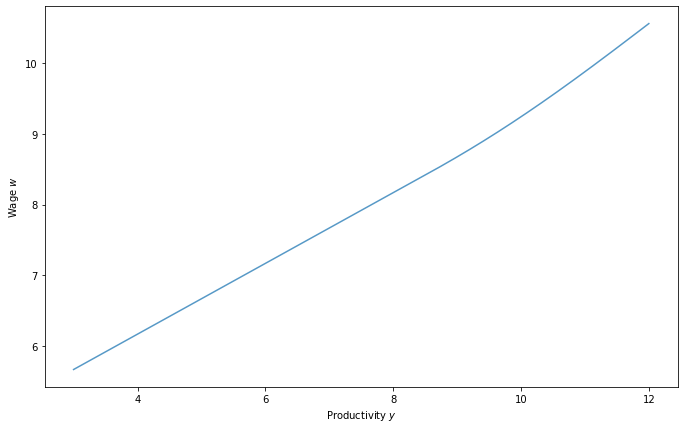

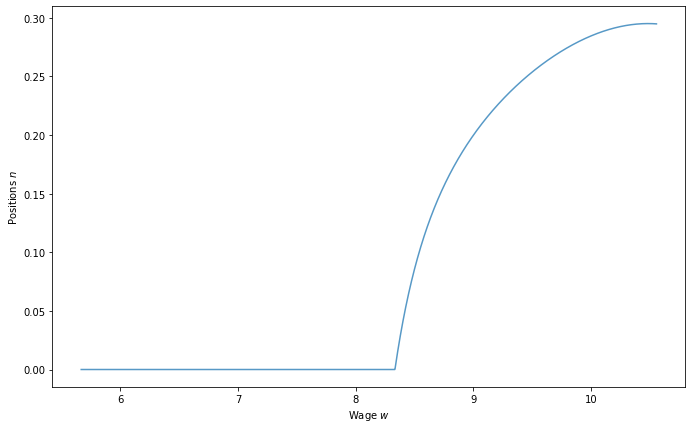

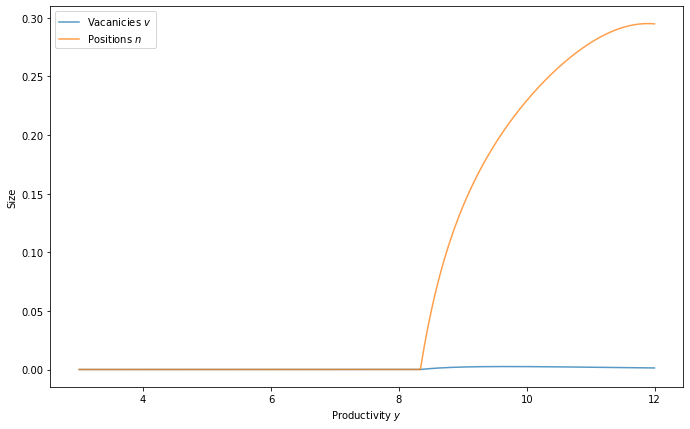

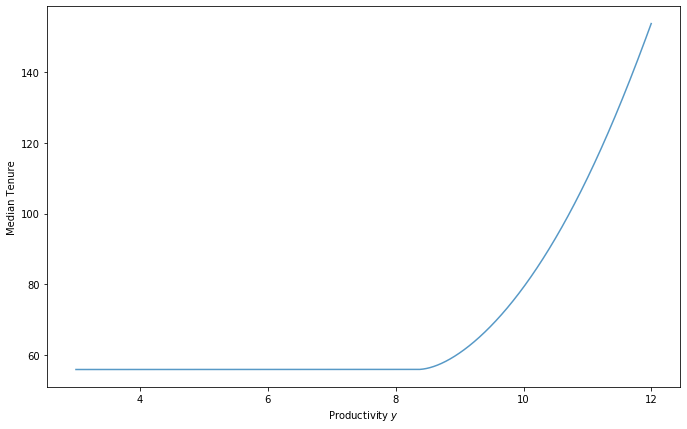

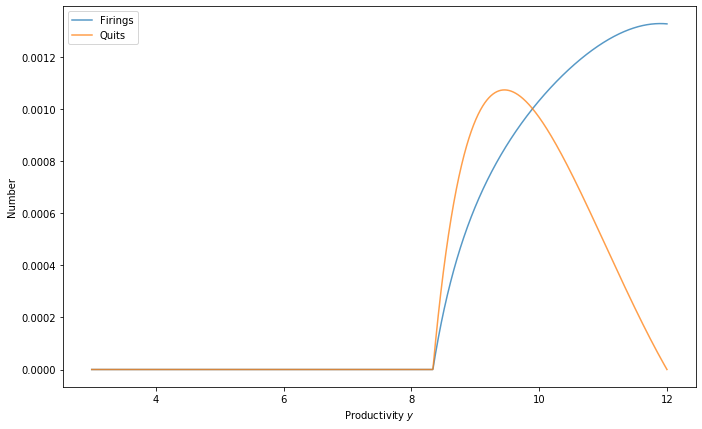

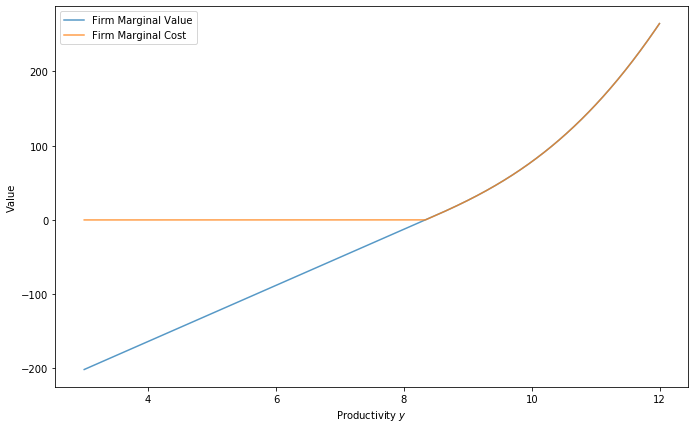

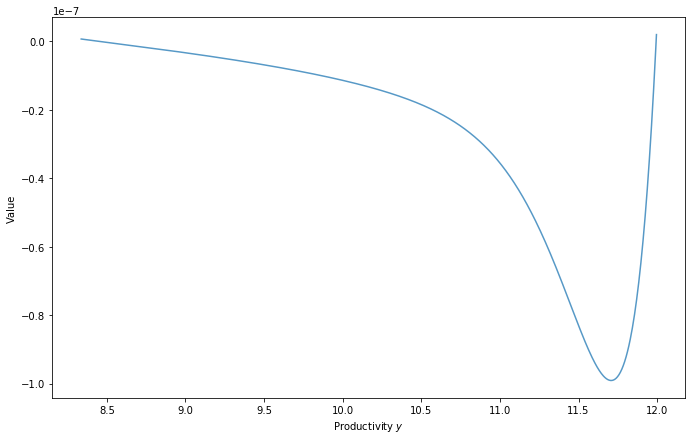

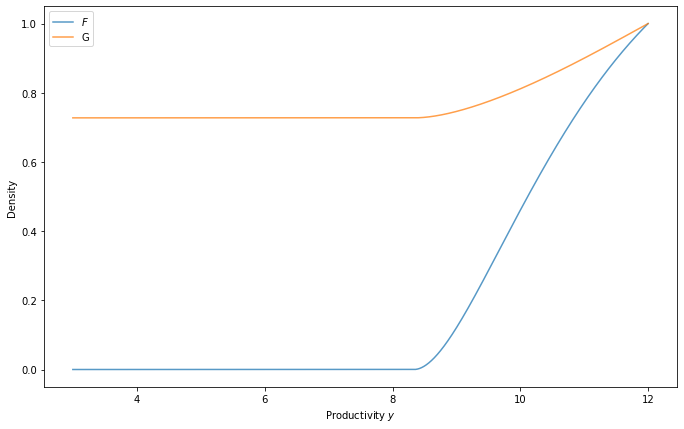

In [286]:
r = 0.000939
B = 1 / (1 + r)
delta = 0.0045
xi = .1
# xi = 0
eta = 0.5
phi = 5e-1 
y_min = 3
y_max = 12
b = y_min * .4 
y_grid_size = 2000
# y_grid_size = 8000
gamma = 2
# gamma = 1.5
k_grid = np.logspace(1, 5, y_grid_size, endpoint = False)
# k_grid = 5e2
# k_grid = np.linspace(1, 15, y_grid_size, endpoint = False)**2

boj = BaselineOnJob(B, b, delta, xi, eta, phi, y_min, y_max, y_grid_size, gamma, k_grid)

v_grid, n_grid = solve_model(boj, tol=1e-8, print_skip=2e4, max_iter=2e5, slow=5e-2)

list_facts(boj, v_grid, n_grid)

graph_results(boj, v_grid, n_grid)

[0.92286041 0.92290624 0.92295205 ... 0.9699995  0.96999975 0.97      ] [ 8.63441112  8.63975637  8.64510429 ... 22.75618816 22.75638078
 22.75657306]


In [3]:
# Set up code for the outsourcer's problem with on-the-job search
# Builds on Outsourcers file

import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit, prange, vectorize, int32, float64
from IPython.core.debugger import set_trace

class OutsourcingOnJob:
    """
    B is discount rate beta
    r is interest rate defined by beta
    b is home production
    delta is job loss rate at firm
    delta_o is job loss rate at outsourcer
    delta_hat is firm destruction rate of outsourcing firm <= delta
    xi is probability of searching on-the-job
    eta is workers bargaining power with firm
    eta_o is workers bargaining power with outsourcer
    phi is effectiveness of matching function
    y_min, y_max, y_grid_size determine firm productivity grid
    rm is to Reimann Sum approximate firm integrals
    o_min, o_max, o_grid_size determine outsourcer productivity grid
    rm_o is to Reimann Sum approximate outsourcer integrals
    gamma is steepness of marginal cost, k_grid is level of entry cost
    gamma_h is steepness of marginal cost for outsourcers, k_o_grid is level of cost
    q is matching function of firms
    ell is matching function of workerso
    """
    def __init__(
        self, B, b, delta, delta_o, delta_hat, xi, eta, eta_o, phi,
        y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
        gamma, gamma_o, k_grid, k_o_grid
    ):
        
        self.B, self.b, self.delta, self.eta, self.gamma, self.k_grid = B, b, delta, eta, gamma, k_grid
        self.delta_hat, self.eta_o, self.gamma_o, self.k_o_grid = delta_hat, eta_o, gamma_o, k_o_grid 
        self.xi, self.delta_o = xi, delta_o
        self.r = 1 / B - 1
        
        self.y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
        self.y_grid_size = y_grid_size    
        self.rm = (y_max - y_min) / y_grid_size
        
        self.o_grid = np.linspace(o_min, o_max, o_grid_size, endpoint = False)
        self.o_grid_size = o_grid_size    
        self.rm_o = (o_max - o_min) / o_grid_size
        
        self.q = njit(lambda x: min(phi * x**(-1 / 2), 1))
        self.ell = njit(lambda x: min(phi * x**(1 / 2), 1))
#         # Remember, q_p and p_p = 0 if q or p = 1
#         self.q_p = njit(lambda x: -phi / 2 * x**(-3 / 2) * (phi * x**(-1 / 2) < 1)) 
#         self.ell_p = njit(lambda x: phi / 2 * x**(1 / 2) * (phi * x**(1 / 2) < 1))


# Set up neccesary functions
def operator_factory(ooj):
    
    r, b, delta, eta, gamma, k_grid = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma, ooj.k_grid
    delta_hat, eta_o, gamma_o, k_o_grid = ooj.delta_hat, ooj.eta_o, ooj.gamma_o, ooj.k_o_grid
    xi, delta_o = ooj.xi, ooj.delta_o
    q, ell = ooj.q, ooj.ell
    
    y_grid, y_grid_size, rm = ooj.y_grid, ooj.y_grid_size, ooj.rm
    o_grid, o_grid_size, rm_o = ooj.o_grid, ooj.o_grid_size, ooj.rm_o
    
    # Want cost of vacancy, marginal cost of vacancy, and inverse marginal cost of vacancy
    @njit()
    def C(v_grid):
        return k_grid * v_grid**gamma
    
    @njit()
    def c(v_grid):
        return k_grid * gamma * v_grid**(gamma - 1)

    @njit()
    def c_inv(c_grid):
        return (np.maximum(c_grid, 0) / (gamma * k_grid))**(1 / (gamma - 1))
        
    # Do the same for outsourcers
    @njit()
    def C_o(v_o_grid):
        return k_o_grid * v_o_grid**gamma_o

    @njit()
    def c_o(v_o_grid):
        return k_o_grid * gamma_o * v_o_grid**(gamma_o - 1)

    @njit()
    def c_o_inv(c_o_grid):
        return (np.maximum(c_o_grid, 0) / (gamma_o * k_o_grid))**(1 / (gamma_o - 1))
    
    # Given v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, and p, find
    # Firms who directly hire hire vs those that outsource out
    # Market tightness theta
    # Distribution of vacanices F and F_o
    # Distribution of job seekers G and G_o
    # Probability of worker leaving D and D_o
    # Wages w and w_o
    @njit()
    def make_grids(v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p):           
        
        # Define aggregate populations (make sure all exist)
        u = max(1 - np.sum(n_grid[:y_hat] * rm) - np.sum(n_o_grid * rm_o), 1e-9)
        v_tilde = max(np.sum(v_grid[:y_hat] * rm), 1e-9)
        v_o = max(np.sum(v_o_grid * rm_o), 1e-9)
        s = (u + xi * (np.sum(n_grid[:y_hat] * rm) + np.sum(n_o_grid * rm_o)))
        
        # Calculate theta and pi 
        v_sum = v_tilde + v_o
        theta = v_sum / s
        pi = v_o / v_sum
        
        # Calculate distributions 
        # F is distribution of vacancies (include firms above y_hat in cdf as 1)
        F_grid = np.minimum(np.cumsum(v_grid * rm) / v_tilde, 1)
        f_grid = v_grid / v_tilde
        f_grid[y_hat:] = 0
        
        F_o_grid = np.cumsum(v_o_grid * rm_o) / v_o
        f_o_grid = v_o_grid / v_o
        
        # G is distribution of job seekers (include firms above y_hat as bigger than all y firms)
        n_temp = np.copy(n_grid)
        n_temp[y_hat:] = 0
        G_grid = (
            (u + xi * (np.cumsum(n_temp * rm)
                       + np.array([np.sum(n_o_grid[:R] * rm_o) for R in R_grid]))) 
            / s
        )
        G_o_grid = (
            (u + xi * (np.array([np.sum(n_temp[:R_o] * rm) for R_o in R_o_grid]) 
                       + np.cumsum(n_o_grid * rm_o))) 
            / s
        )
        
        # D is probability a worker finds a better job
        D_grid = xi * ell(theta) * (1 - (1 - pi) * F_grid - pi * F_o_grid[R_grid]) 
        D_o_grid = xi * ell(theta) * (1 - (1 - pi) * F_grid[R_o_grid] - pi * F_o_grid) 
        
        # What is the value of search?
        # Store these vectors of values which will be used many times
        f_tot = c(v_grid) / G_grid * f_grid * rm
        o_tot = c_o(v_o_grid) / G_o_grid * f_o_grid * rm_o
        
        # For unemployed
        firm = eta / (1 - eta) * (1 - pi) * np.sum(f_tot)
        out = eta_o / (1 - eta_o) * pi * np.sum(o_tot)
        Gamma_U = ell(theta) / q(theta) * (firm + out)
        
        # For employed at a firm
        firm = eta / (1 - eta) * (1 - pi) * np.cumsum(f_tot[::-1])[::-1]
        out = eta_o / (1 - eta_o) * pi * np.array([np.sum(o_tot[R:]) for R in R_grid])
        Gamma_grid = ell(theta) / q(theta) * (firm + out)
        
        # For employed at an outsourcer
        firm = eta / (1 - eta) * (1 - pi) * np.array([np.sum(f_tot[R_o:]) for R_o in R_o_grid])
        out = eta_o / (1 - eta_o) * pi * np.cumsum(o_tot[::-1])[::-1]
        Gamma_o_grid = ell(theta) / q(theta) * (firm + out)
        
        # Find wages
        w_grid = eta * y_grid + (1 - eta) * (b + Gamma_U - (1 - delta) * xi * Gamma_grid) 
        w_o_grid = eta_o * p * o_grid + (1 - eta_o) * (b + Gamma_U - (1 - delta_o) * xi * Gamma_o_grid) 
        
        return (
            theta, G_grid, G_o_grid, D_grid, D_o_grid, 
            Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid
        )
    
    # Given v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, and p, find new values
    @njit()
    def iterate(v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p):
        
        (theta, G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)
        
        v_grid_new = np.empty(y_grid_size)
        n_grid_new = np.empty(y_grid_size)
        
        # Value of firms
        J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + (1 - delta) * D_grid)
        J_out = (y_grid - p) / (r + delta_hat)
        
        # Update y_hat by finding firm closest to indifferent between hiring/outsourcing
        # Make sure J_out is non_negative at y_hat
#         y_hat_new = min(np.searchsorted(J_out - np.maximum(J_hire, 0), 0), y_grid_size - 1)
        y_diff = np.argmin(np.abs(J_out - J_hire))
        y_zero = np.argmin(np.abs(J_out))
        y_hat_new = max(y_diff, y_zero)
        
        # Update vacancies
        # Hiring firms (below y_hat)
        v_grid_new[:y_hat] = c_inv(J_hire)[:y_hat]
        
        # Outsourcing firms (above y_hat)
        v_grid_new[y_hat:] = c_inv(J_out)[y_hat:]
        
        # Outsourcers
        v_o_grid_new = c_o_inv(
            (o_grid * p - w_o_grid) * q(theta) * G_o_grid / (r + delta_o + (1 - delta_o) * D_o_grid)
        )
        
        # Update positions
        # Hiring firms
        n_temp = (1 - delta) * (1 - D_grid) * n_grid + q(theta) * G_grid * v_grid_new
        n_grid_new[:y_hat] = n_temp[:y_hat]
        
        # Outsourcing firms
        n_grid_new[y_hat:] = (1 - delta_hat) * n_grid[y_hat:] + v_grid_new[y_hat:]
        
        # Outsourcers
        n_o_grid_new = (1 - delta_o) * (1 - D_o_grid) * n_o_grid + q(theta) * G_o_grid * v_o_grid_new
               
        # Update R_grid and R_o_grid by comparing W - U to W_o - U.
        # Note that R_grid is defined for all firms, even those above 
        # y_hat, and R_o_grid might be indiffeferent to a firm above y_hat that doesn't hire
        # Value of employment at a firm (minus value of unemployment)        
        W_min_U = (
            (1 + r) * (w_grid - b - Gamma_U + (1 - delta) * xi * Gamma_grid)
            / (r + delta + (1 - delta) * D_grid)
        )
        
        # Value of employment at an outsourcer (minus value of unemployment)
        W_o_min_U = (
            (1 + r) * (w_o_grid - b - Gamma_U + (1 - delta_o) * xi * Gamma_o_grid)
            / (r + delta_o + (1 - delta_o) * D_o_grid)
        )
                
        # Use these to find new indecision rules
#         R_grid_new = np.array(
#             [np.argmin(np.abs(W_min_U[i] - W_o_min_U)) for i in np.arange(y_grid_size)]
#         )
#         R_o_grid_new = np.array(
#             [np.argmin(np.abs(W_min_U - W_o_min_U[i])) for i in np.arange(o_grid_size)]
#         )

        # Use these and search sorted to find new indecision rules (make sure not above all)
        R_grid_new = np.minimum(np.searchsorted(W_o_min_U, W_min_U), o_grid_size - 1)
    
        R_o_grid_new = np.minimum(np.searchsorted(W_min_U, W_o_min_U), y_grid_size - 1)
        
        return v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new
    
    # Given n_grid, n_o_grid, and y_hat find excess demand for outsourcing 
    @njit()
    def QD_QS(n_grid, n_o_grid, y_hat):
        QD = np.sum(n_grid[y_hat:] * rm) 
        QS = np.sum(n_o_grid * o_grid * rm_o)
        return QD, QS
    
    return iterate, QD_QS, make_grids, C, c, c_inv, C_o, c_o, c_o_inv 

# @njit()
def solve_given_p(
    ooj, p, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, tol, max_iter, slow, verbose=False
):
    
    iterate, _, make_grids, _, _, _, _, _, _ = operator_factory(ooj)
    
    # Set up initial loop parameters
    i = 0
    err = tol + 1    
    
    # Update v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, and R_o_grid
    while i < max_iter and err > tol:
        (v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new,
         y_hat_new, R_grid_new, R_o_grid_new) = iterate(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
        )
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_v_o = np.max(np.abs(v_o_grid_new - v_o_grid))
        err_n = np.max(np.abs(n_grid_new - n_grid))
        err_n_o = np.max(np.abs(n_o_grid_new - n_o_grid))
        err = max(err_v, err_v_o, err_n, err_n_o)
        i += 1
        
        v_grid = slow * v_grid_new + (1 - slow) * v_grid
        v_o_grid = slow * v_o_grid_new + (1 - slow) * v_o_grid
        n_grid = slow * n_grid_new + (1 - slow) * n_grid
        n_o_grid = slow * n_o_grid_new + (1 - slow) * n_o_grid
#         n_grid = n_grid_new
#         n_o_grid = n_o_grid_new
        
        # To slowly adjust y_hat, R_grid, and R_o_grid (which are indexes), instead 
        # add/subtract by 1/5 if greater/less (depend on size)
#         y_pos = 1 * (y_hat_new > y_hat) + 4 * (y_hat_new - y_hat > 50)
#         y_neg = 1 * (y_hat_new < y_hat) + 4 * (y_hat_new - y_hat < -50)
#         y_hat = y_hat + y_pos - y_neg
        
#         R_pos = 1 * (R_grid_new > R_grid) + 4 * (R_grid_new - R_grid > 50)
#         R_neg = 1 * (R_grid_new < R_grid) + 4 * (R_grid_new - R_grid < -50)
#         R_grid = R_grid + R_pos - R_neg
        
#         R_o_pos = 1 * (R_o_grid_new > R_o_grid) + 4 * (R_o_grid_new - R_o_grid > 50)
#         R_o_neg = 1 * (R_o_grid_new < R_o_grid) + 4 * (R_o_grid_new - R_o_grid < -50)
#         R_o_grid = R_o_grid + R_o_pos - R_o_neg
        
        # To slowly adjust y_hat, R_grid, and R_o_grid (which are indexes), instead 
        # add/subtract by 1 if greater/less 
        y_hat = y_hat + 1 * (y_hat_new > y_hat) - 1 * (y_hat_new < y_hat)
        R_grid = R_grid + 1 * (R_grid_new > R_grid) - 1 * (R_grid_new < R_grid)
        R_o_grid = R_o_grid + 1 * (R_o_grid_new > R_o_grid) - 1 * (R_o_grid_new < R_o_grid)

    if verbose:
        (theta, G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)
        (theta_new, G_grid_new, G_o_grid_new, D_grid_new, D_o_grid_new,
         Gamma_U_new, Gamma_grid_new, Gamma_o_grid_new, w_grid_new, w_o_grid_new) = make_grids(
            v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, p)
        
        theta_diff = theta - theta_new
        J_hire = (ooj.q(theta) * G_grid * (ooj.y_grid - w_grid)
                  / (ooj.r + ooj.delta + (1 - ooj.delta) * D_grid))
        J_hire_new = (ooj.q(theta_new) * G_grid_new * (ooj.y_grid - w_grid_new)
                      / (ooj.r + ooj.delta + (1 - ooj.delta) * D_grid_new))
#         J_diff = max(np.abs(J_hire_new - J_hire))
        
        print(f"error is {err:.4f}, went through {i} iterations")
        print(f"The difference in theta and theta_new is {theta_diff:.4f}")
        fig, ax = plt.subplots(figsize=(10, 7))
        ax.plot(ooj.y_grid, J_hire, alpha=0.75, label="old")
        ax.plot(ooj.y_grid, J_hire_new, alpha=0.75, label="new")
        ax.legend()
        plt.show()       
        
    return (
        v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new
    )

# Find p
def find_p(
    ooj, p_low, p_high, tol, max_iter, tol_i, max_iter_i, slow_i, verbose=True, print_skip=100
):
    
    iterate, QD_QS, _, _, _, _, _, _, _ = operator_factory(ooj)
    
    y_grid, y_grid_size = ooj.y_grid, ooj.y_grid_size  
    o_grid, o_grid_size = ooj.o_grid, ooj.o_grid_size 
    
    # Set up loop parameters    
    err = tol + 1
    j = 0
    test = []
    
    # Find excess_demand for p_low and p_high, make sure they have opposite signs
    for p in [p_low, p_high]:
        # Initial guesses
        v_grid = np.ones(y_grid_size) / y_grid_size
        n_grid = np.ones(y_grid_size) / y_grid_size
        v_o_grid = np.ones(o_grid_size) / o_grid_size
        n_o_grid = np.ones(o_grid_size) / o_grid_size
#         y_hat = np.intc(y_grid_size / 2)
        y_hat = np.argmin(np.abs(p - y_grid))
        R_grid = np.minimum(np.arange(y_grid_size), o_grid_size - 1, dtype=np.int64)
        R_o_grid = np.minimum(np.arange(o_grid_size), y_grid_size - 1, dtype=np.int64)
        
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid = solve_given_p(
            ooj, p, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, tol_i, max_iter_i, slow_i
        )
        QD, QS = QD_QS(n_grid, n_o_grid, y_hat)
        test.append(QD - QS)
        
        if verbose:
            print(f'Excess Demand for price {p} is {QD - QS:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
            
#         set_trace()
            
    if np.cumprod(test)[1] > 0:
        print('Test failed, both prices have positive/negative excess demand')
        return
        
    while err > tol and j < max_iter:
        p = (p_low + p_high) / 2
        
#         # Initial guesses (reset initially)
#         if j <= 5:
        v_grid = np.ones(y_grid_size) / y_grid_size
        n_grid = np.ones(y_grid_size) / y_grid_size
        v_o_grid = np.ones(o_grid_size) / o_grid_size
        n_o_grid = np.ones(o_grid_size) / o_grid_size
#             y_hat = np.intc(y_grid_size / 2)
        y_hat = np.argmin(np.abs(p - y_grid))
        R_grid = np.minimum(np.arange(y_grid_size), o_grid_size - 1, dtype=np.int64)
        R_o_grid = np.minimum(np.arange(o_grid_size), y_grid_size - 1, dtype=np.int64)
              
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid = solve_given_p(
    ooj, p, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, tol_i, max_iter_i, slow_i
)
        QD, QS = QD_QS(n_grid, n_o_grid, y_hat)
        ed = QD - QS
        err = np.abs(ed)
        
        # If excess demand QD - QS > 0, set p_low = p, otherwise p_high = p
        if ed > 0:
            p_low = p
        else:
            p_high = p
            
        if verbose and j % print_skip == 0:
            print(
                f'Excess Demand at iter {j} is {ed:.4f}; price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}',
                f"y_hat is {y_grid[y_hat]}"
            )
            
        j += 1
        
#     # Run one more loop with 10 times the iterations, 1/100 the tolerance
#     if verbose:
#         print(
#             f'Excess Demand at iter {j} is {ed:.4f}; price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}',
#             f"y_hat is {y_grid[y_hat]}\n One more loop..."
#         )
            
#     v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid = solve_given_p(
#     ooj, p, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid,
#         tol_i / 100, max_iter_i * 10, slow_i
# )
#     QD, QS = QD_QS(n_grid, n_o_grid, y_hat)
#     ed = QD - QS
    
    if j < max_iter:
        print(f'Converged in {j} iterations, Excess Demand is {ed:.4f};',
              f' price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
    if j == max_iter:
        print(f'Failed to Converge. Excess Demand is {ed:.4f}; price is {p:.4f};',
              f' QS is {QS:.4f}; QD is {QD:.4f}')
        
    return v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p

# Create a function to graph results
def graph_results(ooj, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p,
                  save=False, height=7, 
                  folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures\Python Simulations\Test',
                  file=r'\Outsourcers OJS '):
    
    # Make sure dimensions are 1:1.62
    width = height * 1.62
    
    # Get data needed from ooj
    _, QD_QS, make_grids, C, c, c_inv, C_o, c_o, c_o_inv = operator_factory(ooj)
    
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    r, delta, xi, q, ell = ooj.r, ooj.delta, ooj.xi, ooj.q, ooj.ell
    delta_o, delta_hat = ooj.delta_o, ooj.delta_hat
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    y_grid_size, o_grid_size = ooj.y_grid_size, ooj.o_grid_size
    
    # Because firms and outsourcers may have different grid sizes, comparing 
    # plots directly may be misleading. To solve this, scale outsourcing
    # vacancies and positions to match relative grid sizes
    mult = o_grid_size / y_grid_size
    v_o_grid_p = v_o_grid * mult
    n_o_grid_p = n_o_grid * mult
        
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, w_grid, alpha=0.75)
    ax.plot(y_grid, y_grid, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Wage $w$")
    
    if save:
        fig.savefig(folder + file + 'Firm Wages v Productivity.pdf')
    else:
        plt.show()  
        
    # Graph outsourcer wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, w_o_grid, alpha=0.75)
    ax.plot(o_grid, o_grid * p, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $o$", ylabel="Wage $w_o$")
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Wages v Productivity.pdf')
    else:
        plt.show() 
        
    # Graph vacacies by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_hat], v_grid[:y_hat], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, v_o_grid_p, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Vacancies $v$")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Vacancies v Wages.pdf')
    else:
        plt.show()         
    
    # Graph filled posititions by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_hat], n_grid[:y_hat], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, n_o_grid_p, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Positions $n$")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Positions v Wages.pdf')
    else:
        plt.show() 
        
    # Graph firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid, alpha=0.75, label="Vacancies $v$")
#     ax.plot(y_grid, n_grid, alpha=0.75, label="Positions $n$")
    ax.axvline(x=y_grid[y_hat], c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies")
#     ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firm Vacancies.pdf')
    else:
        plt.show()
        
    # Graph firm postions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid, alpha=0.75, label="Positions $n$")
    ax.axvline(x=y_grid[y_hat], c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Positions")
#     ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firm Positions.pdf')
    else:
        plt.show()
        
    # Graph outsourcer vacancies and filled positions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, v_o_grid_p, alpha=0.75, label=r"Vacanicies $\breve{v}$")
#     ax.plot(o_grid, n_o_grid_p, alpha=0.75, label=r"Positions $\breve{n}$")
    ax.set(xlabel="Productivity $o$", ylabel="Vacancies")
#     ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Vacancies.pdf')
    else:
        plt.show()
        
    fig, ax = plt.subplots(figsize=(width, height))
#     ax.plot(o_grid, v_o_grid_p, alpha=0.75, label=r"Vacanicies $\breve{v}$")
    ax.plot(o_grid, n_o_grid_p, alpha=0.75, label=r"Positions $\breve{n}$")
    ax.set(xlabel="Productivity $o$", ylabel="Positions")
#     ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Positions.pdf')
    else:
        plt.show()
        
    # Graph median tenure by wage
    p_stay = (1 - delta) * (1 - D_grid)
    median_tenure = np.log(.5) / np.log(p_stay)
    p_o_stay = (1 - delta_o) * (1 - D_o_grid)
    median_tenure_o = np.log(.5) / np.log(p_o_stay)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_hat], median_tenure[:y_hat], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, median_tenure_o, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage", ylabel="Median Tenure")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Median Tenure.pdf')
    else:
        plt.show()
        
    # Graph firings (lose jobs) vs quits (find better job) by wage
    firings = delta * n_grid
    quits = (1 - delta) * D_grid * n_grid
    firings_o = delta_o * n_o_grid_p
    quits_o = (1 - delta_o) * D_o_grid * n_o_grid_p
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_hat], firings[:y_hat], alpha=0.75, label="Firm Firings")
    ax.plot(w_grid[:y_hat], quits[:y_hat], alpha=0.75, label="Firm Quits")
    ax.plot(w_o_grid, firings_o, alpha=0.75, label="Outsourcer Firings")
    ax.plot(w_o_grid, quits_o, alpha=0.75, label="Outsourcer Quits")
    ax.set(xlabel="Wage", ylabel="Number")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firings and Quits.pdf')
    else:
        plt.show()
        
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    # Do the same for outsourcers hiring
    J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + (1 - delta) * D_grid)
    J_out = (y_grid - p) / (r + delta_hat)
    mc = c(v_grid)    
    
    O = q(theta) * G_o_grid * (p * o_grid - w_o_grid) / (r + delta_o + (1 - delta_o) * D_o_grid)
    mc_o = c_o(v_o_grid) 
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_hire, alpha=0.75, label="Hiring Firm Marginal Value")
    ax.plot(y_grid[y_hat:], J_out[y_hat:], alpha=0.75, label="Outsourcing Firm Marginal Value")
    ax.plot(y_grid, mc, alpha=0.75, label="Firm Marginal Cost")
    ax.plot(o_grid, O, alpha=0.75, label="Outsourcer Marginal Value")
    ax.plot(o_grid, mc_o, alpha=0.75, label="Outsourcer Marginal Cost")
    ax.set(xlabel="Productivity $y$", ylabel="Value")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'M Value and Cost.pdf')
    else:
        plt.show()
        
    # Plot the differences from the above curves
    J_hire_diff = J_hire - mc
    J_out_diff = J_out - mc
    O_diff = O - mc_o
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[v_grid > 0], J_hire_diff[v_grid > 0], alpha=0.75, label="Hiring Firm Diff")
    ax.plot(y_grid[y_hat:], J_out_diff[y_hat:], alpha=0.75, label="Outsourcing Firm Diff")
    ax.plot(o_grid[v_o_grid > 0], O_diff[v_o_grid > 0], alpha=0.75, label="Outsourcer Diff")
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'M Value Minus Cost.pdf')
    else:
        plt.show()
        
    # Plot the workers' indifference curve for hired vs outsourced
    o_R_grid = o_grid[R_grid]
    y_R_o_grid = y_grid[R_o_grid]
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, o_R_grid, alpha=0.75, label="Firm Indifference")
    ax.plot(y_R_o_grid, o_grid, alpha=0.75, label="Outsourcer Indifference")    
    ax.set(xlabel="Productivity $y$", ylabel="Productivity $o$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "Worker's Indifference Curve.pdf")
    else:
        plt.show()
        
    # Plot various distribributions for the firm
    v_tilde = np.sum(v_grid[:y_hat] * rm)
    F_grid = np.minimum(np.cumsum(v_grid * rm) / v_tilde, 1)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, F_grid, alpha=0.75, label=r"$F$")  
    ax.plot(y_grid, G_grid, alpha=0.75, label=r"$G$") 
    ax.plot(y_grid, D_grid / (xi * ell(theta)), alpha=0.75, label=r"$D$")  
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "Firm Distributions.pdf")
    else:
        plt.show()
        
    # Plot various distribributions for the outsourcer
    v_o = np.sum(v_o_grid * rm_o)
    F_o_grid = np.cumsum(v_o_grid * rm_o) / v_o
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, F_o_grid, alpha=0.75, label=r"$\breve{F}$")  
    ax.plot(o_grid, G_o_grid, alpha=0.75, label=r"$\breve{G}$") 
    ax.plot(o_grid, D_o_grid / (xi * ell(theta)), alpha=0.75, label=r"$\breve{D}$")  
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "Outsourcer Distributions.pdf")
    else:
        plt.show()
        
    # Graph value of search by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid, Gamma_grid, alpha=0.75, label="Firms")
    ax.plot(w_o_grid, Gamma_o_grid, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Value of Serach")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Value of Search.pdf')
    else:
        plt.show()
        
# Create a function to print some facts that are useful
def list_facts(ooj, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p):
    
    _, QD_QS, make_grids, C, c, c_inv, C_o, c_o, c_o_inv = operator_factory(ooj)
    
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    delta, xi, q, ell = ooj.delta, ooj.xi, ooj.q, ooj.ell
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    
    print(f"The indifferent firm is y_hat = {y_grid[y_hat]:.2f}$. Price of outsourcing is {p:.2f}.")
    
    u = 1 - np.sum(n_grid[:y_hat] * rm) - np.sum(n_o_grid * rm_o) 
    pi = np.sum(v_o_grid * rm_o) / (np.sum(v_grid[:y_hat] * rm) + np.sum(v_o_grid * rm_o))
    zeta = np.sum(n_o_grid * rm_o) / (np.sum(n_grid[:y_hat] * rm) + np.sum(n_o_grid * rm_o))
    e_delta = (1 - zeta) * delta + zeta * delta_o 
    u_lom = e_delta / (e_delta + ell(theta))
    tot_v = np.sum(v_grid[:y_hat] * rm) + np.sum(v_o_grid * rm_o)
    print(f"Unemployment is {u * 100:.2f}. According to LoM, should be {u_lom * 100:.2f}")
    print(f"Workers match with probability {ell(theta) * 100:.2f}.",
          f"Firms/Outsourcers match with probability {q(theta) * 100:.2f}")
    print(f"Total vacancies searching for workers are {tot_v:.4f}. Theta is {theta:.4f}")
    print(f"{pi * 100:.0f} percent of vacancies searching for workers are from outsourcers,",
          f"{zeta * 100:.0f} percent of postions outsourced")
    
    # Document ue rate, ee rate, and percent of jobs from unemployment
    ue = ell(theta)
    ee = (
        (np.sum(n_grid[:y_hat] * D_grid[:y_hat] * rm) / np.sum(n_grid[:y_hat] * rm) + 
         np.sum(n_o_grid * D_o_grid * rm_o) / np.sum(n_o_grid * rm_o))
    )
    per_from_u = 100 * ue * u / (ue * u + ee * (1 - u))
    print(f"The ue rate is {ue:.2f}, the ee rate is {ee:.2f},",
          f" and {per_from_u:0f} of new jobs are from unemployment")  
                       
    # Do firm/outsourcer vacancies and positions line up in steady state?
    n_ss_tilde = v_grid[:y_hat] * q(theta) * G_grid[:y_hat] / delta
    n_tilde = n_grid[:y_hat]
    if y_hat > min(y_grid):
        err_tilde = max(np.abs(n_ss_tilde - n_tilde))
        err_tilde_at = np.argmax(np.abs(n_ss_tilde - n_tilde))
    else:
        err_tilde = 0
        err_tilde_at = 0
    
    n_ss_hat = v_grid[y_hat:] / delta_hat
    n_hat = n_grid[y_hat:]
    if y_hat < max(y_grid):
        err_hat = max(np.abs(n_ss_hat - n_hat))
        err_hat_at = np.argmax(np.abs(n_ss_hat - n_hat))
    else:
        err_hat = 0
        err_hat_at = 0
    
    n_o_ss = v_o_grid * q(theta) * G_o_grid / delta_o
    n_o = v_o_grid
    err_o = max(np.abs(n_o_ss - n_o))
    err_o_at = np.argmax(np.abs(n_o_ss - n_o))
    
    print(
        "Checking if vacancies + LoM imply right positions:\n",
         f"Hiring firms large error = {err_tilde:.6f} at position {err_tilde_at} \n",
         f"Outsourcing firms largest error = {err_hat:.6f} at position {err_hat_at}\n",
         f"Outsourcer largest error = {err_o:.6f} at position {err_o_at}"
    )                       

Excess Demand for price 6 is 10633.7864; QS is 0.0045; QD is 10633.7909
Excess Demand for price 12 is -0.0508; QS is 0.0508; QD is 0.0000
Excess Demand at iter 0 is 96.2567; price is 9.0000; QS is 0.0007; QD is 96.2574 y_hat is 9.222
Excess Demand at iter 5 is -0.0155; price is 11.5312; QS is 0.0224; QD is 0.0069 y_hat is 11.994
Excess Demand at iter 10 is -0.0126; price is 11.4697; QS is 0.0206; QD is 0.0080 y_hat is 11.994
Failed to Converge. Excess Demand is 0.0671; price is 11.4684;  QS is 0.0204; QD is 0.0875
The indifferent firm is y_hat = 11.84$. Price of outsourcing is 11.47.
Unemployment is 12.53. According to LoM, should be 7.19
Workers match with probability 5.82. Firms/Outsourcers match with probability 68.68
Total vacancies searching for workers are 0.0180. Theta is 0.0848
3 percent of vacancies searching for workers are from outsourcers, 3 percent of postions outsourced
The ue rate is 0.06, the ee rate is 0.01,  and 59.786348 of new jobs are from unemployment
Checking if 

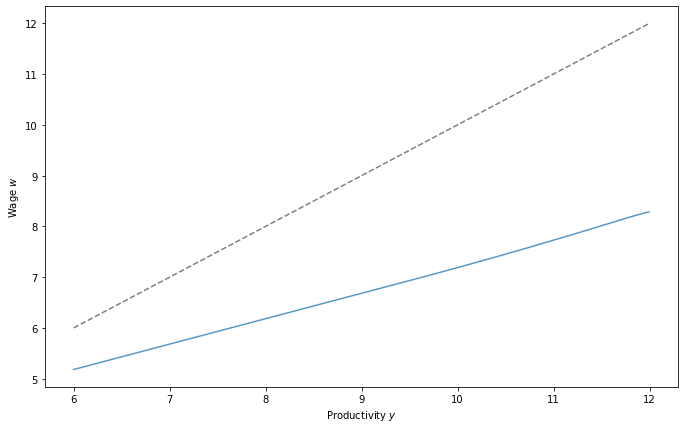

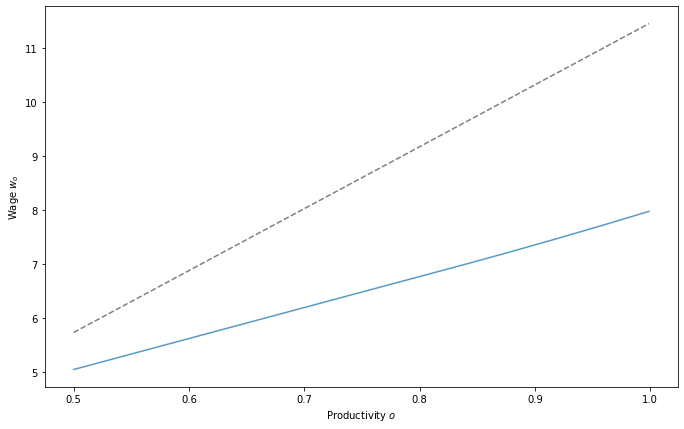

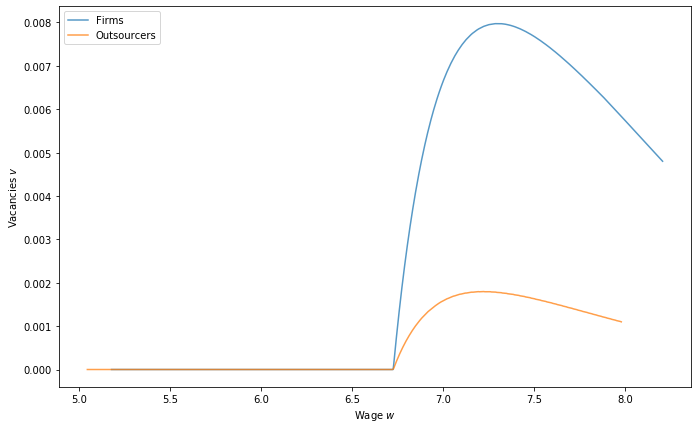

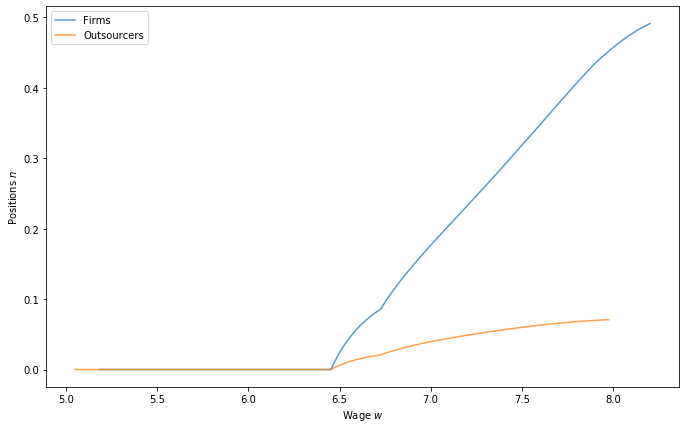

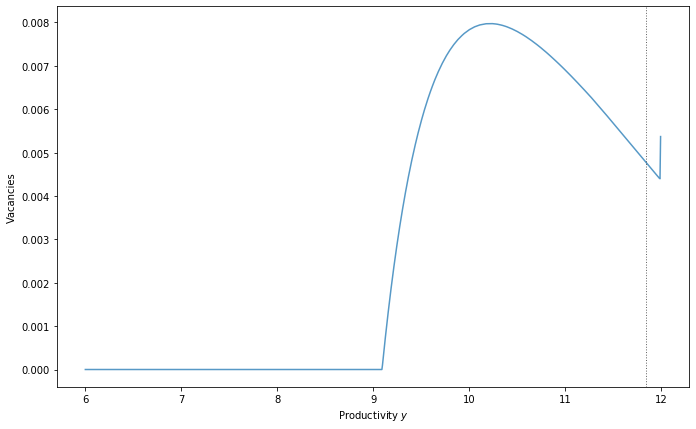

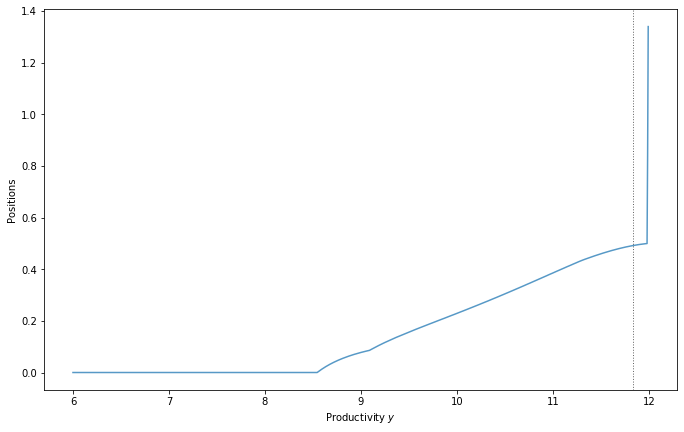

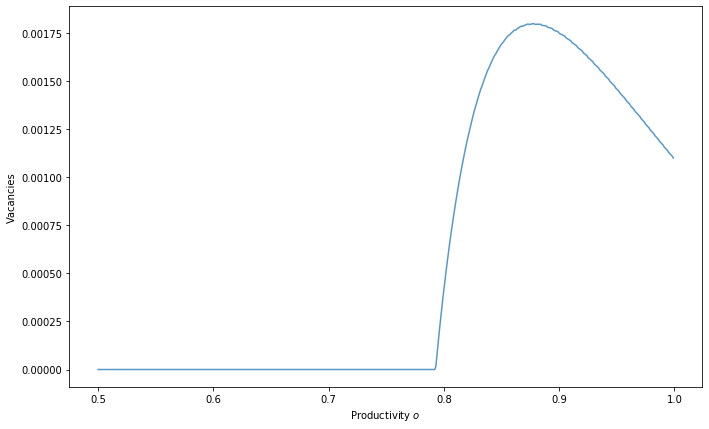

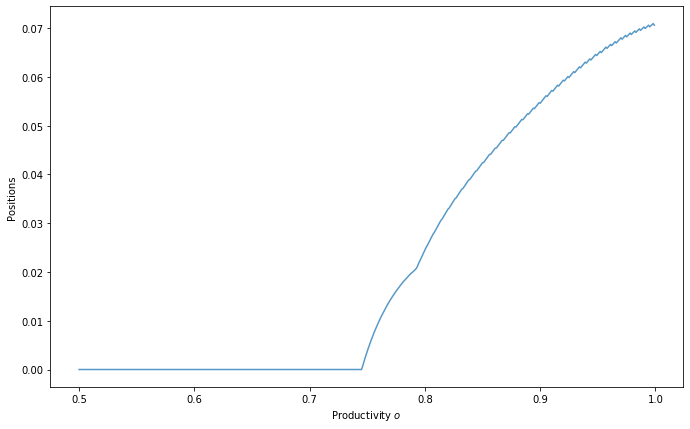

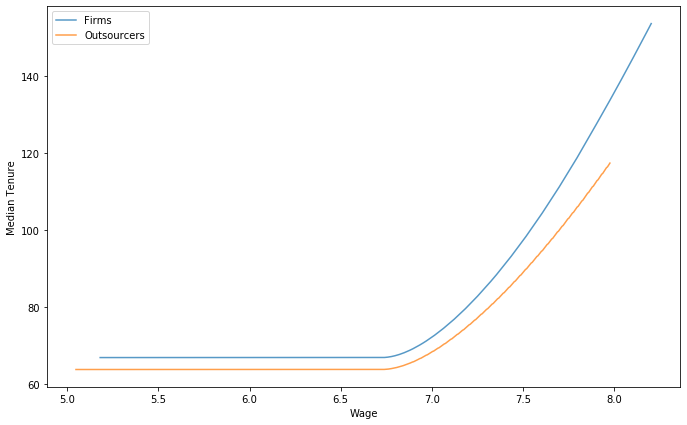

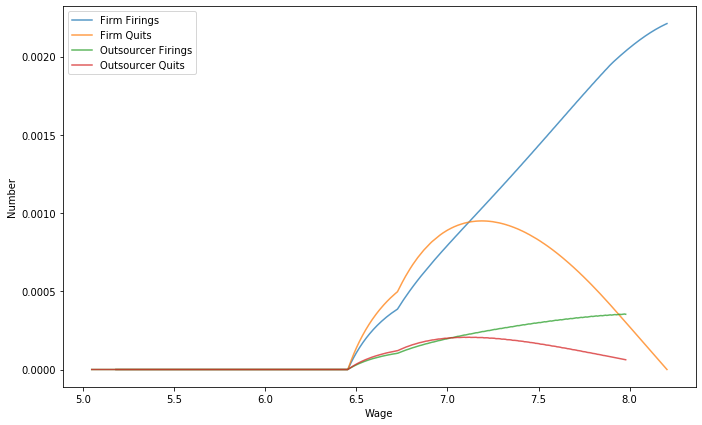

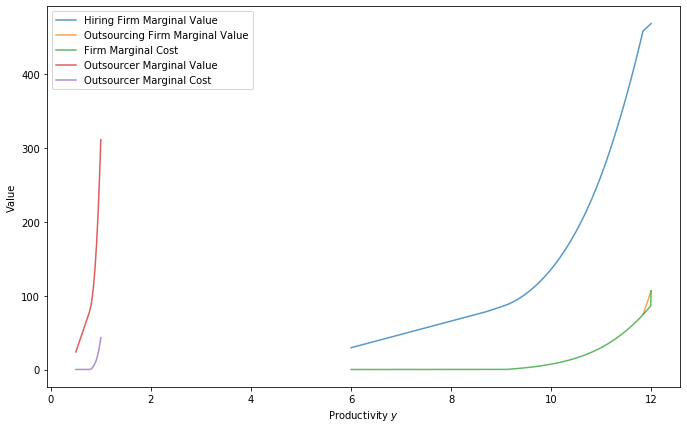

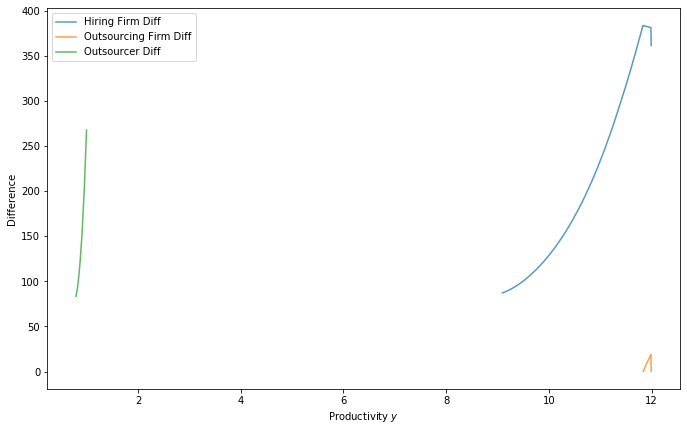

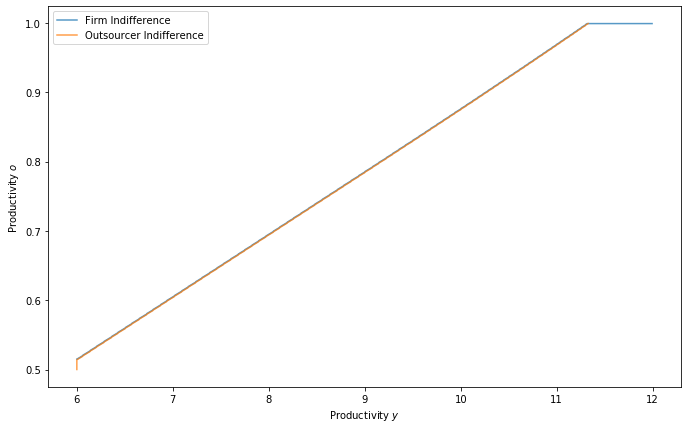

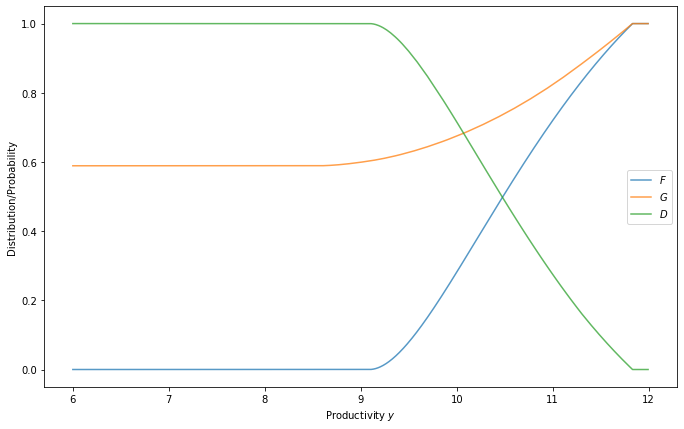

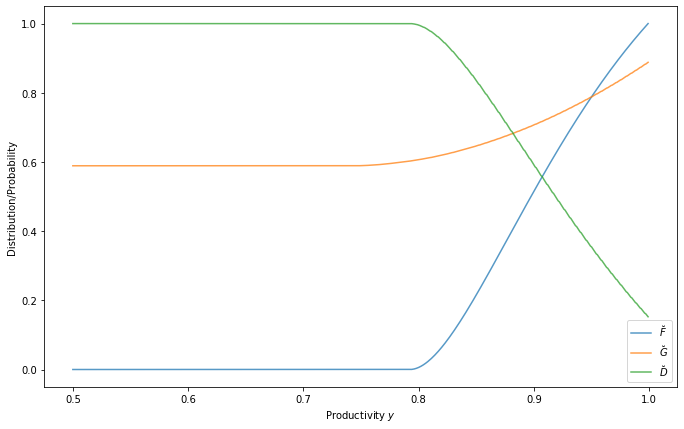

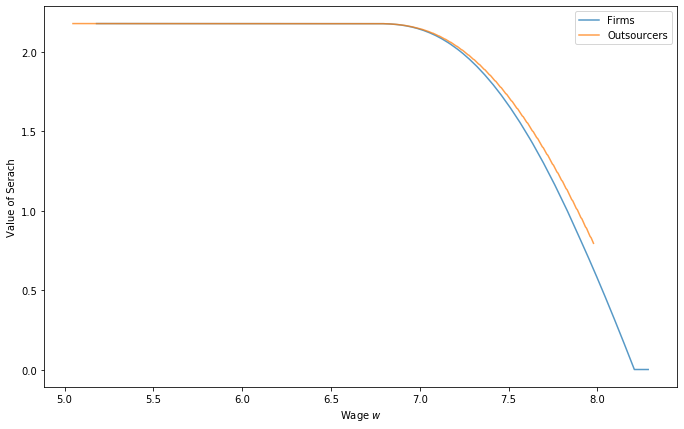

In [4]:
r = 0.000939
B = 1 / (1 + r)
delta = 0.0045
delta_o = 0.0050
delta_hat = 0.0040
xi = .1
# xi = 0
eta = 0.5
eta_o = 0.5
phi = 2e-1 
y_min = 6
y_max = 12
o_min = 0.5
o_max = 1.0
b = y_min * .4 
y_grid_size = 1000
# y_grid_size = 8000
o_grid_size = 500
gamma = 2
gamma_o = 2
k_grid = np.logspace(0, 4, y_grid_size, endpoint = False)
k_o_grid = np.logspace(0, 4, o_grid_size, endpoint = False)
# k_grid = 1e9
# k_o_grid = 1e9

p_low = 6
p_high = 12
tol = 1e-4
max_iter = 15
tol_i = 1e-4
max_iter_i = 3e4
slow_i = 5e-2
print_skip = 5
verbose = True

save = True

ooj = OutsourcingOnJob(
    B, b, delta, delta_o, delta_hat, xi, eta, eta_o, phi,
    y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
    gamma, gamma_o, k_grid, k_o_grid
)

v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p = find_p(
    ooj, p_low, p_high, tol, max_iter, tol_i, max_iter_i, slow_i, verbose, print_skip
)

list_facts(ooj, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)

graph_results(ooj, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p,
             save=save)

In [92]:
%debug

> <ipython-input-90-7e7ce390805f>(278)solve_given_p()
    276         (v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new,
    277          y_hat_new, R_grid_new, R_o_grid_new) = iterate(
--> 278             v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    279         )
    280         err_v = np.max(np.abs(v_grid_new - v_grid))

ipdb> n_grid
array([5.59848004e-01, 5.60860001e-01, 5.61884123e-01, 5.62921801e-01,
       5.63973379e-01, 5.65039214e-01, 5.66119682e-01, 5.67215222e-01,
       5.68326342e-01, 5.69453567e-01, 5.70597350e-01, 5.71758092e-01,
       5.72936308e-01, 5.74132525e-01, 5.75347385e-01, 5.76581413e-01,
       5.77835142e-01, 5.79109145e-01, 5.80404010e-01, 5.81720330e-01,
       5.83058713e-01, 5.84419773e-01, 5.85804138e-01, 5.87212443e-01,
       5.88645336e-01, 5.90103473e-01, 5.91587525e-01, 5.93098169e-01,
       5.94636097e-01, 5.96202010e-01, 5.97796622e-01, 5.99420657e-01,
       6.01074854e-01, 6.02759961e-01, 6.04476741e-01, 6.06225969e-01

ipdb> v_grid
array([4.64062701e-03, 4.66459216e-03, 4.68929218e-03, 4.71487332e-03,
       4.74116300e-03, 4.76810250e-03, 4.79563462e-03, 4.82371504e-03,
       4.85231986e-03, 4.88139785e-03, 4.91084152e-03, 4.94055721e-03,
       4.97054930e-03, 5.00082142e-03, 5.03147765e-03, 5.06247825e-03,
       5.09378859e-03, 5.12541060e-03, 5.15734597e-03, 5.18959624e-03,
       5.22216280e-03, 5.25504693e-03, 5.28824982e-03, 5.32177262e-03,
       5.35561638e-03, 5.38978216e-03, 5.42427096e-03, 5.45908377e-03,
       5.49422160e-03, 5.52968541e-03, 5.56547621e-03, 5.60159500e-03,
       5.63804280e-03, 5.67482065e-03, 5.71192963e-03, 5.74937082e-03,
       5.78714536e-03, 5.82525441e-03, 5.86369919e-03, 5.90248095e-03,
       5.94160096e-03, 5.98106058e-03, 6.02086119e-03, 6.06100423e-03,
       6.10149120e-03, 6.14232364e-03, 6.18350317e-03, 6.22503144e-03,
       6.26691019e-03, 6.30932191e-03, 6.35246932e-03, 6.39599371e-03,
       6.43989701e-03, 6.48418117e-03, 6.52884826e-03, 6.5739004

ipdb> n_o_grid
array([6.68183578e-01, 6.66463636e-01, 6.64777812e-01, 6.63126782e-01,
       6.61512492e-01, 6.59934630e-01, 6.58394226e-01, 6.56893515e-01,
       6.55431832e-01, 6.54016246e-01, 6.52653555e-01, 6.51336488e-01,
       6.50064898e-01, 6.48841076e-01, 6.47667522e-01, 6.46546925e-01,
       6.45482136e-01, 6.44476171e-01, 6.43534853e-01, 6.42660852e-01,
       6.41860788e-01, 6.41140469e-01, 6.40505919e-01, 6.39964643e-01,
       6.39523720e-01, 6.39189825e-01, 6.38968476e-01, 6.38866138e-01,
       6.38886788e-01, 6.39031997e-01, 6.39302967e-01, 6.39707459e-01,
       6.40242599e-01, 6.40908321e-01, 6.41712359e-01, 6.42652391e-01,
       6.43722925e-01, 6.44928678e-01, 6.46280948e-01, 6.47756851e-01,
       6.49390954e-01, 6.51151007e-01, 6.53057368e-01, 6.55115933e-01,
       6.57296138e-01, 6.59640643e-01, 6.62139294e-01, 6.64766463e-01,
       6.67523675e-01, 6.70484525e-01, 6.73586548e-01, 6.76826138e-01,
       6.80204985e-01, 6.83724808e-01, 6.87438310e-01, 6.91422

ipdb> c


The indifferent firm is y_hat = 11.87$. Price of outsourcing is 11.44.
Unemployment is 7.19. According to LoM, should be 6.45
Workers match with probability 6.66. Firms/Outsourcers match with probability 60.09
Total vacancies searching for workers are 0.0183. Theta is 0.1108
29 percent of vacancies searching for workers are from outsourcers, 19 percent of postions outsourced
The ue rate is 0.07, the ee rate is 0.01,  and 43.378050 of new jobs are from unemployment
Checking if vacancies + LoM imply right positions:
 Hiring firms large error = 0.228368 at position 764 
 Outsourcing firms largest error = 0.000000 at position 0
 Outsourcer largest error = 3.325461 at position 69


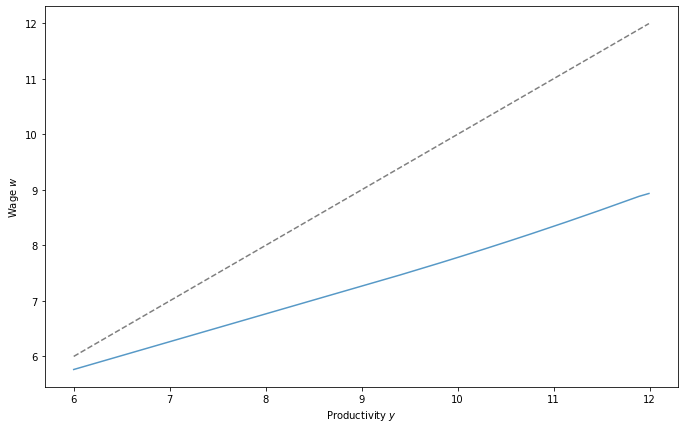

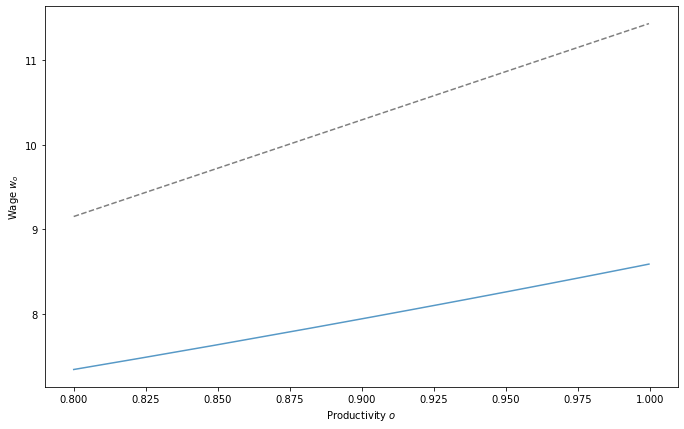

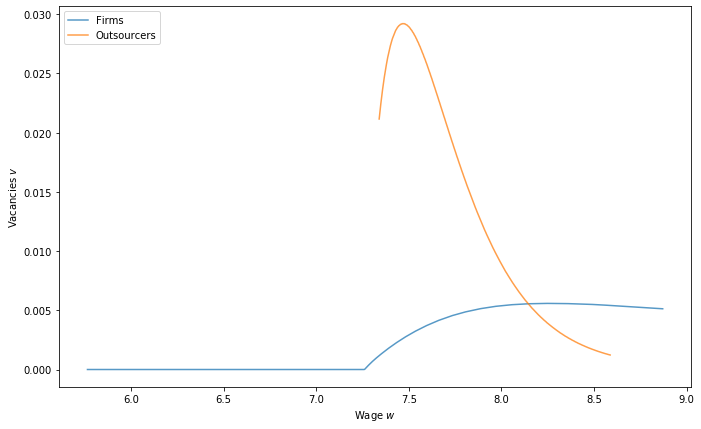

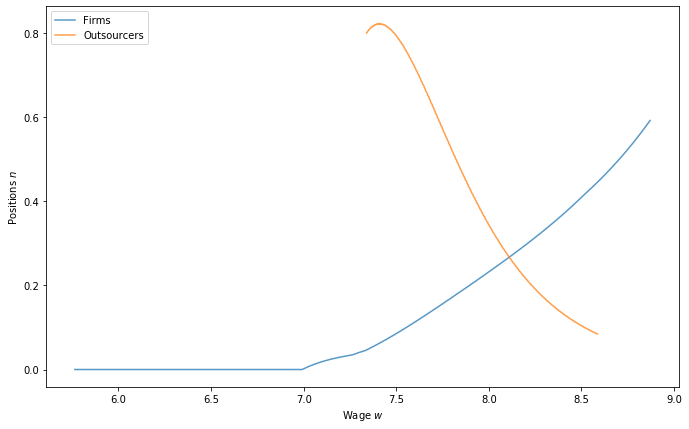

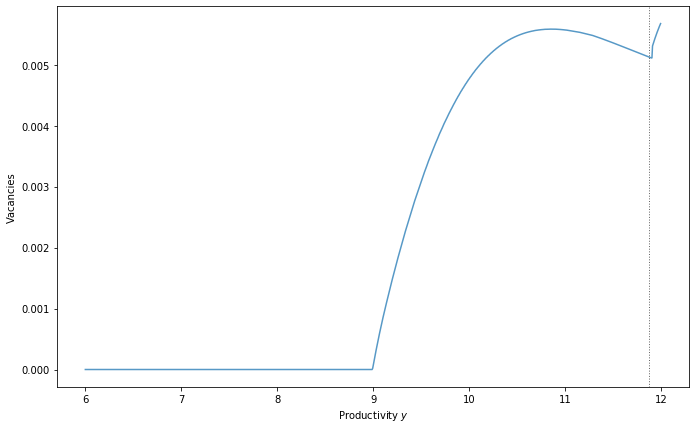

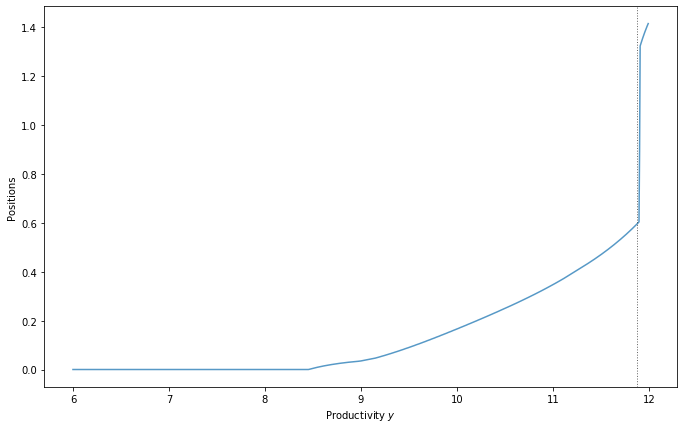

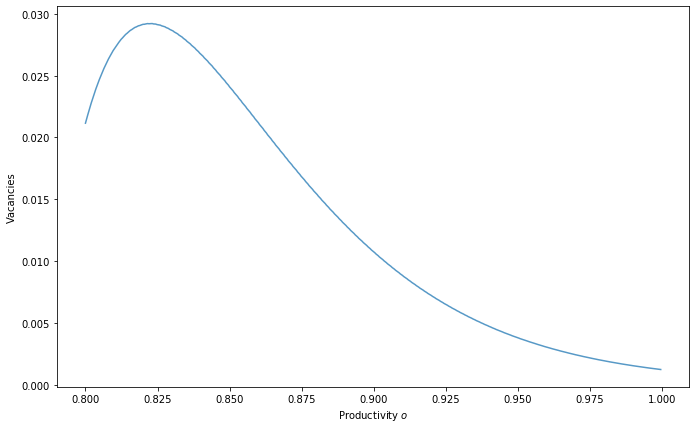

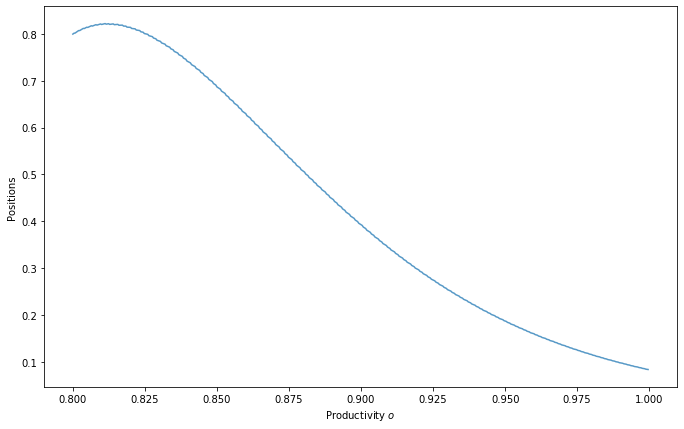

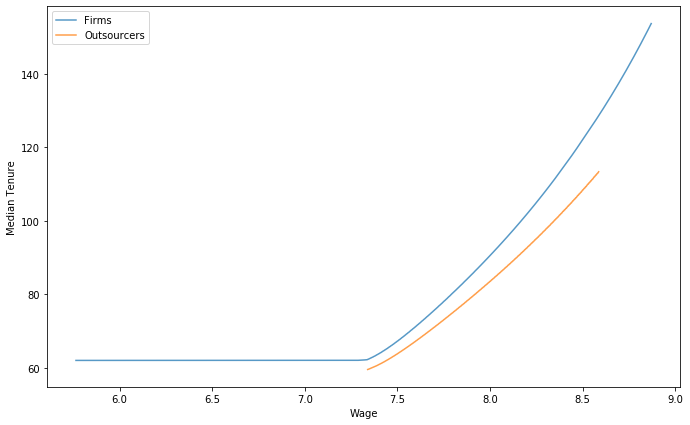

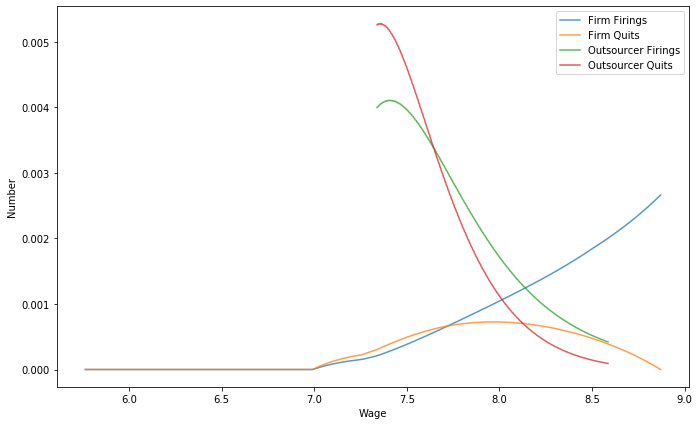

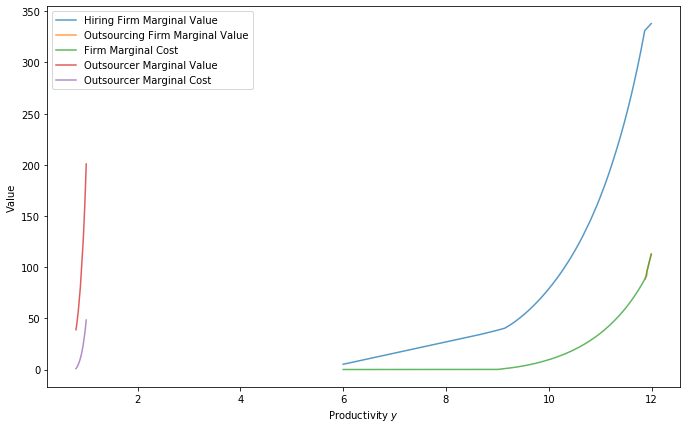

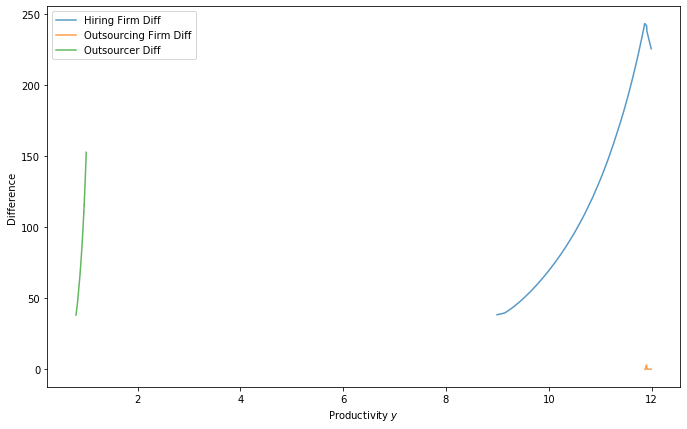

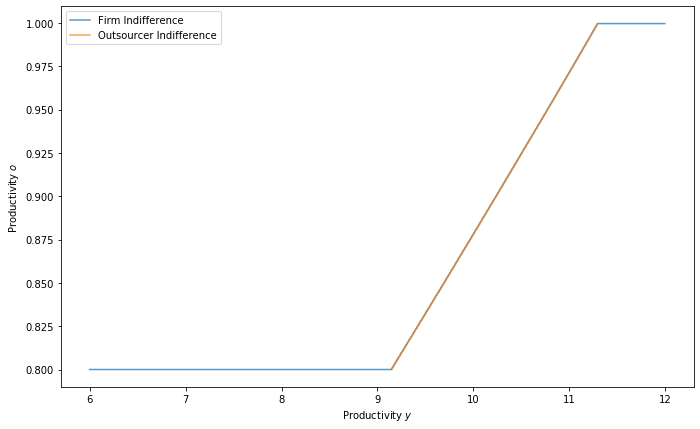

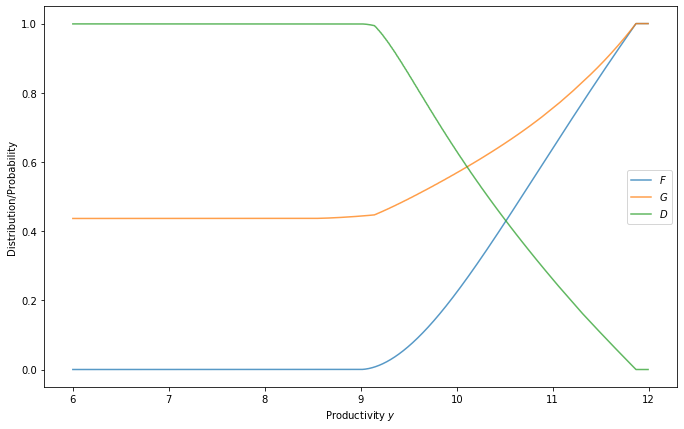

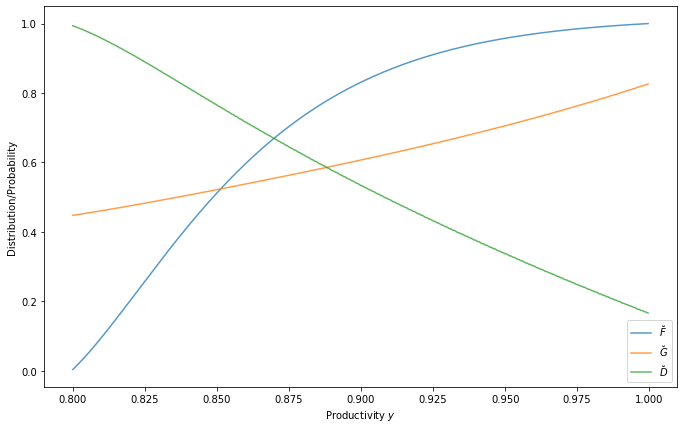

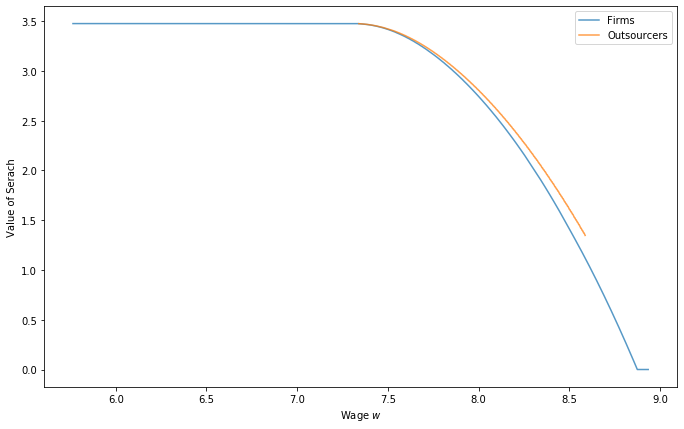

In [45]:
list_facts(ooj, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)

graph_results(ooj, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)

In [9]:
x = np.array([1, 2, 5, 11], dtype=np.int32)
y = np.linspace(1, 10, 10)

np.searchsorted(y, x)
np.searchsorted?

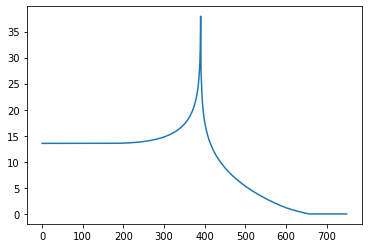

In [15]:
_, QD_QS, make_grids, C, c, c_inv, C_o, c_o, c_o_inv = operator_factory(ooj)

(theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )

plt.plot(Gamma_grid)

error is 0.0001, went through 19678 iterations
The difference in theta and theta_new is -0.0000


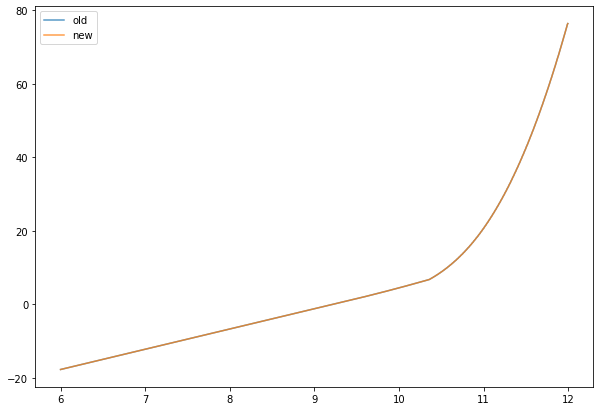

In [33]:
tol = 1e-4
max_iter = 2e4
slow = 5e-2
verbose = True

y_grid, y_grid_size = ooj.y_grid, ooj.y_grid_size  
o_grid, o_grid_size = ooj.o_grid, ooj.o_grid_size 

p = 13

v_grid = np.ones(y_grid_size) / y_grid_size
n_grid = np.ones(y_grid_size) / y_grid_size
v_o_grid = np.ones(o_grid_size) / o_grid_size
n_o_grid = np.ones(o_grid_size) / o_grid_size
# y_hat = np.intc(y_grid_size / 2)
y_hat = np.argmin(np.abs(p - y_grid))
R_grid = np.intc(np.minimum(np.arange(y_grid_size), o_grid_size))
R_o_grid = np.intc(np.minimum(np.arange(o_grid_size), y_grid_size))


iterate, QD_QS, make_grids, _, _, _, _, _, _ = operator_factory(ooj)
# iterate(v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)

v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid = solve_given_p(
    ooj, p, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, tol, max_iter, slow, verbose
)

In [226]:
# (0.14081766803897883, 0.1435855960231627)
QD_QS(n_grid, n_o_grid, y_hat)

(0.13963359516781232, 0.14367798173932175)

In [19]:
rm, rm_o = ooj.rm, ooj.rm_o
y_hat_n = y_hat - 1

u = max(1 - np.sum(n_grid[:y_hat_n] * rm) - np.sum(n_o_grid * rm_o), 1e-9)
v_tilde = max(np.sum(v_grid[:y_hat_n] * rm), 1e-9)
v_o = max(np.sum(v_o_grid * rm_o), 1e-9)
s = (u + xi * (np.sum(n_grid[:y_hat_n] * rm) + np.sum(n_o_grid * rm_o)))

# Calculate theta and pi 
v_sum = v_tilde + v_o
theta = v_sum / s
theta
# 0.0967115611243406
# 0.09885978251244253
# 0.09465534417167097
ooj.q(0.09885978251244253), ooj.q(0.0967115611243406), ooj.q(0.09465534417167097)


(0.6360923467412612, 0.643118198017034, 0.6500659613748727)

In [59]:
(theta, G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)

J_hire = ooj.q(theta) * G_grid * (y_grid - w_grid) / (r + delta + (1 - delta) * D_grid)
J_out = (y_grid - p) / (r + delta_hat)
    
min(np.searchsorted(J_out - np.maximum(J_hire, 0), 0), y_grid_size - 1), np.argmin(np.abs(J_out - np.maximum(J_hire, 0))), y_hat

(708, 707, 0)

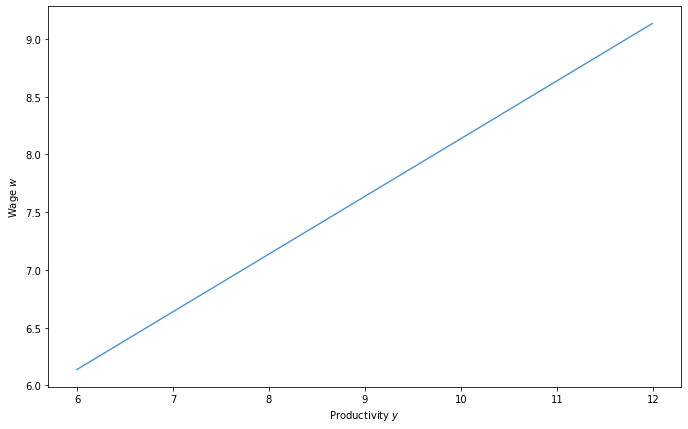

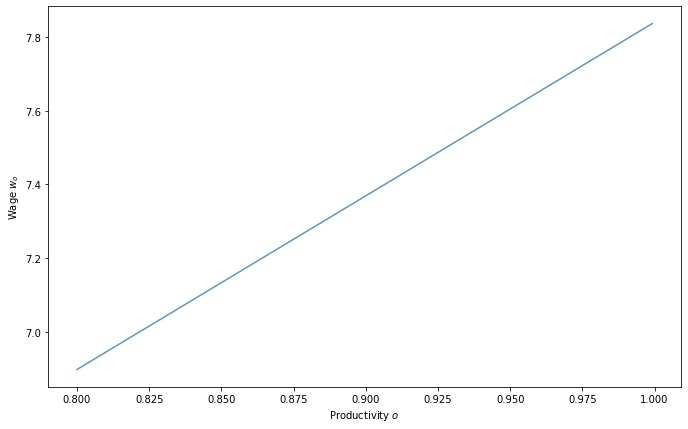

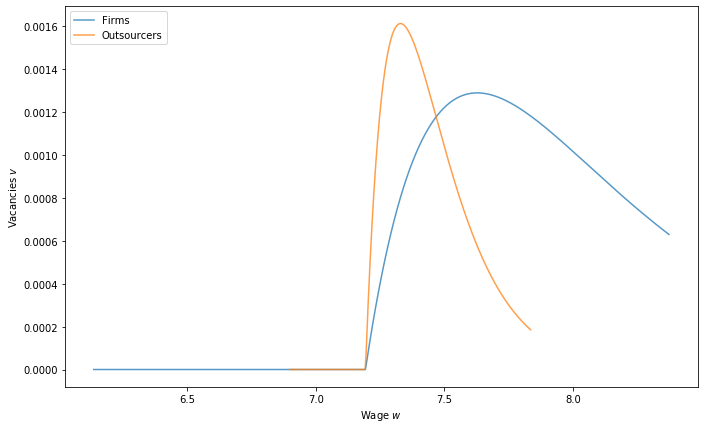

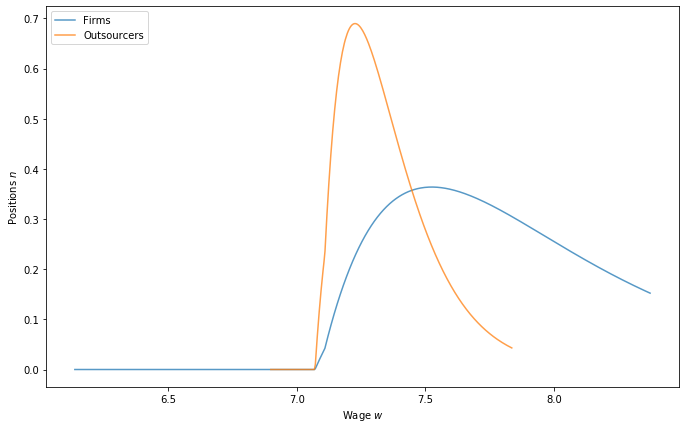

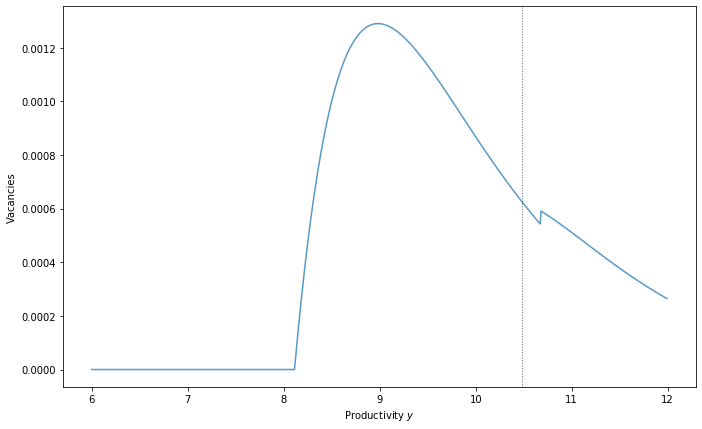

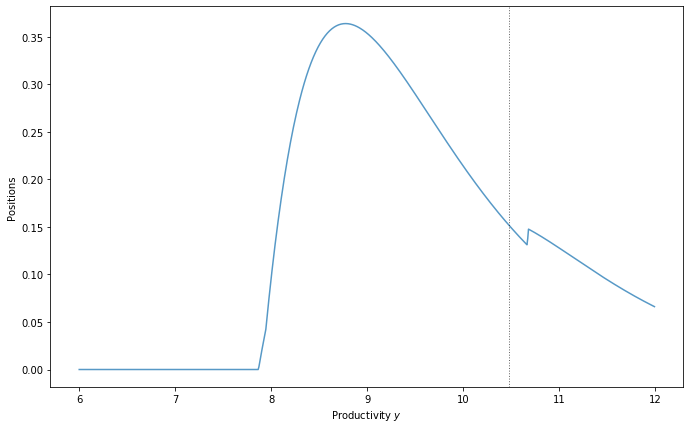

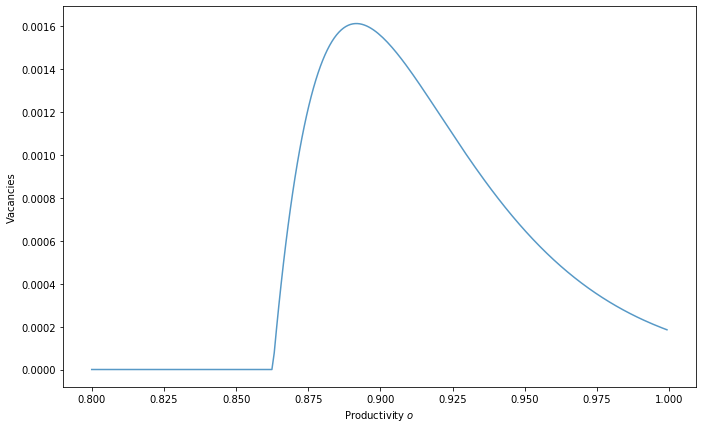

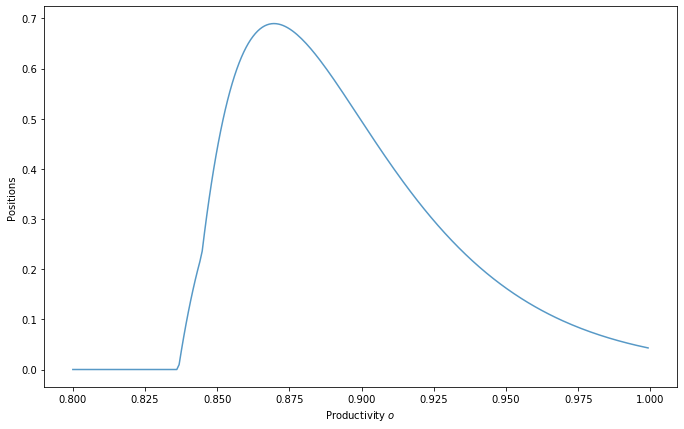

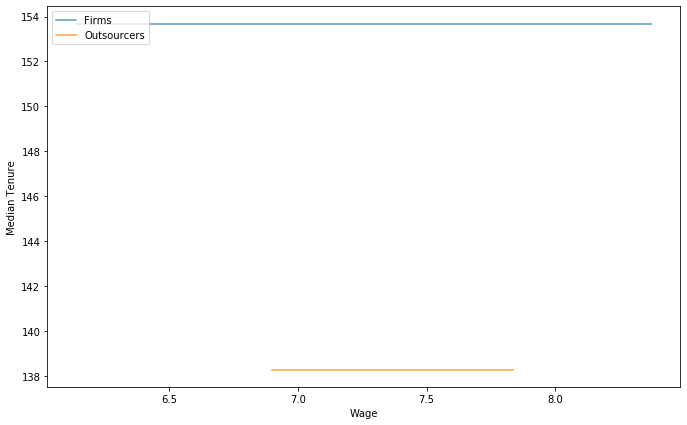

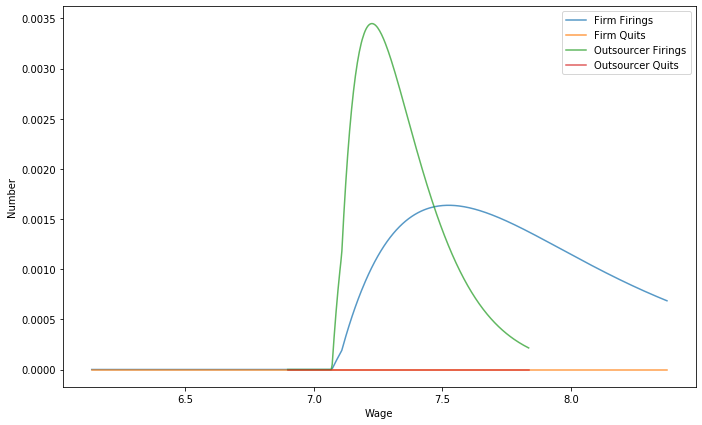

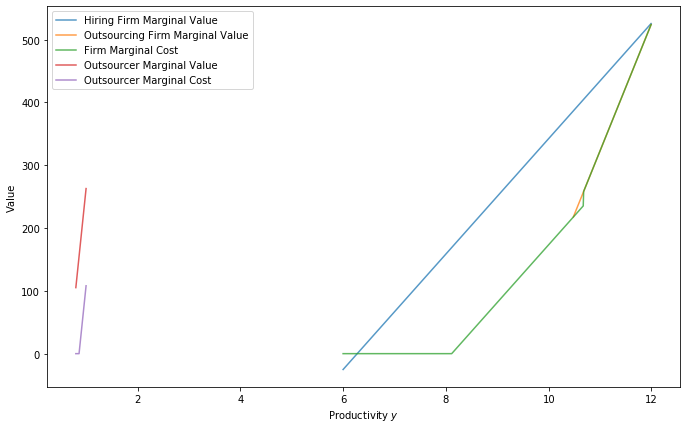

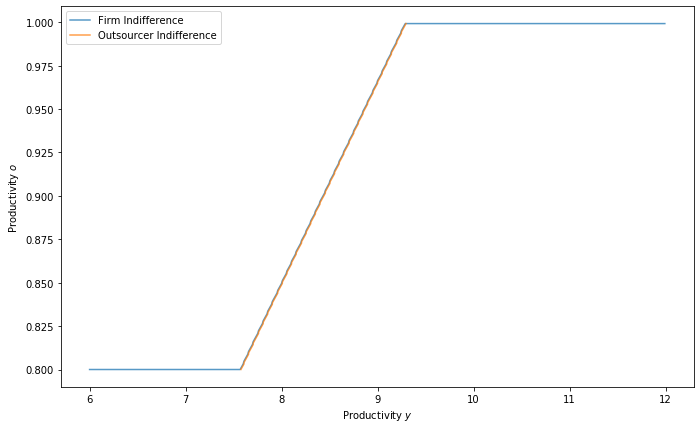

C:\Users\spspi\Anaconda3\lib\site-packages\ipykernel_launcher.py:614: RuntimeWarning: invalid value encountered in true_divide


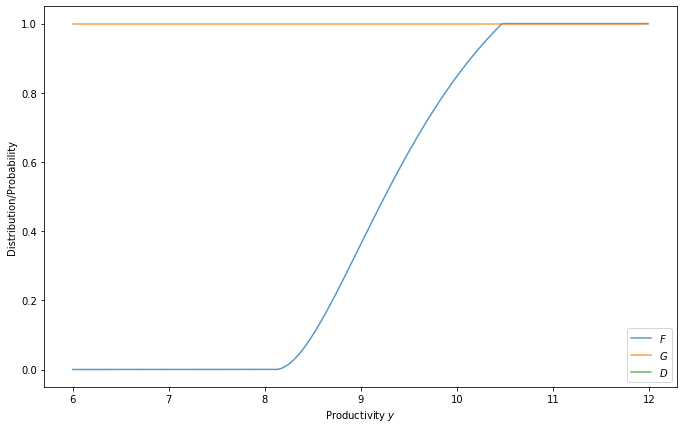

C:\Users\spspi\Anaconda3\lib\site-packages\ipykernel_launcher.py:630: RuntimeWarning: invalid value encountered in true_divide


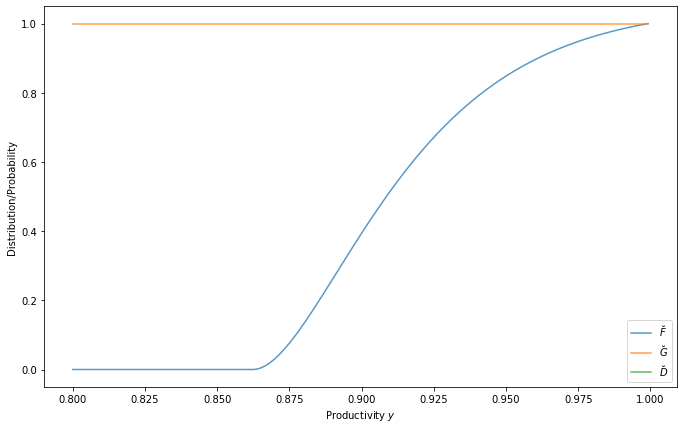

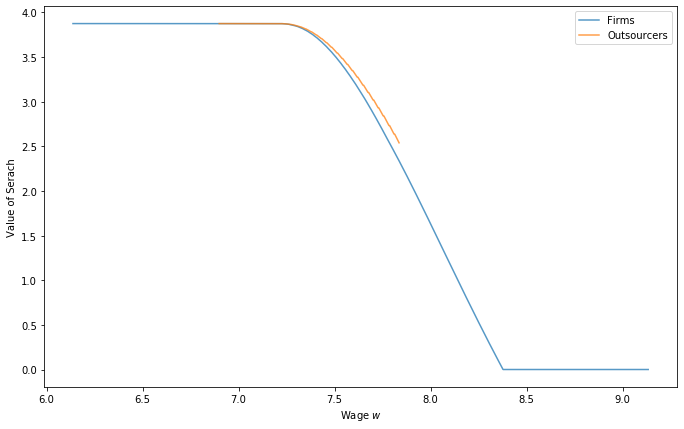

(0.16781707225120004, 0.14329024979847024)

In [229]:
iterate, QD_QS, make_grids, _, _, _, _, _, _ = operator_factory(ooj)
v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new = iterate(
    v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)

graph_results(ooj, v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, p)

QD_QS(n_grid_new, n_o_grid_new, y_hat_new)

error is 0.0119, went through 10000 iterations
The difference in theta and theta_new is -0.0600


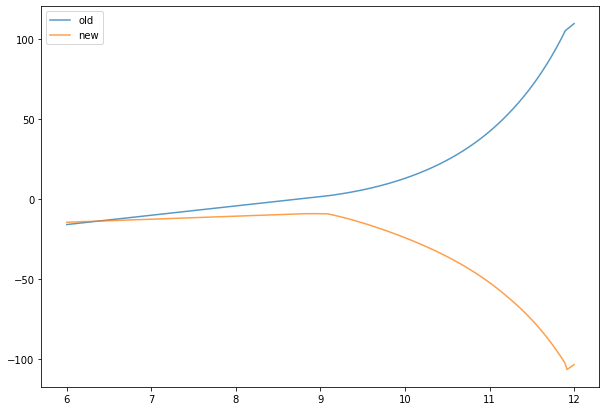

The indifferent firm is y_hat = 11.92$. Price of outsourcing is 11.37.
Unemployment is 1.66. According to LoM, should be 4.44
Workers match with probability 9.85. Firms/Outsourcers match with probability 40.61
Total vacancies searching for workers are 0.0279. Theta is 0.2425
31 percent of vacancies searching for workers are from outsourcers, 16 percent of postions outsourced
The ue rate is 0.10, the ee rate is 0.01,  and 15.963256 of new jobs are from unemployment
Checking if vacancies + LoM imply right positions:
 Hiring firms large error = 0.949235 at position 7871 
 Outsourcing firms largest error = 0.000000 at position 0
 Outsourcer largest error = 1.565387 at position 52


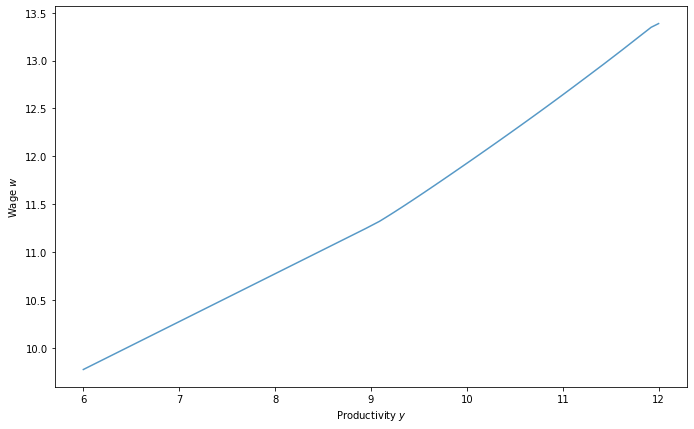

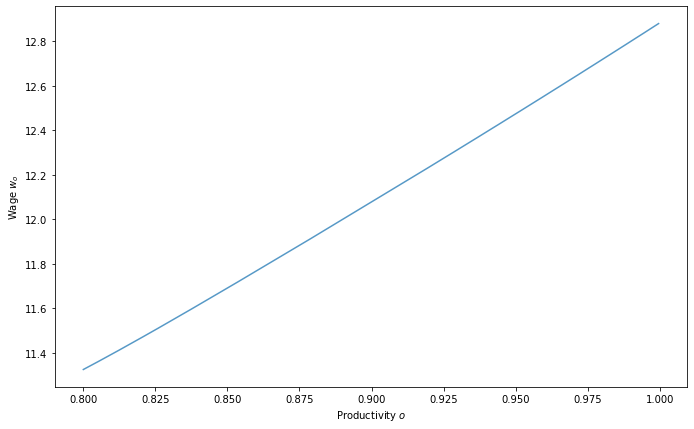

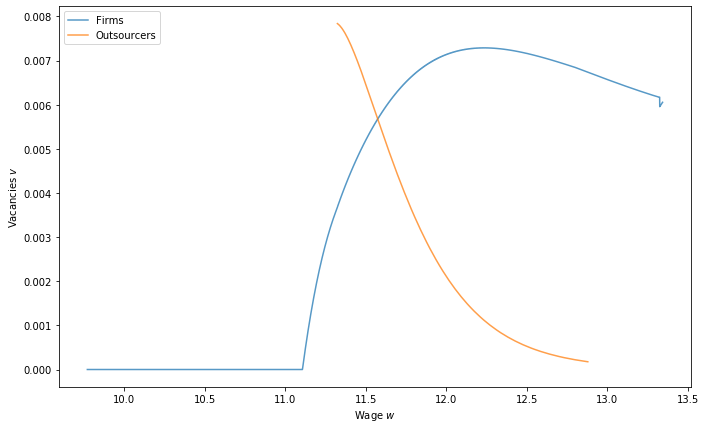

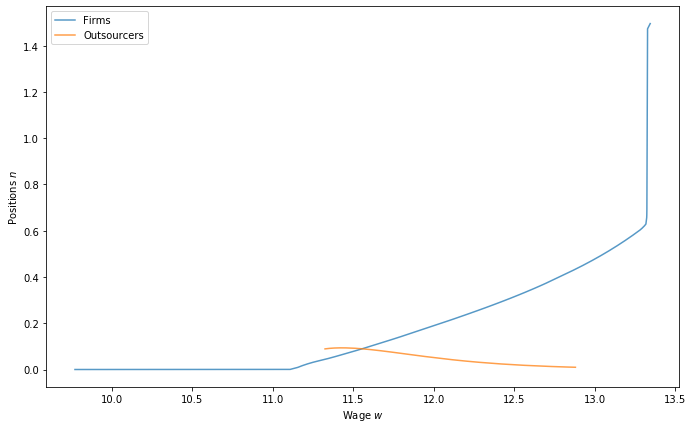

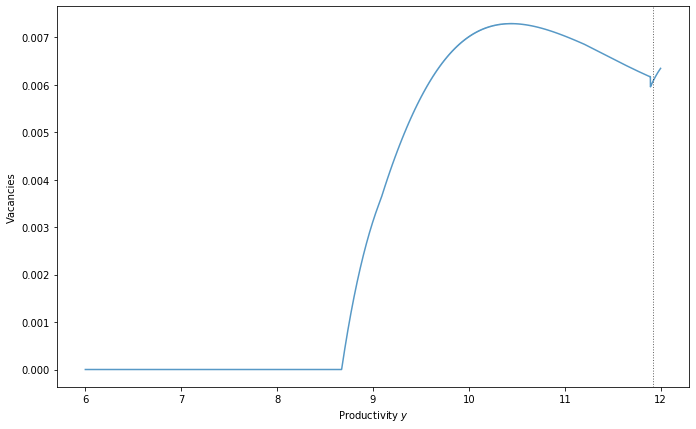

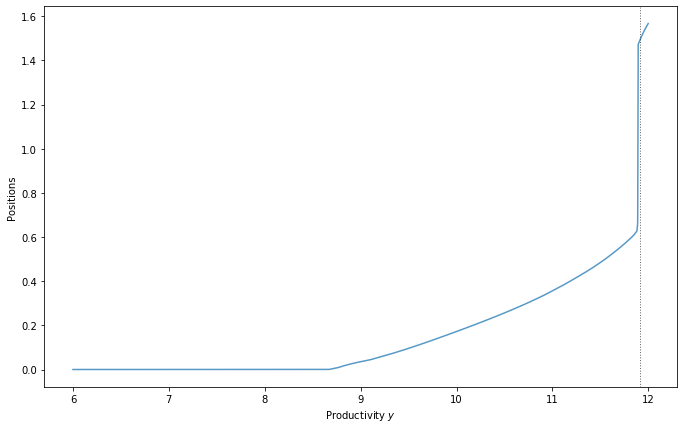

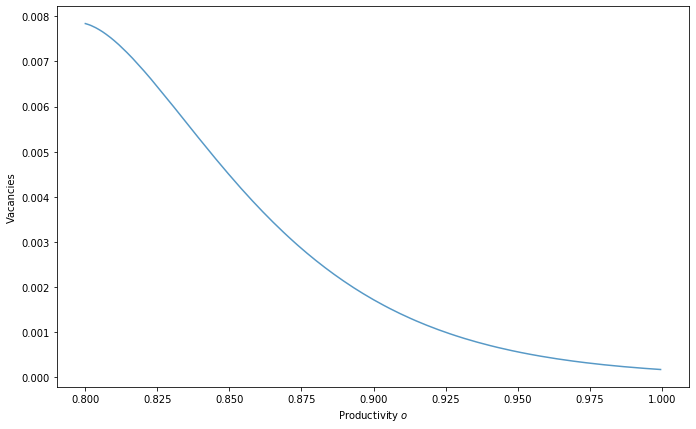

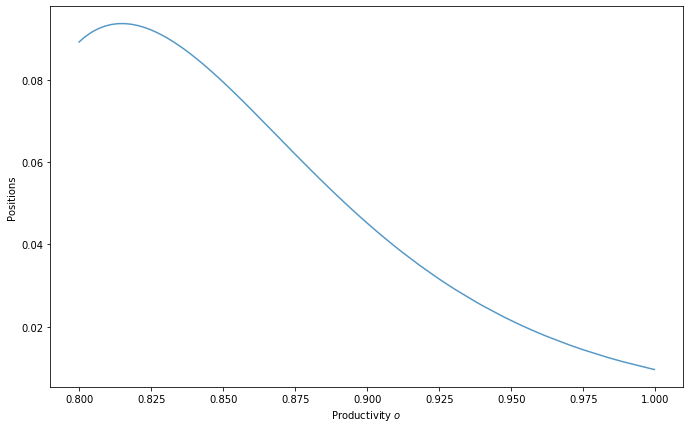

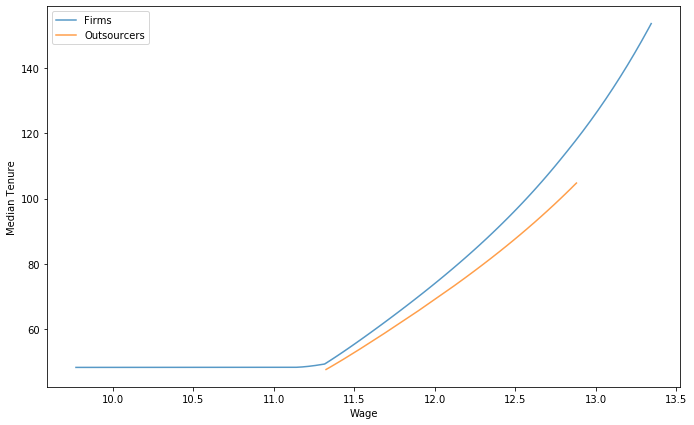

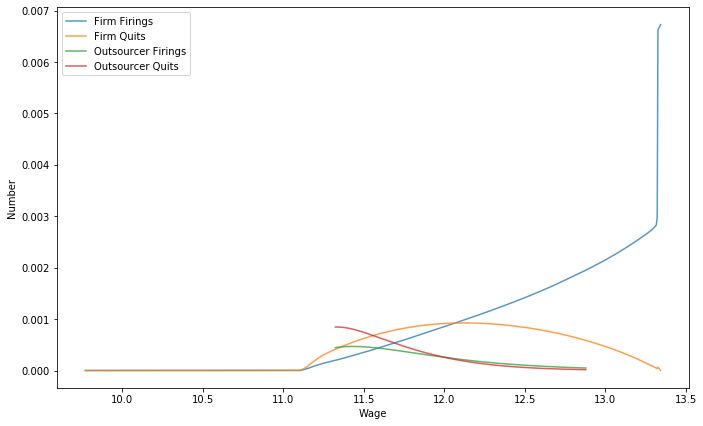

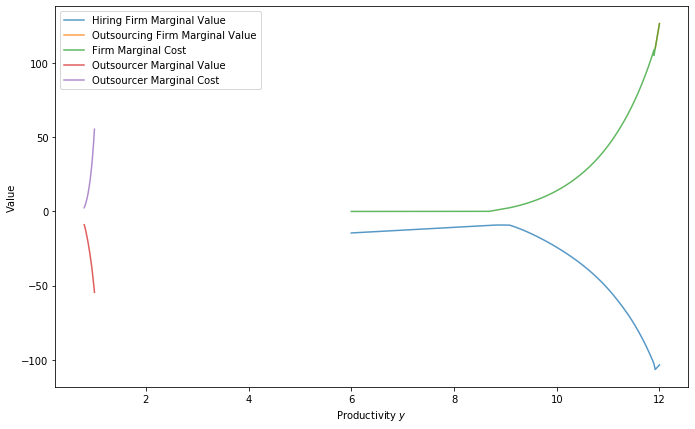

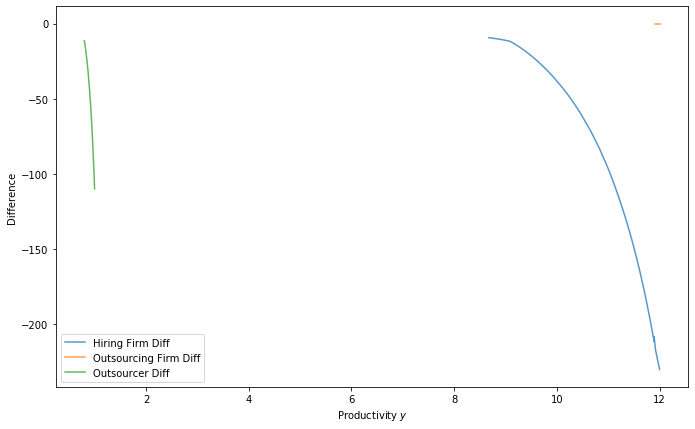

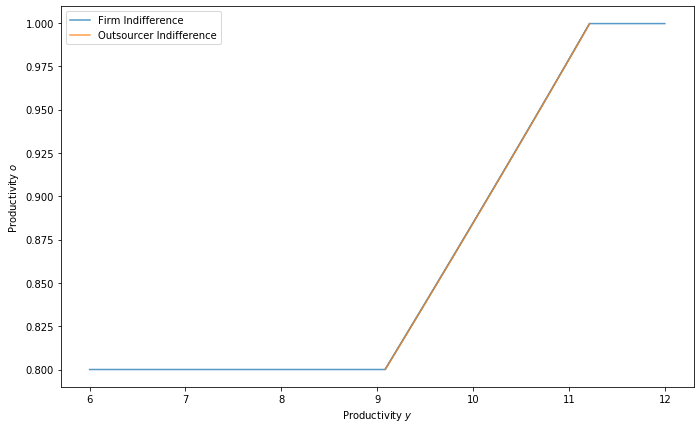

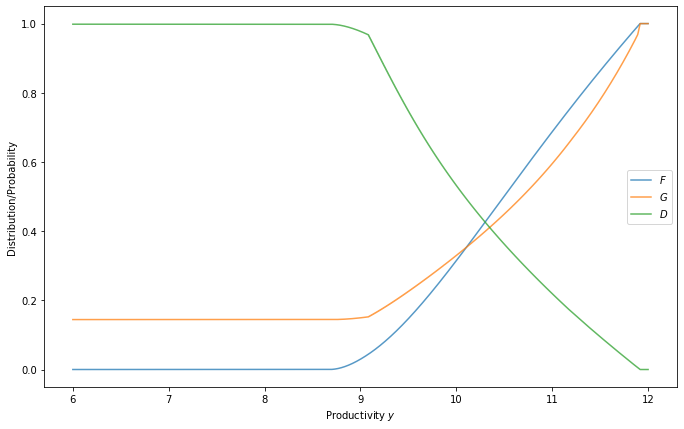

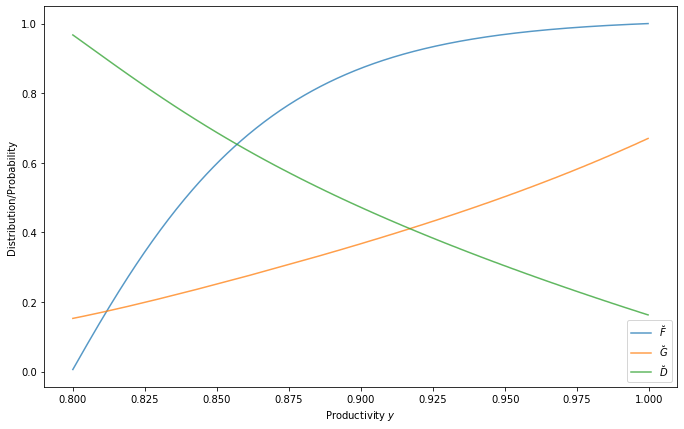

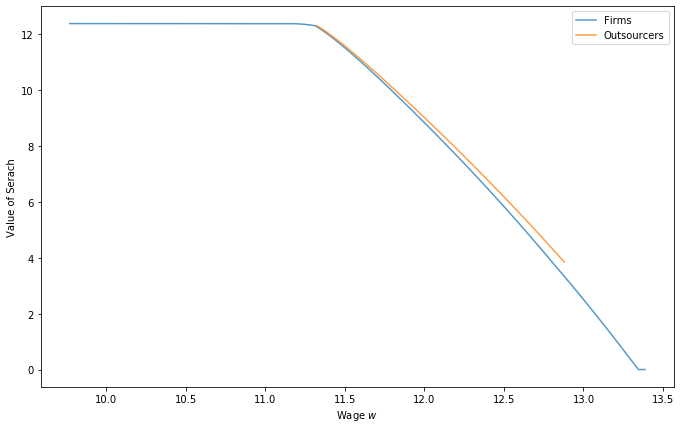

In [24]:
tol = 1e-4
max_iter = 1e4
slow = 1e-2
verbose = True

v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new = solve_given_p(
    ooj, p, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, tol, max_iter, slow, verbose
)

list_facts(ooj, v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, p)

graph_results(ooj, v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, p)

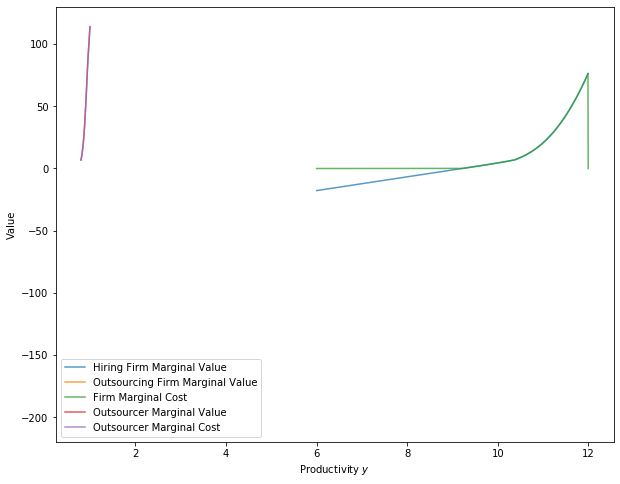

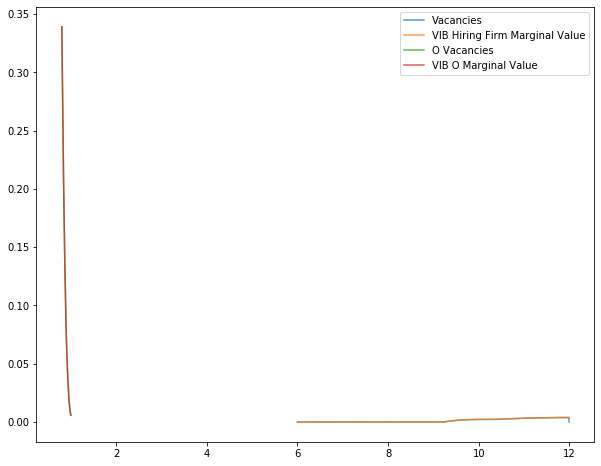

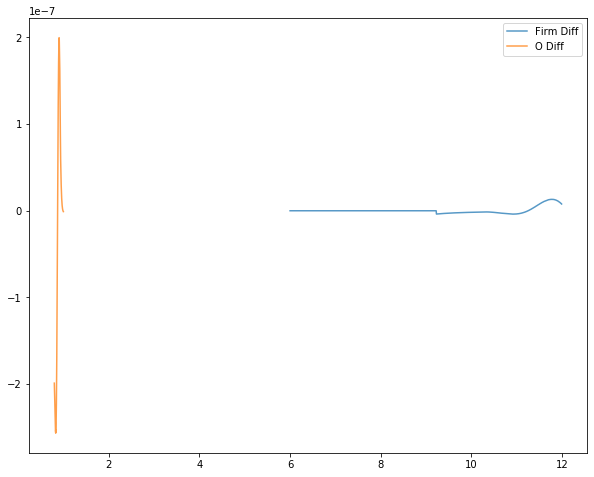

In [37]:
iterate, QD_QS, make_grids, C, c, c_inv, C_o, c_o, c_o_inv = operator_factory(ooj)

(theta, G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)

# (theta, G_grid, G_o_grid, D_grid, D_o_grid,
#          Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
#             v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, p)

q = ooj.q
y_grid, o_grid = ooj.y_grid, ooj.o_grid

J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + (1 - delta) * D_grid)
J_out = (y_grid - p) / (r + delta_hat)
mc = c(v_grid)    

O = q(theta) * G_o_grid * (p * o_grid - w_o_grid) / (r + delta_o + (1 - delta_o) * D_o_grid)
mc_o = c_o(v_o_grid) 

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(y_grid, J_hire, alpha=0.75, label="Hiring Firm Marginal Value")
ax.plot(y_grid[y_hat:], J_out[y_hat:], alpha=0.75, label="Outsourcing Firm Marginal Value")
ax.plot(y_grid, mc, alpha=0.75, label="Firm Marginal Cost")
ax.plot(o_grid, O, alpha=0.75, label="Outsourcer Marginal Value")
ax.plot(o_grid, mc_o, alpha=0.75, label="Outsourcer Marginal Cost")
ax.set(xlabel="Productivity $y$", ylabel="Value")
ax.legend(loc="best")

plt.show()

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(y_grid, v_grid, alpha=0.75, label="Vacancies")
ax.plot(y_grid, c_inv(J_hire), alpha=0.75, label="VIB Hiring Firm Marginal Value")
ax.plot(o_grid, v_o_grid, alpha=0.75, label="O Vacancies")
ax.plot(o_grid, c_o_inv(O), alpha=0.75, label="VIB O Marginal Value")
ax.legend(loc="best")

plt.show()

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(y_grid[:y_hat], v_grid[:y_hat] - c_inv(J_hire)[:y_hat], alpha=0.75, label="Firm Diff")
ax.plot(o_grid, v_o_grid - c_o_inv(O), alpha=0.75, label="O Diff")
ax.legend(loc="best")

plt.show()

In [64]:
# Set up code for the outsourcer's problem with on-the-job search
# Builds on Outsourcers file

import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit, prange, vectorize, int32, float64
from IPython.core.debugger import set_trace

class OutsourcingOnJob:
    """
    B is discount rate beta
    r is interest rate defined by beta
    b is home production
    delta is job loss rate at firm
    delta_o is job loss rate at outsourcer
    delta_hat is firm destruction rate of outsourcing firm <= delta
    xi is probability of searching on-the-job
    eta is workers bargaining power with firm
    eta_o is workers bargaining power with outsourcer
    phi is effectiveness of matching function
    y_min, y_max, y_grid_size determine firm productivity grid
    rm is to Reimann Sum approximate firm integrals
    o_min, o_max, o_grid_size determine outsourcer productivity grid
    rm_o is to Reimann Sum approximate outsourcer integrals
    gamma is steepness of marginal cost, k_grid is level of entry cost
    gamma_h is steepness of marginal cost for outsourcers, k_o_grid is level of cost
    q is matching function of firms
    ell is matching function of workerso
    """
    def __init__(
        self, B, b, delta, delta_o, delta_hat, xi, eta, eta_o, phi,
        y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
        gamma, gamma_o, k_grid, k_o_grid
    ):
        
        self.B, self.b, self.delta, self.eta, self.gamma, self.k_grid = B, b, delta, eta, gamma, k_grid
        self.delta_hat, self.eta_o, self.gamma_o, self.k_o_grid = delta_hat, eta_o, gamma_o, k_o_grid 
        self.xi, self.delta_o = xi, delta_o
        self.r = 1 / B - 1
        
        self.y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
        self.y_grid_size = y_grid_size    
        self.rm = (y_max - y_min) / y_grid_size
        
        self.o_grid = np.linspace(o_min, o_max, o_grid_size, endpoint = False)
        self.o_grid_size = o_grid_size    
        self.rm_o = (o_max - o_min) / o_grid_size
        
        self.q = njit(lambda x: min(phi * x**(-1 / 2), 1))
        self.ell = njit(lambda x: min(phi * x**(1 / 2), 1))
#         # Remember, q_p and p_p = 0 if q or p = 1
#         self.q_p = njit(lambda x: -phi / 2 * x**(-3 / 2) * (phi * x**(-1 / 2) < 1)) 
#         self.ell_p = njit(lambda x: phi / 2 * x**(1 / 2) * (phi * x**(1 / 2) < 1))


# Set up neccesary functions
def operator_factory(ooj):
    
    r, b, delta, eta, gamma, k_grid = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma, ooj.k_grid
    delta_hat, eta_o, gamma_o, k_o_grid = ooj.delta_hat, ooj.eta_o, ooj.gamma_o, ooj.k_o_grid
    xi, delta_o = ooj.xi, ooj.delta_o
    q, ell = ooj.q, ooj.ell
    
    y_grid, y_grid_size, rm = ooj.y_grid, ooj.y_grid_size, ooj.rm
    o_grid, o_grid_size, rm_o = ooj.o_grid, ooj.o_grid_size, ooj.rm_o
    
    # Want cost of vacancy, marginal cost of vacancy, and inverse marginal cost of vacancy
    @njit()
    def C(v_grid):
        return k_grid * v_grid**gamma
    
    @njit()
    def c(v_grid):
        return k_grid * gamma * v_grid**(gamma - 1)

    @njit()
    def c_inv(c_grid):
        return (np.maximum(c_grid, 0) / (gamma * k_grid))**(1 / (gamma - 1))
        
    # Do the same for outsourcers
    @njit()
    def C_o(v_o_grid):
        return k_o_grid * v_o_grid**gamma_o

    @njit()
    def c_o(v_o_grid):
        return k_o_grid * gamma_o * v_o_grid**(gamma_o - 1)

    @njit()
    def c_o_inv(c_o_grid):
        return (np.maximum(c_o_grid, 0) / (gamma_o * k_o_grid))**(1 / (gamma_o - 1))
    
    # Given v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, and p, find
    # Firms who directly hire hire vs those that outsource out
    # Distribution of vacanices F and F_o
    # Distribution of job seekers G and G_o
    # Probability of worker leaving D and D_o
    # Wages w and w_o
    @njit()
    def make_grids(v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p):           
        
        # Define aggregate populations (make sure all exist)
        u = max(1 - np.sum(n_grid[:y_hat] * rm) - np.sum(n_o_grid * rm_o), 1e-9)
        v_tilde = max(np.sum(v_grid[:y_hat] * rm), 1e-9)
        v_o = max(np.sum(v_o_grid * rm_o), 1e-9)
        s = (u + xi * (np.sum(n_grid[:y_hat] * rm) + np.sum(n_o_grid * rm_o)))
        
        # Calculate pi 
        v_sum = v_tilde + v_o
        pi = v_o / v_sum
        
        # Calculate distributions 
        # F is distribution of vacancies (include firms above y_hat in cdf as 1)
        F_grid = np.minimum(np.cumsum(v_grid * rm) / v_tilde, 1)
        f_grid = v_grid / v_tilde
        f_grid[y_hat:] = 0
        
        F_o_grid = np.cumsum(v_o_grid * rm_o) / v_o
        f_o_grid = v_o_grid / v_o
        
        # G is distribution of job seekers (include firms above y_hat as bigger than all y firms)
        n_temp = np.copy(n_grid)
        n_temp[y_hat:] = 0
        G_grid = (
            (u + xi * (np.cumsum(n_temp * rm)
                       + np.array([np.sum(n_o_grid[:R] * rm_o) for R in R_grid]))) 
            / s
        )
        G_o_grid = (
            (u + xi * (np.array([np.sum(n_temp[:R_o] * rm) for R_o in R_o_grid]) 
                       + np.cumsum(n_o_grid * rm_o))) 
            / s
        )
        
        # D is probability a worker finds a better job
        D_grid = xi * ell(theta) * (1 - (1 - pi) * F_grid - pi * F_o_grid[R_grid]) 
        D_o_grid = xi * ell(theta) * (1 - (1 - pi) * F_grid[R_o_grid] - pi * F_o_grid) 
        
        # What is the value of search?
        # Store these vectors of values which will be used many times
        f_tot = c(v_grid) / G_grid * f_grid * rm
        o_tot = c_o(v_o_grid) / G_o_grid * f_o_grid * rm_o
        
        # For unemployed
        firm = eta / (1 - eta) * (1 - pi) * np.sum(f_tot)
        out = eta_o / (1 - eta_o) * pi * np.sum(o_tot)
        Gamma_U = ell(theta) / q(theta) * (firm + out)
        
        # For employed at a firm
        firm = eta / (1 - eta) * (1 - pi) * np.cumsum(f_tot[::-1])[::-1]
        out = eta_o / (1 - eta_o) * pi * np.array([np.sum(o_tot[R:]) for R in R_grid])
        Gamma_grid = ell(theta) / q(theta) * (firm + out)
        
        # For employed at an outsourcer
        firm = eta / (1 - eta) * (1 - pi) * np.array([np.sum(f_tot[R_o:]) for R_o in R_o_grid])
        out = eta_o / (1 - eta_o) * pi * np.cumsum(o_tot[::-1])[::-1]
        Gamma_o_grid = ell(theta) / q(theta) * (firm + out)
        
        # Find wages
        w_grid = eta * y_grid + (1 - eta) * (b + Gamma_U - (1 - delta) * xi * Gamma_grid) 
        w_o_grid = eta_o * p * o_grid + (1 - eta_o) * (b + Gamma_U - (1 - delta_o) * xi * Gamma_o_grid) 
        
        return (
            G_grid, G_o_grid, D_grid, D_o_grid, 
            Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid
        )
    
    # Given v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, and p, find new values
    @njit()
    def iterate(v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p):
        
        (G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p)
        
        v_grid_new = np.empty(y_grid_size)
        n_grid_new = np.empty(y_grid_size)
        
        # Value of firms
        J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + (1 - delta) * D_grid)
        J_out = (y_grid - p) / (r + delta_hat)
        
        # Update y_hat by finding firm closest to indifferent between hiring/outsourcing
        # Make sure J_out is non_negative at y_hat
#         y_hat_new = min(np.searchsorted(J_out - np.maximum(J_hire, 0), 0), y_grid_size - 1)
        y_diff = np.argmin(np.abs(J_out - J_hire))
        y_zero = np.argmin(np.abs(J_out))
        y_hat_new = max(y_diff, y_zero)
        
        # Update vacancies
        # Hiring firms (below y_hat)
        v_grid_new[:y_hat] = c_inv(J_hire)[:y_hat]
        
        # Outsourcing firms (above y_hat)
        v_grid_new[y_hat:] = c_inv(J_out)[y_hat:]
        
        # Outsourcers
        v_o_grid_new = c_o_inv(
            (o_grid * p - w_o_grid) * q(theta) * G_o_grid / (r + delta_o + (1 - delta_o) * D_o_grid)
        )
        
        # Update positions
        # Hiring firms
        n_temp = (1 - delta) * (1 - D_grid) * n_grid + q(theta) * G_grid * v_grid_new
        n_grid_new[:y_hat] = n_temp[:y_hat]
        
        # Outsourcing firms
        n_grid_new[y_hat:] = (1 - delta_hat) * n_grid[y_hat:] + v_grid_new[y_hat:]
        
        # Outsourcers
        n_o_grid_new = (1 - delta_o) * (1 - D_o_grid) * n_o_grid + q(theta) * G_o_grid * v_o_grid_new
               
        # Update R_grid and R_o_grid by comparing W - U to W_o - U.
        # Note that R_grid is defined for all firms, even those above 
        # y_hat, and R_o_grid might be indiffeferent to a firm above y_hat that doesn't hire
        # Value of employment at a firm (minus value of unemployment)        
        W_min_U = (
            (1 + r) * (w_grid - b - Gamma_U + (1 - delta) * xi * Gamma_grid)
            / (r + delta + (1 - delta) * D_grid)
        )
        
        # Value of employment at an outsourcer (minus value of unemployment)
        W_o_min_U = (
            (1 + r) * (w_o_grid - b - Gamma_U + (1 - delta_o) * xi * Gamma_o_grid)
            / (r + delta_o + (1 - delta_o) * D_o_grid)
        )
                
        # Use these to find new indecision rules
#         R_grid_new = np.array(
#             [np.argmin(np.abs(W_min_U[i] - W_o_min_U)) for i in np.arange(y_grid_size)]
#         )
#         R_o_grid_new = np.array(
#             [np.argmin(np.abs(W_min_U - W_o_min_U[i])) for i in np.arange(o_grid_size)]
#         )

        # Use these and search sorted to find new indecision rules (make sure not above all)
        R_grid_new = np.minimum(np.searchsorted(W_o_min_U, W_min_U), o_grid_size - 1)
    
        R_o_grid_new = np.minimum(np.searchsorted(W_min_U, W_o_min_U), y_grid_size - 1)
        
        # Update theta
        u = max(1 - np.sum(n_grid_new[:y_hat] * rm) - np.sum(n_o_grid_new * rm_o), 1e-9)
        v_tilde = max(np.sum(v_grid_new[:y_hat] * rm), 1e-9)
        v_o = max(np.sum(v_o_grid_new * rm_o), 1e-9)
        s = (u + xi * (np.sum(n_grid_new[:y_hat] * rm) + np.sum(n_o_grid_new * rm_o)))
        theta_new = (v_tilde + v_o) / (u + xi * (1 - u))
        
        return (v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new,
                y_hat_new, R_grid_new, R_o_grid_new, theta_new)
    
    # Given n_grid, n_o_grid, and y_hat find excess demand for outsourcing 
    @njit()
    def QD_QS(n_grid, n_o_grid, y_hat):
        QD = np.sum(n_grid[y_hat:] * rm) 
        QS = np.sum(n_o_grid * o_grid * rm_o)
        return QD, QS
    
    return iterate, QD_QS, make_grids, C, c, c_inv, C_o, c_o, c_o_inv 

# @njit()
def solve_given_p(
    ooj, p, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, tol, max_iter, slow, verbose=False
):
    
    iterate, _, make_grids, _, _, _, _, _, _ = operator_factory(ooj)
    
    # Set up initial loop parameters
    i = 0
    err = tol + 1    
    
    # Update v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, and theta
    while i < max_iter and err > tol:
        (v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new,
         y_hat_new, R_grid_new, R_o_grid_new, theta_new) = iterate(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p
        )
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_v_o = np.max(np.abs(v_o_grid_new - v_o_grid))
        err_n = np.max(np.abs(n_grid_new - n_grid))
        err_n_o = np.max(np.abs(n_o_grid_new - n_o_grid))
        err = max(err_v, err_v_o, err_n, err_n_o)
        i += 1
        
        v_grid = slow * v_grid_new + (1 - slow) * v_grid
        v_o_grid = slow * v_o_grid_new + (1 - slow) * v_o_grid
        n_grid = slow * n_grid_new + (1 - slow) * n_grid
        n_o_grid = slow * n_o_grid_new + (1 - slow) * n_o_grid
        theta = slow * theta_new + (1 - slow) * theta
        
        # To slowly adjust y_hat, R_grid, and R_o_grid (which are indexes), instead 
        # add/subtract by 1/5 if greater/less (depend on size)
#         y_pos = 1 * (y_hat_new > y_hat) + 4 * (y_hat_new - y_hat > 50)
#         y_neg = 1 * (y_hat_new < y_hat) + 4 * (y_hat_new - y_hat < -50)
#         y_hat = y_hat + y_pos - y_neg
        
#         R_pos = 1 * (R_grid_new > R_grid) + 4 * (R_grid_new - R_grid > 50)
#         R_neg = 1 * (R_grid_new < R_grid) + 4 * (R_grid_new - R_grid < -50)
#         R_grid = R_grid + R_pos - R_neg
        
#         R_o_pos = 1 * (R_o_grid_new > R_o_grid) + 4 * (R_o_grid_new - R_o_grid > 50)
#         R_o_neg = 1 * (R_o_grid_new < R_o_grid) + 4 * (R_o_grid_new - R_o_grid < -50)
#         R_o_grid = R_o_grid + R_o_pos - R_o_neg
        
        # To slowly adjust y_hat, R_grid, and R_o_grid (which are indexes), instead 
        # add/subtract by 1 if greater/less 
        y_hat = y_hat + 1 * (y_hat_new > y_hat) - 1 * (y_hat_new < y_hat)
        R_grid = R_grid + 1 * (R_grid_new > R_grid) - 1 * (R_grid_new < R_grid)
        R_o_grid = R_o_grid + 1 * (R_o_grid_new > R_o_grid) - 1 * (R_o_grid_new < R_o_grid)

    if verbose:
        (G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p)
        (G_grid_new, G_o_grid_new, D_grid_new, D_o_grid_new,
         Gamma_U_new, Gamma_grid_new, Gamma_o_grid_new, w_grid_new, w_o_grid_new) = make_grids(
            v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, theta_new, p)
        
        theta_diff = theta - theta_new
        J_hire = (ooj.q(theta) * G_grid * (ooj.y_grid - w_grid)
                  / (ooj.r + ooj.delta + (1 - ooj.delta) * D_grid))
        J_hire_new = (ooj.q(theta_new) * G_grid_new * (ooj.y_grid - w_grid_new)
                      / (ooj.r + ooj.delta + (1 - ooj.delta) * D_grid_new))
#         J_diff = max(np.abs(J_hire_new - J_hire))
        
        print(f"error is {err:.4f}, went through {i} iterations")
        print(f"y_hat is {y_hat:.4f}, y_hat_new is {y_hat_new:.4f}")
        print(f"The difference in theta and theta_new is {theta_diff:.4f}")
        fig, ax = plt.subplots(figsize=(10, 7))
        ax.plot(ooj.y_grid, J_hire, alpha=0.75, label="old")
        ax.plot(ooj.y_grid, J_hire_new, alpha=0.75, label="new")
        ax.legend()
        plt.show()       
        
    return (
        v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat, R_grid_new, R_o_grid_new, theta_new
    )

# Find p
def find_p(
    ooj, p_low, p_high, tol, max_iter, tol_i, max_iter_i, slow_i, verbose=True, print_skip=100
):
    
    iterate, QD_QS, _, _, _, _, _, _, _ = operator_factory(ooj)
    
    xi, rm, rm_o = ooj.xi, ooj.rm, ooj.rm_o
    y_grid, y_grid_size = ooj.y_grid, ooj.y_grid_size  
    o_grid, o_grid_size = ooj.o_grid, ooj.o_grid_size 
    
    # Set up loop parameters    
    err = tol + 1
    j = 0
    test = []
    
    # Find excess_demand for p_low and p_high, make sure they have opposite signs
    for p in [p_low, p_high]:
        # Initial guesses
        v_grid = np.ones(y_grid_size) / y_grid_size
        n_grid = np.ones(y_grid_size) / y_grid_size
        v_o_grid = np.ones(o_grid_size) / o_grid_size
        n_o_grid = np.ones(o_grid_size) / o_grid_size
#         y_hat = np.intc(y_grid_size / 2)
        y_hat = np.argmin(np.abs(p - y_grid))
        R_grid = np.minimum(np.arange(y_grid_size), o_grid_size - 1, dtype=np.int64)
        R_o_grid = np.minimum(np.arange(o_grid_size), y_grid_size - 1, dtype=np.int64)
        v_tot = np.sum(v_grid_new[:y_hat] * rm) + np.sum(v_o_grid_new * rm_o)
        u = 1 - np.sum(n_grid_new[:y_hat] * rm) + np.sum(n_o_grid_new * rm_o)
        theta = v_tot / (u + xi * (1 - u))
        
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta = solve_given_p(
            ooj, p, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, tol_i, max_iter_i, slow_i
        )
        QD, QS = QD_QS(n_grid, n_o_grid, y_hat)
        test.append(QD - QS)
        
        if verbose:
            print(f'Excess Demand for price {p} is {QD - QS:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
            
#         set_trace()
            
    if np.cumprod(test)[1] > 0:
        print('Test failed, both prices have positive/negative excess demand')
        return
        
    while err > tol and j < max_iter:
        p = (p_low + p_high) / 2
        
#         # Initial guesses (reset initially)
#         if j <= 5:
        v_grid = np.ones(y_grid_size) / y_grid_size
        n_grid = np.ones(y_grid_size) / y_grid_size
        v_o_grid = np.ones(o_grid_size) / o_grid_size
        n_o_grid = np.ones(o_grid_size) / o_grid_size
#             y_hat = np.intc(y_grid_size / 2)
        y_hat = np.argmin(np.abs(p - y_grid))
        R_grid = np.minimum(np.arange(y_grid_size), o_grid_size - 1, dtype=np.int64)
        R_o_grid = np.minimum(np.arange(o_grid_size), y_grid_size - 1, dtype=np.int64)
        v_tot = np.sum(v_grid_new[:y_hat] * rm) + np.sum(v_o_grid_new * rm_o)
        u = 1 - np.sum(n_grid_new[:y_hat] * rm) + np.sum(n_o_grid_new * rm_o)
        theta = v_tot / (u + xi * (1 - u))
              
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta = solve_given_p(
    ooj, p, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, tol_i, max_iter_i, slow_i
)
        QD, QS = QD_QS(n_grid, n_o_grid, y_hat)
        ed = QD - QS
        err = np.abs(ed)
        
        # If excess demand QD - QS > 0, set p_low = p, otherwise p_high = p
        if ed > 0:
            p_low = p
        else:
            p_high = p
            
        if verbose and j % print_skip == 0:
            print(
                f'Excess Demand at iter {j} is {ed:.4f}; price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}',
                f"y_hat is {y_grid[y_hat]}"
            )
            
        j += 1
        
#     # Run one more loop with 10 times the iterations, 1/100 the tolerance
#     if verbose:
#         print(
#             f'Excess Demand at iter {j} is {ed:.4f}; price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}',
#             f"y_hat is {y_grid[y_hat]}\n One more loop..."
#         )
            
#     v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid = solve_given_p(
#     ooj, p, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid,
#         tol_i / 100, max_iter_i * 10, slow_i
# )
#     QD, QS = QD_QS(n_grid, n_o_grid, y_hat)
#     ed = QD - QS
    
    if j < max_iter:
        print(f'Converged in {j} iterations, Excess Demand is {ed:.4f};',
              f' price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
    if j == max_iter:
        print(f'Failed to Converge. Excess Demand is {ed:.4f}; price is {p:.4f};',
              f' QS is {QS:.4f}; QD is {QD:.4f}')
        
    return v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p

# Create a function to graph results
def graph_results(ooj, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p,
                  save=False, height=7, 
                  folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures\Python Simulations\Test',
                  file=r'\Outsourcers OJS '):
    
    # Make sure dimensions are 1:1.62
    width = height * 1.62
    
    # Get data needed from ooj
    _, QD_QS, make_grids, C, c, c_inv, C_o, c_o, c_o_inv = operator_factory(ooj)
    
    (G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p
    )
    r, delta, xi, q, ell = ooj.r, ooj.delta, ooj.xi, ooj.q, ooj.ell
    delta_o, delta_hat = ooj.delta_o, ooj.delta_hat
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    y_grid_size, o_grid_size = ooj.y_grid_size, ooj.o_grid_size
    
    # Because firms and outsourcers may have different grid sizes, comparing 
    # plots directly may be misleading. To solve this, scale outsourcing
    # vacancies and positions to match relative grid sizes
    mult = o_grid_size / y_grid_size
    v_o_grid_p = v_o_grid * mult
    n_o_grid_p = n_o_grid * mult
        
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, w_grid, alpha=0.75)
    ax.plot(y_grid, y_grid, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Wage $w$")
    
    if save:
        fig.savefig(folder + file + 'Firm Wages v Productivity.pdf')
    else:
        plt.show()  
        
    # Graph outsourcer wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, w_o_grid, alpha=0.75)
    ax.plot(o_grid, o_grid * p, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $o$", ylabel="Wage $w_o$")
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Wages v Productivity.pdf')
    else:
        plt.show() 
        
    # Graph vacacies by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_hat], v_grid[:y_hat], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, v_o_grid_p, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Vacancies $v$")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Vacancies v Wages.pdf')
    else:
        plt.show()         
    
    # Graph filled posititions by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_hat], n_grid[:y_hat], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, n_o_grid_p, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Positions $n$")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Positions v Wages.pdf')
    else:
        plt.show() 
        
    # Graph firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid, alpha=0.75, label="Vacancies $v$")
#     ax.plot(y_grid, n_grid, alpha=0.75, label="Positions $n$")
    ax.axvline(x=y_grid[y_hat], c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies")
#     ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firm Vacancies.pdf')
    else:
        plt.show()
        
    # Graph firm postions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid, alpha=0.75, label="Positions $n$")
    ax.axvline(x=y_grid[y_hat], c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Positions")
#     ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firm Positions.pdf')
    else:
        plt.show()
        
    # Graph outsourcer vacancies and filled positions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, v_o_grid_p, alpha=0.75, label=r"Vacanicies $\breve{v}$")
#     ax.plot(o_grid, n_o_grid_p, alpha=0.75, label=r"Positions $\breve{n}$")
    ax.set(xlabel="Productivity $o$", ylabel="Vacancies")
#     ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Vacancies.pdf')
    else:
        plt.show()
        
    fig, ax = plt.subplots(figsize=(width, height))
#     ax.plot(o_grid, v_o_grid_p, alpha=0.75, label=r"Vacanicies $\breve{v}$")
    ax.plot(o_grid, n_o_grid_p, alpha=0.75, label=r"Positions $\breve{n}$")
    ax.set(xlabel="Productivity $o$", ylabel="Positions")
#     ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Outsourcer Positions.pdf')
    else:
        plt.show()
        
    # Graph median tenure by wage
    p_stay = (1 - delta) * (1 - D_grid)
    median_tenure = np.log(.5) / np.log(p_stay)
    p_o_stay = (1 - delta_o) * (1 - D_o_grid)
    median_tenure_o = np.log(.5) / np.log(p_o_stay)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_hat], median_tenure[:y_hat], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, median_tenure_o, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage", ylabel="Median Tenure")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'Median Tenure.pdf')
    else:
        plt.show()
        
    # Graph firings (lose jobs) vs quits (find better job) by wage
    firings = delta * n_grid
    quits = (1 - delta) * D_grid * n_grid
    firings_o = delta_o * n_o_grid
    quits_o = (1 - delta_o) * D_o_grid * n_o_grid
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_hat], firings[:y_hat], alpha=0.75, label="Firm Firings")
    ax.plot(w_grid[:y_hat], quits[:y_hat], alpha=0.75, label="Firm Quits")
    ax.plot(w_o_grid, firings_o, alpha=0.75, label="Outsourcer Firings")
    ax.plot(w_o_grid, quits_o, alpha=0.75, label="Outsourcer Quits")
    ax.set(xlabel="Wage", ylabel="Number")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Firings and Quits.pdf')
    else:
        plt.show()
        
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    # Do the same for outsourcers hiring
    J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + (1 - delta) * D_grid)
    J_out = (y_grid - p) / (r + delta_hat)
    mc = c(v_grid)    
    
    O = q(theta) * G_o_grid * (p * o_grid - w_o_grid) / (r + delta_o + (1 - delta_o) * D_o_grid)
    mc_o = c_o(v_o_grid) 
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_hire, alpha=0.75, label="Hiring Firm Marginal Value")
    ax.plot(y_grid[y_hat:], J_out[y_hat:], alpha=0.75, label="Outsourcing Firm Marginal Value")
    ax.plot(y_grid, mc, alpha=0.75, label="Firm Marginal Cost")
    ax.plot(o_grid, O, alpha=0.75, label="Outsourcer Marginal Value")
    ax.plot(o_grid, mc_o, alpha=0.75, label="Outsourcer Marginal Cost")
    ax.set(xlabel="Productivity $y$", ylabel="Value")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'M Value and Cost.pdf')
    else:
        plt.show()
        
    # Plot the differences from the above curves
    J_hire_diff = J_hire - mc
    J_out_diff = J_out - mc
    O_diff = O - mc_o
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[v_grid > 0], J_hire_diff[v_grid > 0], alpha=0.75, label="Hiring Firm Diff")
    ax.plot(y_grid[y_hat:], J_out_diff[y_hat:], alpha=0.75, label="Outsourcing Firm Diff")
    ax.plot(o_grid[v_o_grid > 0], O_diff[v_o_grid > 0], alpha=0.75, label="Outsourcer Diff")
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'M Value Minus Cost.pdf')
    else:
        plt.show()
        
    # Plot the workers' indifference curve for hired vs outsourced
    o_R_grid = o_grid[R_grid]
    y_R_o_grid = y_grid[R_o_grid]
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, o_R_grid, alpha=0.75, label="Firm Indifference")
    ax.plot(y_R_o_grid, o_grid, alpha=0.75, label="Outsourcer Indifference")    
    ax.set(xlabel="Productivity $y$", ylabel="Productivity $o$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "Worker's Indifference Curve.pdf")
    else:
        plt.show()
        
    # Plot various distribributions for the firm
    v_tilde = np.sum(v_grid[:y_hat] * rm)
    F_grid = np.minimum(np.cumsum(v_grid * rm) / v_tilde, 1)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, F_grid, alpha=0.75, label=r"$F$")  
    ax.plot(y_grid, G_grid, alpha=0.75, label=r"$G$") 
    ax.plot(y_grid, D_grid / (xi * ell(theta)), alpha=0.75, label=r"$D$")  
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "Firm Distributions.pdf")
    else:
        plt.show()
        
    # Plot various distribributions for the outsourcer
    v_o = np.sum(v_o_grid * rm_o)
    F_o_grid = np.cumsum(v_o_grid * rm_o) / v_o
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, F_o_grid, alpha=0.75, label=r"$\breve{F}$")  
    ax.plot(o_grid, G_o_grid, alpha=0.75, label=r"$\breve{G}$") 
    ax.plot(o_grid, D_o_grid / (xi * ell(theta)), alpha=0.75, label=r"$\breve{D}$")  
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "Outsourcer Distributions.pdf")
    else:
        plt.show()
        
    # Graph value of search by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid, Gamma_grid, alpha=0.75, label="Firms")
    ax.plot(w_o_grid, Gamma_o_grid, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Value of Serach")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Value of Search.pdf')
    else:
        plt.show()
        
# Create a function to print some facts that are useful
def list_facts(ooj, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p):
    
    _, QD_QS, make_grids, C, c, c_inv, C_o, c_o, c_o_inv = operator_factory(ooj)
    
    (G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p
    )
    delta, xi, q, ell = ooj.delta, ooj.xi, ooj.q, ooj.ell
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    
    print(f"The indifferent firm is y_hat = {y_grid[y_hat]:.2f}$. Price of outsourcing is {p:.2f}.")
    
    u = 1 - np.sum(n_grid[:y_hat] * rm) - np.sum(n_o_grid * rm_o) 
    pi = np.sum(v_o_grid * rm_o) / (np.sum(v_grid[:y_hat] * rm) + np.sum(v_o_grid * rm_o))
    zeta = np.sum(n_o_grid * rm_o) / (np.sum(n_grid[:y_hat] * rm) + np.sum(n_o_grid * rm_o))
    e_delta = (1 - zeta) * delta + zeta * delta_o 
    u_lom = e_delta / (e_delta + ell(theta))
    tot_v = np.sum(v_grid[:y_hat] * rm) + np.sum(v_o_grid * rm_o)
    print(f"Unemployment is {u * 100:.2f}. According to LoM, should be {u_lom * 100:.2f}")
    print(f"Workers match with probability {ell(theta) * 100:.2f}.",
          f"Firms/Outsourcers match with probability {q(theta) * 100:.2f}")
    print(f"Total vacancies searching for workers are {tot_v:.4f}. Theta is {theta:.4f}")
    print(f"{pi * 100:.0f} percent of vacancies searching for workers are from outsourcers,",
          f"{zeta * 100:.0f} percent of postions outsourced")
    
    # Document ue rate, ee rate, and percent of jobs from unemployment
    ue = ell(theta)
    ee = (
        (np.sum(n_grid[:y_hat] * D_grid[:y_hat] * rm) / np.sum(n_grid[:y_hat] * rm) + 
         np.sum(n_o_grid * D_o_grid * rm_o) / np.sum(n_o_grid * rm_o))
    )
    per_from_u = 100 * ue * u / (ue * u + ee * (1 - u))
    print(f"The ue rate is {ue:.2f}, the ee rate is {ee:.2f},",
          f" and {per_from_u:0f} of new jobs are from unemployment")  
                       
    # Do firm/outsourcer vacancies and positions line up in steady state?
    n_ss_tilde = v_grid[:y_hat] * q(theta) * G_grid[:y_hat] / delta
    n_tilde = n_grid[:y_hat]
    if y_hat > min(y_grid):
        err_tilde = max(np.abs(n_ss_tilde - n_tilde))
        err_tilde_at = np.argmax(np.abs(n_ss_tilde - n_tilde))
    else:
        err_tilde = 0
        err_tilde_at = 0
    
    n_ss_hat = v_grid[y_hat:] / delta_hat
    n_hat = n_grid[y_hat:]
    if y_hat < max(y_grid):
        err_hat = max(np.abs(n_ss_hat - n_hat))
        err_hat_at = np.argmax(np.abs(n_ss_hat - n_hat))
    else:
        err_hat = 0
        err_hat_at = 0
    
    n_o_ss = v_o_grid * q(theta) * G_o_grid / delta_o
    n_o = v_o_grid
    err_o = max(np.abs(n_o_ss - n_o))
    err_o_at = np.argmax(np.abs(n_o_ss - n_o))
    
    print(
        "Checking if vacancies + LoM imply right positions:\n",
         f"Hiring firms large error = {err_tilde:.6f} at position {err_tilde_at} \n",
         f"Outsourcing firms largest error = {err_hat:.6f} at position {err_hat_at}\n",
         f"Outsourcer largest error = {err_o:.6f} at position {err_o_at}"
    )                       

Excess Demand for price 6 is 1631.1999; QS is 0.0044; QD is 1631.2042
Excess Demand for price 12 is -0.2770; QS is 0.2770; QD is 0.0000
Excess Demand at iter 0 is 43.6082; price is 9.0000; QS is 0.0170; QD is 43.6251 y_hat is 9.204
Excess Demand at iter 5 is 0.0697; price is 11.3438; QS is 0.1366; QD is 0.2063 y_hat is 11.850000000000001
Failed to Converge. Excess Demand is -0.0094; price is 11.3848;  QS is 0.1419; QD is 0.1325
The indifferent firm is y_hat = 11.90$. Price of outsourcing is 11.38.
Unemployment is 4.65. According to LoM, should be 4.84
Workers match with probability 9.02. Firms/Outsourcers match with probability 44.37
Total vacancies searching for workers are 0.0299. Theta is 0.2032
32 percent of vacancies searching for workers are from outsourcers, 17 percent of postions outsourced
The ue rate is 0.09, the ee rate is 0.01,  and 35.935629 of new jobs are from unemployment
Checking if vacancies + LoM imply right positions:
 Hiring firms large error = 0.393775 at position

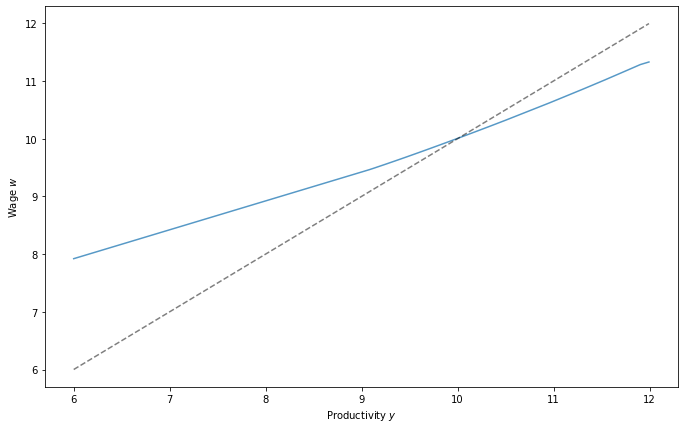

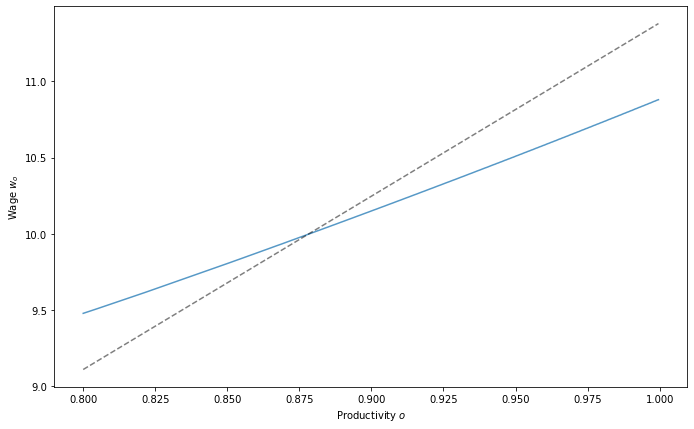

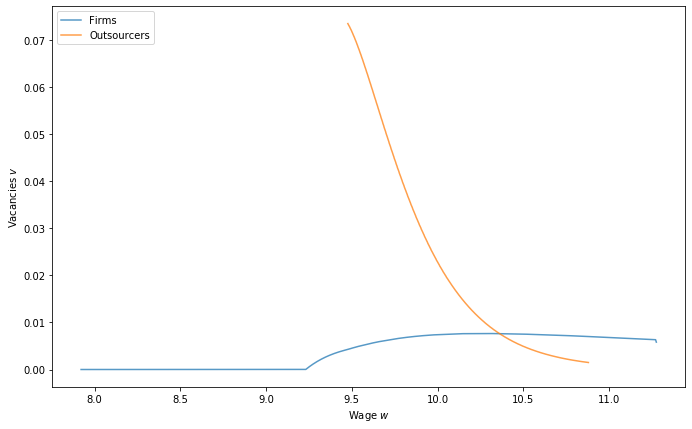

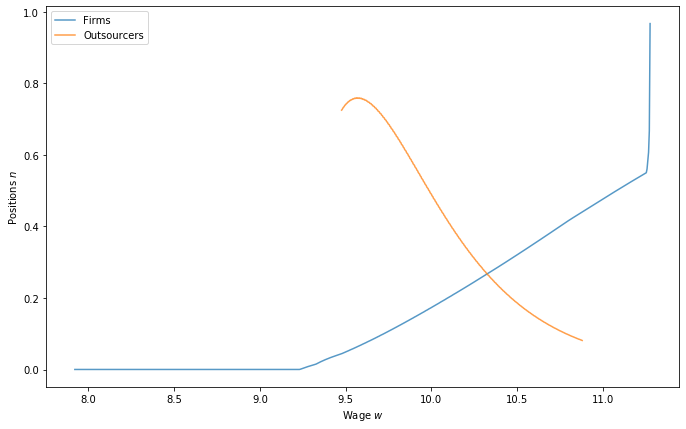

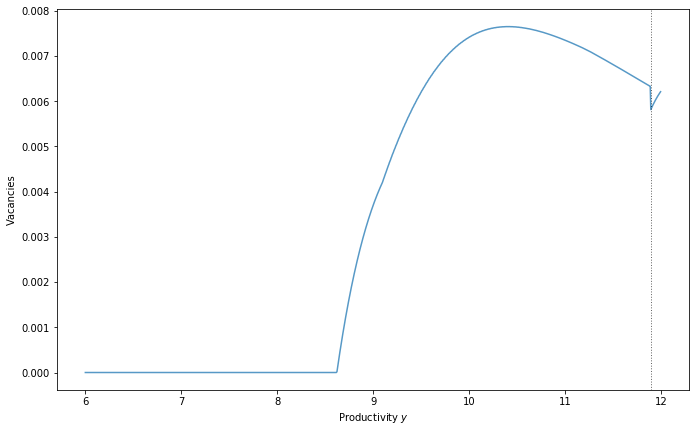

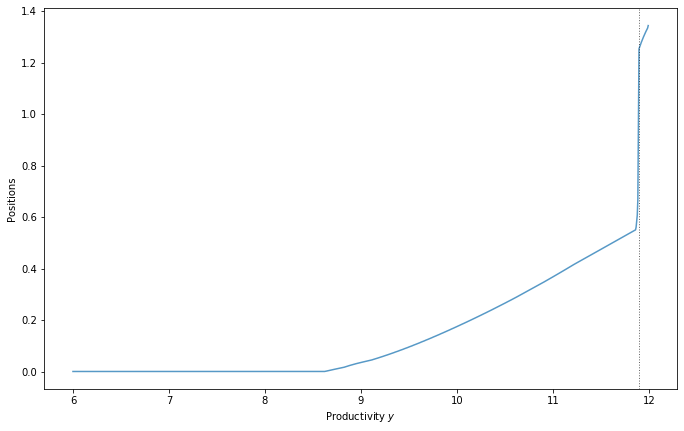

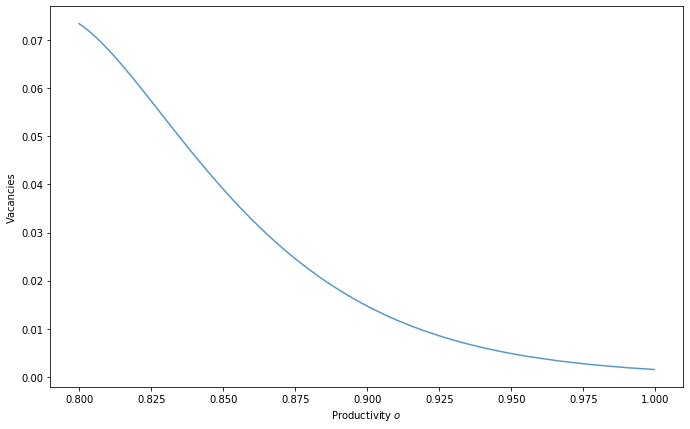

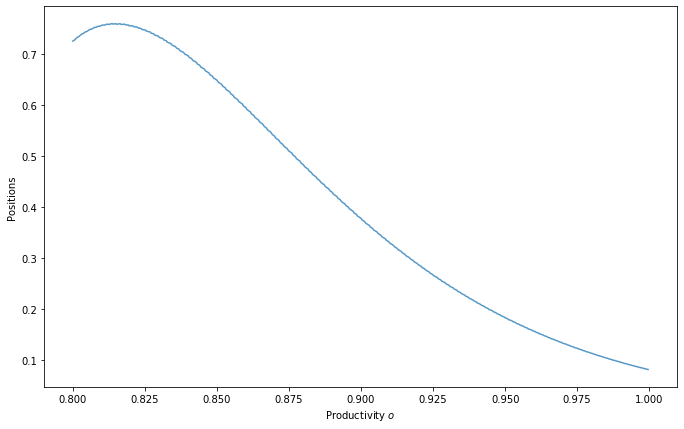

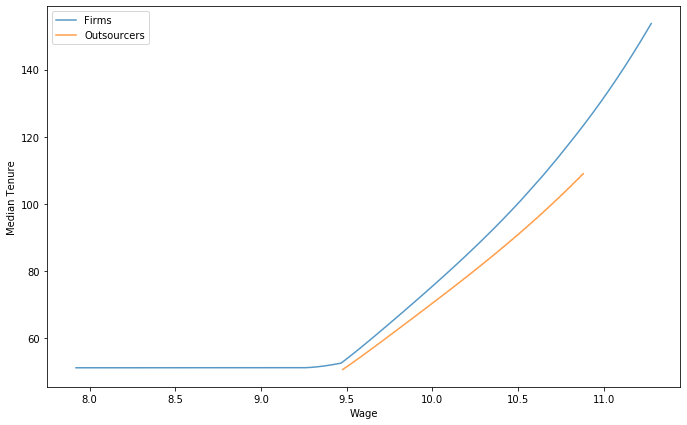

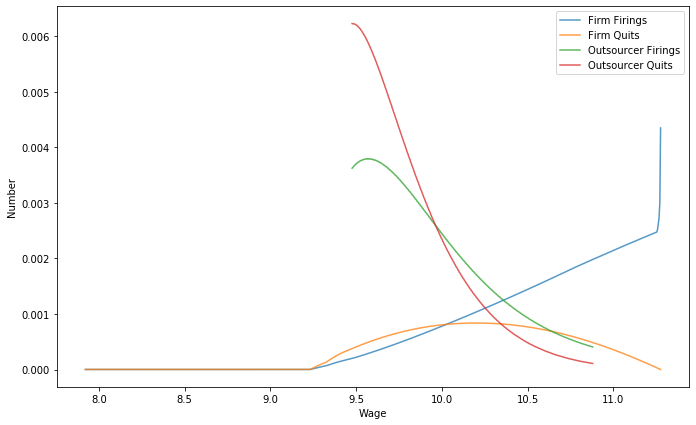

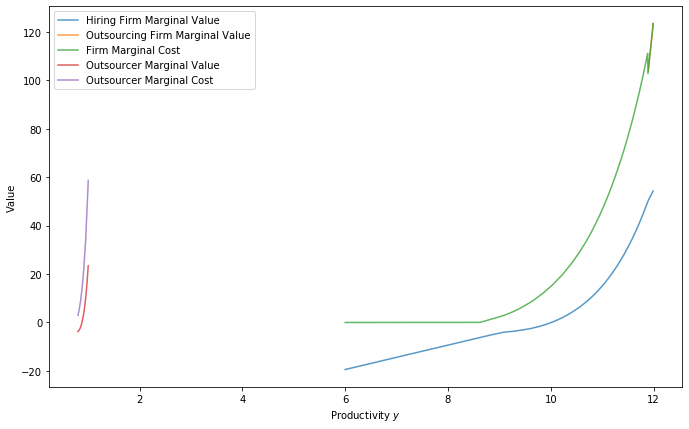

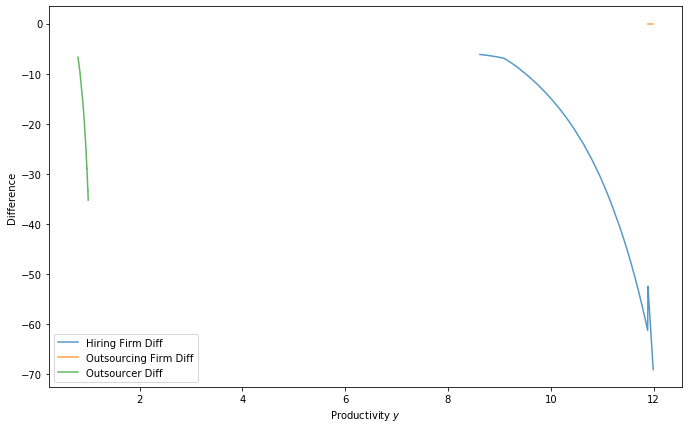

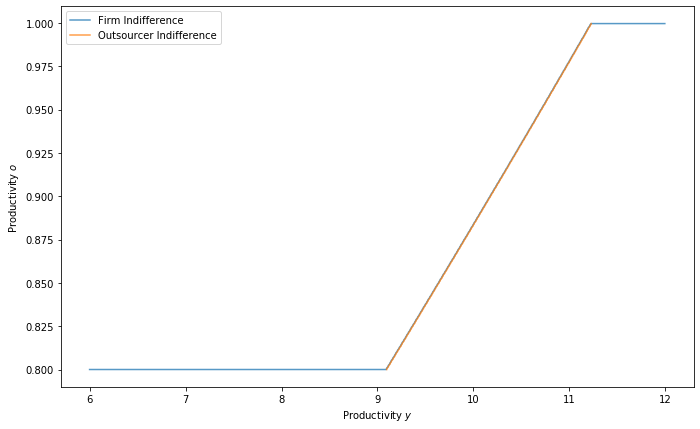

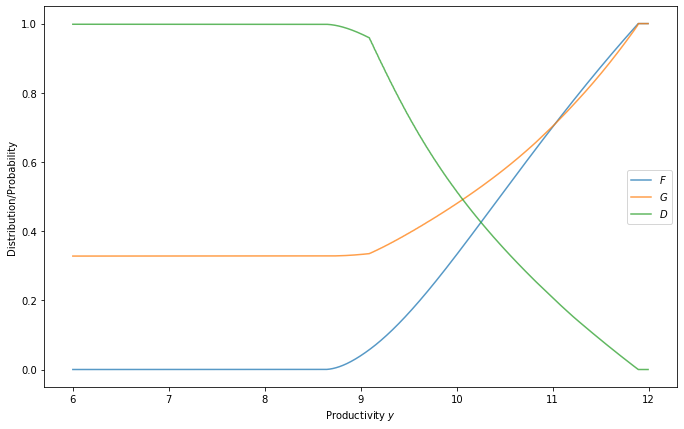

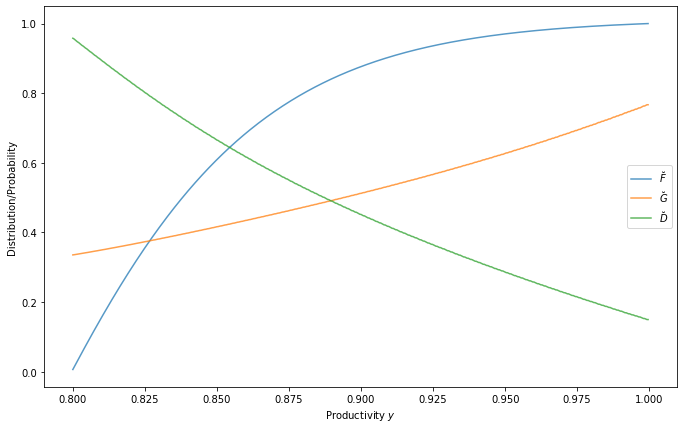

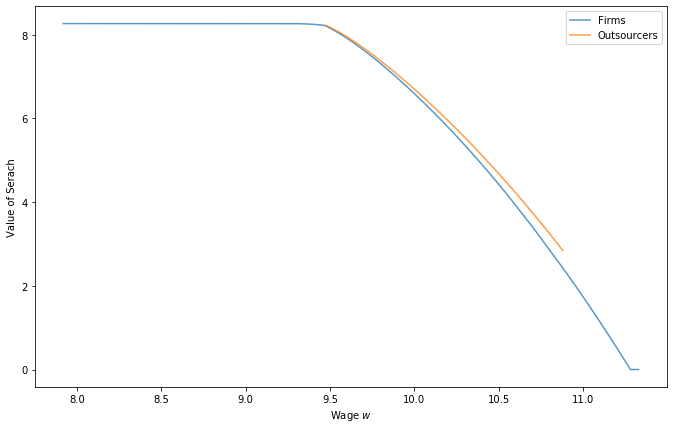

In [65]:
r = 0.000939
B = 1 / (1 + r)
delta = 0.0045
delta_o = 0.0050
delta_hat = 0.0040
xi = .1
# xi = 0
eta = 0.5
eta_o = 0.5
phi = 2e-1 
y_min = 6
y_max = 12
o_min = 0.8
o_max = 1.0
b = y_min * .4 
y_grid_size = 1000
# y_grid_size = 8000
o_grid_size = 500
gamma = 2
gamma_o = 2
k_grid = np.logspace(1, 4, y_grid_size, endpoint = False)
k_o_grid = np.logspace(1, 4, o_grid_size, endpoint = False)
# k_grid = 1e9
# k_o_grid = 1e9

p_low = 6
p_high = 12
tol = 1e-4
max_iter = 10
tol_i = 1e-4
max_iter_i = 5e4
slow_i = 1e-2
print_skip = 5
verbose = True

save = False

ooj = OutsourcingOnJob(
    B, b, delta, delta_o, delta_hat, xi, eta, eta_o, phi,
    y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
    gamma, gamma_o, k_grid, k_o_grid
)

v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p = find_p(
    ooj, p_low, p_high, tol, max_iter, tol_i, max_iter_i, slow_i, verbose, print_skip
)

list_facts(ooj, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p)

graph_results(ooj, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p,
             save=save)

error is 0.0331, went through 10000 iterations
y_hat is 982.0000, y_hat_new is 981.0000
The difference in theta and theta_new is 0.0210


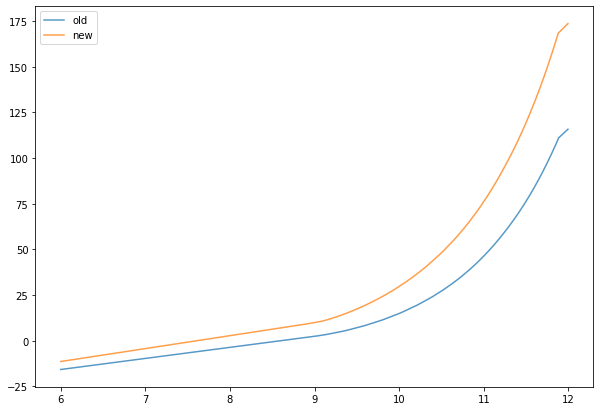

The indifferent firm is y_hat = 11.89$. Price of outsourcing is 11.38.
Unemployment is 5.41. According to LoM, should be 5.40
Workers match with probability 8.04. Firms/Outsourcers match with probability 49.77
Total vacancies searching for workers are 0.0231. Theta is 0.1615
30 percent of vacancies searching for workers are from outsourcers, 17 percent of postions outsourced
The ue rate is 0.08, the ee rate is 0.01,  and 37.600104 of new jobs are from unemployment
Checking if vacancies + LoM imply right positions:
 Hiring firms large error = 0.171625 at position 725 
 Outsourcing firms largest error = 0.000000 at position 0
 Outsourcer largest error = 3.216710 at position 37


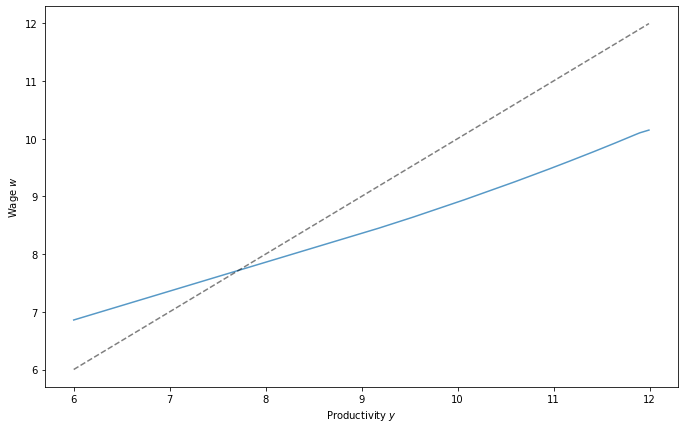

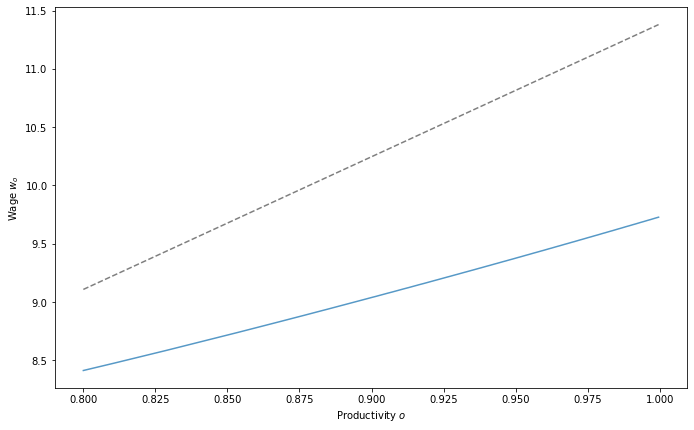

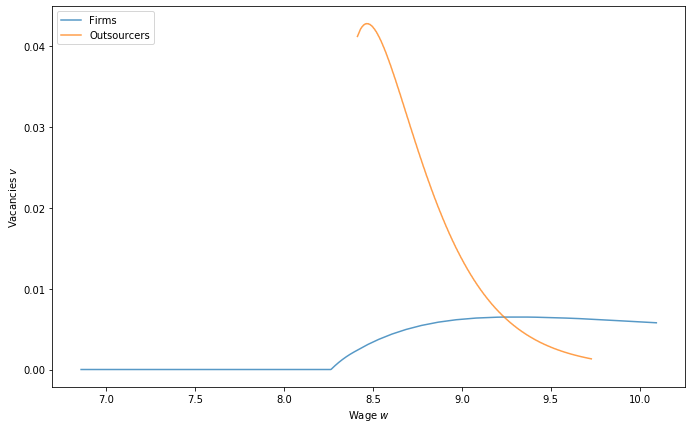

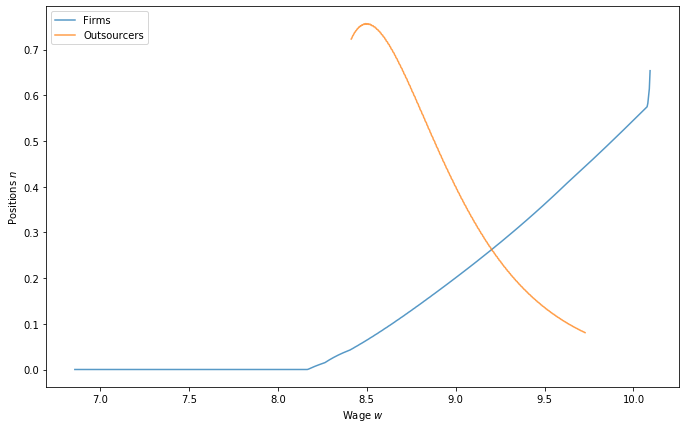

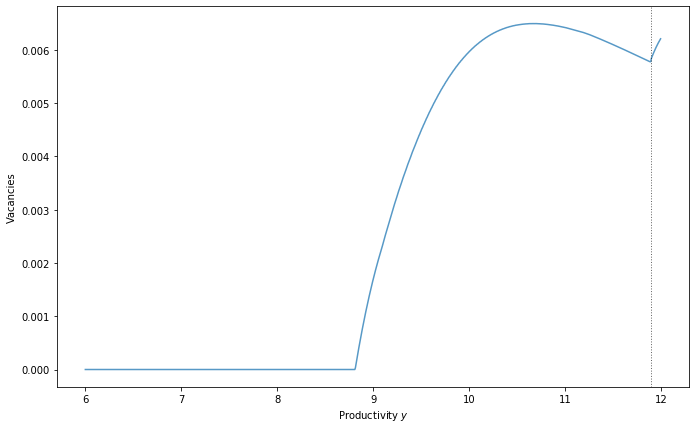

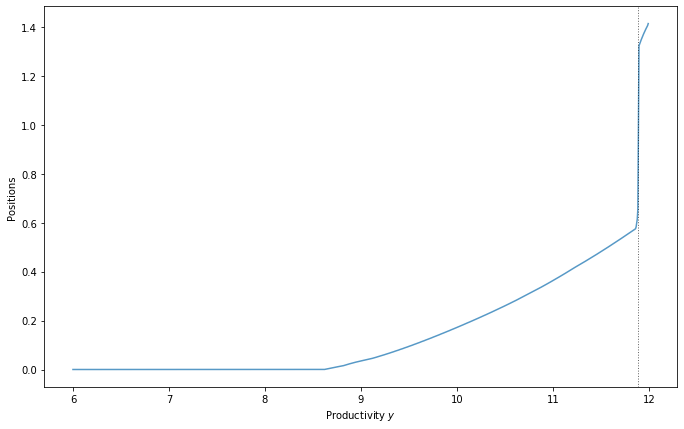

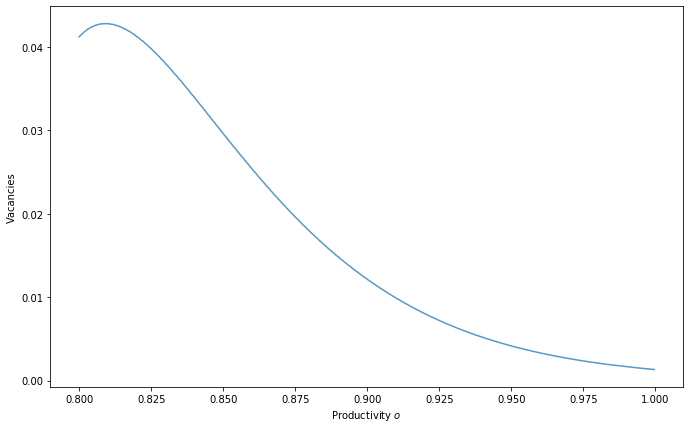

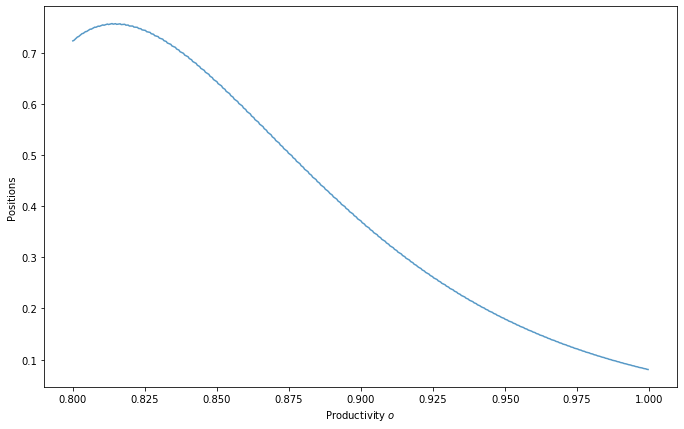

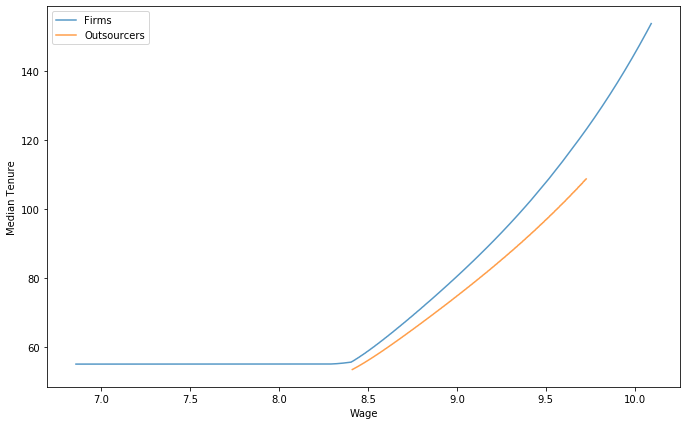

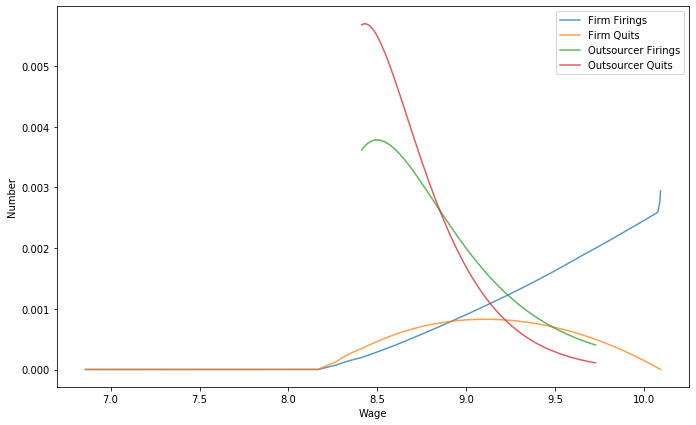

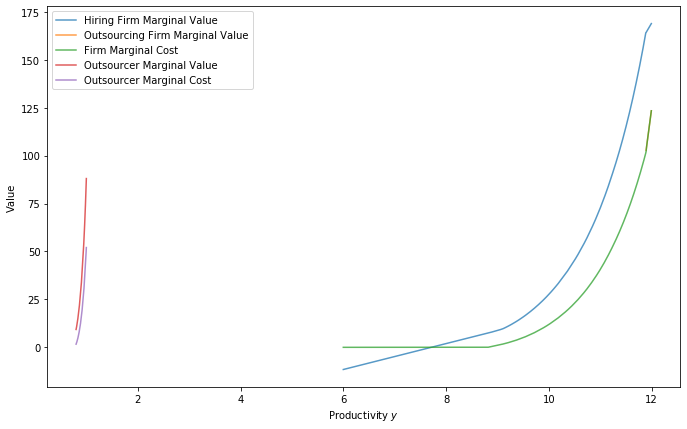

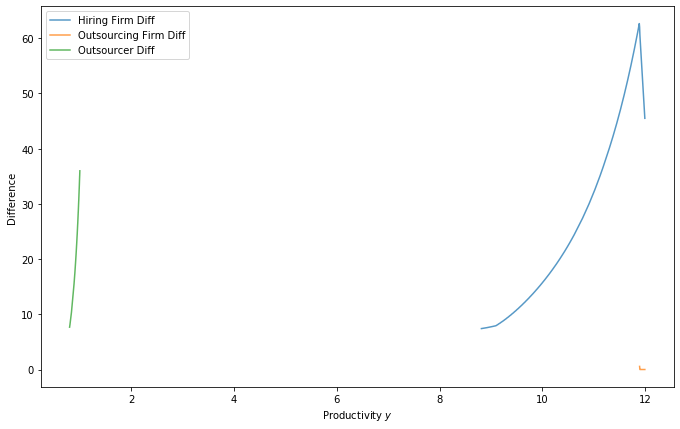

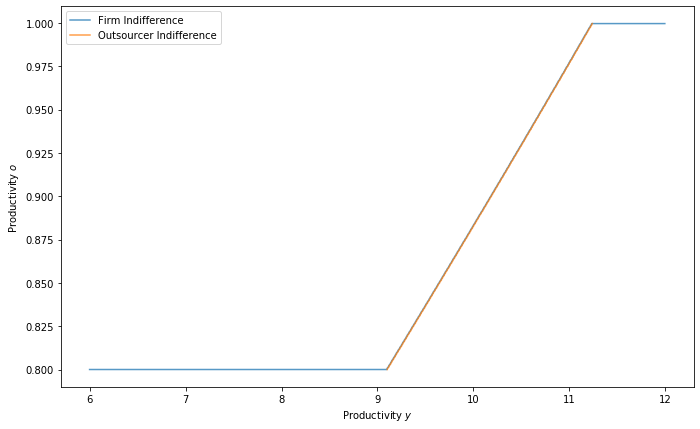

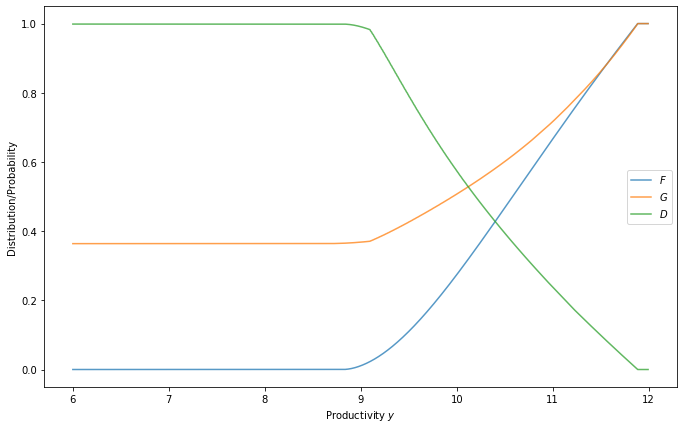

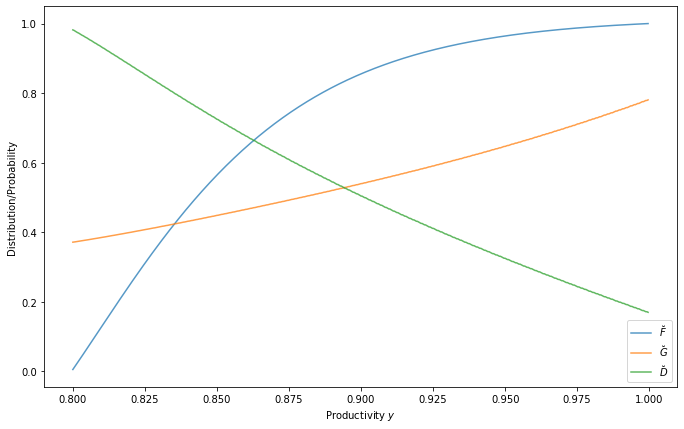

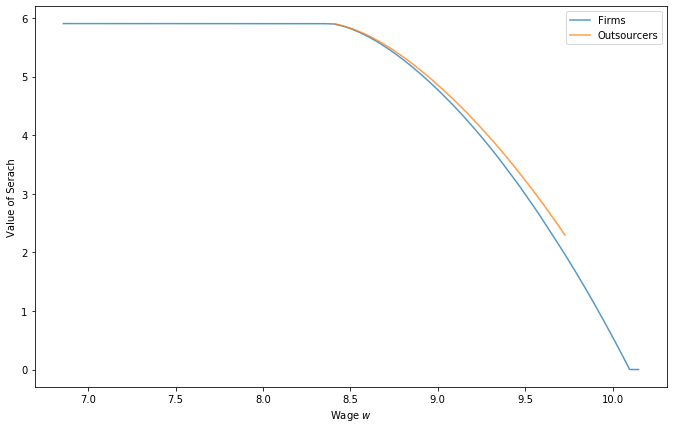

In [66]:
tol = 1e-4
max_iter = 1e4
slow = 1e-2
verbose = True

v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, theta_new = solve_given_p(
    ooj, p, v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, tol, max_iter, slow, verbose
)

list_facts(ooj, v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, theta_new, p)

graph_results(ooj, v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, theta_new, p)

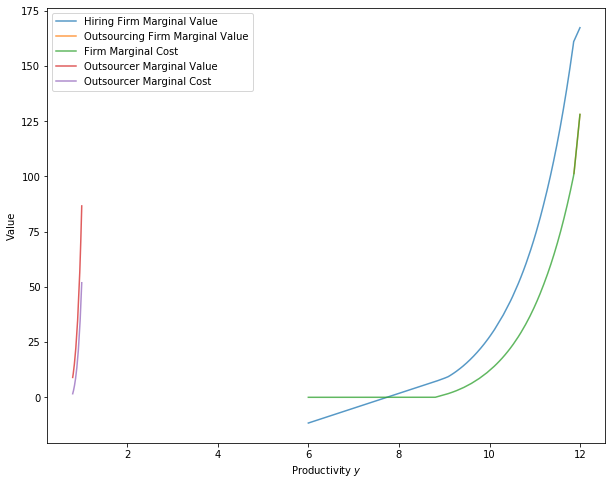

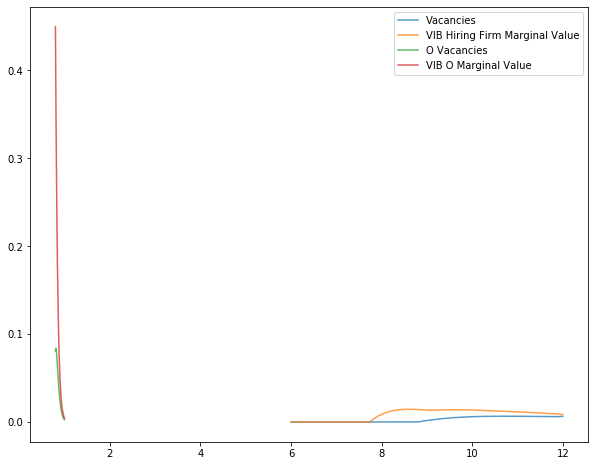

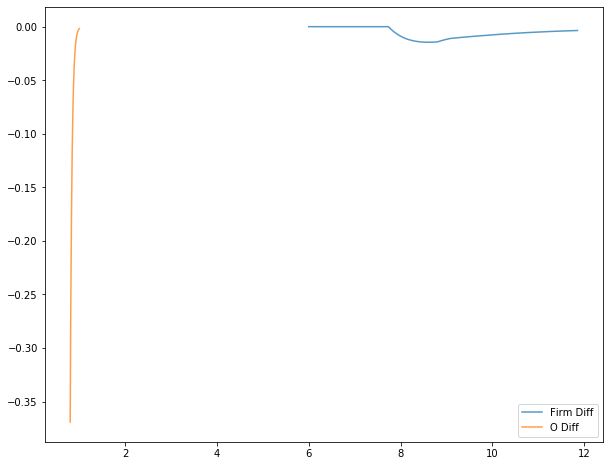

In [55]:
iterate, QD_QS, make_grids, C, c, c_inv, C_o, c_o, c_o_inv = operator_factory(ooj)

( G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, theta, p)

# (G_grid, G_o_grid, D_grid, D_o_grid,
#          Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
#             v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new, theta_new, p)

q = ooj.q
y_grid, o_grid = ooj.y_grid, ooj.o_grid

J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + (1 - delta) * D_grid)
J_out = (y_grid - p) / (r + delta_hat)
mc = c(v_grid)    

O = q(theta) * G_o_grid * (p * o_grid - w_o_grid) / (r + delta_o + (1 - delta_o) * D_o_grid)
mc_o = c_o(v_o_grid) 

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(y_grid, J_hire, alpha=0.75, label="Hiring Firm Marginal Value")
ax.plot(y_grid[y_hat:], J_out[y_hat:], alpha=0.75, label="Outsourcing Firm Marginal Value")
ax.plot(y_grid, mc, alpha=0.75, label="Firm Marginal Cost")
ax.plot(o_grid, O, alpha=0.75, label="Outsourcer Marginal Value")
ax.plot(o_grid, mc_o, alpha=0.75, label="Outsourcer Marginal Cost")
ax.set(xlabel="Productivity $y$", ylabel="Value")
ax.legend(loc="best")

plt.show()

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(y_grid, v_grid, alpha=0.75, label="Vacancies")
ax.plot(y_grid, c_inv(J_hire), alpha=0.75, label="VIB Hiring Firm Marginal Value")
ax.plot(o_grid, v_o_grid, alpha=0.75, label="O Vacancies")
ax.plot(o_grid, c_o_inv(O), alpha=0.75, label="VIB O Marginal Value")
ax.legend(loc="best")

plt.show()

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(y_grid[:y_hat], v_grid[:y_hat] - c_inv(J_hire)[:y_hat], alpha=0.75, label="Firm Diff")
ax.plot(o_grid, v_o_grid - c_o_inv(O), alpha=0.75, label="O Diff")
ax.legend(loc="best")

plt.show()